In [2]:
from keras.models import Sequential
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [4]:
TRAINING_SIZE = 100000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [5]:
class  CharacterTable (object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [6]:
ctable = CharacterTable(chars)

In [7]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [8]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    
    big_number = max([a,b])
    small_number = min([a,b])
    q = '{}-{}'.format(big_number, small_number)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(big_number - small_number)
    ans += ' ' * (DIGITS - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000


In [9]:
print(questions[:5], expected[:5])

['3-0    ', '901-292', '681-8  ', '61-6   ', '425-82 '] ['3  ', '609', '673', '55 ', '343']


# Processing

In [10]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS )

Vectorization...


In [11]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:70000]
train_y = y[:70000]
test_x = x[70000:]
test_y = y[70000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(63000, 7, 12)
(63000, 3, 12)
Validation Data:
(7000, 7, 12)
(7000, 3, 12)
Testing Data:
(30000, 7, 12)
(30000, 3, 12)


In [22]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False  True False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False False False False False False False False False  True False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False False False False False False  True False
   False]
  [False False False False False False False False False False  True
   False]
  [False False False False  True False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False Fal

# Build Model

In [13]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# for iteration in range(150):
#     print()
#     print('-' * 50)
#     print('Iteration', iteration)
#     early_stopping_monitor = EarlyStopping(patience=5, mode='auto')
#     model.fit(x_train, y_train,
#               batch_size=BATCH_SIZE,
#               epochs=1,
#               validation_data=(x_val, y_val),
#               callbacks=[early_stopping_monitor])
#     for i in range(10):
#         ind = np.random.randint(0, len(x_val))
#         rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
#         preds = model.predict_classes(rowx, verbose=0)
#         q = ctable.decode(rowx[0])
#         correct = ctable.decode(rowy[0])
#         guess = ctable.decode(preds[0], calc_argmax=False)
#         print('Q', q[::-1] if REVERSE else q, end=' ')
#         print('T', correct, end=' ')
#         if correct == guess:
#             print(colors.ok + '☑' + colors.close, end=' ')
#         else:
#             print(colors.fail + '☒' + colors.close, end=' ')
#         print(guess)

In [ ]:
# early_stopping_monitor = EarlyStopping(patience=5, mode='auto')
# rnn_model = model.fit(x_train, y_train,
#                       batch_size=BATCH_SIZE,
#                       epochs=100,
#                       validation_data=(x_val, y_val),
#                       callbacks=[early_stopping_monitor])

In [15]:
model_batch64 = model.fit(x_train, y_train,
                      batch_size=64,
                      epochs=80,
                      validation_data=(x_val, y_val))

Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 15s 245us/step - loss: 2.0544 - acc: 0.2358 - val_loss: 1.7894 - val_acc: 0.3386
Epoch 2/80
63000/63000 [==============================] - 15s 233us/step - loss: 1.7089 - acc: 0.3637 - val_loss: 1.6276 - val_acc: 0.3861
Epoch 3/80
63000/63000 [==============================] - 14s 225us/step - loss: 1.5806 - acc: 0.4047 - val_loss: 1.5273 - val_acc: 0.4204
Epoch 4/80
63000/63000 [==============================] - 14s 225us/step - loss: 1.4393 - acc: 0.4560 - val_loss: 1.3499 - val_acc: 0.4837
Epoch 5/80
63000/63000 [==============================] - 14s 229us/step - loss: 1.2928 - acc: 0.5067 - val_loss: 1.2521 - val_acc: 0.5178
Epoch 6/80
63000/63000 [==============================] - 14s 226us/step - loss: 1.1783 - acc: 0.5503 - val_loss: 1.1627 - val_acc: 0.5540
Epoch 7/80
63000/63000 [==============================] - 14s 226us/step - loss: 1.0997 - acc: 0.5815 - val_loss: 1.0

63000/63000 [==============================] - 13s 207us/step - loss: 0.0117 - acc: 0.9972 - val_loss: 0.0781 - val_acc: 0.9733
Epoch 60/80
63000/63000 [==============================] - 13s 206us/step - loss: 0.0182 - acc: 0.9956 - val_loss: 0.0162 - val_acc: 0.9955
Epoch 61/80
63000/63000 [==============================] - 13s 210us/step - loss: 0.0181 - acc: 0.9950 - val_loss: 0.0243 - val_acc: 0.9927
Epoch 62/80
63000/63000 [==============================] - 14s 215us/step - loss: 0.0104 - acc: 0.9980 - val_loss: 0.0138 - val_acc: 0.9953
Epoch 63/80
63000/63000 [==============================] - 13s 210us/step - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0165 - val_acc: 0.9946
Epoch 64/80
63000/63000 [==============================] - 13s 210us/step - loss: 0.0127 - acc: 0.9971 - val_loss: 0.0287 - val_acc: 0.9925
Epoch 65/80
63000/63000 [==============================] - 13s 211us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0129 - val_acc: 0.9959
Epoch 66/80
63000/63000 [=======

In [16]:
right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Q 711-56  T 655 ☑ 655
Q 729-589 T 140 ☑ 140
Q 204-162 T 42  ☑ 42 
Q 803-207 T 596 ☑ 596
Q 184-61  T 123 ☑ 123
Q 720-327 T 393 ☑ 393
Q 199-81  T 118 ☑ 118
Q 901-506 T 395 ☑ 395
Q 92-64   T 28  ☑ 28 
Q 499-18  T 481 ☑ 481
Q 231-17  T 214 ☑ 214
Q 674-324 T 350 ☑ 350
Q 232-4   T 228 ☑ 228
Q 632-340 T 292 ☑ 292
Q 474-164 T 310 ☑ 310
Q 743-177 T 566 ☑ 566
Q 761-70  T 691 ☑ 691
Q 445-365 T 80  ☑ 80 
Q 987-627 T 360 ☑ 360
Q 307-10  T 297 ☑ 297
Q 344-7   T 337 ☑ 337
Q 588-0   T 588 ☑ 588
Q 718-7   T 711 ☑ 711
Q 783-44  T 739 ☑ 739
Q 273-0   T 273 ☑ 273
Q 922-109 T 813 ☑ 813
Q 324-28  T 296 ☒ 396
Q 568-37  T 531 ☑ 531
Q 751-539 T 212 ☑ 212
Q 214-47  T 167 ☑ 167
Q 933-48  T 885 ☑ 885
Q 781-87  T 694 ☑ 694
Q 859-13  T 846 ☑ 846
Q 720-238 T 482 ☑ 482
Q 790-132 T 658 ☑ 658
Q 567-16  T 551 ☑ 551
Q 533-160 T 373 ☑ 373
Q 175-70  T 105 ☑ 105
Q 231-60  T 171 ☑ 171
Q 141-33  T 108 ☑ 108
Q 232-80  T 152 ☑ 152
Q 322-1   T 321 ☑ 321
Q 878-674 T 204 ☑ 204
Q 974-36  T 938 ☑ 938
Q 882-629 T 253 ☑ 253
Q 287-216 

Q 820-0   T 820 ☑ 820
Q 556-175 T 381 ☑ 381
Q 853-740 T 113 ☑ 113
Q 498-300 T 198 ☑ 198
Q 302-43  T 259 ☑ 259
Q 317-92  T 225 ☑ 225
Q 118-64  T 54  ☑ 54 
Q 358-30  T 328 ☑ 328
Q 767-692 T 75  ☑ 75 
Q 87-87   T 0   ☑ 0  
Q 557-356 T 201 ☑ 201
Q 188-18  T 170 ☑ 170
Q 933-37  T 896 ☑ 896
Q 765-71  T 694 ☑ 694
Q 494-93  T 401 ☑ 401
Q 649-9   T 640 ☑ 640
Q 258-35  T 223 ☑ 223
Q 34-21   T 13  ☑ 13 
Q 435-99  T 336 ☑ 336
Q 238-3   T 235 ☑ 235
Q 694-330 T 364 ☑ 364
Q 723-641 T 82  ☑ 82 
Q 931-556 T 375 ☑ 375
Q 421-66  T 355 ☑ 355
Q 73-28   T 45  ☑ 45 
Q 796-548 T 248 ☑ 248
Q 511-11  T 500 ☑ 500
Q 950-607 T 343 ☑ 343
Q 655-17  T 638 ☑ 638
Q 112-14  T 98  ☑ 98 
Q 408-9   T 399 ☑ 399
Q 697-288 T 409 ☑ 409
Q 448-25  T 423 ☑ 423
Q 615-329 T 286 ☑ 286
Q 985-3   T 982 ☑ 982
Q 874-277 T 597 ☑ 597
Q 509-48  T 461 ☑ 461
Q 367-282 T 85  ☑ 85 
Q 67-37   T 30  ☑ 30 
Q 997-670 T 327 ☑ 327
Q 723-423 T 300 ☑ 300
Q 247-208 T 39  ☑ 39 
Q 553-81  T 472 ☑ 472
Q 382-61  T 321 ☑ 321
Q 461-41  T 420 ☑ 420
Q 600-89  

Q 92-23   T 69  ☑ 69 
Q 78-27   T 51  ☑ 51 
Q 755-82  T 673 ☑ 673
Q 863-20  T 843 ☑ 843
Q 133-74  T 59  ☑ 59 
Q 976-125 T 851 ☑ 851
Q 673-95  T 578 ☑ 578
Q 462-377 T 85  ☑ 85 
Q 466-344 T 122 ☑ 122
Q 201-44  T 157 ☑ 157
Q 981-222 T 759 ☑ 759
Q 797-35  T 762 ☑ 762
Q 627-85  T 542 ☑ 542
Q 216-3   T 213 ☑ 213
Q 583-7   T 576 ☑ 576
Q 648-2   T 646 ☑ 646
Q 315-64  T 251 ☑ 251
Q 397-72  T 325 ☑ 325
Q 539-417 T 122 ☑ 122
Q 708-96  T 612 ☑ 612
Q 761-405 T 356 ☑ 356
Q 515-31  T 484 ☑ 484
Q 389-4   T 385 ☑ 385
Q 422-195 T 227 ☑ 227
Q 635-55  T 580 ☑ 580
Q 86-34   T 52  ☑ 52 
Q 342-315 T 27  ☑ 27 
Q 323-308 T 15  ☑ 15 
Q 265-58  T 207 ☑ 207
Q 241-7   T 234 ☑ 234
Q 105-97  T 8   ☑ 8  
Q 438-97  T 341 ☑ 341
Q 784-98  T 686 ☑ 686
Q 800-513 T 287 ☑ 287
Q 794-511 T 283 ☑ 283
Q 728-61  T 667 ☑ 667
Q 243-133 T 110 ☑ 110
Q 649-81  T 568 ☑ 568
Q 452-329 T 123 ☑ 123
Q 784-40  T 744 ☑ 744
Q 981-701 T 280 ☑ 280
Q 670-1   T 669 ☑ 669
Q 108-88  T 20  ☑ 20 
Q 727-439 T 288 ☑ 288
Q 745-194 T 551 ☑ 551
Q 497-73  

Q 560-60  T 500 ☑ 500
Q 228-96  T 132 ☑ 132
Q 672-315 T 357 ☑ 357
Q 470-44  T 426 ☑ 426
Q 298-193 T 105 ☑ 105
Q 700-534 T 166 ☑ 166
Q 518-90  T 428 ☑ 428
Q 68-57   T 11  ☑ 11 
Q 364-31  T 333 ☑ 333
Q 860-64  T 796 ☑ 796
Q 284-52  T 232 ☑ 232
Q 389-137 T 252 ☑ 252
Q 862-636 T 226 ☑ 226
Q 947-431 T 516 ☑ 516
Q 685-60  T 625 ☑ 625
Q 875-651 T 224 ☑ 224
Q 596-31  T 565 ☑ 565
Q 214-186 T 28  ☑ 28 
Q 933-22  T 911 ☑ 911
Q 576-515 T 61  ☑ 61 
Q 908-95  T 813 ☑ 813
Q 811-425 T 386 ☑ 386
Q 794-63  T 731 ☑ 731
Q 395-15  T 380 ☑ 380
Q 506-56  T 450 ☑ 450
Q 830-610 T 220 ☑ 220
Q 351-42  T 309 ☑ 309
Q 682-550 T 132 ☑ 132
Q 894-250 T 644 ☑ 644
Q 895-14  T 881 ☑ 881
Q 233-13  T 220 ☑ 220
Q 955-192 T 763 ☑ 763
Q 607-503 T 104 ☑ 104
Q 93-90   T 3   ☑ 3  
Q 710-43  T 667 ☑ 667
Q 597-89  T 508 ☑ 508
Q 456-440 T 16  ☑ 16 
Q 476-79  T 397 ☑ 397
Q 542-22  T 520 ☑ 520
Q 292-10  T 282 ☑ 282
Q 721-4   T 717 ☑ 717
Q 993-4   T 989 ☑ 989
Q 485-91  T 394 ☑ 394
Q 103-18  T 85  ☑ 85 
Q 757-65  T 692 ☑ 692
Q 903-4   

Q 612-93  T 519 ☑ 519
Q 791-529 T 262 ☑ 262
Q 569-97  T 472 ☑ 472
Q 49-48   T 1   ☑ 1  
Q 454-13  T 441 ☑ 441
Q 70-10   T 60  ☑ 60 
Q 778-19  T 759 ☑ 759
Q 557-245 T 312 ☑ 312
Q 852-471 T 381 ☑ 381
Q 617-61  T 556 ☑ 556
Q 951-74  T 877 ☑ 877
Q 309-81  T 228 ☑ 228
Q 550-211 T 339 ☑ 339
Q 548-88  T 460 ☑ 460
Q 265-31  T 234 ☑ 234
Q 664-21  T 643 ☑ 643
Q 511-134 T 377 ☑ 377
Q 335-47  T 288 ☑ 288
Q 625-57  T 568 ☑ 568
Q 717-341 T 376 ☑ 376
Q 291-61  T 230 ☑ 230
Q 847-69  T 778 ☑ 778
Q 983-27  T 956 ☑ 956
Q 325-93  T 232 ☑ 232
Q 90-77   T 13  ☑ 13 
Q 456-37  T 419 ☑ 419
Q 637-13  T 624 ☑ 624
Q 699-92  T 607 ☑ 607
Q 358-1   T 357 ☑ 357
Q 721-37  T 684 ☑ 684
Q 239-56  T 183 ☑ 183
Q 865-537 T 328 ☑ 328
Q 546-76  T 470 ☑ 470
Q 331-64  T 267 ☑ 267
Q 204-62  T 142 ☑ 142
Q 81-2    T 79  ☑ 79 
Q 974-353 T 621 ☑ 621
Q 823-469 T 354 ☑ 354
Q 994-174 T 820 ☑ 820
Q 871-813 T 58  ☑ 58 
Q 688-182 T 506 ☑ 506
Q 396-99  T 297 ☑ 297
Q 381-69  T 312 ☑ 312
Q 823-188 T 635 ☑ 635
Q 667-93  T 574 ☑ 574
Q 487-59  

Q 652-640 T 12  ☑ 12 
Q 636-4   T 632 ☑ 632
Q 860-11  T 849 ☑ 849
Q 961-611 T 350 ☑ 350
Q 150-76  T 74  ☑ 74 
Q 352-30  T 322 ☑ 322
Q 413-154 T 259 ☑ 259
Q 454-41  T 413 ☑ 413
Q 648-442 T 206 ☑ 206
Q 967-12  T 955 ☑ 955
Q 545-35  T 510 ☑ 510
Q 571-8   T 563 ☑ 563
Q 581-278 T 303 ☑ 303
Q 412-56  T 356 ☑ 356
Q 595-71  T 524 ☑ 524
Q 842-828 T 14  ☑ 14 
Q 812-149 T 663 ☑ 663
Q 765-100 T 665 ☑ 665
Q 975-7   T 968 ☑ 968
Q 955-674 T 281 ☑ 281
Q 888-67  T 821 ☑ 821
Q 34-23   T 11  ☑ 11 
Q 78-33   T 45  ☑ 45 
Q 864-93  T 771 ☑ 771
Q 753-14  T 739 ☑ 739
Q 647-263 T 384 ☑ 384
Q 695-175 T 520 ☑ 520
Q 457-4   T 453 ☑ 453
Q 921-8   T 913 ☑ 913
Q 713-46  T 667 ☑ 667
Q 419-312 T 107 ☑ 107
Q 569-39  T 530 ☑ 530
Q 16-5    T 11  ☑ 11 
Q 785-23  T 762 ☑ 762
Q 520-71  T 449 ☑ 449
Q 880-174 T 706 ☑ 706
Q 119-72  T 47  ☑ 47 
Q 70-15   T 55  ☑ 55 
Q 620-60  T 560 ☑ 560
Q 48-25   T 23  ☑ 23 
Q 231-158 T 73  ☑ 73 
Q 649-78  T 571 ☑ 571
Q 656-77  T 579 ☑ 579
Q 738-581 T 157 ☑ 157
Q 240-75  T 165 ☑ 165
Q 507-73  

Q 763-354 T 409 ☑ 409
Q 805-98  T 707 ☑ 707
Q 911-39  T 872 ☑ 872
Q 445-36  T 409 ☑ 409
Q 701-20  T 681 ☑ 681
Q 719-40  T 679 ☑ 679
Q 943-1   T 942 ☑ 942
Q 410-84  T 326 ☑ 326
Q 626-84  T 542 ☑ 542
Q 391-3   T 388 ☑ 388
Q 888-199 T 689 ☑ 689
Q 498-258 T 240 ☑ 240
Q 256-19  T 237 ☑ 237
Q 90-75   T 15  ☑ 15 
Q 626-9   T 617 ☑ 617
Q 252-84  T 168 ☑ 168
Q 971-90  T 881 ☑ 881
Q 57-2    T 55  ☑ 55 
Q 822-197 T 625 ☑ 625
Q 300-250 T 50  ☑ 50 
Q 607-74  T 533 ☑ 533
Q 919-75  T 844 ☑ 844
Q 260-54  T 206 ☑ 206
Q 577-24  T 553 ☑ 553
Q 450-0   T 450 ☑ 450
Q 307-84  T 223 ☑ 223
Q 766-107 T 659 ☑ 659
Q 824-51  T 773 ☑ 773
Q 568-92  T 476 ☑ 476
Q 535-91  T 444 ☑ 444
Q 958-63  T 895 ☑ 895
Q 470-56  T 414 ☑ 414
Q 53-4    T 49  ☑ 49 
Q 629-77  T 552 ☑ 552
Q 511-241 T 270 ☑ 270
Q 923-491 T 432 ☑ 432
Q 539-6   T 533 ☑ 533
Q 531-48  T 483 ☑ 483
Q 797-231 T 566 ☑ 566
Q 977-64  T 913 ☑ 913
Q 97-39   T 58  ☑ 58 
Q 970-33  T 937 ☑ 937
Q 525-309 T 216 ☑ 216
Q 127-33  T 94  ☑ 94 
Q 320-94  T 226 ☑ 226
Q 492-130 

Q 38-2    T 36  ☑ 36 
Q 886-205 T 681 ☑ 681
Q 718-464 T 254 ☑ 254
Q 482-233 T 249 ☑ 249
Q 339-87  T 252 ☑ 252
Q 277-12  T 265 ☑ 265
Q 227-79  T 148 ☑ 148
Q 700-54  T 646 ☑ 646
Q 209-74  T 135 ☑ 135
Q 792-114 T 678 ☑ 678
Q 942-83  T 859 ☑ 859
Q 376-5   T 371 ☑ 371
Q 80-42   T 38  ☑ 38 
Q 705-55  T 650 ☑ 650
Q 280-89  T 191 ☑ 191
Q 500-273 T 227 ☑ 227
Q 930-9   T 921 ☑ 921
Q 710-704 T 6   ☑ 6  
Q 735-34  T 701 ☑ 701
Q 686-79  T 607 ☑ 607
Q 410-48  T 362 ☑ 362
Q 869-857 T 12  ☑ 12 
Q 306-43  T 263 ☑ 263
Q 264-34  T 230 ☑ 230
Q 808-68  T 740 ☑ 740
Q 469-53  T 416 ☑ 416
Q 898-29  T 869 ☑ 869
Q 965-24  T 941 ☑ 941
Q 816-7   T 809 ☑ 809
Q 890-580 T 310 ☑ 310
Q 245-232 T 13  ☑ 13 
Q 461-2   T 459 ☑ 459
Q 542-530 T 12  ☑ 12 
Q 486-13  T 473 ☑ 473
Q 137-48  T 89  ☑ 89 
Q 848-398 T 450 ☑ 450
Q 321-151 T 170 ☑ 170
Q 272-0   T 272 ☑ 272
Q 962-47  T 915 ☑ 915
Q 43-38   T 5   ☑ 5  
Q 731-575 T 156 ☑ 156
Q 429-98  T 331 ☑ 331
Q 483-36  T 447 ☑ 447
Q 312-29  T 283 ☑ 283
Q 517-42  T 475 ☑ 475
Q 848-576 

Q 510-31  T 479 ☑ 479
Q 369-218 T 151 ☑ 151
Q 157-83  T 74  ☑ 74 
Q 420-30  T 390 ☑ 390
Q 988-67  T 921 ☑ 921
Q 832-247 T 585 ☑ 585
Q 379-76  T 303 ☑ 303
Q 888-82  T 806 ☑ 806
Q 392-74  T 318 ☑ 318
Q 983-91  T 892 ☑ 892
Q 863-8   T 855 ☑ 855
Q 431-70  T 361 ☑ 361
Q 42-5    T 37  ☑ 37 
Q 540-71  T 469 ☑ 469
Q 766-5   T 761 ☑ 761
Q 765-28  T 737 ☑ 737
Q 707-27  T 680 ☑ 680
Q 310-18  T 292 ☑ 292
Q 499-86  T 413 ☑ 413
Q 664-192 T 472 ☑ 472
Q 929-418 T 511 ☑ 511
Q 916-59  T 857 ☑ 857
Q 426-0   T 426 ☑ 426
Q 968-815 T 153 ☑ 153
Q 951-72  T 879 ☑ 879
Q 181-30  T 151 ☑ 151
Q 621-70  T 551 ☑ 551
Q 441-0   T 441 ☑ 441
Q 591-467 T 124 ☑ 124
Q 872-17  T 855 ☑ 855
Q 735-31  T 704 ☑ 704
Q 134-36  T 98  ☑ 98 
Q 883-34  T 849 ☑ 849
Q 567-450 T 117 ☑ 117
Q 555-91  T 464 ☑ 464
Q 144-71  T 73  ☑ 73 
Q 972-620 T 352 ☑ 352
Q 688-6   T 682 ☑ 682
Q 143-35  T 108 ☑ 108
Q 815-505 T 310 ☑ 310
Q 479-438 T 41  ☑ 41 
Q 694-530 T 164 ☑ 164
Q 589-555 T 34  ☑ 34 
Q 993-772 T 221 ☑ 221
Q 97-24   T 73  ☑ 73 
Q 642-55  

Q 579-94  T 485 ☑ 485
Q 872-318 T 554 ☑ 554
Q 143-63  T 80  ☑ 80 
Q 471-5   T 466 ☑ 466
Q 266-262 T 4   ☑ 4  
Q 861-277 T 584 ☑ 584
Q 610-8   T 602 ☑ 602
Q 995-2   T 993 ☑ 993
Q 666-321 T 345 ☑ 345
Q 346-0   T 346 ☑ 346
Q 619-75  T 544 ☑ 544
Q 347-50  T 297 ☑ 297
Q 917-575 T 342 ☑ 342
Q 632-207 T 425 ☑ 425
Q 498-10  T 488 ☑ 488
Q 857-665 T 192 ☑ 192
Q 754-85  T 669 ☑ 669
Q 578-48  T 530 ☑ 530
Q 453-226 T 227 ☑ 227
Q 804-787 T 17  ☑ 17 
Q 39-14   T 25  ☑ 25 
Q 676-24  T 652 ☑ 652
Q 177-38  T 139 ☑ 139
Q 456-447 T 9   ☑ 9  
Q 898-244 T 654 ☑ 654
Q 668-30  T 638 ☑ 638
Q 580-11  T 569 ☑ 569
Q 724-47  T 677 ☑ 677
Q 869-191 T 678 ☑ 678
Q 766-13  T 753 ☑ 753
Q 517-5   T 512 ☑ 512
Q 807-529 T 278 ☑ 278
Q 786-608 T 178 ☑ 178
Q 473-304 T 169 ☑ 169
Q 915-477 T 438 ☑ 438
Q 128-71  T 57  ☑ 57 
Q 740-406 T 334 ☑ 334
Q 528-491 T 37  ☑ 37 
Q 174-47  T 127 ☑ 127
Q 807-469 T 338 ☑ 338
Q 278-19  T 259 ☑ 259
Q 183-70  T 113 ☑ 113
Q 640-27  T 613 ☑ 613
Q 893-697 T 196 ☑ 196
Q 865-83  T 782 ☑ 782
Q 359-73  

Q 116-18  T 98  ☑ 98 
Q 996-895 T 101 ☑ 101
Q 571-95  T 476 ☑ 476
Q 892-29  T 863 ☑ 863
Q 600-239 T 361 ☑ 361
Q 935-585 T 350 ☑ 350
Q 691-52  T 639 ☑ 639
Q 187-64  T 123 ☑ 123
Q 968-927 T 41  ☑ 41 
Q 901-60  T 841 ☑ 841
Q 752-746 T 6   ☑ 6  
Q 767-696 T 71  ☑ 71 
Q 414-86  T 328 ☑ 328
Q 688-669 T 19  ☑ 19 
Q 168-10  T 158 ☑ 158
Q 888-8   T 880 ☑ 880
Q 495-99  T 396 ☑ 396
Q 41-34   T 7   ☑ 7  
Q 824-17  T 807 ☑ 807
Q 610-10  T 600 ☑ 600
Q 809-15  T 794 ☑ 794
Q 850-399 T 451 ☑ 451
Q 543-475 T 68  ☑ 68 
Q 118-0   T 118 ☑ 118
Q 940-51  T 889 ☑ 889
Q 771-692 T 79  ☒ 89 
Q 780-574 T 206 ☑ 206
Q 774-286 T 488 ☑ 488
Q 757-480 T 277 ☑ 277
Q 641-193 T 448 ☑ 448
Q 87-38   T 49  ☑ 49 
Q 351-27  T 324 ☑ 324
Q 745-240 T 505 ☑ 505
Q 404-23  T 381 ☑ 381
Q 956-26  T 930 ☑ 930
Q 389-377 T 12  ☑ 12 
Q 423-35  T 388 ☑ 388
Q 950-249 T 701 ☑ 701
Q 760-5   T 755 ☑ 755
Q 874-69  T 805 ☑ 805
Q 262-25  T 237 ☑ 237
Q 339-67  T 272 ☑ 272
Q 937-54  T 883 ☑ 883
Q 70-16   T 54  ☑ 54 
Q 467-4   T 463 ☑ 463
Q 478-327 

Q 108-36  T 72  ☑ 72 
Q 787-217 T 570 ☑ 570
Q 692-398 T 294 ☑ 294
Q 834-172 T 662 ☑ 662
Q 728-217 T 511 ☑ 511
Q 585-24  T 561 ☑ 561
Q 939-267 T 672 ☑ 672
Q 855-334 T 521 ☑ 521
Q 486-22  T 464 ☑ 464
Q 711-708 T 3   ☒ 2  
Q 435-186 T 249 ☑ 249
Q 899-49  T 850 ☑ 850
Q 75-12   T 63  ☑ 63 
Q 671-78  T 593 ☑ 593
Q 907-49  T 858 ☑ 858
Q 562-158 T 404 ☑ 404
Q 804-33  T 771 ☑ 771
Q 722-507 T 215 ☑ 215
Q 596-127 T 469 ☑ 469
Q 812-26  T 786 ☑ 786
Q 962-30  T 932 ☑ 932
Q 457-94  T 363 ☑ 363
Q 700-32  T 668 ☑ 668
Q 937-11  T 926 ☑ 926
Q 617-23  T 594 ☑ 594
Q 781-86  T 695 ☑ 695
Q 144-94  T 50  ☑ 50 
Q 809-132 T 677 ☑ 677
Q 862-281 T 581 ☑ 581
Q 322-24  T 298 ☑ 298
Q 150-47  T 103 ☑ 103
Q 899-56  T 843 ☑ 843
Q 507-6   T 501 ☑ 501
Q 958-10  T 948 ☑ 948
Q 899-201 T 698 ☑ 698
Q 403-82  T 321 ☑ 321
Q 962-37  T 925 ☑ 925
Q 584-378 T 206 ☑ 206
Q 204-16  T 188 ☑ 188
Q 915-72  T 843 ☑ 843
Q 473-73  T 400 ☑ 400
Q 340-6   T 334 ☑ 334
Q 437-32  T 405 ☑ 405
Q 321-35  T 286 ☑ 286
Q 357-232 T 125 ☑ 125
Q 256-120 

Q 342-34  T 308 ☑ 308
Q 339-0   T 339 ☑ 339
Q 597-49  T 548 ☑ 548
Q 769-607 T 162 ☑ 162
Q 723-64  T 659 ☑ 659
Q 493-91  T 402 ☑ 402
Q 684-371 T 313 ☑ 313
Q 462-59  T 403 ☑ 403
Q 769-724 T 45  ☑ 45 
Q 709-325 T 384 ☑ 384
Q 33-8    T 25  ☑ 25 
Q 447-335 T 112 ☑ 112
Q 453-74  T 379 ☑ 379
Q 861-788 T 73  ☑ 73 
Q 516-73  T 443 ☑ 443
Q 955-720 T 235 ☑ 235
Q 845-62  T 783 ☑ 783
Q 452-51  T 401 ☑ 401
Q 946-22  T 924 ☑ 924
Q 920-32  T 888 ☑ 888
Q 983-82  T 901 ☑ 901
Q 99-10   T 89  ☑ 89 
Q 753-2   T 751 ☑ 751
Q 469-5   T 464 ☑ 464
Q 908-67  T 841 ☑ 841
Q 557-401 T 156 ☑ 156
Q 360-199 T 161 ☑ 161
Q 737-362 T 375 ☑ 375
Q 890-456 T 434 ☑ 434
Q 587-65  T 522 ☑ 522
Q 806-246 T 560 ☑ 560
Q 108-56  T 52  ☑ 52 
Q 710-78  T 632 ☑ 632
Q 969-80  T 889 ☑ 889
Q 683-57  T 626 ☑ 626
Q 228-64  T 164 ☑ 164
Q 399-7   T 392 ☑ 392
Q 490-89  T 401 ☑ 401
Q 808-29  T 779 ☑ 779
Q 383-50  T 333 ☑ 333
Q 782-166 T 616 ☑ 616
Q 728-88  T 640 ☑ 640
Q 950-68  T 882 ☑ 882
Q 620-219 T 401 ☑ 401
Q 604-51  T 553 ☑ 553
Q 857-70  

Q 272-7   T 265 ☑ 265
Q 140-4   T 136 ☑ 136
Q 259-182 T 77  ☑ 77 
Q 478-201 T 277 ☑ 277
Q 265-14  T 251 ☑ 251
Q 417-6   T 411 ☑ 411
Q 212-68  T 144 ☑ 144
Q 340-68  T 272 ☑ 272
Q 673-2   T 671 ☑ 671
Q 252-63  T 189 ☑ 189
Q 979-477 T 502 ☑ 502
Q 309-66  T 243 ☑ 243
Q 154-26  T 128 ☑ 128
Q 978-944 T 34  ☑ 34 
Q 116-75  T 41  ☑ 41 
Q 75-18   T 57  ☑ 57 
Q 974-69  T 905 ☑ 905
Q 165-37  T 128 ☑ 128
Q 927-98  T 829 ☑ 829
Q 408-59  T 349 ☑ 349
Q 460-330 T 130 ☑ 130
Q 744-40  T 704 ☑ 704
Q 934-866 T 68  ☑ 68 
Q 809-126 T 683 ☑ 683
Q 272-54  T 218 ☑ 218
Q 463-86  T 377 ☑ 377
Q 817-19  T 798 ☑ 798
Q 506-91  T 415 ☑ 415
Q 569-199 T 370 ☑ 370
Q 961-444 T 517 ☑ 517
Q 276-18  T 258 ☑ 258
Q 535-10  T 525 ☑ 525
Q 733-55  T 678 ☑ 678
Q 47-21   T 26  ☑ 26 
Q 68-23   T 45  ☑ 45 
Q 948-133 T 815 ☑ 815
Q 721-431 T 290 ☑ 290
Q 970-656 T 314 ☑ 314
Q 755-659 T 96  ☑ 96 
Q 63-62   T 1   ☑ 1  
Q 338-215 T 123 ☑ 123
Q 738-52  T 686 ☑ 686
Q 168-9   T 159 ☑ 159
Q 659-87  T 572 ☑ 572
Q 139-73  T 66  ☑ 66 
Q 719-99  

Q 934-112 T 822 ☑ 822
Q 792-5   T 787 ☑ 787
Q 837-386 T 451 ☑ 451
Q 880-762 T 118 ☑ 118
Q 721-163 T 558 ☑ 558
Q 142-37  T 105 ☑ 105
Q 65-38   T 27  ☑ 27 
Q 714-112 T 602 ☑ 602
Q 742-3   T 739 ☑ 739
Q 301-87  T 214 ☑ 214
Q 534-61  T 473 ☑ 473
Q 690-70  T 620 ☑ 620
Q 824-24  T 800 ☑ 800
Q 530-194 T 336 ☑ 336
Q 622-49  T 573 ☑ 573
Q 707-5   T 702 ☑ 702
Q 199-52  T 147 ☑ 147
Q 815-24  T 791 ☑ 791
Q 443-155 T 288 ☑ 288
Q 858-8   T 850 ☑ 850
Q 662-70  T 592 ☑ 592
Q 730-322 T 408 ☑ 408
Q 478-91  T 387 ☑ 387
Q 297-32  T 265 ☑ 265
Q 71-20   T 51  ☑ 51 
Q 909-7   T 902 ☑ 902
Q 443-31  T 412 ☑ 412
Q 301-114 T 187 ☑ 187
Q 148-42  T 106 ☑ 106
Q 533-267 T 266 ☑ 266
Q 864-186 T 678 ☑ 678
Q 886-590 T 296 ☑ 296
Q 474-35  T 439 ☑ 439
Q 530-70  T 460 ☑ 460
Q 278-8   T 270 ☑ 270
Q 223-15  T 208 ☑ 208
Q 343-6   T 337 ☑ 337
Q 931-6   T 925 ☑ 925
Q 965-399 T 566 ☑ 566
Q 709-31  T 678 ☑ 678
Q 400-264 T 136 ☑ 136
Q 736-7   T 729 ☑ 729
Q 644-105 T 539 ☑ 539
Q 61-54   T 7   ☑ 7  
Q 340-23  T 317 ☑ 317
Q 831-8   

Q 865-230 T 635 ☑ 635
Q 577-19  T 558 ☑ 558
Q 335-106 T 229 ☑ 229
Q 657-15  T 642 ☑ 642
Q 902-54  T 848 ☑ 848
Q 961-83  T 878 ☑ 878
Q 678-55  T 623 ☑ 623
Q 875-54  T 821 ☑ 821
Q 395-376 T 19  ☑ 19 
Q 644-96  T 548 ☑ 548
Q 791-9   T 782 ☑ 782
Q 483-60  T 423 ☑ 423
Q 903-307 T 596 ☑ 596
Q 866-500 T 366 ☑ 366
Q 479-6   T 473 ☑ 473
Q 702-219 T 483 ☑ 483
Q 499-87  T 412 ☑ 412
Q 986-33  T 953 ☑ 953
Q 677-70  T 607 ☑ 607
Q 732-72  T 660 ☑ 660
Q 331-61  T 270 ☑ 270
Q 585-406 T 179 ☑ 179
Q 29-27   T 2   ☑ 2  
Q 794-82  T 712 ☑ 712
Q 519-14  T 505 ☑ 505
Q 575-512 T 63  ☑ 63 
Q 166-36  T 130 ☑ 130
Q 440-9   T 431 ☑ 431
Q 323-55  T 268 ☑ 268
Q 809-494 T 315 ☑ 315
Q 431-82  T 349 ☑ 349
Q 906-28  T 878 ☑ 878
Q 485-194 T 291 ☑ 291
Q 564-27  T 537 ☑ 537
Q 806-94  T 712 ☑ 712
Q 71-53   T 18  ☑ 18 
Q 584-294 T 290 ☑ 290
Q 662-23  T 639 ☑ 639
Q 520-501 T 19  ☑ 19 
Q 514-159 T 355 ☑ 355
Q 743-53  T 690 ☑ 690
Q 672-3   T 669 ☑ 669
Q 19-3    T 16  ☒ 15 
Q 801-61  T 740 ☑ 740
Q 828-752 T 76  ☑ 76 
Q 320-60  

Q 765-220 T 545 ☑ 545
Q 901-37  T 864 ☑ 864
Q 583-77  T 506 ☑ 506
Q 306-34  T 272 ☑ 272
Q 639-14  T 625 ☑ 625
Q 499-146 T 353 ☑ 353
Q 244-29  T 215 ☑ 215
Q 983-828 T 155 ☑ 155
Q 155-75  T 80  ☑ 80 
Q 668-660 T 8   ☑ 8  
Q 558-39  T 519 ☑ 519
Q 702-213 T 489 ☑ 489
Q 979-153 T 826 ☑ 826
Q 939-82  T 857 ☑ 857
Q 80-35   T 45  ☑ 45 
Q 527-48  T 479 ☑ 479
Q 180-137 T 43  ☑ 43 
Q 423-369 T 54  ☑ 54 
Q 551-268 T 283 ☑ 283
Q 619-574 T 45  ☑ 45 
Q 456-300 T 156 ☑ 156
Q 700-44  T 656 ☑ 656
Q 418-256 T 162 ☑ 162
Q 720-83  T 637 ☑ 637
Q 765-6   T 759 ☑ 759
Q 969-69  T 900 ☑ 900
Q 836-796 T 40  ☑ 40 
Q 632-79  T 553 ☑ 553
Q 668-41  T 627 ☑ 627
Q 66-20   T 46  ☑ 46 
Q 945-701 T 244 ☑ 244
Q 744-365 T 379 ☑ 379
Q 472-3   T 469 ☑ 469
Q 673-27  T 646 ☑ 646
Q 529-47  T 482 ☑ 482
Q 919-476 T 443 ☑ 443
Q 755-422 T 333 ☑ 333
Q 928-282 T 646 ☑ 646
Q 993-474 T 519 ☑ 519
Q 24-15   T 9   ☑ 9  
Q 301-285 T 16  ☑ 16 
Q 390-56  T 334 ☑ 334
Q 940-812 T 128 ☑ 128
Q 963-209 T 754 ☑ 754
Q 284-21  T 263 ☑ 263
Q 741-543 

Q 97-80   T 17  ☑ 17 
Q 383-263 T 120 ☑ 120
Q 904-660 T 244 ☑ 244
Q 668-6   T 662 ☑ 662
Q 950-572 T 378 ☑ 378
Q 866-364 T 502 ☑ 502
Q 830-377 T 453 ☑ 453
Q 624-90  T 534 ☑ 534
Q 365-98  T 267 ☑ 267
Q 528-90  T 438 ☑ 438
Q 487-14  T 473 ☑ 473
Q 890-366 T 524 ☑ 524
Q 242-1   T 241 ☑ 241
Q 427-58  T 369 ☑ 369
Q 145-81  T 64  ☑ 64 
Q 791-215 T 576 ☑ 576
Q 649-515 T 134 ☑ 134
Q 323-9   T 314 ☑ 314
Q 593-348 T 245 ☑ 245
Q 452-18  T 434 ☑ 434
Q 753-32  T 721 ☑ 721
Q 319-38  T 281 ☑ 281
Q 123-89  T 34  ☑ 34 
Q 379-82  T 297 ☑ 297
Q 140-15  T 125 ☑ 125
Q 838-380 T 458 ☑ 458
Q 269-13  T 256 ☑ 256
Q 903-171 T 732 ☑ 732
Q 71-57   T 14  ☑ 14 
Q 542-430 T 112 ☑ 112
Q 723-525 T 198 ☑ 198
Q 733-56  T 677 ☑ 677
Q 985-519 T 466 ☑ 466
Q 851-13  T 838 ☑ 838
Q 966-69  T 897 ☑ 897
Q 773-67  T 706 ☑ 706
Q 384-6   T 378 ☑ 378
Q 736-96  T 640 ☑ 640
Q 90-81   T 9   ☑ 9  
Q 996-58  T 938 ☑ 938
Q 736-295 T 441 ☑ 441
Q 690-76  T 614 ☑ 614
Q 114-42  T 72  ☑ 72 
Q 348-5   T 343 ☑ 343
Q 643-7   T 636 ☑ 636
Q 837-296 

Q 663-14  T 649 ☑ 649
Q 80-80   T 0   ☑ 0  
Q 882-227 T 655 ☑ 655
Q 291-82  T 209 ☑ 209
Q 517-18  T 499 ☑ 499
Q 914-429 T 485 ☑ 485
Q 945-252 T 693 ☑ 693
Q 680-85  T 595 ☑ 595
Q 923-739 T 184 ☑ 184
Q 496-80  T 416 ☑ 416
Q 164-51  T 113 ☑ 113
Q 422-191 T 231 ☑ 231
Q 116-17  T 99  ☑ 99 
Q 826-818 T 8   ☑ 8  
Q 883-26  T 857 ☑ 857
Q 867-14  T 853 ☑ 853
Q 981-974 T 7   ☑ 7  
Q 585-8   T 577 ☑ 577
Q 649-12  T 637 ☑ 637
Q 192-73  T 119 ☑ 119
Q 378-80  T 298 ☑ 298
Q 593-290 T 303 ☒ 203
Q 496-75  T 421 ☑ 421
Q 144-108 T 36  ☑ 36 
Q 766-42  T 724 ☑ 724
Q 671-107 T 564 ☑ 564
Q 535-79  T 456 ☑ 456
Q 774-712 T 62  ☑ 62 
Q 307-173 T 134 ☑ 134
Q 286-38  T 248 ☑ 248
Q 619-412 T 207 ☑ 207
Q 910-73  T 837 ☑ 837
Q 592-93  T 499 ☑ 499
Q 215-41  T 174 ☑ 174
Q 883-148 T 735 ☑ 735
Q 182-94  T 88  ☑ 88 
Q 160-14  T 146 ☑ 146
Q 564-209 T 355 ☑ 355
Q 396-61  T 335 ☑ 335
Q 684-70  T 614 ☑ 614
Q 580-364 T 216 ☑ 216
Q 669-93  T 576 ☑ 576
Q 394-43  T 351 ☑ 351
Q 502-54  T 448 ☑ 448
Q 814-247 T 567 ☑ 567
Q 496-66  

Q 741-647 T 94  ☑ 94 
Q 518-22  T 496 ☑ 496
Q 653-63  T 590 ☑ 590
Q 343-54  T 289 ☑ 289
Q 648-14  T 634 ☑ 634
Q 893-772 T 121 ☑ 121
Q 793-0   T 793 ☑ 793
Q 184-97  T 87  ☑ 87 
Q 627-335 T 292 ☑ 292
Q 605-350 T 255 ☑ 255
Q 752-8   T 744 ☑ 744
Q 105-31  T 74  ☑ 74 
Q 603-2   T 601 ☑ 601
Q 717-597 T 120 ☑ 120
Q 940-374 T 566 ☑ 566
Q 133-59  T 74  ☑ 74 
Q 98-22   T 76  ☑ 76 
Q 74-42   T 32  ☑ 32 
Q 637-89  T 548 ☑ 548
Q 517-78  T 439 ☑ 439
Q 329-4   T 325 ☑ 325
Q 203-25  T 178 ☑ 178
Q 873-695 T 178 ☑ 178
Q 198-70  T 128 ☑ 128
Q 233-60  T 173 ☑ 173
Q 454-76  T 378 ☑ 378
Q 331-242 T 89  ☑ 89 
Q 910-384 T 526 ☑ 526
Q 596-0   T 596 ☑ 596
Q 959-90  T 869 ☑ 869
Q 913-26  T 887 ☑ 887
Q 668-52  T 616 ☑ 616
Q 477-2   T 475 ☑ 475
Q 908-69  T 839 ☑ 839
Q 551-36  T 515 ☑ 515
Q 285-97  T 188 ☑ 188
Q 727-512 T 215 ☑ 215
Q 383-18  T 365 ☑ 365
Q 276-27  T 249 ☑ 249
Q 854-791 T 63  ☑ 63 
Q 603-200 T 403 ☑ 403
Q 532-114 T 418 ☑ 418
Q 178-3   T 175 ☑ 175
Q 939-45  T 894 ☑ 894
Q 139-12  T 127 ☑ 127
Q 870-432 

Q 314-75  T 239 ☑ 239
Q 695-76  T 619 ☑ 619
Q 460-87  T 373 ☑ 373
Q 187-19  T 168 ☑ 168
Q 578-59  T 519 ☑ 519
Q 217-32  T 185 ☑ 185
Q 782-721 T 61  ☑ 61 
Q 748-406 T 342 ☑ 342
Q 109-95  T 14  ☑ 14 
Q 396-4   T 392 ☑ 392
Q 991-4   T 987 ☑ 987
Q 160-95  T 65  ☑ 65 
Q 731-532 T 199 ☑ 199
Q 909-58  T 851 ☑ 851
Q 648-82  T 566 ☑ 566
Q 971-52  T 919 ☑ 919
Q 713-19  T 694 ☑ 694
Q 614-175 T 439 ☑ 439
Q 591-541 T 50  ☑ 50 
Q 238-44  T 194 ☑ 194
Q 799-12  T 787 ☑ 787
Q 938-25  T 913 ☑ 913
Q 273-235 T 38  ☑ 38 
Q 986-264 T 722 ☑ 722
Q 864-30  T 834 ☑ 834
Q 880-682 T 198 ☑ 198
Q 748-138 T 610 ☑ 610
Q 995-230 T 765 ☑ 765
Q 358-48  T 310 ☑ 310
Q 756-44  T 712 ☑ 712
Q 878-106 T 772 ☑ 772
Q 405-201 T 204 ☑ 204
Q 995-25  T 970 ☑ 970
Q 881-800 T 81  ☑ 81 
Q 180-39  T 141 ☑ 141
Q 788-292 T 496 ☑ 496
Q 697-79  T 618 ☑ 618
Q 540-4   T 536 ☑ 536
Q 649-503 T 146 ☑ 146
Q 819-507 T 312 ☑ 312
Q 817-305 T 512 ☑ 512
Q 202-74  T 128 ☑ 128
Q 247-143 T 104 ☑ 104
Q 922-55  T 867 ☑ 867
Q 681-0   T 681 ☑ 681
Q 660-180 

Q 73-26   T 47  ☑ 47 
Q 850-69  T 781 ☑ 781
Q 206-42  T 164 ☑ 164
Q 434-142 T 292 ☑ 292
Q 744-82  T 662 ☑ 662
Q 760-315 T 445 ☑ 445
Q 358-61  T 297 ☑ 297
Q 680-75  T 605 ☑ 605
Q 657-341 T 316 ☑ 316
Q 165-71  T 94  ☑ 94 
Q 992-77  T 915 ☑ 915
Q 636-595 T 41  ☑ 41 
Q 541-345 T 196 ☑ 196
Q 518-38  T 480 ☑ 480
Q 213-31  T 182 ☑ 182
Q 455-95  T 360 ☑ 360
Q 133-88  T 45  ☑ 45 
Q 375-93  T 282 ☑ 282
Q 22-14   T 8   ☑ 8  
Q 553-47  T 506 ☑ 506
Q 318-45  T 273 ☑ 273
Q 50-7    T 43  ☑ 43 
Q 767-47  T 720 ☑ 720
Q 634-18  T 616 ☑ 616
Q 687-2   T 685 ☑ 685
Q 865-73  T 792 ☑ 792
Q 642-523 T 119 ☑ 119
Q 650-68  T 582 ☑ 582
Q 461-77  T 384 ☑ 384
Q 241-2   T 239 ☑ 239
Q 918-414 T 504 ☑ 504
Q 407-82  T 325 ☑ 325
Q 997-64  T 933 ☑ 933
Q 615-84  T 531 ☑ 531
Q 83-29   T 54  ☑ 54 
Q 393-22  T 371 ☑ 371
Q 413-60  T 353 ☑ 353
Q 287-4   T 283 ☑ 283
Q 776-90  T 686 ☑ 686
Q 553-367 T 186 ☑ 186
Q 104-2   T 102 ☑ 102
Q 504-97  T 407 ☑ 407
Q 961-141 T 820 ☑ 820
Q 409-25  T 384 ☑ 384
Q 790-23  T 767 ☑ 767
Q 655-610 

Q 343-63  T 280 ☑ 280
Q 964-160 T 804 ☑ 804
Q 664-29  T 635 ☑ 635
Q 584-258 T 326 ☑ 326
Q 736-93  T 643 ☑ 643
Q 892-147 T 745 ☑ 745
Q 784-105 T 679 ☑ 679
Q 388-213 T 175 ☑ 175
Q 558-62  T 496 ☑ 496
Q 634-416 T 218 ☑ 218
Q 977-54  T 923 ☑ 923
Q 369-44  T 325 ☑ 325
Q 241-64  T 177 ☑ 177
Q 835-278 T 557 ☑ 557
Q 852-80  T 772 ☑ 772
Q 359-3   T 356 ☑ 356
Q 85-6    T 79  ☑ 79 
Q 325-120 T 205 ☑ 205
Q 597-35  T 562 ☑ 562
Q 511-19  T 492 ☑ 492
Q 836-731 T 105 ☑ 105
Q 719-120 T 599 ☑ 599
Q 914-377 T 537 ☑ 537
Q 465-370 T 95  ☑ 95 
Q 278-78  T 200 ☑ 200
Q 438-4   T 434 ☑ 434
Q 159-66  T 93  ☑ 93 
Q 473-44  T 429 ☑ 429
Q 401-384 T 17  ☑ 17 
Q 680-62  T 618 ☑ 618
Q 418-46  T 372 ☑ 372
Q 247-73  T 174 ☑ 174
Q 629-271 T 358 ☑ 358
Q 507-275 T 232 ☑ 232
Q 271-72  T 199 ☑ 199
Q 800-341 T 459 ☑ 459
Q 98-35   T 63  ☑ 63 
Q 994-762 T 232 ☑ 232
Q 847-54  T 793 ☑ 793
Q 142-116 T 26  ☑ 26 
Q 321-235 T 86  ☑ 86 
Q 470-52  T 418 ☑ 418
Q 389-353 T 36  ☑ 36 
Q 880-40  T 840 ☑ 840
Q 765-9   T 756 ☑ 756
Q 747-173 

Q 887-217 T 670 ☑ 670
Q 451-19  T 432 ☑ 432
Q 138-4   T 134 ☑ 134
Q 468-183 T 285 ☑ 285
Q 983-56  T 927 ☑ 927
Q 955-256 T 699 ☑ 699
Q 503-33  T 470 ☑ 470
Q 798-112 T 686 ☑ 686
Q 264-17  T 247 ☑ 247
Q 46-41   T 5   ☑ 5  
Q 974-42  T 932 ☑ 932
Q 966-190 T 776 ☑ 776
Q 216-89  T 127 ☑ 127
Q 488-247 T 241 ☑ 241
Q 194-46  T 148 ☑ 148
Q 819-9   T 810 ☑ 810
Q 721-322 T 399 ☑ 399
Q 887-57  T 830 ☑ 830
Q 628-573 T 55  ☑ 55 
Q 920-828 T 92  ☑ 92 
Q 495-459 T 36  ☑ 36 
Q 441-1   T 440 ☑ 440
Q 137-41  T 96  ☑ 96 
Q 729-18  T 711 ☑ 711
Q 496-223 T 273 ☑ 273
Q 502-258 T 244 ☑ 244
Q 791-8   T 783 ☑ 783
Q 706-46  T 660 ☑ 660
Q 231-58  T 173 ☑ 173
Q 477-379 T 98  ☑ 98 
Q 825-31  T 794 ☑ 794
Q 620-20  T 600 ☑ 600
Q 272-35  T 237 ☑ 237
Q 534-34  T 500 ☑ 500
Q 445-91  T 354 ☑ 354
Q 812-42  T 770 ☑ 770
Q 488-96  T 392 ☑ 392
Q 243-157 T 86  ☑ 86 
Q 163-42  T 121 ☑ 121
Q 988-878 T 110 ☑ 110
Q 579-53  T 526 ☑ 526
Q 758-68  T 690 ☑ 690
Q 787-62  T 725 ☑ 725
Q 142-40  T 102 ☑ 102
Q 535-6   T 529 ☑ 529
Q 428-46  

Q 728-351 T 377 ☑ 377
Q 782-648 T 134 ☑ 134
Q 405-51  T 354 ☑ 354
Q 688-101 T 587 ☑ 587
Q 467-388 T 79  ☑ 79 
Q 369-235 T 134 ☑ 134
Q 785-2   T 783 ☑ 783
Q 968-910 T 58  ☑ 58 
Q 887-0   T 887 ☑ 887
Q 145-88  T 57  ☑ 57 
Q 911-52  T 859 ☑ 859
Q 187-3   T 184 ☑ 184
Q 900-587 T 313 ☑ 313
Q 910-98  T 812 ☑ 812
Q 961-193 T 768 ☑ 768
Q 446-4   T 442 ☑ 442
Q 323-91  T 232 ☑ 232
Q 527-91  T 436 ☑ 436
Q 182-20  T 162 ☑ 162
Q 803-657 T 146 ☑ 146
Q 597-476 T 121 ☑ 121
Q 665-567 T 98  ☑ 98 
Q 554-139 T 415 ☑ 415
Q 320-75  T 245 ☑ 245
Q 421-56  T 365 ☑ 365
Q 850-56  T 794 ☑ 794
Q 32-9    T 23  ☑ 23 
Q 856-66  T 790 ☑ 790
Q 610-9   T 601 ☑ 601
Q 246-204 T 42  ☑ 42 
Q 581-65  T 516 ☑ 516
Q 679-53  T 626 ☑ 626
Q 685-4   T 681 ☑ 681
Q 382-46  T 336 ☑ 336
Q 485-86  T 399 ☑ 399
Q 951-293 T 658 ☑ 658
Q 340-76  T 264 ☑ 264
Q 654-650 T 4   ☒ 3  
Q 641-73  T 568 ☑ 568
Q 772-607 T 165 ☑ 165
Q 253-3   T 250 ☑ 250
Q 951-20  T 931 ☑ 931
Q 958-36  T 922 ☑ 922
Q 776-1   T 775 ☑ 775
Q 835-50  T 785 ☑ 785
Q 957-148 

Q 803-180 T 623 ☑ 623
Q 73-10   T 63  ☑ 63 
Q 418-415 T 3   ☒ 1  
Q 998-486 T 512 ☑ 512
Q 740-6   T 734 ☑ 734
Q 419-42  T 377 ☑ 377
Q 563-86  T 477 ☑ 477
Q 523-49  T 474 ☑ 474
Q 378-94  T 284 ☑ 284
Q 933-531 T 402 ☑ 402
Q 721-718 T 3   ☒ 1  
Q 610-410 T 200 ☑ 200
Q 167-32  T 135 ☑ 135
Q 140-21  T 119 ☑ 119
Q 826-23  T 803 ☑ 803
Q 755-108 T 647 ☑ 647
Q 375-98  T 277 ☑ 277
Q 707-426 T 281 ☑ 281
Q 512-43  T 469 ☑ 469
Q 588-165 T 423 ☑ 423
Q 513-10  T 503 ☑ 503
Q 80-69   T 11  ☑ 11 
Q 778-18  T 760 ☑ 760
Q 444-74  T 370 ☑ 370
Q 517-29  T 488 ☑ 488
Q 69-45   T 24  ☑ 24 
Q 364-24  T 340 ☑ 340
Q 876-343 T 533 ☑ 533
Q 280-52  T 228 ☑ 228
Q 379-35  T 344 ☑ 344
Q 457-76  T 381 ☑ 381
Q 49-28   T 21  ☑ 21 
Q 108-93  T 15  ☑ 15 
Q 441-33  T 408 ☑ 408
Q 958-114 T 844 ☑ 844
Q 660-476 T 184 ☑ 184
Q 685-73  T 612 ☑ 612
Q 772-709 T 63  ☑ 63 
Q 994-15  T 979 ☑ 979
Q 262-185 T 77  ☑ 77 
Q 587-123 T 464 ☑ 464
Q 817-373 T 444 ☑ 444
Q 466-303 T 163 ☑ 163
Q 405-5   T 400 ☑ 400
Q 313-205 T 108 ☑ 108
Q 652-22  

Q 846-639 T 207 ☑ 207
Q 190-32  T 158 ☑ 158
Q 299-44  T 255 ☑ 255
Q 389-48  T 341 ☑ 341
Q 778-83  T 695 ☑ 695
Q 653-26  T 627 ☑ 627
Q 888-7   T 881 ☑ 881
Q 653-68  T 585 ☑ 585
Q 872-3   T 869 ☑ 869
Q 407-35  T 372 ☑ 372
Q 545-72  T 473 ☑ 473
Q 130-8   T 122 ☑ 122
Q 717-260 T 457 ☑ 457
Q 705-41  T 664 ☑ 664
Q 883-24  T 859 ☑ 859
Q 178-57  T 121 ☑ 121
Q 672-119 T 553 ☑ 553
Q 127-80  T 47  ☑ 47 
Q 527-40  T 487 ☑ 487
Q 81-60   T 21  ☑ 21 
Q 929-65  T 864 ☑ 864
Q 711-25  T 686 ☑ 686
Q 870-98  T 772 ☑ 772
Q 478-66  T 412 ☑ 412
Q 636-87  T 549 ☑ 549
Q 141-63  T 78  ☑ 78 
Q 949-346 T 603 ☑ 603
Q 884-397 T 487 ☑ 487
Q 498-1   T 497 ☑ 497
Q 634-80  T 554 ☑ 554
Q 663-56  T 607 ☑ 607
Q 935-12  T 923 ☑ 923
Q 530-79  T 451 ☑ 451
Q 727-82  T 645 ☑ 645
Q 104-4   T 100 ☑ 100
Q 421-23  T 398 ☑ 398
Q 78-10   T 68  ☑ 68 
Q 325-71  T 254 ☑ 254
Q 961-62  T 899 ☑ 899
Q 737-12  T 725 ☑ 725
Q 329-235 T 94  ☑ 94 
Q 689-25  T 664 ☑ 664
Q 809-21  T 788 ☑ 788
Q 698-135 T 563 ☑ 563
Q 923-583 T 340 ☑ 340
Q 883-18  

Q 713-10  T 703 ☑ 703
Q 344-51  T 293 ☑ 293
Q 823-820 T 3   ☑ 3  
Q 832-17  T 815 ☑ 815
Q 821-219 T 602 ☑ 602
Q 798-44  T 754 ☑ 754
Q 353-120 T 233 ☑ 233
Q 965-298 T 667 ☑ 667
Q 829-431 T 398 ☒ 498
Q 259-27  T 232 ☑ 232
Q 191-147 T 44  ☑ 44 
Q 290-79  T 211 ☑ 211
Q 164-3   T 161 ☑ 161
Q 809-464 T 345 ☑ 345
Q 657-96  T 561 ☑ 561
Q 263-41  T 222 ☑ 222
Q 734-47  T 687 ☑ 687
Q 514-74  T 440 ☑ 440
Q 919-14  T 905 ☑ 905
Q 240-237 T 3   ☒ 1  
Q 473-279 T 194 ☑ 194
Q 848-29  T 819 ☑ 819
Q 853-40  T 813 ☑ 813
Q 974-548 T 426 ☑ 426
Q 77-35   T 42  ☑ 42 
Q 684-29  T 655 ☑ 655
Q 420-86  T 334 ☑ 334
Q 101-44  T 57  ☑ 57 
Q 348-68  T 280 ☑ 280
Q 574-80  T 494 ☑ 494
Q 119-42  T 77  ☑ 77 
Q 132-49  T 83  ☑ 83 
Q 81-81   T 0   ☑ 0  
Q 375-218 T 157 ☑ 157
Q 568-28  T 540 ☑ 540
Q 830-380 T 450 ☑ 450
Q 352-87  T 265 ☑ 265
Q 671-295 T 376 ☑ 376
Q 541-73  T 468 ☑ 468
Q 228-14  T 214 ☑ 214
Q 462-41  T 421 ☑ 421
Q 195-44  T 151 ☑ 151
Q 597-349 T 248 ☑ 248
Q 716-198 T 518 ☑ 518
Q 345-329 T 16  ☑ 16 
Q 476-27  

Q 959-55  T 904 ☑ 904
Q 502-98  T 404 ☑ 404
Q 731-341 T 390 ☑ 390
Q 921-89  T 832 ☑ 832
Q 603-58  T 545 ☑ 545
Q 671-561 T 110 ☑ 110
Q 475-125 T 350 ☑ 350
Q 892-82  T 810 ☑ 810
Q 924-29  T 895 ☑ 895
Q 619-308 T 311 ☑ 311
Q 655-485 T 170 ☑ 170
Q 797-60  T 737 ☑ 737
Q 282-88  T 194 ☑ 194
Q 844-381 T 463 ☑ 463
Q 958-68  T 890 ☑ 890
Q 750-81  T 669 ☑ 669
Q 962-446 T 516 ☑ 516
Q 428-18  T 410 ☑ 410
Q 280-7   T 273 ☑ 273
Q 352-36  T 316 ☑ 316
Q 988-756 T 232 ☑ 232
Q 987-79  T 908 ☑ 908
Q 474-101 T 373 ☑ 373
Q 180-2   T 178 ☑ 178
Q 135-81  T 54  ☑ 54 
Q 652-321 T 331 ☑ 331
Q 482-93  T 389 ☑ 389
Q 878-80  T 798 ☑ 798
Q 490-72  T 418 ☑ 418
Q 466-19  T 447 ☑ 447
Q 618-39  T 579 ☑ 579
Q 943-563 T 380 ☑ 380
Q 642-78  T 564 ☑ 564
Q 284-70  T 214 ☑ 214
Q 143-87  T 56  ☑ 56 
Q 559-32  T 527 ☑ 527
Q 814-191 T 623 ☑ 623
Q 176-52  T 124 ☑ 124
Q 556-152 T 404 ☑ 404
Q 464-10  T 454 ☑ 454
Q 416-7   T 409 ☑ 409
Q 733-66  T 667 ☑ 667
Q 623-410 T 213 ☑ 213
Q 592-5   T 587 ☑ 587
Q 810-736 T 74  ☑ 74 
Q 778-17  

Q 470-322 T 148 ☑ 148
Q 221-59  T 162 ☑ 162
Q 869-541 T 328 ☑ 328
Q 997-44  T 953 ☑ 953
Q 379-38  T 341 ☑ 341
Q 505-139 T 366 ☑ 366
Q 102-1   T 101 ☑ 101
Q 261-1   T 260 ☑ 260
Q 941-529 T 412 ☑ 412
Q 239-211 T 28  ☑ 28 
Q 678-98  T 580 ☑ 580
Q 518-463 T 55  ☑ 55 
Q 289-39  T 250 ☑ 250
Q 854-167 T 687 ☑ 687
Q 938-143 T 795 ☑ 795
Q 842-83  T 759 ☑ 759
Q 983-510 T 473 ☑ 473
Q 644-360 T 284 ☑ 284
Q 860-87  T 773 ☑ 773
Q 606-0   T 606 ☑ 606
Q 441-91  T 350 ☑ 350
Q 355-330 T 25  ☑ 25 
Q 937-269 T 668 ☑ 668
Q 981-92  T 889 ☑ 889
Q 512-510 T 2   ☒ 1  
Q 357-79  T 278 ☑ 278
Q 857-274 T 583 ☑ 583
Q 702-87  T 615 ☑ 615
Q 896-39  T 857 ☑ 857
Q 647-65  T 582 ☑ 582
Q 699-328 T 371 ☑ 371
Q 618-18  T 600 ☑ 600
Q 721-31  T 690 ☑ 690
Q 680-46  T 634 ☑ 634
Q 98-32   T 66  ☑ 66 
Q 949-9   T 940 ☑ 940
Q 620-407 T 213 ☑ 213
Q 241-185 T 56  ☑ 56 
Q 241-61  T 180 ☑ 180
Q 452-54  T 398 ☑ 398
Q 368-45  T 323 ☑ 323
Q 683-51  T 632 ☑ 632
Q 452-76  T 376 ☑ 376
Q 917-37  T 880 ☑ 880
Q 905-824 T 81  ☑ 81 
Q 760-42  

Q 67-40   T 27  ☑ 27 
Q 95-24   T 71  ☑ 71 
Q 692-2   T 690 ☑ 690
Q 739-216 T 523 ☑ 523
Q 479-23  T 456 ☑ 456
Q 316-79  T 237 ☑ 237
Q 276-0   T 276 ☑ 276
Q 742-75  T 667 ☑ 667
Q 703-250 T 453 ☑ 453
Q 341-21  T 320 ☑ 320
Q 386-7   T 379 ☑ 379
Q 522-8   T 514 ☑ 514
Q 113-28  T 85  ☑ 85 
Q 271-32  T 239 ☑ 239
Q 363-87  T 276 ☑ 276
Q 417-36  T 381 ☑ 381
Q 475-74  T 401 ☑ 401
Q 949-75  T 874 ☑ 874
Q 939-83  T 856 ☑ 856
Q 200-119 T 81  ☑ 81 
Q 651-61  T 590 ☑ 590
Q 742-44  T 698 ☑ 698
Q 525-458 T 67  ☑ 67 
Q 770-154 T 616 ☑ 616
Q 921-29  T 892 ☑ 892
Q 254-144 T 110 ☑ 110
Q 699-84  T 615 ☑ 615
Q 702-49  T 653 ☑ 653
Q 81-20   T 61  ☑ 61 
Q 835-427 T 408 ☑ 408
Q 679-4   T 675 ☑ 675
Q 634-95  T 539 ☑ 539
Q 996-400 T 596 ☑ 596
Q 745-463 T 282 ☑ 282
Q 393-118 T 275 ☑ 275
Q 809-437 T 372 ☑ 372
Q 836-616 T 220 ☑ 220
Q 705-420 T 285 ☑ 285
Q 320-90  T 230 ☑ 230
Q 109-62  T 47  ☑ 47 
Q 572-62  T 510 ☑ 510
Q 835-291 T 544 ☑ 544
Q 903-101 T 802 ☒ 702
Q 204-84  T 120 ☑ 120
Q 134-24  T 110 ☑ 110
Q 712-669 

Q 538-498 T 40  ☑ 40 
Q 560-55  T 505 ☑ 505
Q 490-69  T 421 ☑ 421
Q 526-143 T 383 ☑ 383
Q 28-19   T 9   ☑ 9  
Q 209-89  T 120 ☑ 120
Q 366-309 T 57  ☑ 57 
Q 636-58  T 578 ☑ 578
Q 994-497 T 497 ☑ 497
Q 850-62  T 788 ☑ 788
Q 677-266 T 411 ☑ 411
Q 484-210 T 274 ☑ 274
Q 146-84  T 62  ☑ 62 
Q 319-0   T 319 ☑ 319
Q 698-133 T 565 ☑ 565
Q 946-38  T 908 ☑ 908
Q 122-29  T 93  ☑ 93 
Q 649-301 T 348 ☑ 348
Q 802-40  T 762 ☑ 762
Q 206-54  T 152 ☑ 152
Q 929-332 T 597 ☑ 597
Q 658-77  T 581 ☑ 581
Q 810-484 T 326 ☑ 326
Q 964-374 T 590 ☑ 590
Q 133-105 T 28  ☑ 28 
Q 768-47  T 721 ☑ 721
Q 500-23  T 477 ☑ 477
Q 612-26  T 586 ☑ 586
Q 42-17   T 25  ☑ 25 
Q 919-2   T 917 ☑ 917
Q 770-3   T 767 ☑ 767
Q 706-342 T 364 ☑ 364
Q 281-89  T 192 ☑ 192
Q 247-13  T 234 ☑ 234
Q 176-4   T 172 ☑ 172
Q 96-29   T 67  ☑ 67 
Q 527-163 T 364 ☑ 364
Q 325-37  T 288 ☑ 288
Q 615-12  T 603 ☑ 603
Q 598-103 T 495 ☑ 495
Q 882-25  T 857 ☑ 857
Q 956-49  T 907 ☑ 907
Q 971-543 T 428 ☑ 428
Q 195-68  T 127 ☑ 127
Q 815-645 T 170 ☑ 170
Q 682-69  

Q 338-90  T 248 ☑ 248
Q 824-72  T 752 ☑ 752
Q 838-38  T 800 ☑ 800
Q 935-640 T 295 ☑ 295
Q 618-452 T 166 ☑ 166
Q 115-44  T 71  ☑ 71 
Q 623-530 T 93  ☑ 93 
Q 586-339 T 247 ☑ 247
Q 134-0   T 134 ☑ 134
Q 396-17  T 379 ☑ 379
Q 572-17  T 555 ☑ 555
Q 471-76  T 395 ☑ 395
Q 329-71  T 258 ☑ 258
Q 931-2   T 929 ☒ 939
Q 824-77  T 747 ☑ 747
Q 472-93  T 379 ☑ 379
Q 319-10  T 309 ☑ 309
Q 938-89  T 849 ☑ 849
Q 406-4   T 402 ☑ 402
Q 622-22  T 600 ☑ 600
Q 896-121 T 775 ☑ 775
Q 850-815 T 35  ☑ 35 
Q 755-499 T 256 ☑ 256
Q 712-211 T 501 ☑ 501
Q 743-23  T 720 ☑ 720
Q 766-600 T 166 ☑ 166
Q 572-1   T 571 ☑ 571
Q 130-16  T 114 ☑ 114
Q 618-87  T 531 ☑ 531
Q 628-195 T 433 ☑ 433
Q 803-62  T 741 ☑ 741
Q 293-53  T 240 ☑ 240
Q 107-93  T 14  ☑ 14 
Q 701-37  T 664 ☑ 664
Q 883-44  T 839 ☑ 839
Q 360-29  T 331 ☑ 331
Q 931-12  T 919 ☑ 919
Q 215-91  T 124 ☑ 124
Q 790-73  T 717 ☑ 717
Q 587-28  T 559 ☑ 559
Q 888-47  T 841 ☑ 841
Q 164-7   T 157 ☑ 157
Q 462-42  T 420 ☑ 420
Q 61-36   T 25  ☑ 25 
Q 680-411 T 269 ☑ 269
Q 995-690 

Q 912-439 T 473 ☑ 473
Q 388-20  T 368 ☑ 368
Q 723-683 T 40  ☑ 40 
Q 130-6   T 124 ☑ 124
Q 789-75  T 714 ☑ 714
Q 624-130 T 494 ☑ 494
Q 697-23  T 674 ☑ 674
Q 931-24  T 907 ☑ 907
Q 694-318 T 376 ☑ 376
Q 174-20  T 154 ☑ 154
Q 311-72  T 239 ☑ 239
Q 823-7   T 816 ☑ 816
Q 979-75  T 904 ☑ 904
Q 784-424 T 360 ☑ 360
Q 971-43  T 928 ☑ 928
Q 348-92  T 256 ☑ 256
Q 803-41  T 762 ☑ 762
Q 764-631 T 133 ☑ 133
Q 648-612 T 36  ☑ 36 
Q 320-9   T 311 ☑ 311
Q 634-50  T 584 ☑ 584
Q 18-13   T 5   ☑ 5  
Q 871-635 T 236 ☑ 236
Q 152-93  T 59  ☑ 59 
Q 741-63  T 678 ☑ 678
Q 118-40  T 78  ☑ 78 
Q 218-44  T 174 ☑ 174
Q 358-93  T 265 ☑ 265
Q 909-532 T 377 ☑ 377
Q 678-299 T 379 ☑ 379
Q 314-19  T 295 ☑ 295
Q 50-2    T 48  ☑ 48 
Q 803-87  T 716 ☑ 716
Q 599-230 T 369 ☑ 369
Q 967-32  T 935 ☑ 935
Q 488-5   T 483 ☑ 483
Q 411-22  T 389 ☑ 389
Q 99-46   T 53  ☑ 53 
Q 552-92  T 460 ☑ 460
Q 833-595 T 238 ☑ 238
Q 415-7   T 408 ☑ 408
Q 299-74  T 225 ☑ 225
Q 632-1   T 631 ☑ 631
Q 400-259 T 141 ☑ 141
Q 705-292 T 413 ☑ 413
Q 754-79  

Q 119-11  T 108 ☑ 108
Q 342-2   T 340 ☑ 340
Q 283-90  T 193 ☑ 193
Q 552-68  T 484 ☑ 484
Q 694-82  T 612 ☑ 612
Q 954-63  T 891 ☑ 891
Q 922-21  T 901 ☑ 901
Q 128-30  T 98  ☑ 98 
Q 802-382 T 420 ☑ 420
Q 454-55  T 399 ☑ 399
Q 141-16  T 125 ☑ 125
Q 678-33  T 645 ☑ 645
Q 417-269 T 148 ☑ 148
Q 567-76  T 491 ☑ 491
Q 655-19  T 636 ☑ 636
Q 873-56  T 817 ☑ 817
Q 215-71  T 144 ☑ 144
Q 795-255 T 540 ☑ 540
Q 573-68  T 505 ☑ 505
Q 50-28   T 22  ☑ 22 
Q 65-43   T 22  ☑ 22 
Q 130-7   T 123 ☑ 123
Q 542-405 T 137 ☑ 137
Q 588-51  T 537 ☑ 537
Q 774-719 T 55  ☑ 55 
Q 984-448 T 536 ☑ 536
Q 947-232 T 715 ☑ 715
Q 823-612 T 211 ☑ 211
Q 770-8   T 762 ☑ 762
Q 793-709 T 84  ☑ 84 
Q 537-36  T 501 ☑ 501
Q 712-17  T 695 ☑ 695
Q 655-372 T 283 ☑ 283
Q 970-593 T 377 ☑ 377
Q 72-29   T 43  ☑ 43 
Q 511-3   T 508 ☑ 508
Q 484-92  T 392 ☑ 392
Q 710-50  T 660 ☑ 660
Q 258-43  T 215 ☑ 215
Q 53-5    T 48  ☑ 48 
Q 52-34   T 18  ☑ 18 
Q 517-219 T 298 ☑ 298
Q 87-5    T 82  ☑ 82 
Q 940-575 T 365 ☑ 365
Q 358-72  T 286 ☑ 286
Q 338-50  

Q 268-24  T 244 ☑ 244
Q 265-148 T 117 ☑ 117
Q 809-83  T 726 ☑ 726
Q 65-49   T 16  ☑ 16 
Q 611-37  T 574 ☑ 574
Q 865-276 T 589 ☑ 589
Q 885-521 T 364 ☑ 364
Q 862-75  T 787 ☑ 787
Q 568-376 T 192 ☑ 192
Q 109-9   T 100 ☑ 100
Q 376-68  T 308 ☑ 308
Q 206-87  T 119 ☑ 119
Q 694-652 T 42  ☑ 42 
Q 107-58  T 49  ☑ 49 
Q 903-98  T 805 ☑ 805
Q 73-0    T 73  ☑ 73 
Q 711-6   T 705 ☑ 705
Q 350-20  T 330 ☑ 330
Q 892-28  T 864 ☑ 864
Q 784-8   T 776 ☑ 776
Q 954-45  T 909 ☑ 909
Q 972-391 T 581 ☑ 581
Q 175-20  T 155 ☑ 155
Q 364-63  T 301 ☑ 301
Q 203-13  T 190 ☑ 190
Q 742-50  T 692 ☑ 692
Q 727-22  T 705 ☑ 705
Q 129-52  T 77  ☑ 77 
Q 35-19   T 16  ☑ 16 
Q 592-38  T 554 ☑ 554
Q 907-63  T 844 ☑ 844
Q 792-98  T 694 ☑ 694
Q 101-19  T 82  ☑ 82 
Q 371-45  T 326 ☑ 326
Q 173-1   T 172 ☑ 172
Q 267-58  T 209 ☑ 209
Q 964-102 T 862 ☑ 862
Q 826-684 T 142 ☑ 142
Q 357-56  T 301 ☑ 301
Q 305-91  T 214 ☑ 214
Q 768-66  T 702 ☑ 702
Q 642-62  T 580 ☑ 580
Q 327-25  T 302 ☑ 302
Q 336-38  T 298 ☑ 298
Q 118-11  T 107 ☑ 107
Q 886-538 

Q 184-134 T 50  ☒ 40 
Q 458-229 T 229 ☑ 229
Q 675-86  T 589 ☑ 589
Q 770-269 T 501 ☑ 501
Q 950-652 T 298 ☑ 298
Q 672-662 T 10  ☑ 10 
Q 932-29  T 903 ☑ 903
Q 714-506 T 208 ☑ 208
Q 649-194 T 455 ☑ 455
Q 115-106 T 9   ☑ 9  
Q 711-2   T 709 ☑ 709
Q 830-39  T 791 ☑ 791
Q 877-613 T 264 ☑ 264
Q 745-79  T 666 ☑ 666
Q 733-656 T 77  ☑ 77 
Q 89-28   T 61  ☑ 61 
Q 464-26  T 438 ☑ 438
Q 652-94  T 558 ☑ 558
Q 659-94  T 565 ☑ 565
Q 540-29  T 511 ☑ 511
Q 880-530 T 350 ☑ 350
Q 140-69  T 71  ☑ 71 
Q 157-49  T 108 ☑ 108
Q 696-122 T 574 ☑ 574
Q 981-42  T 939 ☑ 939
Q 207-75  T 132 ☑ 132
Q 538-81  T 457 ☑ 457
Q 971-50  T 921 ☑ 921
Q 984-403 T 581 ☑ 581
Q 595-460 T 135 ☑ 135
Q 829-69  T 760 ☑ 760
Q 569-439 T 130 ☑ 130
Q 716-361 T 355 ☑ 355
Q 553-12  T 541 ☑ 541
Q 136-24  T 112 ☑ 112
Q 537-66  T 471 ☑ 471
Q 989-415 T 574 ☑ 574
Q 997-295 T 702 ☑ 702
Q 274-12  T 262 ☑ 262
Q 763-371 T 392 ☑ 392
Q 571-204 T 367 ☑ 367
Q 825-12  T 813 ☑ 813
Q 436-127 T 309 ☑ 309
Q 815-10  T 805 ☑ 805
Q 993-5   T 988 ☑ 988
Q 461-18  

Q 818-13  T 805 ☑ 805
Q 597-323 T 274 ☑ 274
Q 542-70  T 472 ☑ 472
Q 849-71  T 778 ☑ 778
Q 831-559 T 272 ☑ 272
Q 509-322 T 187 ☑ 187
Q 844-27  T 817 ☑ 817
Q 684-47  T 637 ☑ 637
Q 588-27  T 561 ☑ 561
Q 797-170 T 627 ☑ 627
Q 899-26  T 873 ☑ 873
Q 201-3   T 198 ☑ 198
Q 830-77  T 753 ☑ 753
Q 973-570 T 403 ☑ 403
Q 923-213 T 710 ☑ 710
Q 193-82  T 111 ☑ 111
Q 721-285 T 436 ☑ 436
Q 795-67  T 728 ☑ 728
Q 46-39   T 7   ☑ 7  
Q 183-78  T 105 ☑ 105
Q 596-7   T 589 ☑ 589
Q 467-40  T 427 ☑ 427
Q 373-1   T 372 ☑ 372
Q 504-13  T 491 ☑ 491
Q 349-25  T 324 ☑ 324
Q 461-71  T 390 ☑ 390
Q 199-2   T 197 ☑ 197
Q 560-252 T 308 ☑ 308
Q 512-60  T 452 ☑ 452
Q 87-21   T 66  ☑ 66 
Q 333-234 T 99  ☑ 99 
Q 282-179 T 103 ☑ 103
Q 99-29   T 70  ☑ 70 
Q 824-617 T 207 ☑ 207
Q 117-45  T 72  ☑ 72 
Q 821-286 T 535 ☑ 535
Q 872-16  T 856 ☑ 856
Q 395-21  T 374 ☑ 374
Q 409-50  T 359 ☑ 359
Q 716-10  T 706 ☑ 706
Q 698-6   T 692 ☑ 692
Q 341-71  T 270 ☑ 270
Q 880-53  T 827 ☑ 827
Q 277-244 T 33  ☑ 33 
Q 523-25  T 498 ☑ 498
Q 189-78  

Q 838-130 T 708 ☑ 708
Q 290-8   T 282 ☑ 282
Q 651-37  T 614 ☑ 614
Q 718-55  T 663 ☑ 663
Q 630-41  T 589 ☑ 589
Q 424-65  T 359 ☑ 359
Q 884-90  T 794 ☑ 794
Q 836-93  T 743 ☑ 743
Q 451-80  T 371 ☑ 371
Q 323-89  T 234 ☑ 234
Q 894-153 T 741 ☑ 741
Q 766-47  T 719 ☑ 719
Q 414-160 T 254 ☑ 254
Q 482-132 T 350 ☑ 350
Q 644-32  T 612 ☑ 612
Q 928-411 T 517 ☑ 517
Q 539-7   T 532 ☑ 532
Q 730-214 T 516 ☑ 516
Q 559-37  T 522 ☑ 522
Q 645-95  T 550 ☑ 550
Q 228-39  T 189 ☑ 189
Q 597-62  T 535 ☑ 535
Q 744-687 T 57  ☑ 57 
Q 314-88  T 226 ☑ 226
Q 292-214 T 78  ☑ 78 
Q 735-449 T 286 ☑ 286
Q 536-528 T 8   ☒ 9  
Q 602-311 T 291 ☑ 291
Q 768-126 T 642 ☑ 642
Q 301-132 T 169 ☒ 179
Q 700-408 T 292 ☑ 292
Q 397-81  T 316 ☑ 316
Q 904-1   T 903 ☑ 903
Q 928-38  T 890 ☑ 890
Q 42-12   T 30  ☑ 30 
Q 439-46  T 393 ☑ 393
Q 663-12  T 651 ☑ 651
Q 321-32  T 289 ☑ 289
Q 347-14  T 333 ☑ 333
Q 960-98  T 862 ☑ 862
Q 953-65  T 888 ☑ 888
Q 501-150 T 351 ☑ 351
Q 960-731 T 229 ☑ 229
Q 199-131 T 68  ☒ 78 
Q 851-401 T 450 ☑ 450
Q 62-43   

Q 308-73  T 235 ☑ 235
Q 731-28  T 703 ☑ 703
Q 895-744 T 151 ☑ 151
Q 834-518 T 316 ☑ 316
Q 699-64  T 635 ☑ 635
Q 954-96  T 858 ☑ 858
Q 630-80  T 550 ☑ 550
Q 807-658 T 149 ☑ 149
Q 930-5   T 925 ☑ 925
Q 485-201 T 284 ☑ 284
Q 517-59  T 458 ☑ 458
Q 336-58  T 278 ☑ 278
Q 699-509 T 190 ☑ 190
Q 593-103 T 490 ☑ 490
Q 486-87  T 399 ☑ 399
Q 437-59  T 378 ☑ 378
Q 738-292 T 446 ☑ 446
Q 657-43  T 614 ☑ 614
Q 845-10  T 835 ☑ 835
Q 214-38  T 176 ☑ 176
Q 548-67  T 481 ☑ 481
Q 850-64  T 786 ☑ 786
Q 405-47  T 358 ☑ 358
Q 785-29  T 756 ☑ 756
Q 277-81  T 196 ☑ 196
Q 332-113 T 219 ☑ 219
Q 253-1   T 252 ☑ 252
Q 454-77  T 377 ☑ 377
Q 724-627 T 97  ☑ 97 
Q 776-372 T 404 ☑ 404
Q 301-52  T 249 ☑ 249
Q 620-445 T 175 ☑ 175
Q 989-194 T 795 ☑ 795
Q 125-66  T 59  ☑ 59 
Q 406-32  T 374 ☑ 374
Q 345-268 T 77  ☑ 77 
Q 333-92  T 241 ☑ 241
Q 803-42  T 761 ☑ 761
Q 893-91  T 802 ☑ 802
Q 101-80  T 21  ☑ 21 
Q 450-2   T 448 ☑ 448
Q 799-104 T 695 ☑ 695
Q 721-76  T 645 ☑ 645
Q 146-94  T 52  ☑ 52 
Q 996-85  T 911 ☑ 911
Q 748-717 

Q 836-703 T 133 ☑ 133
Q 518-198 T 320 ☑ 320
Q 613-31  T 582 ☑ 582
Q 708-111 T 597 ☑ 597
Q 303-37  T 266 ☑ 266
Q 482-29  T 453 ☑ 453
Q 369-7   T 362 ☑ 362
Q 706-153 T 553 ☑ 553
Q 188-10  T 178 ☑ 178
Q 934-81  T 853 ☑ 853
Q 181-56  T 125 ☑ 125
Q 843-62  T 781 ☑ 781
Q 958-650 T 308 ☑ 308
Q 583-246 T 337 ☑ 337
Q 713-85  T 628 ☑ 628
Q 783-238 T 545 ☑ 545
Q 426-289 T 137 ☑ 137
Q 478-44  T 434 ☑ 434
Q 782-95  T 687 ☑ 687
Q 319-130 T 189 ☑ 189
Q 331-81  T 250 ☑ 250
Q 406-25  T 381 ☑ 381
Q 279-46  T 233 ☑ 233
Q 605-22  T 583 ☑ 583
Q 772-133 T 639 ☑ 639
Q 326-57  T 269 ☑ 269
Q 953-226 T 727 ☑ 727
Q 827-37  T 790 ☑ 790
Q 853-31  T 822 ☑ 822
Q 542-300 T 242 ☑ 242
Q 874-60  T 814 ☑ 814
Q 885-52  T 833 ☑ 833
Q 264-55  T 209 ☑ 209
Q 782-128 T 654 ☑ 654
Q 894-81  T 813 ☑ 813
Q 998-872 T 126 ☑ 126
Q 760-21  T 739 ☑ 739
Q 755-3   T 752 ☑ 752
Q 715-33  T 682 ☑ 682
Q 904-268 T 636 ☑ 636
Q 519-424 T 95  ☑ 95 
Q 351-70  T 281 ☑ 281
Q 311-33  T 278 ☑ 278
Q 871-51  T 820 ☑ 820
Q 636-73  T 563 ☑ 563
Q 256-17  

Q 836-577 T 259 ☑ 259
Q 444-97  T 347 ☑ 347
Q 105-58  T 47  ☑ 47 
Q 282-4   T 278 ☑ 278
Q 239-96  T 143 ☑ 143
Q 375-358 T 17  ☑ 17 
Q 95-1    T 94  ☑ 94 
Q 620-135 T 485 ☑ 485
Q 300-57  T 243 ☑ 243
Q 438-41  T 397 ☑ 397
Q 133-43  T 90  ☑ 90 
Q 887-583 T 304 ☑ 304
Q 126-32  T 94  ☑ 94 
Q 302-0   T 302 ☑ 302
Q 365-124 T 241 ☑ 241
Q 492-197 T 295 ☑ 295
Q 731-37  T 694 ☑ 694
Q 197-85  T 112 ☑ 112
Q 848-760 T 88  ☑ 88 
Q 943-36  T 907 ☑ 907
Q 508-82  T 426 ☑ 426
Q 310-297 T 13  ☑ 13 
Q 670-244 T 426 ☑ 426
Q 665-64  T 601 ☑ 601
Q 889-93  T 796 ☑ 796
Q 422-24  T 398 ☑ 398
Q 618-86  T 532 ☑ 532
Q 643-39  T 604 ☑ 604
Q 615-296 T 319 ☑ 319
Q 612-12  T 600 ☑ 600
Q 428-36  T 392 ☑ 392
Q 758-97  T 661 ☑ 661
Q 414-50  T 364 ☑ 364
Q 372-76  T 296 ☑ 296
Q 563-17  T 546 ☑ 546
Q 703-526 T 177 ☑ 177
Q 319-14  T 305 ☑ 305
Q 984-746 T 238 ☑ 238
Q 440-39  T 401 ☑ 401
Q 977-473 T 504 ☑ 504
Q 427-310 T 117 ☑ 117
Q 791-639 T 152 ☑ 152
Q 270-140 T 130 ☑ 130
Q 655-87  T 568 ☑ 568
Q 907-46  T 861 ☑ 861
Q 782-75  

Q 860-91  T 769 ☑ 769
Q 927-664 T 263 ☑ 263
Q 559-87  T 472 ☑ 472
Q 906-650 T 256 ☑ 256
Q 60-17   T 43  ☑ 43 
Q 505-429 T 76  ☑ 76 
Q 835-588 T 247 ☑ 247
Q 616-328 T 288 ☑ 288
Q 784-162 T 622 ☑ 622
Q 684-56  T 628 ☑ 628
Q 478-64  T 414 ☑ 414
Q 612-40  T 572 ☑ 572
Q 676-275 T 401 ☑ 401
Q 386-211 T 175 ☑ 175
Q 316-13  T 303 ☑ 303
Q 721-481 T 240 ☑ 240
Q 729-120 T 609 ☑ 609
Q 544-530 T 14  ☑ 14 
Q 942-279 T 663 ☑ 663
Q 633-300 T 333 ☑ 333
Q 754-596 T 158 ☑ 158
Q 302-27  T 275 ☑ 275
Q 950-65  T 885 ☑ 885
Q 785-679 T 106 ☑ 106
Q 503-44  T 459 ☑ 459
Q 44-39   T 5   ☑ 5  
Q 651-26  T 625 ☑ 625
Q 669-34  T 635 ☑ 635
Q 219-132 T 87  ☑ 87 
Q 296-34  T 262 ☑ 262
Q 669-30  T 639 ☑ 639
Q 997-580 T 417 ☑ 417
Q 317-35  T 282 ☑ 282
Q 93-10   T 83  ☑ 83 
Q 471-89  T 382 ☑ 382
Q 678-395 T 283 ☑ 283
Q 260-7   T 253 ☑ 253
Q 815-27  T 788 ☑ 788
Q 121-53  T 68  ☑ 68 
Q 295-33  T 262 ☑ 262
Q 890-3   T 887 ☑ 887
Q 616-101 T 515 ☑ 515
Q 973-78  T 895 ☑ 895
Q 868-746 T 122 ☑ 122
Q 51-9    T 42  ☑ 42 
Q 742-26  

Q 803-12  T 791 ☑ 791
Q 450-58  T 392 ☑ 392
Q 265-6   T 259 ☑ 259
Q 687-47  T 640 ☑ 640
Q 220-30  T 190 ☑ 190
Q 984-93  T 891 ☑ 891
Q 884-133 T 751 ☑ 751
Q 542-72  T 470 ☑ 470
Q 919-13  T 906 ☑ 906
Q 177-4   T 173 ☑ 173
Q 695-55  T 640 ☑ 640
Q 615-437 T 178 ☑ 178
Q 483-6   T 477 ☑ 477
Q 909-846 T 63  ☑ 63 
Q 476-149 T 327 ☑ 327
Q 250-44  T 206 ☑ 206
Q 854-558 T 296 ☑ 296
Q 931-23  T 908 ☑ 908
Q 875-8   T 867 ☑ 867
Q 343-36  T 307 ☑ 307
Q 222-47  T 175 ☑ 175
Q 740-146 T 594 ☑ 594
Q 55-36   T 19  ☑ 19 
Q 529-505 T 24  ☑ 24 
Q 239-19  T 220 ☑ 220
Q 701-190 T 511 ☑ 511
Q 315-12  T 303 ☑ 303
Q 959-71  T 888 ☑ 888
Q 144-22  T 122 ☑ 122
Q 102-44  T 58  ☑ 58 
Q 540-94  T 446 ☑ 446
Q 914-186 T 728 ☑ 728
Q 280-214 T 66  ☑ 66 
Q 409-93  T 316 ☑ 316
Q 981-561 T 420 ☑ 420
Q 650-4   T 646 ☑ 646
Q 510-506 T 4   ☒ 1  
Q 241-1   T 240 ☑ 240
Q 543-26  T 517 ☑ 517
Q 410-86  T 324 ☑ 324
Q 935-54  T 881 ☑ 881
Q 722-89  T 633 ☑ 633
Q 587-230 T 357 ☑ 357
Q 594-13  T 581 ☑ 581
Q 939-73  T 866 ☑ 866
Q 325-268 

Q 956-24  T 932 ☑ 932
Q 451-201 T 250 ☑ 250
Q 542-31  T 511 ☑ 511
Q 442-0   T 442 ☑ 442
Q 354-49  T 305 ☑ 305
Q 634-94  T 540 ☑ 540
Q 283-25  T 258 ☑ 258
Q 416-5   T 411 ☑ 411
Q 482-20  T 462 ☑ 462
Q 989-35  T 954 ☑ 954
Q 382-333 T 49  ☑ 49 
Q 354-67  T 287 ☑ 287
Q 270-128 T 142 ☑ 142
Q 764-79  T 685 ☑ 685
Q 867-88  T 779 ☑ 779
Q 945-640 T 305 ☑ 305
Q 970-488 T 482 ☑ 482
Q 891-276 T 615 ☑ 615
Q 848-2   T 846 ☑ 846
Q 877-586 T 291 ☑ 291
Q 280-35  T 245 ☑ 245
Q 267-40  T 227 ☑ 227
Q 614-460 T 154 ☑ 154
Q 492-9   T 483 ☑ 483
Q 957-69  T 888 ☑ 888
Q 967-421 T 546 ☑ 546
Q 137-4   T 133 ☑ 133
Q 789-280 T 509 ☑ 509
Q 627-242 T 385 ☑ 385
Q 776-421 T 355 ☑ 355
Q 59-49   T 10  ☑ 10 
Q 976-4   T 972 ☑ 972
Q 294-265 T 29  ☑ 29 
Q 694-227 T 467 ☑ 467
Q 784-44  T 740 ☑ 740
Q 694-659 T 35  ☑ 35 
Q 319-86  T 233 ☑ 233
Q 955-22  T 933 ☑ 933
Q 396-203 T 193 ☑ 193
Q 928-44  T 884 ☑ 884
Q 829-87  T 742 ☑ 742
Q 716-13  T 703 ☑ 703
Q 377-125 T 252 ☑ 252
Q 728-685 T 43  ☑ 43 
Q 758-6   T 752 ☑ 752
Q 199-6   

Q 462-5   T 457 ☑ 457
Q 695-47  T 648 ☑ 648
Q 834-815 T 19  ☑ 19 
Q 691-66  T 625 ☑ 625
Q 854-83  T 771 ☑ 771
Q 748-62  T 686 ☑ 686
Q 709-82  T 627 ☑ 627
Q 89-27   T 62  ☑ 62 
Q 795-21  T 774 ☑ 774
Q 886-56  T 830 ☑ 830
Q 926-67  T 859 ☑ 859
Q 166-17  T 149 ☑ 149
Q 172-25  T 147 ☑ 147
Q 439-400 T 39  ☑ 39 
Q 92-28   T 64  ☑ 64 
Q 716-498 T 218 ☑ 218
Q 674-1   T 673 ☑ 673
Q 970-813 T 157 ☑ 157
Q 548-341 T 207 ☑ 207
Q 87-49   T 38  ☑ 38 
Q 704-7   T 697 ☑ 697
Q 209-60  T 149 ☑ 149
Q 909-601 T 308 ☑ 308
Q 591-85  T 506 ☑ 506
Q 334-263 T 71  ☑ 71 
Q 504-40  T 464 ☑ 464
Q 687-21  T 666 ☑ 666
Q 770-72  T 698 ☑ 698
Q 649-580 T 69  ☑ 69 
Q 948-96  T 852 ☑ 852
Q 672-499 T 173 ☑ 173
Q 556-94  T 462 ☑ 462
Q 464-408 T 56  ☑ 56 
Q 683-19  T 664 ☑ 664
Q 818-656 T 162 ☑ 162
Q 560-140 T 420 ☑ 420
Q 725-71  T 654 ☑ 654
Q 117-95  T 22  ☑ 22 
Q 986-88  T 898 ☑ 898
Q 177-80  T 97  ☑ 97 
Q 688-55  T 633 ☑ 633
Q 756-97  T 659 ☑ 659
Q 891-795 T 96  ☑ 96 
Q 251-49  T 202 ☑ 202
Q 411-34  T 377 ☑ 377
Q 854-25  

Q 815-83  T 732 ☑ 732
Q 440-206 T 234 ☑ 234
Q 817-608 T 209 ☑ 209
Q 962-846 T 116 ☑ 116
Q 786-102 T 684 ☑ 684
Q 745-286 T 459 ☑ 459
Q 921-678 T 243 ☑ 243
Q 777-201 T 576 ☑ 576
Q 748-89  T 659 ☑ 659
Q 92-86   T 6   ☑ 6  
Q 377-302 T 75  ☑ 75 
Q 94-25   T 69  ☑ 69 
Q 345-228 T 117 ☑ 117
Q 706-54  T 652 ☑ 652
Q 334-57  T 277 ☑ 277
Q 389-19  T 370 ☑ 370
Q 97-25   T 72  ☑ 72 
Q 134-61  T 73  ☑ 73 
Q 97-1    T 96  ☑ 96 
Q 728-387 T 341 ☑ 341
Q 923-2   T 921 ☑ 921
Q 26-6    T 20  ☑ 20 
Q 130-94  T 36  ☑ 36 
Q 937-697 T 240 ☑ 240
Q 844-11  T 833 ☑ 833
Q 705-78  T 627 ☑ 627
Q 486-196 T 290 ☑ 290
Q 520-375 T 145 ☑ 145
Q 947-395 T 552 ☑ 552
Q 828-715 T 113 ☑ 113
Q 863-110 T 753 ☑ 753
Q 609-1   T 608 ☑ 608
Q 63-58   T 5   ☑ 5  
Q 59-39   T 20  ☑ 20 
Q 220-6   T 214 ☑ 214
Q 854-67  T 787 ☑ 787
Q 580-86  T 494 ☑ 494
Q 533-525 T 8   ☑ 8  
Q 659-211 T 448 ☑ 448
Q 803-395 T 408 ☑ 408
Q 193-77  T 116 ☑ 116
Q 461-99  T 362 ☑ 362
Q 908-199 T 709 ☑ 709
Q 814-27  T 787 ☑ 787
Q 557-90  T 467 ☑ 467
Q 707-98  

Q 694-17  T 677 ☑ 677
Q 799-25  T 774 ☑ 774
Q 647-67  T 580 ☑ 580
Q 956-61  T 895 ☑ 895
Q 823-67  T 756 ☑ 756
Q 299-98  T 201 ☑ 201
Q 145-84  T 61  ☑ 61 
Q 600-1   T 599 ☑ 599
Q 512-67  T 445 ☑ 445
Q 978-283 T 695 ☑ 695
Q 780-3   T 777 ☑ 777
Q 552-187 T 365 ☑ 365
Q 703-9   T 694 ☑ 694
Q 816-83  T 733 ☑ 733
Q 809-581 T 228 ☑ 228
Q 89-32   T 57  ☑ 57 
Q 433-344 T 89  ☑ 89 
Q 542-76  T 466 ☑ 466
Q 411-24  T 387 ☑ 387
Q 697-601 T 96  ☑ 96 
Q 980-812 T 168 ☑ 168
Q 904-291 T 613 ☑ 613
Q 506-18  T 488 ☑ 488
Q 294-44  T 250 ☑ 250
Q 853-65  T 788 ☑ 788
Q 909-18  T 891 ☑ 891
Q 763-46  T 717 ☑ 717
Q 509-257 T 252 ☑ 252
Q 135-79  T 56  ☑ 56 
Q 600-22  T 578 ☑ 578
Q 833-73  T 760 ☑ 760
Q 865-41  T 824 ☑ 824
Q 852-35  T 817 ☑ 817
Q 800-5   T 795 ☑ 795
Q 832-429 T 403 ☑ 403
Q 582-173 T 409 ☑ 409
Q 533-87  T 446 ☑ 446
Q 741-43  T 698 ☑ 698
Q 897-177 T 720 ☑ 720
Q 833-51  T 782 ☑ 782
Q 707-83  T 624 ☑ 624
Q 417-97  T 320 ☑ 320
Q 573-40  T 533 ☑ 533
Q 595-68  T 527 ☑ 527
Q 717-475 T 242 ☑ 242
Q 971-11  

Q 107-46  T 61  ☑ 61 
Q 813-802 T 11  ☑ 11 
Q 655-55  T 600 ☑ 600
Q 467-56  T 411 ☑ 411
Q 63-24   T 39  ☑ 39 
Q 368-94  T 274 ☑ 274
Q 121-43  T 78  ☑ 78 
Q 855-259 T 596 ☑ 596
Q 383-72  T 311 ☑ 311
Q 84-53   T 31  ☑ 31 
Q 73-7    T 66  ☑ 66 
Q 695-99  T 596 ☑ 596
Q 693-51  T 642 ☑ 642
Q 133-33  T 100 ☑ 100
Q 784-59  T 725 ☑ 725
Q 628-59  T 569 ☑ 569
Q 942-754 T 188 ☑ 188
Q 87-60   T 27  ☑ 27 
Q 897-68  T 829 ☑ 829
Q 509-32  T 477 ☑ 477
Q 935-333 T 602 ☑ 602
Q 349-310 T 39  ☑ 39 
Q 566-112 T 454 ☑ 454
Q 485-37  T 448 ☑ 448
Q 923-140 T 783 ☑ 783
Q 63-46   T 17  ☑ 17 
Q 709-81  T 628 ☑ 628
Q 958-637 T 321 ☑ 321
Q 998-947 T 51  ☑ 51 
Q 873-1   T 872 ☑ 872
Q 258-11  T 247 ☑ 247
Q 642-73  T 569 ☑ 569
Q 156-46  T 110 ☑ 110
Q 942-247 T 695 ☑ 695
Q 835-32  T 803 ☑ 803
Q 936-56  T 880 ☑ 880
Q 241-60  T 181 ☑ 181
Q 971-36  T 935 ☑ 935
Q 908-25  T 883 ☑ 883
Q 303-75  T 228 ☑ 228
Q 546-31  T 515 ☑ 515
Q 793-2   T 791 ☑ 791
Q 601-14  T 587 ☑ 587
Q 879-274 T 605 ☑ 605
Q 912-423 T 489 ☑ 489
Q 742-471 

Q 465-354 T 111 ☑ 111
Q 908-50  T 858 ☑ 858
Q 820-11  T 809 ☑ 809
Q 55-53   T 2   ☑ 2  
Q 869-698 T 171 ☑ 171
Q 281-61  T 220 ☑ 220
Q 679-383 T 296 ☑ 296
Q 626-331 T 295 ☑ 295
Q 722-505 T 217 ☑ 217
Q 369-79  T 290 ☑ 290
Q 124-6   T 118 ☑ 118
Q 373-48  T 325 ☑ 325
Q 491-123 T 368 ☑ 368
Q 862-560 T 302 ☑ 302
Q 897-320 T 577 ☑ 577
Q 213-55  T 158 ☑ 158
Q 658-120 T 538 ☑ 538
Q 221-7   T 214 ☑ 214
Q 711-17  T 694 ☑ 694
Q 370-48  T 322 ☑ 322
Q 204-28  T 176 ☑ 176
Q 261-127 T 134 ☑ 134
Q 177-20  T 157 ☑ 157
Q 912-19  T 893 ☑ 893
Q 963-91  T 872 ☑ 872
Q 245-9   T 236 ☑ 236
Q 372-65  T 307 ☑ 307
Q 709-504 T 205 ☑ 205
Q 539-32  T 507 ☑ 507
Q 586-6   T 580 ☑ 580
Q 871-336 T 535 ☑ 535
Q 93-32   T 61  ☑ 61 
Q 422-179 T 243 ☑ 243
Q 626-20  T 606 ☑ 606
Q 820-806 T 14  ☑ 14 
Q 220-37  T 183 ☑ 183
Q 169-61  T 108 ☑ 108
Q 934-115 T 819 ☑ 819
Q 98-79   T 19  ☑ 19 
Q 355-65  T 290 ☑ 290
Q 737-80  T 657 ☑ 657
Q 955-10  T 945 ☑ 945
Q 600-87  T 513 ☑ 513
Q 738-64  T 674 ☑ 674
Q 750-69  T 681 ☑ 681
Q 764-72  

Q 833-334 T 499 ☒ 599
Q 261-39  T 222 ☑ 222
Q 758-67  T 691 ☑ 691
Q 787-99  T 688 ☑ 688
Q 765-76  T 689 ☑ 689
Q 556-132 T 424 ☑ 424
Q 768-43  T 725 ☑ 725
Q 93-89   T 4   ☑ 4  
Q 924-735 T 189 ☑ 189
Q 895-662 T 233 ☑ 233
Q 859-196 T 663 ☑ 663
Q 579-4   T 575 ☑ 575
Q 886-833 T 53  ☑ 53 
Q 959-955 T 4   ☑ 4  
Q 861-14  T 847 ☑ 847
Q 72-61   T 11  ☑ 11 
Q 905-266 T 639 ☑ 639
Q 672-71  T 601 ☑ 601
Q 715-12  T 703 ☑ 703
Q 670-129 T 541 ☑ 541
Q 532-86  T 446 ☑ 446
Q 709-138 T 571 ☑ 571
Q 675-14  T 661 ☑ 661
Q 628-339 T 289 ☑ 289
Q 644-383 T 261 ☑ 261
Q 674-21  T 653 ☑ 653
Q 960-36  T 924 ☑ 924
Q 520-0   T 520 ☑ 520
Q 290-54  T 236 ☑ 236
Q 94-88   T 6   ☑ 6  
Q 718-35  T 683 ☑ 683
Q 494-61  T 433 ☑ 433
Q 331-86  T 245 ☑ 245
Q 845-83  T 762 ☑ 762
Q 256-14  T 242 ☑ 242
Q 898-728 T 170 ☑ 170
Q 735-0   T 735 ☑ 735
Q 898-565 T 333 ☑ 333
Q 475-61  T 414 ☑ 414
Q 627-67  T 560 ☑ 560
Q 373-210 T 163 ☑ 163
Q 989-305 T 684 ☑ 684
Q 236-72  T 164 ☑ 164
Q 403-58  T 345 ☑ 345
Q 727-38  T 689 ☑ 689
Q 864-37  

Q 919-452 T 467 ☑ 467
Q 129-35  T 94  ☑ 94 
Q 632-67  T 565 ☑ 565
Q 513-57  T 456 ☑ 456
Q 805-58  T 747 ☑ 747
Q 494-68  T 426 ☑ 426
Q 576-21  T 555 ☑ 555
Q 142-89  T 53  ☑ 53 
Q 815-744 T 71  ☑ 71 
Q 475-94  T 381 ☑ 381
Q 609-44  T 565 ☑ 565
Q 140-8   T 132 ☑ 132
Q 723-275 T 448 ☑ 448
Q 394-49  T 345 ☑ 345
Q 708-27  T 681 ☑ 681
Q 459-99  T 360 ☑ 360
Q 970-755 T 215 ☑ 215
Q 145-65  T 80  ☑ 80 
Q 21-21   T 0   ☑ 0  
Q 921-484 T 437 ☑ 437
Q 493-454 T 39  ☑ 39 
Q 843-750 T 93  ☑ 93 
Q 384-258 T 126 ☑ 126
Q 53-28   T 25  ☑ 25 
Q 659-10  T 649 ☑ 649
Q 625-116 T 509 ☑ 509
Q 870-1   T 869 ☑ 869
Q 147-87  T 60  ☑ 60 
Q 928-84  T 844 ☑ 844
Q 107-87  T 20  ☑ 20 
Q 627-75  T 552 ☑ 552
Q 373-287 T 86  ☑ 86 
Q 904-70  T 834 ☑ 834
Q 56-48   T 8   ☑ 8  
Q 217-61  T 156 ☑ 156
Q 674-12  T 662 ☑ 662
Q 930-61  T 869 ☑ 869
Q 200-101 T 99  ☑ 99 
Q 843-3   T 840 ☑ 840
Q 976-83  T 893 ☑ 893
Q 617-553 T 64  ☑ 64 
Q 388-19  T 369 ☑ 369
Q 114-97  T 17  ☑ 17 
Q 761-573 T 188 ☑ 188
Q 867-363 T 504 ☑ 504
Q 961-420 

Q 729-40  T 689 ☑ 689
Q 401-115 T 286 ☑ 286
Q 477-333 T 144 ☑ 144
Q 879-739 T 140 ☑ 140
Q 219-76  T 143 ☑ 143
Q 566-73  T 493 ☑ 493
Q 465-162 T 303 ☑ 303
Q 514-54  T 460 ☑ 460
Q 572-489 T 83  ☑ 83 
Q 547-316 T 231 ☑ 231
Q 847-472 T 375 ☑ 375
Q 982-74  T 908 ☑ 908
Q 604-64  T 540 ☑ 540
Q 938-83  T 855 ☑ 855
Q 527-8   T 519 ☑ 519
Q 992-464 T 528 ☑ 528
Q 301-1   T 300 ☑ 300
Q 626-613 T 13  ☑ 13 
Q 717-45  T 672 ☑ 672
Q 820-417 T 403 ☑ 403
Q 241-95  T 146 ☑ 146
Q 516-35  T 481 ☑ 481
Q 145-46  T 99  ☑ 99 
Q 166-85  T 81  ☑ 81 
Q 168-156 T 12  ☑ 12 
Q 915-197 T 718 ☑ 718
Q 697-605 T 92  ☑ 92 
Q 899-155 T 744 ☑ 744
Q 959-63  T 896 ☑ 896
Q 71-7    T 64  ☑ 64 
Q 676-188 T 488 ☑ 488
Q 372-30  T 342 ☑ 342
Q 242-5   T 237 ☑ 237
Q 800-244 T 556 ☑ 556
Q 879-45  T 834 ☑ 834
Q 535-60  T 475 ☑ 475
Q 142-90  T 52  ☑ 52 
Q 660-298 T 362 ☑ 362
Q 684-1   T 683 ☑ 683
Q 190-69  T 121 ☑ 121
Q 136-56  T 80  ☑ 80 
Q 829-769 T 60  ☑ 60 
Q 915-671 T 244 ☑ 244
Q 612-37  T 575 ☑ 575
Q 370-243 T 127 ☑ 127
Q 814-106 

Q 915-144 T 771 ☑ 771
Q 727-145 T 582 ☑ 582
Q 903-547 T 356 ☑ 356
Q 659-65  T 594 ☑ 594
Q 281-211 T 70  ☑ 70 
Q 821-32  T 789 ☑ 789
Q 648-169 T 479 ☑ 479
Q 541-24  T 517 ☑ 517
Q 480-76  T 404 ☑ 404
Q 757-59  T 698 ☑ 698
Q 950-638 T 312 ☑ 312
Q 866-280 T 586 ☑ 586
Q 703-2   T 701 ☑ 701
Q 522-274 T 248 ☑ 248
Q 546-276 T 270 ☑ 270
Q 703-65  T 638 ☑ 638
Q 835-312 T 523 ☑ 523
Q 698-337 T 361 ☑ 361
Q 423-55  T 368 ☑ 368
Q 241-27  T 214 ☑ 214
Q 232-0   T 232 ☑ 232
Q 745-63  T 682 ☑ 682
Q 496-95  T 401 ☑ 401
Q 990-26  T 964 ☑ 964
Q 119-59  T 60  ☑ 60 
Q 736-117 T 619 ☑ 619
Q 417-30  T 387 ☑ 387
Q 645-538 T 107 ☑ 107
Q 833-64  T 769 ☑ 769
Q 312-89  T 223 ☑ 223
Q 594-114 T 480 ☑ 480
Q 109-91  T 18  ☑ 18 
Q 843-197 T 646 ☑ 646
Q 599-60  T 539 ☑ 539
Q 416-35  T 381 ☑ 381
Q 661-183 T 478 ☑ 478
Q 356-277 T 79  ☑ 79 
Q 215-52  T 163 ☑ 163
Q 253-41  T 212 ☑ 212
Q 294-6   T 288 ☑ 288
Q 788-24  T 764 ☑ 764
Q 151-30  T 121 ☑ 121
Q 13-3    T 10  ☑ 10 
Q 247-209 T 38  ☑ 38 
Q 213-144 T 69  ☑ 69 
Q 560-65  

Q 655-114 T 541 ☑ 541
Q 978-587 T 391 ☑ 391
Q 979-45  T 934 ☑ 934
Q 805-473 T 332 ☑ 332
Q 554-176 T 378 ☑ 378
Q 994-34  T 960 ☑ 960
Q 450-33  T 417 ☑ 417
Q 246-1   T 245 ☑ 245
Q 624-40  T 584 ☑ 584
Q 918-65  T 853 ☑ 853
Q 685-105 T 580 ☑ 580
Q 497-206 T 291 ☑ 291
Q 520-420 T 100 ☑ 100
Q 481-61  T 420 ☑ 420
Q 234-202 T 32  ☑ 32 
Q 542-158 T 384 ☑ 384
Q 697-52  T 645 ☑ 645
Q 942-62  T 880 ☑ 880
Q 89-75   T 14  ☑ 14 
Q 594-460 T 134 ☑ 134
Q 803-3   T 800 ☑ 800
Q 389-82  T 307 ☑ 307
Q 778-100 T 678 ☑ 678
Q 81-57   T 24  ☑ 24 
Q 668-482 T 186 ☑ 186
Q 614-2   T 612 ☑ 612
Q 229-55  T 174 ☑ 174
Q 787-75  T 712 ☑ 712
Q 348-265 T 83  ☑ 83 
Q 769-28  T 741 ☑ 741
Q 524-8   T 516 ☑ 516
Q 823-192 T 631 ☑ 631
Q 773-22  T 751 ☑ 751
Q 927-863 T 64  ☑ 64 
Q 951-181 T 770 ☑ 770
Q 105-68  T 37  ☑ 37 
Q 422-14  T 408 ☑ 408
Q 304-76  T 228 ☑ 228
Q 702-1   T 701 ☑ 701
Q 959-615 T 344 ☑ 344
Q 177-72  T 105 ☑ 105
Q 826-279 T 547 ☑ 547
Q 428-11  T 417 ☑ 417
Q 477-88  T 389 ☑ 389
Q 641-46  T 595 ☑ 595
Q 645-6   

Q 468-93  T 375 ☑ 375
Q 229-91  T 138 ☑ 138
Q 362-10  T 352 ☑ 352
Q 734-66  T 668 ☑ 668
Q 428-392 T 36  ☑ 36 
Q 783-205 T 578 ☑ 578
Q 794-621 T 173 ☑ 173
Q 547-354 T 193 ☑ 193
Q 383-97  T 286 ☑ 286
Q 93-3    T 90  ☑ 90 
Q 515-69  T 446 ☑ 446
Q 622-420 T 202 ☑ 202
Q 936-35  T 901 ☑ 901
Q 700-328 T 372 ☑ 372
Q 938-502 T 436 ☑ 436
Q 982-466 T 516 ☑ 516
Q 848-6   T 842 ☑ 842
Q 377-313 T 64  ☑ 64 
Q 313-87  T 226 ☑ 226
Q 512-96  T 416 ☑ 416
Q 765-87  T 678 ☑ 678
Q 632-118 T 514 ☑ 514
Q 118-81  T 37  ☑ 37 
Q 215-2   T 213 ☑ 213
Q 990-513 T 477 ☑ 477
Q 577-268 T 309 ☑ 309
Q 936-59  T 877 ☑ 877
Q 803-84  T 719 ☑ 719
Q 405-8   T 397 ☑ 397
Q 165-7   T 158 ☑ 158
Q 832-19  T 813 ☑ 813
Q 442-37  T 405 ☑ 405
Q 462-46  T 416 ☑ 416
Q 593-27  T 566 ☑ 566
Q 808-2   T 806 ☑ 806
Q 211-4   T 207 ☑ 207
Q 814-48  T 766 ☑ 766
Q 947-731 T 216 ☑ 216
Q 851-51  T 800 ☑ 800
Q 994-916 T 78  ☑ 78 
Q 453-7   T 446 ☑ 446
Q 347-61  T 286 ☑ 286
Q 939-12  T 927 ☑ 927
Q 609-27  T 582 ☑ 582
Q 626-595 T 31  ☒ 21 
Q 378-25  

Q 874-5   T 869 ☑ 869
Q 786-199 T 587 ☑ 587
Q 232-127 T 105 ☑ 105
Q 365-55  T 310 ☑ 310
Q 457-50  T 407 ☑ 407
Q 819-270 T 549 ☑ 549
Q 466-83  T 383 ☑ 383
Q 714-522 T 192 ☑ 192
Q 882-80  T 802 ☑ 802
Q 229-88  T 141 ☑ 141
Q 980-61  T 919 ☑ 919
Q 138-1   T 137 ☑ 137
Q 152-94  T 58  ☑ 58 
Q 949-17  T 932 ☑ 932
Q 612-34  T 578 ☑ 578
Q 310-7   T 303 ☑ 303
Q 411-291 T 120 ☑ 120
Q 566-165 T 401 ☑ 401
Q 542-35  T 507 ☑ 507
Q 679-360 T 319 ☑ 319
Q 896-93  T 803 ☑ 803
Q 607-59  T 548 ☑ 548
Q 995-28  T 967 ☑ 967
Q 663-44  T 619 ☑ 619
Q 274-87  T 187 ☑ 187
Q 111-22  T 89  ☑ 89 
Q 953-98  T 855 ☑ 855
Q 718-411 T 307 ☑ 307
Q 778-9   T 769 ☑ 769
Q 149-84  T 65  ☑ 65 
Q 710-80  T 630 ☑ 630
Q 731-29  T 702 ☑ 702
Q 651-181 T 470 ☑ 470
Q 330-97  T 233 ☑ 233
Q 844-747 T 97  ☑ 97 
Q 245-3   T 242 ☑ 242
Q 875-41  T 834 ☑ 834
Q 720-16  T 704 ☑ 704
Q 900-518 T 382 ☑ 382
Q 267-82  T 185 ☑ 185
Q 704-4   T 700 ☑ 700
Q 208-8   T 200 ☑ 200
Q 681-37  T 644 ☑ 644
Q 399-37  T 362 ☑ 362
Q 862-266 T 596 ☑ 596
Q 817-541 

Q 547-88  T 459 ☑ 459
Q 499-67  T 432 ☑ 432
Q 989-646 T 343 ☑ 343
Q 122-66  T 56  ☑ 56 
Q 262-54  T 208 ☑ 208
Q 176-159 T 17  ☒ 1  
Q 564-408 T 156 ☑ 156
Q 835-606 T 229 ☑ 229
Q 773-6   T 767 ☑ 767
Q 229-2   T 227 ☑ 227
Q 553-179 T 374 ☑ 374
Q 374-168 T 206 ☑ 206
Q 780-445 T 335 ☑ 335
Q 613-292 T 321 ☑ 321
Q 657-282 T 375 ☑ 375
Q 356-187 T 169 ☑ 169
Q 609-4   T 605 ☑ 605
Q 274-61  T 213 ☑ 213
Q 538-29  T 509 ☑ 509
Q 73-68   T 5   ☑ 5  
Q 737-601 T 136 ☑ 136
Q 382-7   T 375 ☑ 375
Q 581-46  T 535 ☑ 535
Q 945-90  T 855 ☑ 855
Q 839-55  T 784 ☑ 784
Q 756-365 T 391 ☑ 391
Q 683-14  T 669 ☑ 669
Q 868-99  T 769 ☑ 769
Q 139-95  T 44  ☑ 44 
Q 532-420 T 112 ☑ 112
Q 204-18  T 186 ☑ 186
Q 696-40  T 656 ☑ 656
Q 385-33  T 352 ☑ 352
Q 410-69  T 341 ☑ 341
Q 820-65  T 755 ☑ 755
Q 842-34  T 808 ☑ 808
Q 938-18  T 920 ☑ 920
Q 736-169 T 567 ☑ 567
Q 140-37  T 103 ☑ 103
Q 505-16  T 489 ☑ 489
Q 207-47  T 160 ☑ 160
Q 916-125 T 791 ☑ 791
Q 539-233 T 306 ☑ 306
Q 445-402 T 43  ☑ 43 
Q 844-99  T 745 ☑ 745
Q 670-79  

Q 746-428 T 318 ☑ 318
Q 872-36  T 836 ☑ 836
Q 260-41  T 219 ☑ 219
Q 764-4   T 760 ☑ 760
Q 615-332 T 283 ☑ 283
Q 686-89  T 597 ☑ 597
Q 740-16  T 724 ☑ 724
Q 606-64  T 542 ☑ 542
Q 878-591 T 287 ☑ 287
Q 910-909 T 1   ☑ 1  
Q 925-40  T 885 ☑ 885
Q 960-287 T 673 ☑ 673
Q 234-75  T 159 ☑ 159
Q 43-22   T 21  ☑ 21 
Q 941-24  T 917 ☑ 917
Q 203-10  T 193 ☑ 193
Q 576-208 T 368 ☑ 368
Q 168-99  T 69  ☑ 69 
Q 905-23  T 882 ☑ 882
Q 296-18  T 278 ☑ 278
Q 989-91  T 898 ☑ 898
Q 248-45  T 203 ☑ 203
Q 663-64  T 599 ☑ 599
Q 978-4   T 974 ☑ 974
Q 868-767 T 101 ☑ 101
Q 220-27  T 193 ☑ 193
Q 186-82  T 104 ☑ 104
Q 127-88  T 39  ☑ 39 
Q 484-327 T 157 ☑ 157
Q 960-42  T 918 ☑ 918
Q 215-13  T 202 ☑ 202
Q 937-99  T 838 ☑ 838
Q 750-715 T 35  ☑ 35 
Q 34-32   T 2   ☑ 2  
Q 347-285 T 62  ☑ 62 
Q 394-273 T 121 ☑ 121
Q 259-24  T 235 ☑ 235
Q 292-1   T 291 ☑ 291
Q 342-6   T 336 ☑ 336
Q 808-93  T 715 ☑ 715
Q 921-34  T 887 ☑ 887
Q 166-98  T 68  ☑ 68 
Q 498-53  T 445 ☑ 445
Q 732-1   T 731 ☑ 731
Q 787-88  T 699 ☑ 699
Q 773-79  

Q 982-54  T 928 ☑ 928
Q 706-569 T 137 ☑ 137
Q 911-0   T 911 ☑ 911
Q 704-393 T 311 ☑ 311
Q 628-244 T 384 ☑ 384
Q 731-19  T 712 ☑ 712
Q 898-85  T 813 ☑ 813
Q 512-4   T 508 ☑ 508
Q 776-293 T 483 ☑ 483
Q 600-3   T 597 ☑ 597
Q 927-77  T 850 ☑ 850
Q 623-612 T 11  ☑ 11 
Q 522-32  T 490 ☑ 490
Q 841-2   T 839 ☒ 849
Q 658-95  T 563 ☑ 563
Q 721-691 T 30  ☑ 30 
Q 433-5   T 428 ☑ 428
Q 879-72  T 807 ☑ 807
Q 419-70  T 349 ☑ 349
Q 621-554 T 67  ☑ 67 
Q 504-20  T 484 ☑ 484
Q 558-57  T 501 ☑ 501
Q 420-98  T 322 ☑ 322
Q 863-80  T 783 ☑ 783
Q 664-14  T 650 ☑ 650
Q 955-817 T 138 ☑ 138
Q 704-263 T 441 ☑ 441
Q 212-21  T 191 ☑ 191
Q 833-117 T 716 ☑ 716
Q 141-52  T 89  ☑ 89 
Q 38-5    T 33  ☑ 33 
Q 840-2   T 838 ☑ 838
Q 580-85  T 495 ☑ 495
Q 938-22  T 916 ☑ 916
Q 562-90  T 472 ☑ 472
Q 13-4    T 9   ☑ 9  
Q 824-9   T 815 ☑ 815
Q 547-84  T 463 ☑ 463
Q 700-143 T 557 ☑ 557
Q 854-97  T 757 ☑ 757
Q 752-740 T 12  ☑ 12 
Q 316-94  T 222 ☑ 222
Q 839-35  T 804 ☑ 804
Q 758-151 T 607 ☑ 607
Q 713-45  T 668 ☑ 668
Q 303-106 

Q 565-219 T 346 ☑ 346
Q 133-63  T 70  ☑ 70 
Q 829-25  T 804 ☑ 804
Q 874-82  T 792 ☑ 792
Q 791-435 T 356 ☑ 356
Q 424-87  T 337 ☑ 337
Q 564-130 T 434 ☑ 434
Q 881-366 T 515 ☑ 515
Q 515-57  T 458 ☑ 458
Q 829-414 T 415 ☑ 415
Q 312-3   T 309 ☑ 309
Q 911-40  T 871 ☑ 871
Q 709-16  T 693 ☑ 693
Q 818-0   T 818 ☑ 818
Q 608-260 T 348 ☑ 348
Q 639-255 T 384 ☑ 384
Q 242-45  T 197 ☑ 197
Q 949-871 T 78  ☑ 78 
Q 589-55  T 534 ☑ 534
Q 451-196 T 255 ☑ 255
Q 277-70  T 207 ☑ 207
Q 401-26  T 375 ☑ 375
Q 307-45  T 262 ☑ 262
Q 717-615 T 102 ☑ 102
Q 935-864 T 71  ☑ 71 
Q 215-40  T 175 ☑ 175
Q 669-5   T 664 ☑ 664
Q 879-472 T 407 ☑ 407
Q 356-167 T 189 ☑ 189
Q 245-15  T 230 ☑ 230
Q 816-17  T 799 ☑ 799
Q 90-43   T 47  ☑ 47 
Q 757-74  T 683 ☑ 683
Q 121-41  T 80  ☑ 80 
Q 620-13  T 607 ☑ 607
Q 623-76  T 547 ☑ 547
Q 596-8   T 588 ☑ 588
Q 975-525 T 450 ☑ 450
Q 550-86  T 464 ☑ 464
Q 698-4   T 694 ☑ 694
Q 763-41  T 722 ☑ 722
Q 702-88  T 614 ☑ 614
Q 379-290 T 89  ☑ 89 
Q 294-81  T 213 ☑ 213
Q 972-229 T 743 ☑ 743
Q 943-192 

Q 776-25  T 751 ☑ 751
Q 954-84  T 870 ☑ 870
Q 321-44  T 277 ☑ 277
Q 820-69  T 751 ☑ 751
Q 983-572 T 411 ☑ 411
Q 901-423 T 478 ☑ 478
Q 487-46  T 441 ☑ 441
Q 861-1   T 860 ☑ 860
Q 923-314 T 609 ☑ 609
Q 680-87  T 593 ☑ 593
Q 774-608 T 166 ☑ 166
Q 142-45  T 97  ☑ 97 
Q 971-252 T 719 ☑ 719
Q 830-53  T 777 ☑ 777
Q 758-722 T 36  ☑ 36 
Q 385-5   T 380 ☑ 380
Q 574-81  T 493 ☑ 493
Q 868-809 T 59  ☒ 69 
Q 96-45   T 51  ☑ 51 
Q 916-818 T 98  ☑ 98 
Q 249-179 T 70  ☑ 70 
Q 832-4   T 828 ☑ 828
Q 723-387 T 336 ☑ 336
Q 846-824 T 22  ☑ 22 
Q 344-98  T 246 ☑ 246
Q 635-429 T 206 ☑ 206
Q 545-39  T 506 ☑ 506
Q 946-61  T 885 ☑ 885
Q 555-83  T 472 ☑ 472
Q 158-6   T 152 ☑ 152
Q 163-32  T 131 ☑ 131
Q 531-73  T 458 ☑ 458
Q 313-6   T 307 ☑ 307
Q 628-418 T 210 ☑ 210
Q 591-112 T 479 ☑ 479
Q 869-92  T 777 ☑ 777
Q 565-63  T 502 ☑ 502
Q 224-36  T 188 ☑ 188
Q 437-50  T 387 ☑ 387
Q 722-603 T 119 ☑ 119
Q 588-67  T 521 ☑ 521
Q 561-33  T 528 ☑ 528
Q 867-501 T 366 ☑ 366
Q 63-51   T 12  ☑ 12 
Q 913-13  T 900 ☑ 900
Q 21-16   

Q 355-272 T 83  ☑ 83 
Q 730-85  T 645 ☑ 645
Q 67-53   T 14  ☑ 14 
Q 999-606 T 393 ☑ 393
Q 562-295 T 267 ☑ 267
Q 447-90  T 357 ☑ 357
Q 995-35  T 960 ☑ 960
Q 987-58  T 929 ☑ 929
Q 744-551 T 193 ☑ 193
Q 593-9   T 584 ☑ 584
Q 368-36  T 332 ☑ 332
Q 782-480 T 302 ☑ 302
Q 125-2   T 123 ☑ 123
Q 607-33  T 574 ☑ 574
Q 840-90  T 750 ☑ 750
Q 937-1   T 936 ☑ 936
Q 78-72   T 6   ☑ 6  
Q 983-43  T 940 ☑ 940
Q 585-36  T 549 ☑ 549
Q 897-4   T 893 ☑ 893
Q 740-1   T 739 ☑ 739
Q 910-373 T 537 ☑ 537
Q 544-24  T 520 ☑ 520
Q 613-25  T 588 ☑ 588
Q 484-468 T 16  ☑ 16 
Q 533-92  T 441 ☑ 441
Q 676-20  T 656 ☑ 656
Q 483-379 T 104 ☑ 104
Q 984-122 T 862 ☑ 862
Q 315-2   T 313 ☑ 313
Q 860-755 T 105 ☑ 105
Q 212-18  T 194 ☑ 194
Q 985-9   T 976 ☑ 976
Q 977-16  T 961 ☑ 961
Q 910-639 T 271 ☑ 271
Q 427-11  T 416 ☑ 416
Q 683-70  T 613 ☑ 613
Q 573-59  T 514 ☑ 514
Q 648-501 T 147 ☑ 147
Q 886-71  T 815 ☑ 815
Q 621-89  T 532 ☑ 532
Q 951-35  T 916 ☑ 916
Q 115-6   T 109 ☑ 109
Q 318-92  T 226 ☑ 226
Q 894-308 T 586 ☑ 586
Q 706-70  

Q 762-721 T 41  ☑ 41 
Q 573-77  T 496 ☑ 496
Q 810-322 T 488 ☑ 488
Q 579-489 T 90  ☑ 90 
Q 694-31  T 663 ☑ 663
Q 139-16  T 123 ☑ 123
Q 580-8   T 572 ☑ 572
Q 667-2   T 665 ☑ 665
Q 284-49  T 235 ☑ 235
Q 863-10  T 853 ☑ 853
Q 766-219 T 547 ☑ 547
Q 86-5    T 81  ☑ 81 
Q 808-250 T 558 ☑ 558
Q 93-73   T 20  ☑ 20 
Q 151-84  T 67  ☑ 67 
Q 476-73  T 403 ☑ 403
Q 656-468 T 188 ☑ 188
Q 302-93  T 209 ☑ 209
Q 912-880 T 32  ☑ 32 
Q 539-20  T 519 ☑ 519
Q 435-8   T 427 ☑ 427
Q 262-194 T 68  ☑ 68 
Q 995-951 T 44  ☑ 44 
Q 564-9   T 555 ☑ 555
Q 749-18  T 731 ☑ 731
Q 738-472 T 266 ☑ 266
Q 964-490 T 474 ☑ 474
Q 317-12  T 305 ☑ 305
Q 560-250 T 310 ☑ 310
Q 548-40  T 508 ☑ 508
Q 998-205 T 793 ☑ 793
Q 164-75  T 89  ☑ 89 
Q 754-37  T 717 ☑ 717
Q 575-29  T 546 ☑ 546
Q 776-80  T 696 ☑ 696
Q 332-58  T 274 ☑ 274
Q 318-4   T 314 ☑ 314
Q 699-45  T 654 ☑ 654
Q 76-31   T 45  ☑ 45 
Q 793-216 T 577 ☑ 577
Q 289-25  T 264 ☑ 264
Q 460-93  T 367 ☑ 367
Q 185-2   T 183 ☑ 183
Q 501-68  T 433 ☑ 433
Q 632-2   T 630 ☑ 630
Q 599-424 

Q 873-60  T 813 ☑ 813
Q 558-313 T 245 ☑ 245
Q 660-192 T 468 ☑ 468
Q 805-450 T 355 ☑ 355
Q 925-822 T 103 ☑ 103
Q 725-77  T 648 ☑ 648
Q 897-356 T 541 ☑ 541
Q 825-55  T 770 ☑ 770
Q 778-21  T 757 ☑ 757
Q 549-268 T 281 ☑ 281
Q 136-49  T 87  ☑ 87 
Q 908-676 T 232 ☑ 232
Q 752-575 T 177 ☑ 177
Q 756-98  T 658 ☑ 658
Q 83-33   T 50  ☑ 50 
Q 912-10  T 902 ☑ 902
Q 308-22  T 286 ☑ 286
Q 922-217 T 705 ☑ 705
Q 454-63  T 391 ☑ 391
Q 619-19  T 600 ☑ 600
Q 788-620 T 168 ☑ 168
Q 954-7   T 947 ☑ 947
Q 669-33  T 636 ☑ 636
Q 312-74  T 238 ☑ 238
Q 514-5   T 509 ☑ 509
Q 900-823 T 77  ☑ 77 
Q 959-880 T 79  ☑ 79 
Q 292-287 T 5   ☑ 5  
Q 199-176 T 23  ☑ 23 
Q 932-767 T 165 ☑ 165
Q 232-121 T 111 ☑ 111
Q 944-148 T 796 ☑ 796
Q 931-90  T 841 ☑ 841
Q 816-82  T 734 ☑ 734
Q 413-262 T 151 ☑ 151
Q 487-308 T 179 ☑ 179
Q 297-91  T 206 ☑ 206
Q 514-50  T 464 ☑ 464
Q 78-32   T 46  ☑ 46 
Q 866-171 T 695 ☑ 695
Q 100-8   T 92  ☑ 92 
Q 433-432 T 1   ☑ 1  
Q 678-0   T 678 ☑ 678
Q 757-21  T 736 ☑ 736
Q 925-344 T 581 ☑ 581
Q 392-51  

Q 364-38  T 326 ☑ 326
Q 275-13  T 262 ☑ 262
Q 361-231 T 130 ☑ 130
Q 607-189 T 418 ☑ 418
Q 949-188 T 761 ☑ 761
Q 968-340 T 628 ☑ 628
Q 697-647 T 50  ☑ 50 
Q 856-533 T 323 ☑ 323
Q 692-24  T 668 ☑ 668
Q 291-51  T 240 ☑ 240
Q 920-16  T 904 ☑ 904
Q 33-21   T 12  ☑ 12 
Q 622-254 T 368 ☑ 368
Q 274-82  T 192 ☑ 192
Q 409-162 T 247 ☑ 247
Q 316-56  T 260 ☑ 260
Q 534-73  T 461 ☑ 461
Q 815-699 T 116 ☑ 116
Q 865-267 T 598 ☑ 598
Q 250-93  T 157 ☑ 157
Q 231-18  T 213 ☑ 213
Q 564-74  T 490 ☑ 490
Q 350-30  T 320 ☑ 320
Q 252-56  T 196 ☑ 196
Q 863-15  T 848 ☑ 848
Q 693-548 T 145 ☑ 145
Q 134-90  T 44  ☑ 44 
Q 217-96  T 121 ☑ 121
Q 94-57   T 37  ☑ 37 
Q 438-321 T 117 ☑ 117
Q 360-89  T 271 ☑ 271
Q 305-184 T 121 ☑ 121
Q 737-557 T 180 ☑ 180
Q 733-89  T 644 ☑ 644
Q 524-89  T 435 ☑ 435
Q 316-308 T 8   ☑ 8  
Q 956-51  T 905 ☑ 905
Q 209-56  T 153 ☑ 153
Q 912-230 T 682 ☑ 682
Q 926-804 T 122 ☑ 122
Q 341-92  T 249 ☑ 249
Q 523-24  T 499 ☑ 499
Q 782-516 T 266 ☑ 266
Q 853-282 T 571 ☑ 571
Q 651-16  T 635 ☑ 635
Q 698-45  

Q 628-304 T 324 ☑ 324
Q 759-490 T 269 ☑ 269
Q 358-29  T 329 ☑ 329
Q 980-2   T 978 ☑ 978
Q 674-249 T 425 ☑ 425
Q 709-73  T 636 ☑ 636
Q 972-308 T 664 ☑ 664
Q 293-255 T 38  ☑ 38 
Q 127-20  T 107 ☑ 107
Q 571-11  T 560 ☑ 560
Q 967-468 T 499 ☑ 499
Q 689-271 T 418 ☑ 418
Q 382-331 T 51  ☑ 51 
Q 530-49  T 481 ☑ 481
Q 90-67   T 23  ☑ 23 
Q 889-504 T 385 ☑ 385
Q 987-938 T 49  ☑ 49 
Q 998-512 T 486 ☑ 486
Q 402-302 T 100 ☑ 100
Q 471-74  T 397 ☑ 397
Q 982-92  T 890 ☑ 890
Q 92-81   T 11  ☑ 11 
Q 418-11  T 407 ☑ 407
Q 154-96  T 58  ☑ 58 
Q 19-0    T 19  ☒ 18 
Q 914-7   T 907 ☑ 907
Q 560-428 T 132 ☑ 132
Q 963-82  T 881 ☑ 881
Q 699-3   T 696 ☑ 696
Q 853-41  T 812 ☑ 812
Q 562-60  T 502 ☑ 502
Q 849-316 T 533 ☑ 533
Q 874-66  T 808 ☑ 808
Q 783-75  T 708 ☑ 708
Q 650-560 T 90  ☑ 90 
Q 306-49  T 257 ☑ 257
Q 235-67  T 168 ☑ 168
Q 672-65  T 607 ☑ 607
Q 670-16  T 654 ☑ 654
Q 304-211 T 93  ☑ 93 
Q 186-81  T 105 ☑ 105
Q 538-94  T 444 ☑ 444
Q 428-20  T 408 ☑ 408
Q 622-8   T 614 ☑ 614
Q 966-58  T 908 ☑ 908
Q 750-425 

In [17]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
model_batch128 = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=80,
                      validation_data=(x_val, y_val))

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 12)             1548      
_________________________________________________________________
activation_2 (Activation)    (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 11s 173us/step

63000/63000 [==============================] - 10s 153us/step - loss: 0.0282 - acc: 0.9944 - val_loss: 0.0561 - val_acc: 0.9832
Epoch 53/80
63000/63000 [==============================] - 10s 154us/step - loss: 0.0460 - acc: 0.9873 - val_loss: 0.0445 - val_acc: 0.9879
Epoch 54/80
63000/63000 [==============================] - 10s 155us/step - loss: 0.0427 - acc: 0.9887 - val_loss: 0.0518 - val_acc: 0.9850
Epoch 55/80
63000/63000 [==============================] - 10s 153us/step - loss: 0.0251 - acc: 0.9953 - val_loss: 0.0272 - val_acc: 0.9944
Epoch 56/80
63000/63000 [==============================] - 10s 153us/step - loss: 0.0481 - acc: 0.9864 - val_loss: 0.0482 - val_acc: 0.9859
Epoch 57/80
63000/63000 [==============================] - 10s 154us/step - loss: 0.0232 - acc: 0.9956 - val_loss: 0.0257 - val_acc: 0.9947
Epoch 58/80
63000/63000 [==============================] - 10s 153us/step - loss: 0.0413 - acc: 0.9890 - val_loss: 0.0280 - val_acc: 0.9938
Epoch 59/80
63000/63000 [=======

In [18]:
right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Q 711-56  T 655 ☑ 655
Q 729-589 T 140 ☑ 140
Q 204-162 T 42  ☑ 42 
Q 803-207 T 596 ☑ 596
Q 184-61  T 123 ☑ 123
Q 720-327 T 393 ☑ 393
Q 199-81  T 118 ☑ 118
Q 901-506 T 395 ☑ 395
Q 92-64   T 28  ☑ 28 
Q 499-18  T 481 ☑ 481
Q 231-17  T 214 ☑ 214
Q 674-324 T 350 ☑ 350
Q 232-4   T 228 ☑ 228
Q 632-340 T 292 ☑ 292
Q 474-164 T 310 ☑ 310
Q 743-177 T 566 ☑ 566
Q 761-70  T 691 ☑ 691
Q 445-365 T 80  ☑ 80 
Q 987-627 T 360 ☑ 360
Q 307-10  T 297 ☑ 297
Q 344-7   T 337 ☑ 337
Q 588-0   T 588 ☑ 588
Q 718-7   T 711 ☑ 711
Q 783-44  T 739 ☑ 739
Q 273-0   T 273 ☑ 273
Q 922-109 T 813 ☑ 813
Q 324-28  T 296 ☑ 296
Q 568-37  T 531 ☑ 531
Q 751-539 T 212 ☑ 212
Q 214-47  T 167 ☑ 167
Q 933-48  T 885 ☑ 885
Q 781-87  T 694 ☑ 694
Q 859-13  T 846 ☑ 846
Q 720-238 T 482 ☑ 482
Q 790-132 T 658 ☑ 658
Q 567-16  T 551 ☑ 551
Q 533-160 T 373 ☑ 373
Q 175-70  T 105 ☑ 105
Q 231-60  T 171 ☑ 171
Q 141-33  T 108 ☑ 108
Q 232-80  T 152 ☑ 152
Q 322-1   T 321 ☑ 321
Q 878-674 T 204 ☑ 204
Q 974-36  T 938 ☑ 938
Q 882-629 T 253 ☑ 253
Q 287-216 

Q 42-38   T 4   ☑ 4  
Q 192-19  T 173 ☑ 173
Q 364-18  T 346 ☑ 346
Q 174-68  T 106 ☑ 106
Q 602-65  T 537 ☑ 537
Q 820-0   T 820 ☑ 820
Q 556-175 T 381 ☑ 381
Q 853-740 T 113 ☑ 113
Q 498-300 T 198 ☒ 998
Q 302-43  T 259 ☑ 259
Q 317-92  T 225 ☑ 225
Q 118-64  T 54  ☑ 54 
Q 358-30  T 328 ☑ 328
Q 767-692 T 75  ☑ 75 
Q 87-87   T 0   ☑ 0  
Q 557-356 T 201 ☑ 201
Q 188-18  T 170 ☑ 170
Q 933-37  T 896 ☑ 896
Q 765-71  T 694 ☑ 694
Q 494-93  T 401 ☑ 401
Q 649-9   T 640 ☑ 640
Q 258-35  T 223 ☑ 223
Q 34-21   T 13  ☑ 13 
Q 435-99  T 336 ☑ 336
Q 238-3   T 235 ☑ 235
Q 694-330 T 364 ☑ 364
Q 723-641 T 82  ☑ 82 
Q 931-556 T 375 ☑ 375
Q 421-66  T 355 ☑ 355
Q 73-28   T 45  ☑ 45 
Q 796-548 T 248 ☑ 248
Q 511-11  T 500 ☑ 500
Q 950-607 T 343 ☑ 343
Q 655-17  T 638 ☑ 638
Q 112-14  T 98  ☑ 98 
Q 408-9   T 399 ☑ 399
Q 697-288 T 409 ☑ 409
Q 448-25  T 423 ☑ 423
Q 615-329 T 286 ☑ 286
Q 985-3   T 982 ☑ 982
Q 874-277 T 597 ☑ 597
Q 509-48  T 461 ☑ 461
Q 367-282 T 85  ☑ 85 
Q 67-37   T 30  ☑ 30 
Q 997-670 T 327 ☑ 327
Q 723-423 

Q 889-69  T 820 ☑ 820
Q 898-837 T 61  ☑ 61 
Q 478-440 T 38  ☑ 38 
Q 617-290 T 327 ☑ 327
Q 860-629 T 231 ☑ 231
Q 524-51  T 473 ☑ 473
Q 969-76  T 893 ☑ 893
Q 960-555 T 405 ☑ 405
Q 807-38  T 769 ☑ 769
Q 733-6   T 727 ☑ 727
Q 174-3   T 171 ☑ 171
Q 512-85  T 427 ☑ 427
Q 599-30  T 569 ☑ 569
Q 201-96  T 105 ☑ 105
Q 717-443 T 274 ☑ 274
Q 335-71  T 264 ☑ 264
Q 674-24  T 650 ☑ 650
Q 305-54  T 251 ☑ 251
Q 629-61  T 568 ☑ 568
Q 792-53  T 739 ☑ 739
Q 567-88  T 479 ☑ 479
Q 979-440 T 539 ☑ 539
Q 713-9   T 704 ☑ 704
Q 683-545 T 138 ☑ 138
Q 378-16  T 362 ☑ 362
Q 97-41   T 56  ☑ 56 
Q 933-23  T 910 ☑ 910
Q 520-24  T 496 ☑ 496
Q 566-19  T 547 ☑ 547
Q 512-321 T 191 ☑ 191
Q 331-95  T 236 ☑ 236
Q 755-85  T 670 ☑ 670
Q 734-97  T 637 ☑ 637
Q 744-63  T 681 ☑ 681
Q 314-52  T 262 ☑ 262
Q 376-340 T 36  ☑ 36 
Q 328-301 T 27  ☑ 27 
Q 232-18  T 214 ☑ 214
Q 795-466 T 329 ☑ 329
Q 435-198 T 237 ☑ 237
Q 992-205 T 787 ☑ 787
Q 274-220 T 54  ☑ 54 
Q 963-675 T 288 ☑ 288
Q 909-79  T 830 ☑ 830
Q 940-895 T 45  ☑ 45 
Q 741-299 

Q 971-659 T 312 ☑ 312
Q 794-91  T 703 ☑ 703
Q 898-843 T 55  ☑ 55 
Q 67-47   T 20  ☑ 20 
Q 295-56  T 239 ☑ 239
Q 477-90  T 387 ☑ 387
Q 734-312 T 422 ☑ 422
Q 908-207 T 701 ☑ 701
Q 799-33  T 766 ☑ 766
Q 947-539 T 408 ☑ 408
Q 240-1   T 239 ☑ 239
Q 343-0   T 343 ☑ 343
Q 889-453 T 436 ☑ 436
Q 524-97  T 427 ☑ 427
Q 486-101 T 385 ☑ 385
Q 684-389 T 295 ☑ 295
Q 681-76  T 605 ☑ 605
Q 748-5   T 743 ☑ 743
Q 370-152 T 218 ☑ 218
Q 726-611 T 115 ☑ 115
Q 757-502 T 255 ☑ 255
Q 735-272 T 463 ☑ 463
Q 632-33  T 599 ☑ 599
Q 707-686 T 21  ☑ 21 
Q 758-29  T 729 ☑ 729
Q 632-0   T 632 ☑ 632
Q 514-20  T 494 ☑ 494
Q 902-42  T 860 ☑ 860
Q 717-411 T 306 ☑ 306
Q 448-74  T 374 ☑ 374
Q 339-51  T 288 ☑ 288
Q 670-24  T 646 ☑ 646
Q 747-3   T 744 ☑ 744
Q 664-41  T 623 ☑ 623
Q 450-70  T 380 ☑ 380
Q 744-712 T 32  ☑ 32 
Q 660-271 T 389 ☑ 389
Q 590-44  T 546 ☑ 546
Q 83-44   T 39  ☑ 39 
Q 74-37   T 37  ☑ 37 
Q 860-259 T 601 ☑ 601
Q 339-102 T 237 ☑ 237
Q 385-75  T 310 ☑ 310
Q 278-23  T 255 ☑ 255
Q 941-776 T 165 ☑ 165
Q 907-96  

Q 650-21  T 629 ☑ 629
Q 683-501 T 182 ☑ 182
Q 536-79  T 457 ☑ 457
Q 619-11  T 608 ☑ 608
Q 681-83  T 598 ☑ 598
Q 465-32  T 433 ☑ 433
Q 164-73  T 91  ☑ 91 
Q 647-423 T 224 ☑ 224
Q 301-133 T 168 ☑ 168
Q 852-46  T 806 ☑ 806
Q 471-33  T 438 ☑ 438
Q 922-30  T 892 ☑ 892
Q 551-55  T 496 ☑ 496
Q 682-45  T 637 ☑ 637
Q 596-90  T 506 ☑ 506
Q 895-352 T 543 ☑ 543
Q 439-303 T 136 ☑ 136
Q 535-304 T 231 ☑ 231
Q 956-55  T 901 ☑ 901
Q 98-24   T 74  ☑ 74 
Q 88-51   T 37  ☑ 37 
Q 558-109 T 449 ☑ 449
Q 195-36  T 159 ☑ 159
Q 897-67  T 830 ☑ 830
Q 780-65  T 715 ☑ 715
Q 639-95  T 544 ☑ 544
Q 156-19  T 137 ☑ 137
Q 705-61  T 644 ☑ 644
Q 627-107 T 520 ☑ 520
Q 689-55  T 634 ☑ 634
Q 714-508 T 206 ☑ 206
Q 316-84  T 232 ☑ 232
Q 827-659 T 168 ☑ 168
Q 860-735 T 125 ☑ 125
Q 592-134 T 458 ☑ 458
Q 511-52  T 459 ☑ 459
Q 900-92  T 808 ☑ 808
Q 839-50  T 789 ☑ 789
Q 902-695 T 207 ☑ 207
Q 57-9    T 48  ☑ 48 
Q 318-312 T 6   ☒ 7  
Q 244-19  T 225 ☑ 225
Q 755-94  T 661 ☑ 661
Q 750-474 T 276 ☑ 276
Q 533-81  T 452 ☑ 452
Q 98-63   

Q 592-68  T 524 ☑ 524
Q 466-15  T 451 ☑ 451
Q 675-78  T 597 ☑ 597
Q 540-51  T 489 ☑ 489
Q 713-71  T 642 ☑ 642
Q 995-696 T 299 ☑ 299
Q 553-54  T 499 ☑ 499
Q 693-8   T 685 ☑ 685
Q 438-57  T 381 ☑ 381
Q 723-190 T 533 ☑ 533
Q 974-372 T 602 ☑ 602
Q 123-98  T 25  ☑ 25 
Q 138-113 T 25  ☑ 25 
Q 281-34  T 247 ☑ 247
Q 465-28  T 437 ☑ 437
Q 350-48  T 302 ☑ 302
Q 702-626 T 76  ☑ 76 
Q 87-64   T 23  ☑ 23 
Q 742-233 T 509 ☑ 509
Q 589-572 T 17  ☑ 17 
Q 578-84  T 494 ☑ 494
Q 952-195 T 757 ☑ 757
Q 537-441 T 96  ☑ 96 
Q 485-82  T 403 ☑ 403
Q 453-406 T 47  ☑ 47 
Q 756-523 T 233 ☑ 233
Q 622-51  T 571 ☑ 571
Q 541-7   T 534 ☑ 534
Q 854-68  T 786 ☑ 786
Q 941-355 T 586 ☑ 586
Q 354-65  T 289 ☑ 289
Q 743-497 T 246 ☑ 246
Q 917-900 T 17  ☑ 17 
Q 727-95  T 632 ☑ 632
Q 281-36  T 245 ☑ 245
Q 481-70  T 411 ☑ 411
Q 933-658 T 275 ☑ 275
Q 147-3   T 144 ☑ 144
Q 858-781 T 77  ☑ 77 
Q 583-18  T 565 ☑ 565
Q 763-91  T 672 ☑ 672
Q 930-3   T 927 ☑ 927
Q 312-20  T 292 ☑ 292
Q 844-486 T 358 ☑ 358
Q 539-486 T 53  ☑ 53 
Q 563-33  

Q 984-73  T 911 ☑ 911
Q 898-377 T 521 ☑ 521
Q 702-435 T 267 ☑ 267
Q 376-286 T 90  ☑ 90 
Q 126-4   T 122 ☑ 122
Q 847-831 T 16  ☑ 16 
Q 772-536 T 236 ☑ 236
Q 847-3   T 844 ☑ 844
Q 461-218 T 243 ☑ 243
Q 174-111 T 63  ☑ 63 
Q 426-9   T 417 ☑ 417
Q 363-3   T 360 ☑ 360
Q 766-30  T 736 ☑ 736
Q 874-728 T 146 ☑ 146
Q 711-506 T 205 ☑ 205
Q 884-505 T 379 ☑ 379
Q 890-98  T 792 ☑ 792
Q 736-46  T 690 ☑ 690
Q 336-278 T 58  ☑ 58 
Q 725-0   T 725 ☑ 725
Q 680-259 T 421 ☑ 421
Q 875-563 T 312 ☑ 312
Q 214-96  T 118 ☑ 118
Q 779-672 T 107 ☑ 107
Q 376-84  T 292 ☑ 292
Q 256-11  T 245 ☑ 245
Q 306-65  T 241 ☑ 241
Q 247-97  T 150 ☑ 150
Q 708-307 T 401 ☑ 401
Q 176-99  T 77  ☑ 77 
Q 102-9   T 93  ☑ 93 
Q 980-681 T 299 ☑ 299
Q 792-66  T 726 ☑ 726
Q 356-161 T 195 ☑ 195
Q 740-91  T 649 ☑ 649
Q 267-73  T 194 ☑ 194
Q 820-232 T 588 ☑ 588
Q 326-78  T 248 ☑ 248
Q 678-73  T 605 ☑ 605
Q 745-499 T 246 ☑ 246
Q 673-165 T 508 ☑ 508
Q 102-63  T 39  ☑ 39 
Q 441-77  T 364 ☑ 364
Q 365-96  T 269 ☑ 269
Q 454-365 T 89  ☒ 99 
Q 376-23  

Q 167-41  T 126 ☑ 126
Q 871-157 T 714 ☑ 714
Q 180-80  T 100 ☑ 100
Q 247-6   T 241 ☑ 241
Q 781-549 T 232 ☑ 232
Q 399-222 T 177 ☑ 177
Q 480-29  T 451 ☑ 451
Q 255-68  T 187 ☑ 187
Q 938-50  T 888 ☑ 888
Q 808-635 T 173 ☑ 173
Q 363-37  T 326 ☑ 326
Q 624-78  T 546 ☑ 546
Q 846-2   T 844 ☑ 844
Q 850-584 T 266 ☑ 266
Q 630-60  T 570 ☑ 570
Q 556-492 T 64  ☑ 64 
Q 884-97  T 787 ☑ 787
Q 929-51  T 878 ☑ 878
Q 963-757 T 206 ☑ 206
Q 85-35   T 50  ☑ 50 
Q 534-76  T 458 ☑ 458
Q 840-26  T 814 ☑ 814
Q 792-79  T 713 ☑ 713
Q 877-78  T 799 ☑ 799
Q 958-96  T 862 ☑ 862
Q 518-83  T 435 ☑ 435
Q 268-153 T 115 ☑ 115
Q 307-18  T 289 ☑ 289
Q 887-748 T 139 ☑ 139
Q 193-98  T 95  ☑ 95 
Q 458-302 T 156 ☑ 156
Q 696-8   T 688 ☑ 688
Q 786-80  T 706 ☑ 706
Q 900-80  T 820 ☑ 820
Q 620-533 T 87  ☑ 87 
Q 930-361 T 569 ☑ 569
Q 994-42  T 952 ☑ 952
Q 738-115 T 623 ☑ 623
Q 463-192 T 271 ☑ 271
Q 650-97  T 553 ☑ 553
Q 884-764 T 120 ☑ 120
Q 461-5   T 456 ☑ 456
Q 977-60  T 917 ☑ 917
Q 340-3   T 337 ☑ 337
Q 983-9   T 974 ☑ 974
Q 54-32   

Q 132-62  T 70  ☑ 70 
Q 954-580 T 374 ☑ 374
Q 936-68  T 868 ☑ 868
Q 796-75  T 721 ☑ 721
Q 848-469 T 379 ☑ 379
Q 560-57  T 503 ☑ 503
Q 586-5   T 581 ☑ 581
Q 94-43   T 51  ☑ 51 
Q 888-865 T 23  ☑ 23 
Q 52-41   T 11  ☑ 11 
Q 432-65  T 367 ☑ 367
Q 522-3   T 519 ☑ 519
Q 559-548 T 11  ☑ 11 
Q 559-201 T 358 ☑ 358
Q 312-71  T 241 ☑ 241
Q 938-97  T 841 ☑ 841
Q 30-15   T 15  ☑ 15 
Q 267-203 T 64  ☑ 64 
Q 939-775 T 164 ☑ 164
Q 526-2   T 524 ☑ 524
Q 579-51  T 528 ☑ 528
Q 87-84   T 3   ☑ 3  
Q 767-426 T 341 ☑ 341
Q 223-23  T 200 ☑ 200
Q 330-136 T 194 ☑ 194
Q 940-48  T 892 ☑ 892
Q 903-532 T 371 ☑ 371
Q 689-23  T 666 ☑ 666
Q 722-341 T 381 ☑ 381
Q 714-56  T 658 ☑ 658
Q 889-510 T 379 ☑ 379
Q 366-41  T 325 ☑ 325
Q 883-182 T 701 ☑ 701
Q 556-12  T 544 ☑ 544
Q 527-51  T 476 ☑ 476
Q 964-67  T 897 ☑ 897
Q 385-27  T 358 ☑ 358
Q 133-73  T 60  ☑ 60 
Q 67-26   T 41  ☑ 41 
Q 505-360 T 145 ☑ 145
Q 676-89  T 587 ☑ 587
Q 323-88  T 235 ☑ 235
Q 736-8   T 728 ☑ 728
Q 217-50  T 167 ☑ 167
Q 330-20  T 310 ☑ 310
Q 786-55  

Q 640-27  T 613 ☑ 613
Q 893-697 T 196 ☑ 196
Q 865-83  T 782 ☑ 782
Q 359-73  T 286 ☑ 286
Q 274-8   T 266 ☑ 266
Q 447-2   T 445 ☑ 445
Q 705-156 T 549 ☑ 549
Q 500-4   T 496 ☑ 496
Q 67-29   T 38  ☑ 38 
Q 741-588 T 153 ☑ 153
Q 885-19  T 866 ☑ 866
Q 483-56  T 427 ☑ 427
Q 546-29  T 517 ☑ 517
Q 89-3    T 86  ☑ 86 
Q 590-48  T 542 ☑ 542
Q 389-299 T 90  ☑ 90 
Q 37-14   T 23  ☑ 23 
Q 938-20  T 918 ☑ 918
Q 179-9   T 170 ☑ 170
Q 841-738 T 103 ☑ 103
Q 93-82   T 11  ☑ 11 
Q 399-76  T 323 ☑ 323
Q 878-77  T 801 ☑ 801
Q 878-44  T 834 ☑ 834
Q 972-650 T 322 ☑ 322
Q 953-39  T 914 ☑ 914
Q 830-24  T 806 ☑ 806
Q 384-93  T 291 ☑ 291
Q 543-516 T 27  ☑ 27 
Q 771-92  T 679 ☑ 679
Q 627-94  T 533 ☑ 533
Q 978-384 T 594 ☑ 594
Q 111-18  T 93  ☑ 93 
Q 891-98  T 793 ☑ 793
Q 926-9   T 917 ☑ 917
Q 104-74  T 30  ☑ 30 
Q 350-169 T 181 ☑ 181
Q 88-1    T 87  ☑ 87 
Q 273-132 T 141 ☑ 141
Q 881-43  T 838 ☑ 838
Q 341-12  T 329 ☑ 329
Q 106-71  T 35  ☑ 35 
Q 830-3   T 827 ☑ 827
Q 755-504 T 251 ☑ 251
Q 597-54  T 543 ☑ 543
Q 258-42  

Q 746-23  T 723 ☑ 723
Q 909-76  T 833 ☑ 833
Q 579-68  T 511 ☑ 511
Q 201-9   T 192 ☑ 192
Q 744-607 T 137 ☑ 137
Q 711-331 T 380 ☒ 370
Q 346-116 T 230 ☑ 230
Q 936-642 T 294 ☑ 294
Q 543-10  T 533 ☑ 533
Q 825-34  T 791 ☑ 791
Q 73-58   T 15  ☑ 15 
Q 412-10  T 402 ☑ 402
Q 923-484 T 439 ☑ 439
Q 394-97  T 297 ☑ 297
Q 703-86  T 617 ☑ 617
Q 701-10  T 691 ☑ 691
Q 988-22  T 966 ☑ 966
Q 937-8   T 929 ☑ 929
Q 747-410 T 337 ☑ 337
Q 345-26  T 319 ☑ 319
Q 357-53  T 304 ☑ 304
Q 274-63  T 211 ☑ 211
Q 801-800 T 1   ☑ 1  
Q 91-56   T 35  ☑ 35 
Q 98-25   T 73  ☑ 73 
Q 980-328 T 652 ☑ 652
Q 784-2   T 782 ☑ 782
Q 856-52  T 804 ☑ 804
Q 929-643 T 286 ☑ 286
Q 807-557 T 250 ☑ 250
Q 379-92  T 287 ☑ 287
Q 960-681 T 279 ☑ 279
Q 215-26  T 189 ☑ 189
Q 225-215 T 10  ☑ 10 
Q 584-580 T 4   ☑ 4  
Q 785-54  T 731 ☑ 731
Q 986-973 T 13  ☒ 23 
Q 737-35  T 702 ☑ 702
Q 759-232 T 527 ☑ 527
Q 898-566 T 332 ☑ 332
Q 700-76  T 624 ☑ 624
Q 495-20  T 475 ☑ 475
Q 850-57  T 793 ☑ 793
Q 691-563 T 128 ☑ 128
Q 338-11  T 327 ☑ 327
Q 899-25  

Q 293-51  T 242 ☑ 242
Q 853-747 T 106 ☑ 106
Q 648-23  T 625 ☑ 625
Q 567-63  T 504 ☑ 504
Q 992-85  T 907 ☑ 907
Q 562-307 T 255 ☑ 255
Q 836-53  T 783 ☑ 783
Q 422-55  T 367 ☑ 367
Q 582-54  T 528 ☑ 528
Q 764-127 T 637 ☑ 637
Q 78-50   T 28  ☑ 28 
Q 630-39  T 591 ☑ 591
Q 779-13  T 766 ☑ 766
Q 733-50  T 683 ☑ 683
Q 703-28  T 675 ☑ 675
Q 652-394 T 258 ☑ 258
Q 548-52  T 496 ☑ 496
Q 885-723 T 162 ☑ 162
Q 108-36  T 72  ☑ 72 
Q 787-217 T 570 ☑ 570
Q 692-398 T 294 ☑ 294
Q 834-172 T 662 ☑ 662
Q 728-217 T 511 ☑ 511
Q 585-24  T 561 ☑ 561
Q 939-267 T 672 ☑ 672
Q 855-334 T 521 ☑ 521
Q 486-22  T 464 ☑ 464
Q 711-708 T 3   ☒ 4  
Q 435-186 T 249 ☑ 249
Q 899-49  T 850 ☑ 850
Q 75-12   T 63  ☑ 63 
Q 671-78  T 593 ☑ 593
Q 907-49  T 858 ☑ 858
Q 562-158 T 404 ☑ 404
Q 804-33  T 771 ☑ 771
Q 722-507 T 215 ☑ 215
Q 596-127 T 469 ☑ 469
Q 812-26  T 786 ☑ 786
Q 962-30  T 932 ☑ 932
Q 457-94  T 363 ☑ 363
Q 700-32  T 668 ☑ 668
Q 937-11  T 926 ☑ 926
Q 617-23  T 594 ☑ 594
Q 781-86  T 695 ☑ 695
Q 144-94  T 50  ☑ 50 
Q 809-132 

Q 355-29  T 326 ☑ 326
Q 425-269 T 156 ☑ 156
Q 770-16  T 754 ☑ 754
Q 701-558 T 143 ☑ 143
Q 271-5   T 266 ☑ 266
Q 769-195 T 574 ☑ 574
Q 251-226 T 25  ☑ 25 
Q 666-549 T 117 ☑ 117
Q 267-214 T 53  ☑ 53 
Q 779-61  T 718 ☑ 718
Q 857-13  T 844 ☑ 844
Q 213-24  T 189 ☑ 189
Q 502-59  T 443 ☑ 443
Q 792-20  T 772 ☑ 772
Q 476-98  T 378 ☑ 378
Q 955-64  T 891 ☑ 891
Q 806-794 T 12  ☑ 12 
Q 921-31  T 890 ☑ 890
Q 732-706 T 26  ☑ 26 
Q 941-553 T 388 ☑ 388
Q 197-8   T 189 ☑ 189
Q 633-93  T 540 ☑ 540
Q 831-73  T 758 ☑ 758
Q 746-595 T 151 ☑ 151
Q 912-71  T 841 ☑ 841
Q 946-40  T 906 ☑ 906
Q 118-59  T 59  ☑ 59 
Q 758-428 T 330 ☑ 330
Q 691-36  T 655 ☑ 655
Q 72-64   T 8   ☑ 8  
Q 434-35  T 399 ☑ 399
Q 380-20  T 360 ☑ 360
Q 193-115 T 78  ☑ 78 
Q 423-0   T 423 ☑ 423
Q 934-707 T 227 ☑ 227
Q 202-22  T 180 ☑ 180
Q 638-388 T 250 ☑ 250
Q 489-8   T 481 ☑ 481
Q 386-302 T 84  ☑ 84 
Q 748-57  T 691 ☑ 691
Q 575-7   T 568 ☑ 568
Q 874-613 T 261 ☑ 261
Q 359-39  T 320 ☑ 320
Q 693-4   T 689 ☑ 689
Q 342-34  T 308 ☑ 308
Q 339-0   

Q 465-89  T 376 ☑ 376
Q 835-40  T 795 ☑ 795
Q 906-786 T 120 ☑ 120
Q 272-63  T 209 ☑ 209
Q 396-43  T 353 ☑ 353
Q 240-153 T 87  ☑ 87 
Q 500-166 T 334 ☑ 334
Q 831-86  T 745 ☑ 745
Q 389-0   T 389 ☑ 389
Q 247-52  T 195 ☑ 195
Q 577-148 T 429 ☑ 429
Q 879-51  T 828 ☑ 828
Q 49-32   T 17  ☑ 17 
Q 800-130 T 670 ☑ 670
Q 849-1   T 848 ☑ 848
Q 261-32  T 229 ☑ 229
Q 585-32  T 553 ☑ 553
Q 723-409 T 314 ☑ 314
Q 79-75   T 4   ☑ 4  
Q 491-86  T 405 ☑ 405
Q 544-10  T 534 ☑ 534
Q 675-30  T 645 ☑ 645
Q 689-35  T 654 ☑ 654
Q 309-229 T 80  ☑ 80 
Q 939-81  T 858 ☑ 858
Q 217-57  T 160 ☑ 160
Q 627-235 T 392 ☒ 492
Q 196-58  T 138 ☑ 138
Q 923-82  T 841 ☑ 841
Q 893-9   T 884 ☑ 884
Q 200-20  T 180 ☑ 180
Q 793-67  T 726 ☑ 726
Q 900-85  T 815 ☑ 815
Q 292-58  T 234 ☑ 234
Q 475-39  T 436 ☑ 436
Q 736-54  T 682 ☑ 682
Q 684-30  T 654 ☑ 654
Q 607-9   T 598 ☑ 598
Q 459-56  T 403 ☑ 403
Q 727-235 T 492 ☑ 492
Q 354-7   T 347 ☑ 347
Q 471-2   T 469 ☑ 469
Q 426-74  T 352 ☑ 352
Q 833-521 T 312 ☑ 312
Q 135-5   T 130 ☑ 130
Q 859-30  

Q 906-144 T 762 ☑ 762
Q 610-376 T 234 ☑ 234
Q 578-318 T 260 ☑ 260
Q 262-58  T 204 ☑ 204
Q 818-25  T 793 ☑ 793
Q 796-30  T 766 ☑ 766
Q 398-61  T 337 ☑ 337
Q 454-4   T 450 ☑ 450
Q 711-79  T 632 ☑ 632
Q 432-25  T 407 ☑ 407
Q 498-47  T 451 ☑ 451
Q 542-8   T 534 ☑ 534
Q 645-30  T 615 ☑ 615
Q 234-20  T 214 ☑ 214
Q 900-33  T 867 ☑ 867
Q 641-41  T 600 ☑ 600
Q 721-510 T 211 ☑ 211
Q 835-13  T 822 ☑ 822
Q 817-151 T 666 ☑ 666
Q 800-61  T 739 ☑ 739
Q 809-99  T 710 ☑ 710
Q 839-448 T 391 ☑ 391
Q 958-73  T 885 ☑ 885
Q 592-480 T 112 ☑ 112
Q 741-7   T 734 ☑ 734
Q 157-96  T 61  ☑ 61 
Q 838-543 T 295 ☑ 295
Q 572-3   T 569 ☑ 569
Q 535-232 T 303 ☑ 303
Q 952-613 T 339 ☑ 339
Q 79-67   T 12  ☑ 12 
Q 946-685 T 261 ☑ 261
Q 974-204 T 770 ☑ 770
Q 75-51   T 24  ☑ 24 
Q 957-402 T 555 ☑ 555
Q 616-63  T 553 ☑ 553
Q 279-29  T 250 ☑ 250
Q 227-29  T 198 ☑ 198
Q 507-4   T 503 ☑ 503
Q 654-99  T 555 ☑ 555
Q 759-565 T 194 ☑ 194
Q 444-420 T 24  ☑ 24 
Q 995-708 T 287 ☑ 287
Q 655-92  T 563 ☑ 563
Q 952-7   T 945 ☑ 945
Q 187-28  

Q 712-56  T 656 ☑ 656
Q 125-11  T 114 ☑ 114
Q 849-21  T 828 ☑ 828
Q 898-520 T 378 ☑ 378
Q 881-235 T 646 ☑ 646
Q 443-170 T 273 ☑ 273
Q 979-323 T 656 ☑ 656
Q 247-123 T 124 ☑ 124
Q 527-68  T 459 ☑ 459
Q 276-20  T 256 ☑ 256
Q 341-80  T 261 ☑ 261
Q 377-152 T 225 ☑ 225
Q 80-62   T 18  ☑ 18 
Q 538-31  T 507 ☑ 507
Q 816-49  T 767 ☑ 767
Q 442-74  T 368 ☑ 368
Q 948-63  T 885 ☑ 885
Q 770-157 T 613 ☑ 613
Q 943-677 T 266 ☑ 266
Q 473-455 T 18  ☑ 18 
Q 585-70  T 515 ☑ 515
Q 198-26  T 172 ☑ 172
Q 709-4   T 705 ☑ 705
Q 845-47  T 798 ☑ 798
Q 999-80  T 919 ☑ 919
Q 121-13  T 108 ☑ 108
Q 927-810 T 117 ☑ 117
Q 928-269 T 659 ☑ 659
Q 181-79  T 102 ☑ 102
Q 999-758 T 241 ☑ 241
Q 369-251 T 118 ☑ 118
Q 409-51  T 358 ☑ 358
Q 972-7   T 965 ☑ 965
Q 635-39  T 596 ☑ 596
Q 98-10   T 88  ☑ 88 
Q 530-128 T 402 ☑ 402
Q 902-881 T 21  ☑ 21 
Q 728-315 T 413 ☑ 413
Q 801-60  T 741 ☑ 741
Q 508-93  T 415 ☑ 415
Q 999-878 T 121 ☑ 121
Q 664-47  T 617 ☑ 617
Q 945-0   T 945 ☑ 945
Q 129-76  T 53  ☑ 53 
Q 169-99  T 70  ☑ 70 
Q 589-89  

Q 875-48  T 827 ☑ 827
Q 565-298 T 267 ☑ 267
Q 578-40  T 538 ☑ 538
Q 654-106 T 548 ☑ 548
Q 237-42  T 195 ☑ 195
Q 578-331 T 247 ☑ 247
Q 288-18  T 270 ☑ 270
Q 524-161 T 363 ☑ 363
Q 621-74  T 547 ☑ 547
Q 983-55  T 928 ☑ 928
Q 769-242 T 527 ☑ 527
Q 237-66  T 171 ☑ 171
Q 231-231 T 0   ☒ 9  
Q 918-346 T 572 ☑ 572
Q 195-60  T 135 ☑ 135
Q 788-179 T 609 ☑ 609
Q 74-48   T 26  ☑ 26 
Q 466-27  T 439 ☑ 439
Q 457-39  T 418 ☑ 418
Q 484-41  T 443 ☑ 443
Q 802-788 T 14  ☑ 14 
Q 615-530 T 85  ☑ 85 
Q 332-1   T 331 ☑ 331
Q 218-48  T 170 ☑ 170
Q 547-73  T 474 ☑ 474
Q 916-34  T 882 ☑ 882
Q 494-270 T 224 ☑ 224
Q 573-497 T 76  ☑ 76 
Q 58-4    T 54  ☑ 54 
Q 993-6   T 987 ☑ 987
Q 44-31   T 13  ☑ 13 
Q 349-14  T 335 ☑ 335
Q 736-131 T 605 ☑ 605
Q 745-271 T 474 ☑ 474
Q 333-1   T 332 ☑ 332
Q 630-17  T 613 ☑ 613
Q 875-240 T 635 ☑ 635
Q 973-122 T 851 ☑ 851
Q 956-319 T 637 ☑ 637
Q 820-752 T 68  ☑ 68 
Q 895-37  T 858 ☑ 858
Q 653-6   T 647 ☑ 647
Q 943-593 T 350 ☑ 350
Q 94-73   T 21  ☑ 21 
Q 80-67   T 13  ☑ 13 
Q 405-11  

Q 935-231 T 704 ☑ 704
Q 912-549 T 363 ☑ 363
Q 361-27  T 334 ☑ 334
Q 86-12   T 74  ☑ 74 
Q 668-3   T 665 ☑ 665
Q 264-115 T 149 ☑ 149
Q 557-536 T 21  ☑ 21 
Q 618-79  T 539 ☑ 539
Q 621-206 T 415 ☑ 415
Q 723-92  T 631 ☑ 631
Q 890-741 T 149 ☑ 149
Q 169-26  T 143 ☑ 143
Q 329-67  T 262 ☑ 262
Q 997-960 T 37  ☑ 37 
Q 758-60  T 698 ☑ 698
Q 896-19  T 877 ☑ 877
Q 911-196 T 715 ☑ 715
Q 691-565 T 126 ☑ 126
Q 155-83  T 72  ☑ 72 
Q 542-94  T 448 ☑ 448
Q 999-6   T 993 ☑ 993
Q 274-0   T 274 ☑ 274
Q 68-13   T 55  ☑ 55 
Q 395-0   T 395 ☑ 395
Q 908-246 T 662 ☑ 662
Q 856-163 T 693 ☑ 693
Q 711-109 T 602 ☑ 602
Q 603-598 T 5   ☒ 15 
Q 537-457 T 80  ☑ 80 
Q 433-18  T 415 ☑ 415
Q 477-17  T 460 ☑ 460
Q 603-90  T 513 ☑ 513
Q 264-51  T 213 ☑ 213
Q 258-21  T 237 ☑ 237
Q 262-136 T 126 ☑ 126
Q 814-207 T 607 ☑ 607
Q 543-298 T 245 ☑ 245
Q 200-34  T 166 ☑ 166
Q 540-16  T 524 ☑ 524
Q 699-412 T 287 ☑ 287
Q 371-65  T 306 ☑ 306
Q 987-554 T 433 ☑ 433
Q 850-9   T 841 ☑ 841
Q 291-59  T 232 ☑ 232
Q 202-37  T 165 ☑ 165
Q 983-95  

Q 550-25  T 525 ☑ 525
Q 899-57  T 842 ☑ 842
Q 973-645 T 328 ☑ 328
Q 819-83  T 736 ☑ 736
Q 664-5   T 659 ☑ 659
Q 838-342 T 496 ☑ 496
Q 100-67  T 33  ☑ 33 
Q 877-620 T 257 ☑ 257
Q 341-10  T 331 ☑ 331
Q 994-87  T 907 ☑ 907
Q 98-72   T 26  ☑ 26 
Q 842-9   T 833 ☑ 833
Q 719-33  T 686 ☑ 686
Q 255-223 T 32  ☑ 32 
Q 331-51  T 280 ☑ 280
Q 277-27  T 250 ☑ 250
Q 91-78   T 13  ☑ 13 
Q 196-92  T 104 ☑ 104
Q 860-56  T 804 ☑ 804
Q 716-478 T 238 ☑ 238
Q 962-2   T 960 ☑ 960
Q 987-107 T 880 ☑ 880
Q 173-71  T 102 ☑ 102
Q 852-731 T 121 ☑ 121
Q 977-184 T 793 ☑ 793
Q 189-125 T 64  ☒ 74 
Q 482-247 T 235 ☑ 235
Q 673-229 T 444 ☑ 444
Q 731-522 T 209 ☑ 209
Q 533-78  T 455 ☑ 455
Q 839-70  T 769 ☑ 769
Q 315-70  T 245 ☑ 245
Q 419-257 T 162 ☑ 162
Q 445-26  T 419 ☑ 419
Q 869-392 T 477 ☑ 477
Q 573-66  T 507 ☑ 507
Q 925-34  T 891 ☑ 891
Q 909-885 T 24  ☑ 24 
Q 181-71  T 110 ☑ 110
Q 829-120 T 709 ☑ 709
Q 505-62  T 443 ☑ 443
Q 530-405 T 125 ☑ 125
Q 209-39  T 170 ☑ 170
Q 258-50  T 208 ☑ 208
Q 383-223 T 160 ☑ 160
Q 486-21  

Q 559-76  T 483 ☑ 483
Q 780-148 T 632 ☑ 632
Q 884-378 T 506 ☑ 506
Q 335-36  T 299 ☑ 299
Q 271-48  T 223 ☑ 223
Q 517-346 T 171 ☑ 171
Q 126-45  T 81  ☑ 81 
Q 864-635 T 229 ☑ 229
Q 796-17  T 779 ☑ 779
Q 725-53  T 672 ☑ 672
Q 445-5   T 440 ☑ 440
Q 938-91  T 847 ☑ 847
Q 271-76  T 195 ☑ 195
Q 84-69   T 15  ☑ 15 
Q 143-92  T 51  ☑ 51 
Q 577-83  T 494 ☑ 494
Q 744-92  T 652 ☑ 652
Q 218-161 T 57  ☑ 57 
Q 762-756 T 6   ☑ 6  
Q 791-0   T 791 ☑ 791
Q 737-86  T 651 ☑ 651
Q 123-65  T 58  ☑ 58 
Q 856-19  T 837 ☑ 837
Q 467-370 T 97  ☑ 97 
Q 324-67  T 257 ☑ 257
Q 221-13  T 208 ☑ 208
Q 983-68  T 915 ☑ 915
Q 989-9   T 980 ☑ 980
Q 583-576 T 7   ☑ 7  
Q 364-130 T 234 ☑ 234
Q 756-352 T 404 ☑ 404
Q 918-857 T 61  ☑ 61 
Q 245-92  T 153 ☑ 153
Q 153-81  T 72  ☑ 72 
Q 489-142 T 347 ☑ 347
Q 743-0   T 743 ☑ 743
Q 911-862 T 49  ☑ 49 
Q 992-750 T 242 ☑ 242
Q 924-398 T 526 ☑ 526
Q 465-23  T 442 ☑ 442
Q 693-74  T 619 ☑ 619
Q 220-39  T 181 ☑ 181
Q 412-76  T 336 ☑ 336
Q 967-635 T 332 ☑ 332
Q 982-63  T 919 ☑ 919
Q 442-45  

Q 920-59  T 861 ☑ 861
Q 520-330 T 190 ☑ 190
Q 430-19  T 411 ☑ 411
Q 916-99  T 817 ☑ 817
Q 656-128 T 528 ☑ 528
Q 573-2   T 571 ☑ 571
Q 97-27   T 70  ☑ 70 
Q 991-9   T 982 ☑ 982
Q 610-378 T 232 ☑ 232
Q 881-64  T 817 ☑ 817
Q 392-381 T 11  ☒ 21 
Q 58-8    T 50  ☑ 50 
Q 726-725 T 1   ☑ 1  
Q 784-62  T 722 ☑ 722
Q 534-104 T 430 ☑ 430
Q 401-9   T 392 ☑ 392
Q 922-566 T 356 ☑ 356
Q 639-419 T 220 ☑ 220
Q 905-45  T 860 ☑ 860
Q 755-198 T 557 ☑ 557
Q 949-588 T 361 ☑ 361
Q 990-47  T 943 ☑ 943
Q 905-84  T 821 ☑ 821
Q 535-526 T 9   ☑ 9  
Q 580-60  T 520 ☑ 520
Q 774-469 T 305 ☑ 305
Q 911-308 T 603 ☑ 603
Q 826-2   T 824 ☑ 824
Q 969-927 T 42  ☑ 42 
Q 605-90  T 515 ☑ 515
Q 680-103 T 577 ☑ 577
Q 942-531 T 411 ☑ 411
Q 192-65  T 127 ☑ 127
Q 293-83  T 210 ☑ 210
Q 524-511 T 13  ☑ 13 
Q 147-84  T 63  ☑ 63 
Q 408-15  T 393 ☑ 393
Q 835-77  T 758 ☑ 758
Q 733-616 T 117 ☑ 117
Q 763-5   T 758 ☑ 758
Q 372-96  T 276 ☑ 276
Q 606-82  T 524 ☑ 524
Q 447-385 T 62  ☑ 62 
Q 521-36  T 485 ☑ 485
Q 221-45  T 176 ☑ 176
Q 814-216 

Q 486-49  T 437 ☑ 437
Q 852-542 T 310 ☑ 310
Q 547-26  T 521 ☑ 521
Q 958-91  T 867 ☑ 867
Q 438-81  T 357 ☑ 357
Q 259-8   T 251 ☑ 251
Q 524-10  T 514 ☑ 514
Q 82-69   T 13  ☑ 13 
Q 792-639 T 153 ☑ 153
Q 695-77  T 618 ☑ 618
Q 733-336 T 397 ☑ 397
Q 166-14  T 152 ☑ 152
Q 151-97  T 54  ☑ 54 
Q 398-74  T 324 ☑ 324
Q 676-12  T 664 ☑ 664
Q 674-159 T 515 ☑ 515
Q 330-3   T 327 ☑ 327
Q 962-596 T 366 ☑ 366
Q 308-7   T 301 ☑ 301
Q 344-324 T 20  ☑ 20 
Q 461-90  T 371 ☑ 371
Q 917-39  T 878 ☑ 878
Q 641-77  T 564 ☑ 564
Q 700-2   T 698 ☑ 698
Q 931-61  T 870 ☑ 870
Q 608-51  T 557 ☑ 557
Q 548-532 T 16  ☑ 16 
Q 834-105 T 729 ☑ 729
Q 319-9   T 310 ☑ 310
Q 171-81  T 90  ☑ 90 
Q 329-125 T 204 ☑ 204
Q 616-358 T 258 ☑ 258
Q 241-26  T 215 ☑ 215
Q 221-5   T 216 ☑ 216
Q 605-459 T 146 ☑ 146
Q 516-68  T 448 ☑ 448
Q 865-623 T 242 ☑ 242
Q 393-9   T 384 ☑ 384
Q 134-7   T 127 ☑ 127
Q 635-67  T 568 ☑ 568
Q 538-142 T 396 ☑ 396
Q 413-67  T 346 ☑ 346
Q 512-304 T 208 ☑ 208
Q 891-205 T 686 ☑ 686
Q 453-13  T 440 ☑ 440
Q 839-48  

Q 930-713 T 217 ☑ 217
Q 513-98  T 415 ☑ 415
Q 523-503 T 20  ☑ 20 
Q 873-703 T 170 ☑ 170
Q 773-95  T 678 ☑ 678
Q 888-495 T 393 ☑ 393
Q 946-15  T 931 ☑ 931
Q 109-60  T 49  ☑ 49 
Q 296-85  T 211 ☑ 211
Q 633-48  T 585 ☑ 585
Q 608-269 T 339 ☑ 339
Q 714-434 T 280 ☑ 280
Q 459-92  T 367 ☑ 367
Q 203-130 T 73  ☑ 73 
Q 887-834 T 53  ☑ 53 
Q 711-74  T 637 ☑ 637
Q 589-9   T 580 ☑ 580
Q 764-13  T 751 ☑ 751
Q 77-70   T 7   ☑ 7  
Q 277-14  T 263 ☑ 263
Q 888-29  T 859 ☑ 859
Q 418-402 T 16  ☑ 16 
Q 788-47  T 741 ☑ 741
Q 121-59  T 62  ☑ 62 
Q 373-8   T 365 ☑ 365
Q 488-77  T 411 ☑ 411
Q 274-47  T 227 ☑ 227
Q 737-28  T 709 ☑ 709
Q 395-109 T 286 ☑ 286
Q 728-26  T 702 ☑ 702
Q 144-34  T 110 ☑ 110
Q 744-1   T 743 ☑ 743
Q 475-363 T 112 ☑ 112
Q 682-217 T 465 ☑ 465
Q 901-295 T 606 ☑ 606
Q 678-92  T 586 ☑ 586
Q 210-167 T 43  ☑ 43 
Q 69-38   T 31  ☑ 31 
Q 614-506 T 108 ☑ 108
Q 257-25  T 232 ☑ 232
Q 893-133 T 760 ☑ 760
Q 937-724 T 213 ☑ 213
Q 894-30  T 864 ☑ 864
Q 881-36  T 845 ☑ 845
Q 521-423 T 98  ☑ 98 
Q 643-50  

Q 817-356 T 461 ☑ 461
Q 770-214 T 556 ☑ 556
Q 620-348 T 272 ☑ 272
Q 383-7   T 376 ☑ 376
Q 814-64  T 750 ☑ 750
Q 782-13  T 769 ☑ 769
Q 103-70  T 33  ☑ 33 
Q 135-63  T 72  ☑ 72 
Q 400-302 T 98  ☑ 98 
Q 200-8   T 192 ☑ 192
Q 682-603 T 79  ☑ 79 
Q 314-28  T 286 ☑ 286
Q 99-50   T 49  ☑ 49 
Q 912-572 T 340 ☑ 340
Q 30-9    T 21  ☑ 21 
Q 492-359 T 133 ☑ 133
Q 602-7   T 595 ☑ 595
Q 707-95  T 612 ☑ 612
Q 771-93  T 678 ☑ 678
Q 135-94  T 41  ☑ 41 
Q 63-19   T 44  ☑ 44 
Q 588-519 T 69  ☒ 79 
Q 796-713 T 83  ☑ 83 
Q 302-285 T 17  ☑ 17 
Q 919-85  T 834 ☑ 834
Q 930-621 T 309 ☑ 309
Q 320-4   T 316 ☑ 316
Q 933-62  T 871 ☑ 871
Q 794-95  T 699 ☑ 699
Q 620-103 T 517 ☑ 517
Q 707-69  T 638 ☑ 638
Q 829-24  T 805 ☑ 805
Q 813-80  T 733 ☑ 733
Q 728-34  T 694 ☑ 694
Q 433-203 T 230 ☑ 230
Q 813-812 T 1   ☑ 1  
Q 289-158 T 131 ☑ 131
Q 588-32  T 556 ☑ 556
Q 316-39  T 277 ☑ 277
Q 408-49  T 359 ☑ 359
Q 222-71  T 151 ☑ 151
Q 575-88  T 487 ☑ 487
Q 344-42  T 302 ☑ 302
Q 579-309 T 270 ☑ 270
Q 322-3   T 319 ☑ 319
Q 996-395 

Q 774-661 T 113 ☑ 113
Q 458-118 T 340 ☑ 340
Q 555-41  T 514 ☑ 514
Q 198-48  T 150 ☑ 150
Q 784-96  T 688 ☑ 688
Q 302-44  T 258 ☑ 258
Q 943-81  T 862 ☑ 862
Q 286-51  T 235 ☑ 235
Q 777-160 T 617 ☑ 617
Q 408-6   T 402 ☑ 402
Q 971-381 T 590 ☑ 590
Q 884-50  T 834 ☑ 834
Q 705-38  T 667 ☑ 667
Q 979-27  T 952 ☑ 952
Q 892-71  T 821 ☑ 821
Q 71-45   T 26  ☑ 26 
Q 969-95  T 874 ☑ 874
Q 502-21  T 481 ☑ 481
Q 680-91  T 589 ☑ 589
Q 949-940 T 9   ☑ 9  
Q 558-52  T 506 ☑ 506
Q 655-203 T 452 ☑ 452
Q 579-36  T 543 ☑ 543
Q 676-159 T 517 ☑ 517
Q 553-200 T 353 ☑ 353
Q 920-50  T 870 ☑ 870
Q 617-52  T 565 ☑ 565
Q 757-126 T 631 ☑ 631
Q 943-64  T 879 ☑ 879
Q 693-68  T 625 ☑ 625
Q 239-78  T 161 ☑ 161
Q 429-348 T 81  ☑ 81 
Q 400-7   T 393 ☑ 393
Q 988-75  T 913 ☑ 913
Q 283-87  T 196 ☑ 196
Q 879-10  T 869 ☑ 869
Q 346-6   T 340 ☑ 340
Q 952-90  T 862 ☑ 862
Q 598-1   T 597 ☑ 597
Q 965-206 T 759 ☑ 759
Q 637-22  T 615 ☑ 615
Q 635-44  T 591 ☑ 591
Q 567-66  T 501 ☑ 501
Q 627-92  T 535 ☑ 535
Q 767-642 T 125 ☑ 125
Q 883-520 

Q 904-593 T 311 ☑ 311
Q 728-351 T 377 ☑ 377
Q 782-648 T 134 ☑ 134
Q 405-51  T 354 ☑ 354
Q 688-101 T 587 ☑ 587
Q 467-388 T 79  ☑ 79 
Q 369-235 T 134 ☑ 134
Q 785-2   T 783 ☑ 783
Q 968-910 T 58  ☑ 58 
Q 887-0   T 887 ☑ 887
Q 145-88  T 57  ☑ 57 
Q 911-52  T 859 ☑ 859
Q 187-3   T 184 ☑ 184
Q 900-587 T 313 ☑ 313
Q 910-98  T 812 ☑ 812
Q 961-193 T 768 ☑ 768
Q 446-4   T 442 ☑ 442
Q 323-91  T 232 ☑ 232
Q 527-91  T 436 ☑ 436
Q 182-20  T 162 ☑ 162
Q 803-657 T 146 ☑ 146
Q 597-476 T 121 ☑ 121
Q 665-567 T 98  ☑ 98 
Q 554-139 T 415 ☑ 415
Q 320-75  T 245 ☑ 245
Q 421-56  T 365 ☑ 365
Q 850-56  T 794 ☑ 794
Q 32-9    T 23  ☑ 23 
Q 856-66  T 790 ☑ 790
Q 610-9   T 601 ☑ 601
Q 246-204 T 42  ☑ 42 
Q 581-65  T 516 ☑ 516
Q 679-53  T 626 ☑ 626
Q 685-4   T 681 ☑ 681
Q 382-46  T 336 ☑ 336
Q 485-86  T 399 ☑ 399
Q 951-293 T 658 ☑ 658
Q 340-76  T 264 ☑ 264
Q 654-650 T 4   ☑ 4  
Q 641-73  T 568 ☑ 568
Q 772-607 T 165 ☑ 165
Q 253-3   T 250 ☑ 250
Q 951-20  T 931 ☑ 931
Q 958-36  T 922 ☑ 922
Q 776-1   T 775 ☑ 775
Q 835-50  

Q 980-642 T 338 ☑ 338
Q 767-375 T 392 ☑ 392
Q 645-591 T 54  ☑ 54 
Q 999-88  T 911 ☑ 911
Q 368-48  T 320 ☑ 320
Q 237-188 T 49  ☒ 59 
Q 705-324 T 381 ☑ 381
Q 981-963 T 18  ☑ 18 
Q 880-8   T 872 ☑ 872
Q 678-527 T 151 ☑ 151
Q 429-202 T 227 ☑ 227
Q 734-90  T 644 ☑ 644
Q 194-54  T 140 ☑ 140
Q 756-267 T 489 ☑ 489
Q 966-76  T 890 ☑ 890
Q 384-71  T 313 ☑ 313
Q 632-34  T 598 ☑ 598
Q 654-47  T 607 ☑ 607
Q 250-33  T 217 ☑ 217
Q 584-65  T 519 ☑ 519
Q 816-743 T 73  ☑ 73 
Q 768-470 T 298 ☑ 298
Q 471-66  T 405 ☑ 405
Q 634-600 T 34  ☑ 34 
Q 95-21   T 74  ☑ 74 
Q 342-31  T 311 ☑ 311
Q 502-30  T 472 ☑ 472
Q 803-180 T 623 ☑ 623
Q 73-10   T 63  ☑ 63 
Q 418-415 T 3   ☒ 4  
Q 998-486 T 512 ☑ 512
Q 740-6   T 734 ☑ 734
Q 419-42  T 377 ☑ 377
Q 563-86  T 477 ☑ 477
Q 523-49  T 474 ☑ 474
Q 378-94  T 284 ☑ 284
Q 933-531 T 402 ☑ 402
Q 721-718 T 3   ☒ 1  
Q 610-410 T 200 ☒ 100
Q 167-32  T 135 ☑ 135
Q 140-21  T 119 ☑ 119
Q 826-23  T 803 ☑ 803
Q 755-108 T 647 ☑ 647
Q 375-98  T 277 ☑ 277
Q 707-426 T 281 ☑ 281
Q 512-43  

Q 46-37   T 9   ☑ 9  
Q 600-13  T 587 ☑ 587
Q 914-21  T 893 ☑ 893
Q 970-65  T 905 ☑ 905
Q 848-376 T 472 ☑ 472
Q 459-124 T 335 ☑ 335
Q 321-89  T 232 ☑ 232
Q 879-814 T 65  ☑ 65 
Q 537-479 T 58  ☑ 58 
Q 511-21  T 490 ☑ 490
Q 915-98  T 817 ☑ 817
Q 931-7   T 924 ☑ 924
Q 565-489 T 76  ☑ 76 
Q 422-64  T 358 ☑ 358
Q 304-62  T 242 ☑ 242
Q 868-149 T 719 ☑ 719
Q 355-87  T 268 ☑ 268
Q 422-54  T 368 ☑ 368
Q 487-169 T 318 ☑ 318
Q 687-27  T 660 ☑ 660
Q 664-49  T 615 ☑ 615
Q 851-79  T 772 ☑ 772
Q 846-639 T 207 ☑ 207
Q 190-32  T 158 ☑ 158
Q 299-44  T 255 ☑ 255
Q 389-48  T 341 ☑ 341
Q 778-83  T 695 ☑ 695
Q 653-26  T 627 ☑ 627
Q 888-7   T 881 ☑ 881
Q 653-68  T 585 ☑ 585
Q 872-3   T 869 ☑ 869
Q 407-35  T 372 ☑ 372
Q 545-72  T 473 ☑ 473
Q 130-8   T 122 ☑ 122
Q 717-260 T 457 ☑ 457
Q 705-41  T 664 ☑ 664
Q 883-24  T 859 ☑ 859
Q 178-57  T 121 ☑ 121
Q 672-119 T 553 ☑ 553
Q 127-80  T 47  ☑ 47 
Q 527-40  T 487 ☑ 487
Q 81-60   T 21  ☑ 21 
Q 929-65  T 864 ☑ 864
Q 711-25  T 686 ☑ 686
Q 870-98  T 772 ☑ 772
Q 478-66  

Q 971-561 T 410 ☑ 410
Q 562-55  T 507 ☑ 507
Q 601-93  T 508 ☑ 508
Q 732-11  T 721 ☑ 721
Q 994-195 T 799 ☑ 799
Q 629-86  T 543 ☑ 543
Q 971-513 T 458 ☑ 458
Q 836-315 T 521 ☑ 521
Q 922-29  T 893 ☑ 893
Q 776-468 T 308 ☑ 308
Q 451-57  T 394 ☑ 394
Q 540-37  T 503 ☑ 503
Q 408-160 T 248 ☑ 248
Q 761-11  T 750 ☑ 750
Q 842-131 T 711 ☑ 711
Q 635-81  T 554 ☑ 554
Q 558-42  T 516 ☑ 516
Q 508-472 T 36  ☑ 36 
Q 753-43  T 710 ☑ 710
Q 89-31   T 58  ☑ 58 
Q 755-39  T 716 ☑ 716
Q 389-75  T 314 ☑ 314
Q 569-84  T 485 ☑ 485
Q 536-60  T 476 ☑ 476
Q 96-34   T 62  ☑ 62 
Q 416-96  T 320 ☑ 320
Q 900-856 T 44  ☑ 44 
Q 210-0   T 210 ☑ 210
Q 617-253 T 364 ☑ 364
Q 575-6   T 569 ☑ 569
Q 254-91  T 163 ☑ 163
Q 681-57  T 624 ☑ 624
Q 845-34  T 811 ☑ 811
Q 99-79   T 20  ☑ 20 
Q 435-184 T 251 ☑ 251
Q 320-40  T 280 ☑ 280
Q 539-326 T 213 ☑ 213
Q 563-333 T 230 ☑ 230
Q 945-26  T 919 ☑ 919
Q 899-405 T 494 ☑ 494
Q 501-243 T 258 ☑ 258
Q 685-499 T 186 ☑ 186
Q 713-10  T 703 ☑ 703
Q 344-51  T 293 ☑ 293
Q 823-820 T 3   ☒ 2  
Q 832-17  

Q 856-85  T 771 ☑ 771
Q 200-74  T 126 ☑ 126
Q 892-30  T 862 ☑ 862
Q 643-53  T 590 ☑ 590
Q 911-390 T 521 ☑ 521
Q 957-48  T 909 ☑ 909
Q 797-573 T 224 ☑ 224
Q 950-475 T 475 ☑ 475
Q 677-110 T 567 ☑ 567
Q 283-70  T 213 ☑ 213
Q 513-313 T 200 ☒ 100
Q 348-116 T 232 ☑ 232
Q 550-20  T 530 ☑ 530
Q 601-154 T 447 ☑ 447
Q 473-78  T 395 ☑ 395
Q 759-83  T 676 ☑ 676
Q 132-40  T 92  ☑ 92 
Q 985-93  T 892 ☑ 892
Q 710-31  T 679 ☑ 679
Q 472-139 T 333 ☑ 333
Q 894-613 T 281 ☑ 281
Q 154-80  T 74  ☑ 74 
Q 591-26  T 565 ☑ 565
Q 804-356 T 448 ☑ 448
Q 397-364 T 33  ☑ 33 
Q 59-21   T 38  ☑ 38 
Q 311-21  T 290 ☑ 290
Q 471-159 T 312 ☑ 312
Q 927-31  T 896 ☑ 896
Q 414-47  T 367 ☑ 367
Q 540-63  T 477 ☑ 477
Q 972-90  T 882 ☑ 882
Q 112-46  T 66  ☑ 66 
Q 950-43  T 907 ☑ 907
Q 479-28  T 451 ☑ 451
Q 879-8   T 871 ☑ 871
Q 32-0    T 32  ☑ 32 
Q 434-53  T 381 ☑ 381
Q 74-4    T 70  ☑ 70 
Q 641-44  T 597 ☑ 597
Q 263-71  T 192 ☑ 192
Q 919-780 T 139 ☑ 139
Q 149-0   T 149 ☑ 149
Q 978-825 T 153 ☑ 153
Q 971-940 T 31  ☑ 31 
Q 419-46  

Q 787-525 T 262 ☑ 262
Q 332-25  T 307 ☑ 307
Q 147-4   T 143 ☑ 143
Q 958-78  T 880 ☑ 880
Q 675-82  T 593 ☑ 593
Q 468-97  T 371 ☑ 371
Q 712-435 T 277 ☑ 277
Q 371-32  T 339 ☑ 339
Q 482-94  T 388 ☑ 388
Q 154-97  T 57  ☑ 57 
Q 739-67  T 672 ☑ 672
Q 820-654 T 166 ☑ 166
Q 371-189 T 182 ☑ 182
Q 374-9   T 365 ☑ 365
Q 232-23  T 209 ☑ 209
Q 575-58  T 517 ☑ 517
Q 400-23  T 377 ☑ 377
Q 844-741 T 103 ☑ 103
Q 564-49  T 515 ☑ 515
Q 283-64  T 219 ☑ 219
Q 411-46  T 365 ☑ 365
Q 436-384 T 52  ☑ 52 
Q 423-261 T 162 ☑ 162
Q 305-27  T 278 ☑ 278
Q 642-6   T 636 ☑ 636
Q 292-38  T 254 ☑ 254
Q 360-28  T 332 ☑ 332
Q 986-576 T 410 ☑ 410
Q 333-94  T 239 ☑ 239
Q 911-263 T 648 ☑ 648
Q 496-54  T 442 ☑ 442
Q 618-43  T 575 ☑ 575
Q 826-133 T 693 ☑ 693
Q 753-648 T 105 ☑ 105
Q 724-86  T 638 ☑ 638
Q 495-488 T 7   ☑ 7  
Q 918-51  T 867 ☑ 867
Q 326-46  T 280 ☑ 280
Q 192-30  T 162 ☑ 162
Q 629-78  T 551 ☑ 551
Q 905-43  T 862 ☑ 862
Q 386-96  T 290 ☑ 290
Q 906-46  T 860 ☑ 860
Q 943-911 T 32  ☑ 32 
Q 114-44  T 70  ☑ 70 
Q 270-62  

Q 611-36  T 575 ☑ 575
Q 203-9   T 194 ☑ 194
Q 700-690 T 10  ☑ 10 
Q 368-57  T 311 ☑ 311
Q 815-59  T 756 ☑ 756
Q 948-88  T 860 ☑ 860
Q 721-32  T 689 ☑ 689
Q 828-170 T 658 ☑ 658
Q 991-3   T 988 ☑ 988
Q 649-397 T 252 ☑ 252
Q 298-25  T 273 ☑ 273
Q 919-312 T 607 ☑ 607
Q 54-1    T 53  ☑ 53 
Q 890-12  T 878 ☑ 878
Q 904-11  T 893 ☑ 893
Q 726-50  T 676 ☑ 676
Q 423-63  T 360 ☑ 360
Q 315-80  T 235 ☑ 235
Q 185-7   T 178 ☑ 178
Q 969-860 T 109 ☑ 109
Q 674-637 T 37  ☑ 37 
Q 982-926 T 56  ☑ 56 
Q 512-452 T 60  ☑ 60 
Q 501-93  T 408 ☑ 408
Q 862-62  T 800 ☑ 800
Q 738-31  T 707 ☑ 707
Q 303-71  T 232 ☑ 232
Q 195-61  T 134 ☑ 134
Q 203-46  T 157 ☑ 157
Q 940-81  T 859 ☑ 859
Q 928-875 T 53  ☑ 53 
Q 315-192 T 123 ☑ 123
Q 78-70   T 8   ☑ 8  
Q 410-61  T 349 ☑ 349
Q 205-13  T 192 ☑ 192
Q 175-5   T 170 ☑ 170
Q 679-13  T 666 ☑ 666
Q 810-46  T 764 ☑ 764
Q 655-79  T 576 ☑ 576
Q 734-56  T 678 ☑ 678
Q 239-213 T 26  ☑ 26 
Q 484-19  T 465 ☑ 465
Q 543-365 T 178 ☑ 178
Q 625-511 T 114 ☑ 114
Q 652-327 T 325 ☑ 325
Q 798-64  

Q 628-40  T 588 ☑ 588
Q 883-83  T 800 ☑ 800
Q 972-84  T 888 ☑ 888
Q 535-404 T 131 ☑ 131
Q 875-31  T 844 ☑ 844
Q 852-151 T 701 ☑ 701
Q 857-0   T 857 ☑ 857
Q 596-105 T 491 ☑ 491
Q 127-93  T 34  ☑ 34 
Q 542-140 T 402 ☑ 402
Q 802-59  T 743 ☑ 743
Q 795-77  T 718 ☑ 718
Q 118-5   T 113 ☑ 113
Q 778-549 T 229 ☑ 229
Q 774-33  T 741 ☑ 741
Q 477-15  T 462 ☑ 462
Q 66-44   T 22  ☑ 22 
Q 920-126 T 794 ☒ 894
Q 970-668 T 302 ☑ 302
Q 750-22  T 728 ☑ 728
Q 521-48  T 473 ☑ 473
Q 675-26  T 649 ☑ 649
Q 911-10  T 901 ☑ 901
Q 984-72  T 912 ☑ 912
Q 77-14   T 63  ☑ 63 
Q 299-27  T 272 ☑ 272
Q 332-89  T 243 ☑ 243
Q 675-642 T 33  ☑ 33 
Q 212-90  T 122 ☑ 122
Q 545-87  T 458 ☑ 458
Q 960-358 T 602 ☑ 602
Q 504-221 T 283 ☑ 283
Q 218-68  T 150 ☑ 150
Q 796-58  T 738 ☑ 738
Q 857-319 T 538 ☑ 538
Q 506-82  T 424 ☑ 424
Q 688-78  T 610 ☑ 610
Q 443-92  T 351 ☑ 351
Q 975-68  T 907 ☑ 907
Q 633-569 T 64  ☑ 64 
Q 350-3   T 347 ☑ 347
Q 207-150 T 57  ☑ 57 
Q 478-291 T 187 ☑ 187
Q 991-952 T 39  ☑ 39 
Q 90-32   T 58  ☑ 58 
Q 424-92  

Q 950-885 T 65  ☑ 65 
Q 215-62  T 153 ☑ 153
Q 253-69  T 184 ☑ 184
Q 817-28  T 789 ☑ 789
Q 563-42  T 521 ☑ 521
Q 868-253 T 615 ☑ 615
Q 704-73  T 631 ☑ 631
Q 555-73  T 482 ☑ 482
Q 461-108 T 353 ☑ 353
Q 471-271 T 200 ☑ 200
Q 356-120 T 236 ☑ 236
Q 763-77  T 686 ☑ 686
Q 847-60  T 787 ☑ 787
Q 294-48  T 246 ☑ 246
Q 202-62  T 140 ☑ 140
Q 434-146 T 288 ☑ 288
Q 536-16  T 520 ☑ 520
Q 990-224 T 766 ☑ 766
Q 579-554 T 25  ☑ 25 
Q 387-72  T 315 ☑ 315
Q 798-84  T 714 ☑ 714
Q 48-1    T 47  ☑ 47 
Q 881-4   T 877 ☑ 877
Q 846-662 T 184 ☑ 184
Q 707-13  T 694 ☑ 694
Q 787-7   T 780 ☑ 780
Q 316-52  T 264 ☑ 264
Q 832-553 T 279 ☑ 279
Q 630-351 T 279 ☑ 279
Q 594-85  T 509 ☑ 509
Q 536-224 T 312 ☑ 312
Q 800-13  T 787 ☑ 787
Q 918-433 T 485 ☑ 485
Q 675-65  T 610 ☑ 610
Q 517-342 T 175 ☑ 175
Q 551-355 T 196 ☑ 196
Q 730-468 T 262 ☑ 262
Q 907-12  T 895 ☑ 895
Q 409-185 T 224 ☑ 224
Q 152-43  T 109 ☑ 109
Q 839-66  T 773 ☑ 773
Q 835-27  T 808 ☑ 808
Q 743-24  T 719 ☑ 719
Q 297-175 T 122 ☑ 122
Q 96-59   T 37  ☑ 37 
Q 903-80  

Q 96-66   T 30  ☑ 30 
Q 866-120 T 746 ☑ 746
Q 911-610 T 301 ☑ 301
Q 636-46  T 590 ☑ 590
Q 214-95  T 119 ☑ 119
Q 717-642 T 75  ☑ 75 
Q 125-83  T 42  ☑ 42 
Q 891-121 T 770 ☑ 770
Q 223-55  T 168 ☑ 168
Q 964-464 T 500 ☑ 500
Q 886-445 T 441 ☑ 441
Q 948-502 T 446 ☑ 446
Q 515-405 T 110 ☑ 110
Q 535-50  T 485 ☑ 485
Q 113-97  T 16  ☑ 16 
Q 441-168 T 273 ☑ 273
Q 987-13  T 974 ☑ 974
Q 192-175 T 17  ☑ 17 
Q 557-88  T 469 ☑ 469
Q 887-494 T 393 ☑ 393
Q 38-24   T 14  ☑ 14 
Q 570-14  T 556 ☑ 556
Q 415-77  T 338 ☑ 338
Q 390-85  T 305 ☑ 305
Q 986-46  T 940 ☑ 940
Q 510-66  T 444 ☑ 444
Q 392-137 T 255 ☑ 255
Q 434-74  T 360 ☑ 360
Q 748-72  T 676 ☑ 676
Q 975-294 T 681 ☑ 681
Q 263-28  T 235 ☑ 235
Q 892-682 T 210 ☑ 210
Q 390-95  T 295 ☑ 295
Q 946-827 T 119 ☑ 119
Q 481-89  T 392 ☑ 392
Q 744-69  T 675 ☑ 675
Q 607-61  T 546 ☑ 546
Q 585-169 T 416 ☑ 416
Q 965-173 T 792 ☑ 792
Q 254-158 T 96  ☑ 96 
Q 372-5   T 367 ☑ 367
Q 377-96  T 281 ☑ 281
Q 524-497 T 27  ☑ 27 
Q 99-18   T 81  ☑ 81 
Q 348-33  T 315 ☑ 315
Q 688-572 

Q 879-205 T 674 ☑ 674
Q 467-91  T 376 ☑ 376
Q 284-76  T 208 ☑ 208
Q 116-66  T 50  ☑ 50 
Q 60-31   T 29  ☑ 29 
Q 820-7   T 813 ☑ 813
Q 914-487 T 427 ☑ 427
Q 720-51  T 669 ☑ 669
Q 753-69  T 684 ☑ 684
Q 645-42  T 603 ☑ 603
Q 312-80  T 232 ☑ 232
Q 819-405 T 414 ☑ 414
Q 729-395 T 334 ☑ 334
Q 520-80  T 440 ☑ 440
Q 602-27  T 575 ☑ 575
Q 772-69  T 703 ☑ 703
Q 293-42  T 251 ☑ 251
Q 946-69  T 877 ☑ 877
Q 88-46   T 42  ☑ 42 
Q 884-62  T 822 ☑ 822
Q 917-233 T 684 ☑ 684
Q 481-24  T 457 ☑ 457
Q 375-289 T 86  ☑ 86 
Q 445-59  T 386 ☑ 386
Q 446-80  T 366 ☑ 366
Q 529-5   T 524 ☑ 524
Q 404-9   T 395 ☑ 395
Q 373-25  T 348 ☑ 348
Q 941-43  T 898 ☑ 898
Q 552-82  T 470 ☑ 470
Q 731-626 T 105 ☑ 105
Q 212-44  T 168 ☑ 168
Q 47-46   T 1   ☑ 1  
Q 137-75  T 62  ☑ 62 
Q 750-73  T 677 ☑ 677
Q 742-69  T 673 ☑ 673
Q 987-34  T 953 ☑ 953
Q 627-84  T 543 ☑ 543
Q 993-420 T 573 ☑ 573
Q 777-206 T 571 ☑ 571
Q 932-5   T 927 ☑ 927
Q 736-181 T 555 ☑ 555
Q 436-67  T 369 ☑ 369
Q 650-42  T 608 ☑ 608
Q 83-71   T 12  ☑ 12 
Q 581-93  

Q 676-8   T 668 ☑ 668
Q 576-92  T 484 ☑ 484
Q 307-38  T 269 ☑ 269
Q 183-35  T 148 ☑ 148
Q 745-14  T 731 ☑ 731
Q 745-658 T 87  ☑ 87 
Q 138-24  T 114 ☑ 114
Q 304-45  T 259 ☑ 259
Q 401-39  T 362 ☑ 362
Q 823-91  T 732 ☑ 732
Q 549-74  T 475 ☑ 475
Q 829-325 T 504 ☑ 504
Q 839-302 T 537 ☑ 537
Q 629-75  T 554 ☑ 554
Q 881-209 T 672 ☑ 672
Q 214-74  T 140 ☑ 140
Q 700-515 T 185 ☑ 185
Q 436-35  T 401 ☑ 401
Q 261-13  T 248 ☑ 248
Q 599-6   T 593 ☑ 593
Q 934-932 T 2   ☑ 2  
Q 924-97  T 827 ☑ 827
Q 894-80  T 814 ☑ 814
Q 408-336 T 72  ☑ 72 
Q 521-62  T 459 ☑ 459
Q 354-69  T 285 ☑ 285
Q 526-86  T 440 ☑ 440
Q 437-22  T 415 ☑ 415
Q 133-55  T 78  ☑ 78 
Q 443-423 T 20  ☑ 20 
Q 336-231 T 105 ☑ 105
Q 785-26  T 759 ☑ 759
Q 821-74  T 747 ☑ 747
Q 313-58  T 255 ☑ 255
Q 972-148 T 824 ☑ 824
Q 338-56  T 282 ☑ 282
Q 817-86  T 731 ☑ 731
Q 274-74  T 200 ☑ 200
Q 826-576 T 250 ☑ 250
Q 624-558 T 66  ☑ 66 
Q 91-28   T 63  ☑ 63 
Q 908-907 T 1   ☑ 1  
Q 613-93  T 520 ☑ 520
Q 946-616 T 330 ☑ 330
Q 794-96  T 698 ☑ 698
Q 974-3   

Q 809-83  T 726 ☑ 726
Q 65-49   T 16  ☑ 16 
Q 611-37  T 574 ☑ 574
Q 865-276 T 589 ☑ 589
Q 885-521 T 364 ☑ 364
Q 862-75  T 787 ☑ 787
Q 568-376 T 192 ☑ 192
Q 109-9   T 100 ☑ 100
Q 376-68  T 308 ☑ 308
Q 206-87  T 119 ☑ 119
Q 694-652 T 42  ☑ 42 
Q 107-58  T 49  ☒ 59 
Q 903-98  T 805 ☑ 805
Q 73-0    T 73  ☑ 73 
Q 711-6   T 705 ☑ 705
Q 350-20  T 330 ☑ 330
Q 892-28  T 864 ☑ 864
Q 784-8   T 776 ☑ 776
Q 954-45  T 909 ☑ 909
Q 972-391 T 581 ☑ 581
Q 175-20  T 155 ☑ 155
Q 364-63  T 301 ☑ 301
Q 203-13  T 190 ☑ 190
Q 742-50  T 692 ☑ 692
Q 727-22  T 705 ☑ 705
Q 129-52  T 77  ☑ 77 
Q 35-19   T 16  ☑ 16 
Q 592-38  T 554 ☑ 554
Q 907-63  T 844 ☑ 844
Q 792-98  T 694 ☑ 694
Q 101-19  T 82  ☑ 82 
Q 371-45  T 326 ☑ 326
Q 173-1   T 172 ☑ 172
Q 267-58  T 209 ☑ 209
Q 964-102 T 862 ☑ 862
Q 826-684 T 142 ☑ 142
Q 357-56  T 301 ☑ 301
Q 305-91  T 214 ☑ 214
Q 768-66  T 702 ☑ 702
Q 642-62  T 580 ☑ 580
Q 327-25  T 302 ☑ 302
Q 336-38  T 298 ☑ 298
Q 118-11  T 107 ☑ 107
Q 886-538 T 348 ☑ 348
Q 21-11   T 10  ☑ 10 
Q 446-403 

Q 865-13  T 852 ☑ 852
Q 991-322 T 669 ☑ 669
Q 918-559 T 359 ☑ 359
Q 560-93  T 467 ☑ 467
Q 400-6   T 394 ☑ 394
Q 764-25  T 739 ☑ 739
Q 620-79  T 541 ☑ 541
Q 849-313 T 536 ☑ 536
Q 487-60  T 427 ☑ 427
Q 171-27  T 144 ☑ 144
Q 946-838 T 108 ☑ 108
Q 811-62  T 749 ☑ 749
Q 987-735 T 252 ☑ 252
Q 656-53  T 603 ☑ 603
Q 531-33  T 498 ☑ 498
Q 712-84  T 628 ☑ 628
Q 588-11  T 577 ☑ 577
Q 506-5   T 501 ☑ 501
Q 352-93  T 259 ☑ 259
Q 693-7   T 686 ☑ 686
Q 885-869 T 16  ☑ 16 
Q 148-80  T 68  ☑ 68 
Q 629-65  T 564 ☑ 564
Q 883-16  T 867 ☑ 867
Q 163-47  T 116 ☑ 116
Q 184-134 T 50  ☒ 40 
Q 458-229 T 229 ☑ 229
Q 675-86  T 589 ☑ 589
Q 770-269 T 501 ☑ 501
Q 950-652 T 298 ☑ 298
Q 672-662 T 10  ☑ 10 
Q 932-29  T 903 ☑ 903
Q 714-506 T 208 ☑ 208
Q 649-194 T 455 ☑ 455
Q 115-106 T 9   ☑ 9  
Q 711-2   T 709 ☑ 709
Q 830-39  T 791 ☑ 791
Q 877-613 T 264 ☑ 264
Q 745-79  T 666 ☑ 666
Q 733-656 T 77  ☑ 77 
Q 89-28   T 61  ☑ 61 
Q 464-26  T 438 ☑ 438
Q 652-94  T 558 ☑ 558
Q 659-94  T 565 ☑ 565
Q 540-29  T 511 ☑ 511
Q 880-530 

Q 978-969 T 9   ☑ 9  
Q 80-2    T 78  ☑ 78 
Q 975-581 T 394 ☑ 394
Q 971-952 T 19  ☑ 19 
Q 152-36  T 116 ☑ 116
Q 815-376 T 439 ☑ 439
Q 508-495 T 13  ☑ 13 
Q 577-8   T 569 ☑ 569
Q 859-43  T 816 ☑ 816
Q 112-22  T 90  ☑ 90 
Q 351-36  T 315 ☑ 315
Q 614-445 T 169 ☑ 169
Q 588-375 T 213 ☑ 213
Q 583-98  T 485 ☑ 485
Q 435-58  T 377 ☑ 377
Q 589-125 T 464 ☑ 464
Q 849-131 T 718 ☑ 718
Q 979-583 T 396 ☒ 397
Q 952-68  T 884 ☑ 884
Q 865-50  T 815 ☑ 815
Q 249-132 T 117 ☑ 117
Q 840-731 T 109 ☑ 109
Q 714-125 T 589 ☑ 589
Q 528-40  T 488 ☑ 488
Q 318-126 T 192 ☑ 192
Q 436-61  T 375 ☑ 375
Q 51-40   T 11  ☑ 11 
Q 554-15  T 539 ☑ 539
Q 383-248 T 135 ☑ 135
Q 429-100 T 329 ☑ 329
Q 212-46  T 166 ☑ 166
Q 952-69  T 883 ☑ 883
Q 582-72  T 510 ☑ 510
Q 570-98  T 472 ☑ 472
Q 470-26  T 444 ☑ 444
Q 550-367 T 183 ☑ 183
Q 608-75  T 533 ☑ 533
Q 613-45  T 568 ☑ 568
Q 779-735 T 44  ☑ 44 
Q 967-91  T 876 ☑ 876
Q 867-412 T 455 ☑ 455
Q 641-279 T 362 ☑ 362
Q 223-90  T 133 ☑ 133
Q 818-13  T 805 ☑ 805
Q 597-323 T 274 ☑ 274
Q 542-70  

Q 892-829 T 63  ☑ 63 
Q 993-97  T 896 ☑ 896
Q 256-91  T 165 ☑ 165
Q 979-96  T 883 ☑ 883
Q 574-2   T 572 ☑ 572
Q 780-39  T 741 ☑ 741
Q 724-169 T 555 ☑ 555
Q 685-632 T 53  ☑ 53 
Q 760-31  T 729 ☑ 729
Q 651-92  T 559 ☑ 559
Q 732-50  T 682 ☑ 682
Q 75-21   T 54  ☑ 54 
Q 692-433 T 259 ☑ 259
Q 772-25  T 747 ☑ 747
Q 710-13  T 697 ☑ 697
Q 881-637 T 244 ☑ 244
Q 930-349 T 581 ☑ 581
Q 219-47  T 172 ☑ 172
Q 716-96  T 620 ☑ 620
Q 515-64  T 451 ☑ 451
Q 496-96  T 400 ☑ 400
Q 708-41  T 667 ☑ 667
Q 517-91  T 426 ☑ 426
Q 528-12  T 516 ☑ 516
Q 762-182 T 580 ☑ 580
Q 798-504 T 294 ☑ 294
Q 761-9   T 752 ☑ 752
Q 619-428 T 191 ☑ 191
Q 733-302 T 431 ☑ 431
Q 759-384 T 375 ☑ 375
Q 893-77  T 816 ☑ 816
Q 271-4   T 267 ☑ 267
Q 523-6   T 517 ☑ 517
Q 916-7   T 909 ☑ 909
Q 608-575 T 33  ☑ 33 
Q 903-36  T 867 ☑ 867
Q 472-28  T 444 ☑ 444
Q 649-31  T 618 ☑ 618
Q 991-49  T 942 ☑ 942
Q 176-30  T 146 ☑ 146
Q 816-345 T 471 ☑ 471
Q 880-766 T 114 ☑ 114
Q 461-25  T 436 ☑ 436
Q 708-54  T 654 ☑ 654
Q 914-10  T 904 ☑ 904
Q 352-37  

Q 725-572 T 153 ☑ 153
Q 823-319 T 504 ☑ 504
Q 383-22  T 361 ☑ 361
Q 677-8   T 669 ☑ 669
Q 775-672 T 103 ☑ 103
Q 445-72  T 373 ☑ 373
Q 729-81  T 648 ☑ 648
Q 888-66  T 822 ☑ 822
Q 356-0   T 356 ☑ 356
Q 381-81  T 300 ☑ 300
Q 377-27  T 350 ☑ 350
Q 390-90  T 300 ☑ 300
Q 197-69  T 128 ☑ 128
Q 926-740 T 186 ☑ 186
Q 643-485 T 158 ☑ 158
Q 448-51  T 397 ☑ 397
Q 319-125 T 194 ☑ 194
Q 573-3   T 570 ☑ 570
Q 322-47  T 275 ☑ 275
Q 756-74  T 682 ☑ 682
Q 891-227 T 664 ☑ 664
Q 949-0   T 949 ☑ 949
Q 718-583 T 135 ☒ 136
Q 456-57  T 399 ☑ 399
Q 631-108 T 523 ☑ 523
Q 150-13  T 137 ☑ 137
Q 675-384 T 291 ☑ 291
Q 529-90  T 439 ☑ 439
Q 690-79  T 611 ☑ 611
Q 893-246 T 647 ☑ 647
Q 53-8    T 45  ☑ 45 
Q 135-95  T 40  ☑ 40 
Q 918-8   T 910 ☑ 910
Q 471-83  T 388 ☑ 388
Q 174-44  T 130 ☑ 130
Q 806-80  T 726 ☑ 726
Q 717-37  T 680 ☑ 680
Q 910-712 T 198 ☑ 198
Q 603-4   T 599 ☑ 599
Q 679-0   T 679 ☑ 679
Q 477-41  T 436 ☑ 436
Q 658-24  T 634 ☑ 634
Q 340-5   T 335 ☑ 335
Q 481-58  T 423 ☑ 423
Q 779-6   T 773 ☑ 773
Q 995-16  

Q 338-24  T 314 ☑ 314
Q 933-46  T 887 ☑ 887
Q 97-20   T 77  ☑ 77 
Q 524-82  T 442 ☑ 442
Q 225-3   T 222 ☑ 222
Q 892-0   T 892 ☑ 892
Q 259-45  T 214 ☑ 214
Q 364-303 T 61  ☑ 61 
Q 836-57  T 779 ☑ 779
Q 967-94  T 873 ☑ 873
Q 511-69  T 442 ☑ 442
Q 930-72  T 858 ☑ 858
Q 749-716 T 33  ☑ 33 
Q 617-256 T 361 ☑ 361
Q 970-246 T 724 ☑ 724
Q 530-66  T 464 ☑ 464
Q 776-19  T 757 ☑ 757
Q 256-77  T 179 ☑ 179
Q 269-74  T 195 ☑ 195
Q 337-3   T 334 ☑ 334
Q 444-88  T 356 ☑ 356
Q 943-792 T 151 ☑ 151
Q 4-4     T 0   ☑ 0  
Q 321-9   T 312 ☑ 312
Q 834-54  T 780 ☑ 780
Q 466-325 T 141 ☑ 141
Q 87-56   T 31  ☑ 31 
Q 771-258 T 513 ☑ 513
Q 264-60  T 204 ☑ 204
Q 333-79  T 254 ☑ 254
Q 175-23  T 152 ☑ 152
Q 190-7   T 183 ☑ 183
Q 621-577 T 44  ☑ 44 
Q 861-65  T 796 ☑ 796
Q 996-56  T 940 ☑ 940
Q 574-405 T 169 ☑ 169
Q 793-28  T 765 ☑ 765
Q 412-66  T 346 ☑ 346
Q 611-18  T 593 ☑ 593
Q 884-163 T 721 ☑ 721
Q 800-218 T 582 ☑ 582
Q 898-15  T 883 ☑ 883
Q 884-275 T 609 ☑ 609
Q 516-63  T 453 ☑ 453
Q 886-49  T 837 ☑ 837
Q 622-98  

Q 888-320 T 568 ☑ 568
Q 839-332 T 507 ☑ 507
Q 400-18  T 382 ☑ 382
Q 808-311 T 497 ☑ 497
Q 353-54  T 299 ☑ 299
Q 417-67  T 350 ☑ 350
Q 426-176 T 250 ☑ 250
Q 79-62   T 17  ☑ 17 
Q 261-70  T 191 ☑ 191
Q 487-77  T 410 ☑ 410
Q 429-55  T 374 ☑ 374
Q 124-31  T 93  ☑ 93 
Q 824-374 T 450 ☑ 450
Q 880-613 T 267 ☑ 267
Q 932-71  T 861 ☑ 861
Q 780-603 T 177 ☑ 177
Q 957-798 T 159 ☑ 159
Q 432-43  T 389 ☑ 389
Q 451-1   T 450 ☑ 450
Q 963-41  T 922 ☑ 922
Q 785-68  T 717 ☑ 717
Q 244-94  T 150 ☑ 150
Q 524-88  T 436 ☑ 436
Q 536-88  T 448 ☑ 448
Q 765-595 T 170 ☑ 170
Q 379-32  T 347 ☑ 347
Q 925-792 T 133 ☑ 133
Q 651-331 T 320 ☑ 320
Q 309-250 T 59  ☑ 59 
Q 601-538 T 63  ☑ 63 
Q 361-97  T 264 ☑ 264
Q 651-77  T 574 ☑ 574
Q 634-6   T 628 ☑ 628
Q 864-23  T 841 ☑ 841
Q 944-590 T 354 ☑ 354
Q 809-10  T 799 ☑ 799
Q 871-44  T 827 ☑ 827
Q 406-105 T 301 ☑ 301
Q 455-38  T 417 ☑ 417
Q 778-296 T 482 ☑ 482
Q 613-17  T 596 ☑ 596
Q 906-80  T 826 ☑ 826
Q 473-48  T 425 ☑ 425
Q 446-43  T 403 ☑ 403
Q 208-97  T 111 ☑ 111
Q 522-210 

Q 68-65   T 3   ☑ 3  
Q 919-519 T 400 ☑ 400
Q 863-96  T 767 ☑ 767
Q 722-87  T 635 ☑ 635
Q 919-410 T 509 ☑ 509
Q 417-15  T 402 ☑ 402
Q 844-0   T 844 ☑ 844
Q 396-0   T 396 ☑ 396
Q 656-215 T 441 ☑ 441
Q 906-26  T 880 ☑ 880
Q 515-52  T 463 ☑ 463
Q 150-137 T 13  ☑ 13 
Q 913-649 T 264 ☑ 264
Q 276-73  T 203 ☑ 203
Q 257-143 T 114 ☑ 114
Q 909-24  T 885 ☑ 885
Q 342-45  T 297 ☑ 297
Q 761-26  T 735 ☑ 735
Q 56-24   T 32  ☑ 32 
Q 992-519 T 473 ☑ 473
Q 829-211 T 618 ☑ 618
Q 584-131 T 453 ☑ 453
Q 412-55  T 357 ☑ 357
Q 503-313 T 190 ☑ 190
Q 680-592 T 88  ☑ 88 
Q 955-751 T 204 ☑ 204
Q 36-18   T 18  ☑ 18 
Q 364-44  T 320 ☑ 320
Q 947-403 T 544 ☑ 544
Q 225-20  T 205 ☑ 205
Q 576-281 T 295 ☑ 295
Q 832-525 T 307 ☑ 307
Q 287-181 T 106 ☑ 106
Q 220-49  T 171 ☑ 171
Q 748-47  T 701 ☑ 701
Q 106-24  T 82  ☑ 82 
Q 865-23  T 842 ☑ 842
Q 574-345 T 229 ☑ 229
Q 749-6   T 743 ☑ 743
Q 111-33  T 78  ☑ 78 
Q 232-9   T 223 ☑ 223
Q 445-1   T 444 ☑ 444
Q 581-4   T 577 ☑ 577
Q 342-5   T 337 ☑ 337
Q 782-76  T 706 ☑ 706
Q 891-477 

Q 690-1   T 689 ☑ 689
Q 86-39   T 47  ☑ 47 
Q 255-47  T 208 ☑ 208
Q 491-69  T 422 ☑ 422
Q 432-48  T 384 ☑ 384
Q 411-68  T 343 ☑ 343
Q 748-88  T 660 ☑ 660
Q 500-378 T 122 ☑ 122
Q 658-395 T 263 ☑ 263
Q 783-22  T 761 ☑ 761
Q 653-49  T 604 ☑ 604
Q 105-64  T 41  ☑ 41 
Q 668-78  T 590 ☑ 590
Q 907-86  T 821 ☑ 821
Q 402-59  T 343 ☑ 343
Q 244-37  T 207 ☑ 207
Q 325-90  T 235 ☑ 235
Q 922-78  T 844 ☑ 844
Q 489-17  T 472 ☑ 472
Q 997-282 T 715 ☑ 715
Q 159-87  T 72  ☑ 72 
Q 492-94  T 398 ☑ 398
Q 555-544 T 11  ☑ 11 
Q 788-713 T 75  ☑ 75 
Q 159-49  T 110 ☑ 110
Q 508-17  T 491 ☑ 491
Q 974-74  T 900 ☑ 900
Q 867-473 T 394 ☑ 394
Q 500-17  T 483 ☑ 483
Q 654-94  T 560 ☑ 560
Q 306-37  T 269 ☑ 269
Q 890-513 T 377 ☑ 377
Q 975-11  T 964 ☑ 964
Q 881-559 T 322 ☑ 322
Q 891-86  T 805 ☑ 805
Q 773-55  T 718 ☑ 718
Q 873-834 T 39  ☒ 49 
Q 241-131 T 110 ☑ 110
Q 900-0   T 900 ☑ 900
Q 386-195 T 191 ☑ 191
Q 490-162 T 328 ☑ 328
Q 187-92  T 95  ☑ 95 
Q 544-253 T 291 ☑ 291
Q 779-259 T 520 ☑ 520
Q 267-59  T 208 ☑ 208
Q 345-7   

Q 377-69  T 308 ☑ 308
Q 601-370 T 231 ☑ 231
Q 743-21  T 722 ☑ 722
Q 548-21  T 527 ☑ 527
Q 777-511 T 266 ☑ 266
Q 689-248 T 441 ☑ 441
Q 892-41  T 851 ☑ 851
Q 856-31  T 825 ☑ 825
Q 139-89  T 50  ☑ 50 
Q 100-3   T 97  ☑ 97 
Q 772-56  T 716 ☑ 716
Q 995-80  T 915 ☑ 915
Q 816-57  T 759 ☑ 759
Q 836-47  T 789 ☑ 789
Q 125-10  T 115 ☑ 115
Q 761-28  T 733 ☑ 733
Q 380-27  T 353 ☑ 353
Q 646-77  T 569 ☑ 569
Q 72-15   T 57  ☑ 57 
Q 938-459 T 479 ☑ 479
Q 710-310 T 400 ☒ 300
Q 576-58  T 518 ☑ 518
Q 762-497 T 265 ☑ 265
Q 571-1   T 570 ☑ 570
Q 803-70  T 733 ☑ 733
Q 914-336 T 578 ☑ 578
Q 797-545 T 252 ☑ 252
Q 160-94  T 66  ☑ 66 
Q 590-78  T 512 ☑ 512
Q 345-3   T 342 ☑ 342
Q 714-156 T 558 ☑ 558
Q 419-81  T 338 ☑ 338
Q 296-36  T 260 ☑ 260
Q 864-89  T 775 ☑ 775
Q 863-142 T 721 ☑ 721
Q 336-72  T 264 ☑ 264
Q 534-312 T 222 ☑ 222
Q 333-55  T 278 ☑ 278
Q 670-200 T 470 ☑ 470
Q 706-51  T 655 ☑ 655
Q 811-509 T 302 ☑ 302
Q 120-111 T 9   ☑ 9  
Q 940-820 T 120 ☑ 120
Q 203-29  T 174 ☑ 174
Q 78-73   T 5   ☑ 5  
Q 314-62  

Q 694-659 T 35  ☑ 35 
Q 319-86  T 233 ☑ 233
Q 955-22  T 933 ☑ 933
Q 396-203 T 193 ☑ 193
Q 928-44  T 884 ☑ 884
Q 829-87  T 742 ☑ 742
Q 716-13  T 703 ☑ 703
Q 377-125 T 252 ☑ 252
Q 728-685 T 43  ☑ 43 
Q 758-6   T 752 ☑ 752
Q 199-6   T 193 ☑ 193
Q 812-608 T 204 ☑ 204
Q 52-22   T 30  ☑ 30 
Q 741-65  T 676 ☑ 676
Q 964-5   T 959 ☑ 959
Q 722-7   T 715 ☑ 715
Q 615-67  T 548 ☑ 548
Q 345-15  T 330 ☑ 330
Q 212-42  T 170 ☑ 170
Q 858-39  T 819 ☑ 819
Q 918-383 T 535 ☑ 535
Q 681-231 T 450 ☑ 450
Q 932-150 T 782 ☑ 782
Q 947-277 T 670 ☑ 670
Q 387-65  T 322 ☑ 322
Q 988-85  T 903 ☑ 903
Q 901-801 T 100 ☒ 90 
Q 152-16  T 136 ☑ 136
Q 90-35   T 55  ☑ 55 
Q 841-411 T 430 ☑ 430
Q 465-37  T 428 ☑ 428
Q 843-90  T 753 ☑ 753
Q 552-45  T 507 ☑ 507
Q 670-91  T 579 ☑ 579
Q 671-30  T 641 ☑ 641
Q 656-4   T 652 ☑ 652
Q 882-2   T 880 ☑ 880
Q 94-13   T 81  ☑ 81 
Q 446-73  T 373 ☑ 373
Q 226-94  T 132 ☑ 132
Q 417-75  T 342 ☑ 342
Q 929-454 T 475 ☑ 475
Q 813-34  T 779 ☑ 779
Q 897-697 T 200 ☑ 200
Q 887-73  T 814 ☑ 814
Q 362-318 

Q 909-601 T 308 ☑ 308
Q 591-85  T 506 ☑ 506
Q 334-263 T 71  ☑ 71 
Q 504-40  T 464 ☑ 464
Q 687-21  T 666 ☑ 666
Q 770-72  T 698 ☑ 698
Q 649-580 T 69  ☒ 79 
Q 948-96  T 852 ☑ 852
Q 672-499 T 173 ☑ 173
Q 556-94  T 462 ☑ 462
Q 464-408 T 56  ☑ 56 
Q 683-19  T 664 ☑ 664
Q 818-656 T 162 ☑ 162
Q 560-140 T 420 ☑ 420
Q 725-71  T 654 ☑ 654
Q 117-95  T 22  ☑ 22 
Q 986-88  T 898 ☑ 898
Q 177-80  T 97  ☑ 97 
Q 688-55  T 633 ☑ 633
Q 756-97  T 659 ☑ 659
Q 891-795 T 96  ☑ 96 
Q 251-49  T 202 ☑ 202
Q 411-34  T 377 ☑ 377
Q 854-25  T 829 ☑ 829
Q 560-87  T 473 ☑ 473
Q 863-538 T 325 ☑ 325
Q 216-18  T 198 ☑ 198
Q 511-12  T 499 ☑ 499
Q 750-66  T 684 ☑ 684
Q 873-465 T 408 ☑ 408
Q 700-522 T 178 ☑ 178
Q 453-160 T 293 ☑ 293
Q 362-213 T 149 ☑ 149
Q 724-358 T 366 ☑ 366
Q 755-505 T 250 ☑ 250
Q 524-0   T 524 ☑ 524
Q 427-298 T 129 ☑ 129
Q 636-45  T 591 ☑ 591
Q 824-20  T 804 ☑ 804
Q 92-0    T 92  ☑ 92 
Q 670-13  T 657 ☑ 657
Q 699-90  T 609 ☑ 609
Q 693-300 T 393 ☑ 393
Q 609-15  T 594 ☑ 594
Q 224-9   T 215 ☑ 215
Q 191-28  

Q 617-77  T 540 ☑ 540
Q 788-0   T 788 ☑ 788
Q 570-22  T 548 ☑ 548
Q 69-50   T 19  ☑ 19 
Q 110-5   T 105 ☑ 105
Q 171-77  T 94  ☑ 94 
Q 891-416 T 475 ☑ 475
Q 399-43  T 356 ☑ 356
Q 877-94  T 783 ☑ 783
Q 964-65  T 899 ☑ 899
Q 991-678 T 313 ☑ 313
Q 398-234 T 164 ☑ 164
Q 417-79  T 338 ☑ 338
Q 959-340 T 619 ☑ 619
Q 287-78  T 209 ☑ 209
Q 520-79  T 441 ☑ 441
Q 580-459 T 121 ☑ 121
Q 621-49  T 572 ☑ 572
Q 223-96  T 127 ☑ 127
Q 481-11  T 470 ☑ 470
Q 633-75  T 558 ☑ 558
Q 976-64  T 912 ☑ 912
Q 706-546 T 160 ☑ 160
Q 546-99  T 447 ☑ 447
Q 815-83  T 732 ☑ 732
Q 440-206 T 234 ☑ 234
Q 817-608 T 209 ☑ 209
Q 962-846 T 116 ☑ 116
Q 786-102 T 684 ☑ 684
Q 745-286 T 459 ☑ 459
Q 921-678 T 243 ☑ 243
Q 777-201 T 576 ☑ 576
Q 748-89  T 659 ☑ 659
Q 92-86   T 6   ☑ 6  
Q 377-302 T 75  ☑ 75 
Q 94-25   T 69  ☑ 69 
Q 345-228 T 117 ☑ 117
Q 706-54  T 652 ☑ 652
Q 334-57  T 277 ☑ 277
Q 389-19  T 370 ☑ 370
Q 97-25   T 72  ☑ 72 
Q 134-61  T 73  ☑ 73 
Q 97-1    T 96  ☑ 96 
Q 728-387 T 341 ☑ 341
Q 923-2   T 921 ☑ 921
Q 26-6    

Q 332-53  T 279 ☑ 279
Q 930-436 T 494 ☑ 494
Q 362-252 T 110 ☑ 110
Q 285-209 T 76  ☑ 76 
Q 544-171 T 373 ☑ 373
Q 105-79  T 26  ☑ 26 
Q 850-68  T 782 ☑ 782
Q 201-198 T 3   ☒ 1  
Q 539-41  T 498 ☑ 498
Q 170-25  T 145 ☑ 145
Q 942-25  T 917 ☑ 917
Q 46-10   T 36  ☑ 36 
Q 141-9   T 132 ☑ 132
Q 603-67  T 536 ☑ 536
Q 736-29  T 707 ☑ 707
Q 955-893 T 62  ☑ 62 
Q 585-89  T 496 ☑ 496
Q 630-548 T 82  ☑ 82 
Q 361-23  T 338 ☑ 338
Q 554-76  T 478 ☑ 478
Q 774-6   T 768 ☑ 768
Q 288-69  T 219 ☑ 219
Q 765-80  T 685 ☑ 685
Q 46-1    T 45  ☑ 45 
Q 928-316 T 612 ☑ 612
Q 585-66  T 519 ☑ 519
Q 695-312 T 383 ☑ 383
Q 597-117 T 480 ☑ 480
Q 970-89  T 881 ☑ 881
Q 748-114 T 634 ☑ 634
Q 500-6   T 494 ☑ 494
Q 163-25  T 138 ☑ 138
Q 706-392 T 314 ☑ 314
Q 694-17  T 677 ☑ 677
Q 799-25  T 774 ☑ 774
Q 647-67  T 580 ☑ 580
Q 956-61  T 895 ☑ 895
Q 823-67  T 756 ☑ 756
Q 299-98  T 201 ☑ 201
Q 145-84  T 61  ☑ 61 
Q 600-1   T 599 ☒ 699
Q 512-67  T 445 ☑ 445
Q 978-283 T 695 ☒ 795
Q 780-3   T 777 ☑ 777
Q 552-187 T 365 ☑ 365
Q 703-9   

Q 408-33  T 375 ☑ 375
Q 364-82  T 282 ☑ 282
Q 748-313 T 435 ☑ 435
Q 898-66  T 832 ☑ 832
Q 886-244 T 642 ☑ 642
Q 140-43  T 97  ☑ 97 
Q 71-68   T 3   ☑ 3  
Q 854-36  T 818 ☑ 818
Q 523-134 T 389 ☑ 389
Q 775-84  T 691 ☑ 691
Q 516-74  T 442 ☑ 442
Q 972-361 T 611 ☑ 611
Q 354-38  T 316 ☑ 316
Q 94-39   T 55  ☑ 55 
Q 945-120 T 825 ☑ 825
Q 588-21  T 567 ☑ 567
Q 860-749 T 111 ☑ 111
Q 991-151 T 840 ☒ 830
Q 989-32  T 957 ☑ 957
Q 488-20  T 468 ☑ 468
Q 878-128 T 750 ☑ 750
Q 297-89  T 208 ☑ 208
Q 883-9   T 874 ☑ 874
Q 208-47  T 161 ☑ 161
Q 31-31   T 0   ☑ 0  
Q 882-833 T 49  ☑ 49 
Q 722-4   T 718 ☑ 718
Q 538-64  T 474 ☑ 474
Q 570-18  T 552 ☑ 552
Q 805-598 T 207 ☑ 207
Q 594-24  T 570 ☑ 570
Q 959-506 T 453 ☑ 453
Q 701-6   T 695 ☑ 695
Q 233-31  T 202 ☑ 202
Q 92-92   T 0   ☑ 0  
Q 278-87  T 191 ☑ 191
Q 751-562 T 189 ☑ 189
Q 476-48  T 428 ☑ 428
Q 844-45  T 799 ☑ 799
Q 803-33  T 770 ☑ 770
Q 285-60  T 225 ☑ 225
Q 479-415 T 64  ☑ 64 
Q 732-336 T 396 ☑ 396
Q 636-18  T 618 ☑ 618
Q 854-757 T 97  ☑ 97 
Q 826-76  

Q 175-12  T 163 ☑ 163
Q 903-38  T 865 ☑ 865
Q 649-5   T 644 ☑ 644
Q 815-354 T 461 ☑ 461
Q 310-93  T 217 ☑ 217
Q 137-7   T 130 ☑ 130
Q 368-8   T 360 ☑ 360
Q 494-73  T 421 ☑ 421
Q 333-17  T 316 ☑ 316
Q 471-69  T 402 ☑ 402
Q 594-534 T 60  ☒ 50 
Q 893-73  T 820 ☑ 820
Q 575-162 T 413 ☑ 413
Q 144-39  T 105 ☑ 105
Q 329-138 T 191 ☑ 191
Q 452-21  T 431 ☑ 431
Q 928-21  T 907 ☑ 907
Q 481-473 T 8   ☑ 8  
Q 49-30   T 19  ☑ 19 
Q 426-33  T 393 ☑ 393
Q 799-405 T 394 ☑ 394
Q 948-820 T 128 ☑ 128
Q 499-7   T 492 ☑ 492
Q 209-21  T 188 ☑ 188
Q 208-12  T 196 ☑ 196
Q 801-309 T 492 ☑ 492
Q 510-475 T 35  ☑ 35 
Q 315-313 T 2   ☒ 1  
Q 793-24  T 769 ☑ 769
Q 523-10  T 513 ☑ 513
Q 692-53  T 639 ☑ 639
Q 36-10   T 26  ☑ 26 
Q 361-47  T 314 ☑ 314
Q 195-42  T 153 ☑ 153
Q 930-18  T 912 ☑ 912
Q 930-131 T 799 ☑ 799
Q 864-779 T 85  ☑ 85 
Q 485-83  T 402 ☑ 402
Q 596-74  T 522 ☑ 522
Q 847-85  T 762 ☑ 762
Q 365-33  T 332 ☑ 332
Q 966-23  T 943 ☑ 943
Q 792-230 T 562 ☑ 562
Q 412-75  T 337 ☑ 337
Q 840-407 T 433 ☑ 433
Q 307-8   

Q 482-426 T 56  ☑ 56 
Q 360-338 T 22  ☑ 22 
Q 997-117 T 880 ☑ 880
Q 254-32  T 222 ☑ 222
Q 244-35  T 209 ☑ 209
Q 875-827 T 48  ☑ 48 
Q 601-67  T 534 ☑ 534
Q 945-141 T 804 ☑ 804
Q 945-66  T 879 ☑ 879
Q 215-192 T 23  ☑ 23 
Q 696-22  T 674 ☑ 674
Q 290-48  T 242 ☑ 242
Q 576-0   T 576 ☑ 576
Q 991-396 T 595 ☑ 595
Q 266-45  T 221 ☑ 221
Q 801-33  T 768 ☑ 768
Q 538-77  T 461 ☑ 461
Q 501-23  T 478 ☑ 478
Q 539-72  T 467 ☑ 467
Q 240-6   T 234 ☑ 234
Q 660-23  T 637 ☑ 637
Q 663-109 T 554 ☑ 554
Q 747-55  T 692 ☑ 692
Q 722-481 T 241 ☑ 241
Q 450-3   T 447 ☑ 447
Q 554-12  T 542 ☑ 542
Q 680-9   T 671 ☑ 671
Q 940-252 T 688 ☑ 688
Q 418-29  T 389 ☑ 389
Q 171-3   T 168 ☑ 168
Q 433-78  T 355 ☑ 355
Q 655-78  T 577 ☑ 577
Q 930-77  T 853 ☑ 853
Q 654-304 T 350 ☑ 350
Q 961-96  T 865 ☑ 865
Q 364-54  T 310 ☑ 310
Q 733-314 T 419 ☑ 419
Q 986-796 T 190 ☑ 190
Q 994-71  T 923 ☑ 923
Q 202-53  T 149 ☑ 149
Q 213-20  T 193 ☑ 193
Q 377-99  T 278 ☑ 278
Q 578-73  T 505 ☑ 505
Q 85-30   T 55  ☑ 55 
Q 320-36  T 284 ☑ 284
Q 181-121 

Q 907-464 T 443 ☑ 443
Q 618-382 T 236 ☑ 236
Q 580-9   T 571 ☑ 571
Q 992-678 T 314 ☑ 314
Q 530-343 T 187 ☑ 187
Q 316-254 T 62  ☑ 62 
Q 155-69  T 86  ☑ 86 
Q 952-949 T 3   ☑ 3  
Q 65-19   T 46  ☑ 46 
Q 63-42   T 21  ☑ 21 
Q 842-738 T 104 ☑ 104
Q 836-192 T 644 ☑ 644
Q 859-748 T 111 ☑ 111
Q 336-166 T 170 ☑ 170
Q 222-43  T 179 ☑ 179
Q 814-616 T 198 ☑ 198
Q 223-190 T 33  ☒ 23 
Q 337-270 T 67  ☑ 67 
Q 210-25  T 185 ☑ 185
Q 149-10  T 139 ☑ 139
Q 824-397 T 427 ☑ 427
Q 408-70  T 338 ☑ 338
Q 162-44  T 118 ☑ 118
Q 244-81  T 163 ☑ 163
Q 744-597 T 147 ☑ 147
Q 872-431 T 441 ☑ 441
Q 911-770 T 141 ☑ 141
Q 938-880 T 58  ☑ 58 
Q 400-17  T 383 ☑ 383
Q 88-13   T 75  ☑ 75 
Q 498-359 T 139 ☑ 139
Q 651-31  T 620 ☑ 620
Q 895-93  T 802 ☑ 802
Q 243-5   T 238 ☑ 238
Q 770-331 T 439 ☑ 439
Q 663-7   T 656 ☑ 656
Q 352-2   T 350 ☑ 350
Q 681-39  T 642 ☑ 642
Q 815-94  T 721 ☑ 721
Q 355-64  T 291 ☑ 291
Q 567-59  T 508 ☑ 508
Q 644-87  T 557 ☑ 557
Q 363-75  T 288 ☑ 288
Q 839-23  T 816 ☑ 816
Q 147-93  T 54  ☑ 54 
Q 988-33  

Q 911-311 T 600 ☑ 600
Q 454-53  T 401 ☑ 401
Q 829-167 T 662 ☑ 662
Q 877-865 T 12  ☑ 12 
Q 88-75   T 13  ☑ 13 
Q 686-554 T 132 ☑ 132
Q 660-622 T 38  ☑ 38 
Q 781-398 T 383 ☑ 383
Q 417-12  T 405 ☑ 405
Q 179-35  T 144 ☑ 144
Q 773-21  T 752 ☑ 752
Q 885-25  T 860 ☑ 860
Q 679-143 T 536 ☑ 536
Q 682-99  T 583 ☑ 583
Q 687-450 T 237 ☑ 237
Q 705-106 T 599 ☑ 599
Q 286-20  T 266 ☑ 266
Q 848-4   T 844 ☑ 844
Q 815-424 T 391 ☑ 391
Q 296-238 T 58  ☑ 58 
Q 644-30  T 614 ☑ 614
Q 417-43  T 374 ☑ 374
Q 720-66  T 654 ☑ 654
Q 162-77  T 85  ☑ 85 
Q 868-79  T 789 ☑ 789
Q 687-34  T 653 ☑ 653
Q 138-133 T 5   ☒ 6  
Q 559-341 T 218 ☑ 218
Q 463-73  T 390 ☑ 390
Q 403-80  T 323 ☑ 323
Q 266-69  T 197 ☑ 197
Q 594-41  T 553 ☑ 553
Q 763-267 T 496 ☑ 496
Q 882-690 T 192 ☑ 192
Q 890-563 T 327 ☑ 327
Q 617-67  T 550 ☑ 550
Q 733-32  T 701 ☑ 701
Q 120-65  T 55  ☑ 55 
Q 798-323 T 475 ☑ 475
Q 914-249 T 665 ☑ 665
Q 906-165 T 741 ☑ 741
Q 973-81  T 892 ☑ 892
Q 281-51  T 230 ☑ 230
Q 849-842 T 7   ☑ 7  
Q 670-154 T 516 ☑ 516
Q 725-67  

Q 401-4   T 397 ☑ 397
Q 578-491 T 87  ☑ 87 
Q 394-92  T 302 ☑ 302
Q 315-41  T 274 ☑ 274
Q 571-88  T 483 ☑ 483
Q 746-64  T 682 ☑ 682
Q 376-94  T 282 ☑ 282
Q 407-52  T 355 ☑ 355
Q 141-40  T 101 ☑ 101
Q 974-8   T 966 ☑ 966
Q 491-279 T 212 ☑ 212
Q 563-32  T 531 ☑ 531
Q 764-9   T 755 ☑ 755
Q 868-13  T 855 ☑ 855
Q 752-314 T 438 ☑ 438
Q 663-8   T 655 ☑ 655
Q 624-192 T 432 ☑ 432
Q 639-79  T 560 ☑ 560
Q 520-25  T 495 ☑ 495
Q 998-210 T 788 ☑ 788
Q 475-410 T 65  ☑ 65 
Q 115-89  T 26  ☑ 26 
Q 36-4    T 32  ☑ 32 
Q 899-9   T 890 ☑ 890
Q 581-450 T 131 ☑ 131
Q 914-555 T 359 ☑ 359
Q 382-52  T 330 ☑ 330
Q 933-31  T 902 ☑ 902
Q 489-54  T 435 ☑ 435
Q 258-173 T 85  ☑ 85 
Q 661-168 T 493 ☑ 493
Q 414-229 T 185 ☑ 185
Q 204-77  T 127 ☑ 127
Q 857-781 T 76  ☑ 76 
Q 990-62  T 928 ☑ 928
Q 363-10  T 353 ☑ 353
Q 82-48   T 34  ☑ 34 
Q 871-35  T 836 ☑ 836
Q 818-562 T 256 ☑ 256
Q 534-150 T 384 ☑ 384
Q 178-88  T 90  ☑ 90 
Q 718-392 T 326 ☑ 326
Q 200-16  T 184 ☑ 184
Q 976-804 T 172 ☑ 172
Q 90-20   T 70  ☑ 70 
Q 155-46  

Q 760-513 T 247 ☑ 247
Q 498-303 T 195 ☑ 195
Q 805-7   T 798 ☑ 798
Q 184-74  T 110 ☑ 110
Q 417-90  T 327 ☑ 327
Q 497-57  T 440 ☑ 440
Q 728-82  T 646 ☑ 646
Q 680-45  T 635 ☑ 635
Q 843-490 T 353 ☑ 353
Q 170-105 T 65  ☒ 55 
Q 715-671 T 44  ☑ 44 
Q 282-58  T 224 ☑ 224
Q 149-82  T 67  ☑ 67 
Q 382-38  T 344 ☑ 344
Q 358-4   T 354 ☑ 354
Q 970-32  T 938 ☑ 938
Q 573-22  T 551 ☑ 551
Q 88-4    T 84  ☑ 84 
Q 769-93  T 676 ☑ 676
Q 743-76  T 667 ☑ 667
Q 806-40  T 766 ☑ 766
Q 114-26  T 88  ☑ 88 
Q 61-42   T 19  ☑ 19 
Q 523-486 T 37  ☑ 37 
Q 561-287 T 274 ☑ 274
Q 666-56  T 610 ☑ 610
Q 454-94  T 360 ☑ 360
Q 949-674 T 275 ☑ 275
Q 872-30  T 842 ☑ 842
Q 129-18  T 111 ☑ 111
Q 524-303 T 221 ☑ 221
Q 803-802 T 1   ☑ 1  
Q 995-493 T 502 ☑ 502
Q 567-328 T 239 ☑ 239
Q 488-71  T 417 ☑ 417
Q 583-88  T 495 ☑ 495
Q 857-474 T 383 ☑ 383
Q 681-67  T 614 ☑ 614
Q 615-75  T 540 ☑ 540
Q 437-56  T 381 ☑ 381
Q 555-258 T 297 ☑ 297
Q 928-81  T 847 ☑ 847
Q 838-651 T 187 ☑ 187
Q 434-34  T 400 ☑ 400
Q 650-230 T 420 ☑ 420
Q 579-70  

Q 868-375 T 493 ☑ 493
Q 160-10  T 150 ☑ 150
Q 172-16  T 156 ☑ 156
Q 350-339 T 11  ☑ 11 
Q 96-39   T 57  ☑ 57 
Q 35-29   T 6   ☑ 6  
Q 133-71  T 62  ☑ 62 
Q 752-4   T 748 ☑ 748
Q 779-630 T 149 ☑ 149
Q 840-36  T 804 ☑ 804
Q 701-88  T 613 ☑ 613
Q 322-81  T 241 ☑ 241
Q 895-861 T 34  ☑ 34 
Q 384-96  T 288 ☑ 288
Q 988-32  T 956 ☑ 956
Q 709-635 T 74  ☑ 74 
Q 992-896 T 96  ☑ 96 
Q 372-116 T 256 ☑ 256
Q 597-248 T 349 ☑ 349
Q 140-38  T 102 ☑ 102
Q 766-90  T 676 ☑ 676
Q 248-5   T 243 ☑ 243
Q 930-96  T 834 ☑ 834
Q 49-7    T 42  ☑ 42 
Q 718-47  T 671 ☑ 671
Q 665-87  T 578 ☑ 578
Q 457-2   T 455 ☑ 455
Q 914-742 T 172 ☑ 172
Q 754-9   T 745 ☑ 745
Q 646-597 T 49  ☑ 49 
Q 273-98  T 175 ☑ 175
Q 376-29  T 347 ☑ 347
Q 252-61  T 191 ☑ 191
Q 647-293 T 354 ☑ 354
Q 726-2   T 724 ☑ 724
Q 327-198 T 129 ☑ 129
Q 183-22  T 161 ☑ 161
Q 856-575 T 281 ☑ 281
Q 93-68   T 25  ☑ 25 
Q 624-607 T 17  ☑ 17 
Q 793-14  T 779 ☑ 779
Q 780-722 T 58  ☑ 58 
Q 752-727 T 25  ☑ 25 
Q 582-83  T 499 ☑ 499
Q 902-690 T 212 ☑ 212
Q 233-26  

Q 604-95  T 509 ☑ 509
Q 303-7   T 296 ☑ 296
Q 962-360 T 602 ☑ 602
Q 90-40   T 50  ☑ 50 
Q 746-696 T 50  ☑ 50 
Q 306-0   T 306 ☑ 306
Q 246-64  T 182 ☑ 182
Q 869-72  T 797 ☑ 797
Q 127-4   T 123 ☑ 123
Q 312-42  T 270 ☑ 270
Q 933-674 T 259 ☑ 259
Q 969-551 T 418 ☑ 418
Q 861-4   T 857 ☑ 857
Q 813-316 T 497 ☑ 497
Q 794-663 T 131 ☑ 131
Q 671-62  T 609 ☑ 609
Q 702-312 T 390 ☑ 390
Q 996-606 T 390 ☑ 390
Q 628-182 T 446 ☑ 446
Q 566-392 T 174 ☑ 174
Q 893-80  T 813 ☑ 813
Q 249-128 T 121 ☑ 121
Q 908-84  T 824 ☑ 824
Q 612-8   T 604 ☑ 604
Q 928-305 T 623 ☑ 623
Q 254-88  T 166 ☑ 166
Q 794-732 T 62  ☑ 62 
Q 123-36  T 87  ☑ 87 
Q 624-358 T 266 ☑ 266
Q 828-373 T 455 ☑ 455
Q 255-73  T 182 ☑ 182
Q 428-64  T 364 ☑ 364
Q 374-78  T 296 ☑ 296
Q 777-97  T 680 ☑ 680
Q 183-6   T 177 ☑ 177
Q 515-65  T 450 ☑ 450
Q 215-81  T 134 ☑ 134
Q 983-196 T 787 ☑ 787
Q 682-575 T 107 ☑ 107
Q 906-73  T 833 ☑ 833
Q 194-77  T 117 ☑ 117
Q 385-10  T 375 ☑ 375
Q 665-24  T 641 ☑ 641
Q 417-220 T 197 ☑ 197
Q 818-6   T 812 ☑ 812
Q 874-865 

Q 348-74  T 274 ☑ 274
Q 132-1   T 131 ☑ 131
Q 977-129 T 848 ☑ 848
Q 831-89  T 742 ☑ 742
Q 530-16  T 514 ☑ 514
Q 556-18  T 538 ☑ 538
Q 410-386 T 24  ☑ 24 
Q 349-41  T 308 ☑ 308
Q 919-65  T 854 ☑ 854
Q 632-548 T 84  ☑ 84 
Q 736-21  T 715 ☑ 715
Q 763-92  T 671 ☑ 671
Q 996-335 T 661 ☑ 661
Q 528-429 T 99  ☑ 99 
Q 541-315 T 226 ☑ 226
Q 856-119 T 737 ☑ 737
Q 573-251 T 322 ☑ 322
Q 528-72  T 456 ☑ 456
Q 889-72  T 817 ☑ 817
Q 871-43  T 828 ☑ 828
Q 797-594 T 203 ☑ 203
Q 991-927 T 64  ☑ 64 
Q 698-438 T 260 ☑ 260
Q 50-25   T 25  ☑ 25 
Q 888-75  T 813 ☑ 813
Q 913-37  T 876 ☑ 876
Q 693-27  T 666 ☑ 666
Q 662-0   T 662 ☑ 662
Q 982-857 T 125 ☑ 125
Q 857-448 T 409 ☑ 409
Q 927-32  T 895 ☑ 895
Q 100-57  T 43  ☑ 43 
Q 283-12  T 271 ☑ 271
Q 42-13   T 29  ☑ 29 
Q 425-383 T 42  ☑ 42 
Q 368-122 T 246 ☑ 246
Q 456-9   T 447 ☑ 447
Q 730-7   T 723 ☑ 723
Q 810-87  T 723 ☑ 723
Q 144-99  T 45  ☑ 45 
Q 58-45   T 13  ☑ 13 
Q 164-63  T 101 ☑ 101
Q 465-25  T 440 ☑ 440
Q 418-36  T 382 ☑ 382
Q 896-120 T 776 ☑ 776
Q 608-58  

Q 715-521 T 194 ☑ 194
Q 570-474 T 96  ☑ 96 
Q 750-16  T 734 ☑ 734
Q 183-172 T 11  ☑ 11 
Q 304-12  T 292 ☑ 292
Q 89-87   T 2   ☑ 2  
Q 314-63  T 251 ☑ 251
Q 598-20  T 578 ☑ 578
Q 653-69  T 584 ☑ 584
Q 964-359 T 605 ☑ 605
Q 342-32  T 310 ☑ 310
Q 955-518 T 437 ☑ 437
Q 468-39  T 429 ☑ 429
Q 907-91  T 816 ☑ 816
Q 613-13  T 600 ☑ 600
Q 547-88  T 459 ☑ 459
Q 499-67  T 432 ☑ 432
Q 989-646 T 343 ☑ 343
Q 122-66  T 56  ☑ 56 
Q 262-54  T 208 ☑ 208
Q 176-159 T 17  ☑ 17 
Q 564-408 T 156 ☑ 156
Q 835-606 T 229 ☑ 229
Q 773-6   T 767 ☑ 767
Q 229-2   T 227 ☑ 227
Q 553-179 T 374 ☑ 374
Q 374-168 T 206 ☑ 206
Q 780-445 T 335 ☑ 335
Q 613-292 T 321 ☑ 321
Q 657-282 T 375 ☑ 375
Q 356-187 T 169 ☑ 169
Q 609-4   T 605 ☑ 605
Q 274-61  T 213 ☑ 213
Q 538-29  T 509 ☑ 509
Q 73-68   T 5   ☑ 5  
Q 737-601 T 136 ☑ 136
Q 382-7   T 375 ☑ 375
Q 581-46  T 535 ☑ 535
Q 945-90  T 855 ☑ 855
Q 839-55  T 784 ☑ 784
Q 756-365 T 391 ☑ 391
Q 683-14  T 669 ☑ 669
Q 868-99  T 769 ☑ 769
Q 139-95  T 44  ☑ 44 
Q 532-420 T 112 ☑ 112
Q 204-18  

Q 746-428 T 318 ☑ 318
Q 872-36  T 836 ☑ 836
Q 260-41  T 219 ☑ 219
Q 764-4   T 760 ☑ 760
Q 615-332 T 283 ☑ 283
Q 686-89  T 597 ☑ 597
Q 740-16  T 724 ☑ 724
Q 606-64  T 542 ☑ 542
Q 878-591 T 287 ☑ 287
Q 910-909 T 1   ☑ 1  
Q 925-40  T 885 ☑ 885
Q 960-287 T 673 ☑ 673
Q 234-75  T 159 ☑ 159
Q 43-22   T 21  ☑ 21 
Q 941-24  T 917 ☑ 917
Q 203-10  T 193 ☑ 193
Q 576-208 T 368 ☑ 368
Q 168-99  T 69  ☑ 69 
Q 905-23  T 882 ☑ 882
Q 296-18  T 278 ☑ 278
Q 989-91  T 898 ☑ 898
Q 248-45  T 203 ☑ 203
Q 663-64  T 599 ☑ 599
Q 978-4   T 974 ☑ 974
Q 868-767 T 101 ☑ 101
Q 220-27  T 193 ☑ 193
Q 186-82  T 104 ☑ 104
Q 127-88  T 39  ☑ 39 
Q 484-327 T 157 ☑ 157
Q 960-42  T 918 ☑ 918
Q 215-13  T 202 ☑ 202
Q 937-99  T 838 ☑ 838
Q 750-715 T 35  ☑ 35 
Q 34-32   T 2   ☑ 2  
Q 347-285 T 62  ☑ 62 
Q 394-273 T 121 ☑ 121
Q 259-24  T 235 ☑ 235
Q 292-1   T 291 ☑ 291
Q 342-6   T 336 ☑ 336
Q 808-93  T 715 ☑ 715
Q 921-34  T 887 ☑ 887
Q 166-98  T 68  ☑ 68 
Q 498-53  T 445 ☑ 445
Q 732-1   T 731 ☑ 731
Q 787-88  T 699 ☑ 699
Q 773-79  

Q 859-3   T 856 ☑ 856
Q 992-98  T 894 ☑ 894
Q 373-13  T 360 ☑ 360
Q 295-42  T 253 ☑ 253
Q 492-29  T 463 ☑ 463
Q 623-87  T 536 ☑ 536
Q 896-7   T 889 ☑ 889
Q 465-80  T 385 ☑ 385
Q 617-392 T 225 ☑ 225
Q 761-67  T 694 ☑ 694
Q 513-2   T 511 ☑ 511
Q 401-57  T 344 ☑ 344
Q 672-42  T 630 ☑ 630
Q 498-27  T 471 ☑ 471
Q 143-20  T 123 ☑ 123
Q 945-19  T 926 ☑ 926
Q 950-51  T 899 ☑ 899
Q 982-54  T 928 ☑ 928
Q 706-569 T 137 ☑ 137
Q 911-0   T 911 ☑ 911
Q 704-393 T 311 ☑ 311
Q 628-244 T 384 ☑ 384
Q 731-19  T 712 ☑ 712
Q 898-85  T 813 ☑ 813
Q 512-4   T 508 ☑ 508
Q 776-293 T 483 ☑ 483
Q 600-3   T 597 ☑ 597
Q 927-77  T 850 ☑ 850
Q 623-612 T 11  ☑ 11 
Q 522-32  T 490 ☑ 490
Q 841-2   T 839 ☑ 839
Q 658-95  T 563 ☑ 563
Q 721-691 T 30  ☑ 30 
Q 433-5   T 428 ☑ 428
Q 879-72  T 807 ☑ 807
Q 419-70  T 349 ☑ 349
Q 621-554 T 67  ☑ 67 
Q 504-20  T 484 ☑ 484
Q 558-57  T 501 ☑ 501
Q 420-98  T 322 ☑ 322
Q 863-80  T 783 ☑ 783
Q 664-14  T 650 ☑ 650
Q 955-817 T 138 ☑ 138
Q 704-263 T 441 ☑ 441
Q 212-21  T 191 ☑ 191
Q 833-117 

Q 801-586 T 215 ☑ 215
Q 230-158 T 72  ☑ 72 
Q 993-127 T 866 ☑ 866
Q 823-1   T 822 ☑ 822
Q 413-250 T 163 ☑ 163
Q 449-34  T 415 ☑ 415
Q 305-5   T 300 ☑ 300
Q 775-8   T 767 ☑ 767
Q 692-581 T 111 ☑ 111
Q 723-621 T 102 ☑ 102
Q 85-9    T 76  ☑ 76 
Q 607-496 T 111 ☒ 110
Q 537-455 T 82  ☑ 82 
Q 849-217 T 632 ☑ 632
Q 552-479 T 73  ☑ 73 
Q 650-614 T 36  ☑ 36 
Q 596-51  T 545 ☑ 545
Q 360-90  T 270 ☑ 270
Q 98-17   T 81  ☑ 81 
Q 286-62  T 224 ☑ 224
Q 568-20  T 548 ☑ 548
Q 258-195 T 63  ☑ 63 
Q 977-195 T 782 ☑ 782
Q 754-307 T 447 ☑ 447
Q 624-497 T 127 ☑ 127
Q 996-5   T 991 ☑ 991
Q 417-55  T 362 ☑ 362
Q 261-49  T 212 ☑ 212
Q 738-510 T 228 ☑ 228
Q 729-74  T 655 ☑ 655
Q 953-156 T 797 ☑ 797
Q 657-403 T 254 ☑ 254
Q 920-61  T 859 ☑ 859
Q 93-23   T 70  ☑ 70 
Q 659-23  T 636 ☑ 636
Q 158-17  T 141 ☑ 141
Q 609-490 T 119 ☑ 119
Q 709-633 T 76  ☑ 76 
Q 769-620 T 149 ☑ 149
Q 702-233 T 469 ☑ 469
Q 734-249 T 485 ☑ 485
Q 847-51  T 796 ☑ 796
Q 607-83  T 524 ☑ 524
Q 726-30  T 696 ☑ 696
Q 148-29  T 119 ☑ 119
Q 697-7   

Q 964-247 T 717 ☑ 717
Q 549-2   T 547 ☑ 547
Q 165-31  T 134 ☑ 134
Q 524-87  T 437 ☑ 437
Q 937-45  T 892 ☑ 892
Q 637-246 T 391 ☒ 491
Q 939-55  T 884 ☑ 884
Q 430-99  T 331 ☑ 331
Q 74-23   T 51  ☑ 51 
Q 590-36  T 554 ☑ 554
Q 831-57  T 774 ☑ 774
Q 620-19  T 601 ☑ 601
Q 780-78  T 702 ☑ 702
Q 515-10  T 505 ☑ 505
Q 578-7   T 571 ☑ 571
Q 285-218 T 67  ☑ 67 
Q 892-617 T 275 ☑ 275
Q 851-817 T 34  ☑ 34 
Q 305-83  T 222 ☑ 222
Q 908-349 T 559 ☑ 559
Q 377-242 T 135 ☑ 135
Q 669-17  T 652 ☑ 652
Q 783-11  T 772 ☑ 772
Q 199-47  T 152 ☑ 152
Q 967-660 T 307 ☑ 307
Q 56-37   T 19  ☑ 19 
Q 232-103 T 129 ☑ 129
Q 471-91  T 380 ☑ 380
Q 899-403 T 496 ☑ 496
Q 155-99  T 56  ☑ 56 
Q 590-89  T 501 ☑ 501
Q 853-513 T 340 ☑ 340
Q 913-8   T 905 ☑ 905
Q 845-96  T 749 ☑ 749
Q 721-477 T 244 ☑ 244
Q 703-443 T 260 ☑ 260
Q 599-43  T 556 ☑ 556
Q 954-69  T 885 ☑ 885
Q 574-540 T 34  ☑ 34 
Q 315-142 T 173 ☑ 173
Q 479-120 T 359 ☑ 359
Q 351-212 T 139 ☑ 139
Q 108-20  T 88  ☑ 88 
Q 656-89  T 567 ☑ 567
Q 425-67  T 358 ☑ 358
Q 779-64  

Q 379-98  T 281 ☑ 281
Q 954-870 T 84  ☒ 94 
Q 961-23  T 938 ☑ 938
Q 504-57  T 447 ☑ 447
Q 859-49  T 810 ☑ 810
Q 407-168 T 239 ☑ 239
Q 558-47  T 511 ☑ 511
Q 881-514 T 367 ☑ 367
Q 545-64  T 481 ☑ 481
Q 899-851 T 48  ☑ 48 
Q 500-86  T 414 ☑ 414
Q 509-63  T 446 ☑ 446
Q 327-43  T 284 ☑ 284
Q 994-3   T 991 ☑ 991
Q 773-523 T 250 ☑ 250
Q 439-6   T 433 ☑ 433
Q 97-31   T 66  ☑ 66 
Q 132-78  T 54  ☑ 54 
Q 927-28  T 899 ☑ 899
Q 517-475 T 42  ☑ 42 
Q 701-56  T 645 ☑ 645
Q 947-63  T 884 ☑ 884
Q 673-643 T 30  ☑ 30 
Q 877-192 T 685 ☑ 685
Q 966-557 T 409 ☑ 409
Q 513-33  T 480 ☑ 480
Q 329-93  T 236 ☑ 236
Q 607-52  T 555 ☑ 555
Q 479-10  T 469 ☑ 469
Q 82-80   T 2   ☑ 2  
Q 947-571 T 376 ☑ 376
Q 744-195 T 549 ☑ 549
Q 211-89  T 122 ☑ 122
Q 918-54  T 864 ☑ 864
Q 96-33   T 63  ☑ 63 
Q 529-297 T 232 ☑ 232
Q 203-60  T 143 ☑ 143
Q 159-13  T 146 ☑ 146
Q 276-60  T 216 ☑ 216
Q 916-693 T 223 ☑ 223
Q 848-3   T 845 ☑ 845
Q 217-43  T 174 ☑ 174
Q 492-367 T 125 ☑ 125
Q 276-8   T 268 ☑ 268
Q 534-62  T 472 ☑ 472
Q 825-62  

Q 548-242 T 306 ☑ 306
Q 956-250 T 706 ☑ 706
Q 555-338 T 217 ☑ 217
Q 686-684 T 2   ☒ 1  
Q 640-3   T 637 ☑ 637
Q 520-17  T 503 ☑ 503
Q 802-2   T 800 ☑ 800
Q 549-474 T 75  ☑ 75 
Q 834-464 T 370 ☑ 370
Q 718-61  T 657 ☑ 657
Q 929-39  T 890 ☑ 890
Q 823-393 T 430 ☑ 430
Q 557-5   T 552 ☑ 552
Q 952-78  T 874 ☑ 874
Q 804-58  T 746 ☑ 746
Q 59-38   T 21  ☑ 21 
Q 96-86   T 10  ☑ 10 
Q 819-36  T 783 ☑ 783
Q 270-81  T 189 ☑ 189
Q 759-44  T 715 ☑ 715
Q 914-58  T 856 ☑ 856
Q 937-470 T 467 ☑ 467
Q 388-338 T 50  ☑ 50 
Q 180-0   T 180 ☑ 180
Q 252-96  T 156 ☑ 156
Q 866-78  T 788 ☑ 788
Q 386-3   T 383 ☑ 383
Q 875-485 T 390 ☑ 390
Q 599-90  T 509 ☑ 509
Q 175-99  T 76  ☑ 76 
Q 186-36  T 150 ☑ 150
Q 887-437 T 450 ☑ 450
Q 766-353 T 413 ☑ 413
Q 475-51  T 424 ☑ 424
Q 942-879 T 63  ☒ 73 
Q 732-712 T 20  ☒ 10 
Q 978-115 T 863 ☑ 863
Q 87-85   T 2   ☑ 2  
Q 820-235 T 585 ☑ 585
Q 729-682 T 47  ☑ 47 
Q 607-63  T 544 ☑ 544
Q 905-98  T 807 ☑ 807
Q 837-74  T 763 ☑ 763
Q 95-95   T 0   ☑ 0  
Q 233-38  T 195 ☑ 195
Q 881-233 

Q 512-487 T 25  ☑ 25 
Q 650-29  T 621 ☑ 621
Q 940-876 T 64  ☑ 64 
Q 587-25  T 562 ☑ 562
Q 408-29  T 379 ☑ 379
Q 815-528 T 287 ☑ 287
Q 527-289 T 238 ☑ 238
Q 569-25  T 544 ☑ 544
Q 821-54  T 767 ☑ 767
Q 846-184 T 662 ☑ 662
Q 295-26  T 269 ☑ 269
Q 328-8   T 320 ☑ 320
Q 815-193 T 622 ☑ 622
Q 674-62  T 612 ☑ 612
Q 777-65  T 712 ☑ 712
Q 478-20  T 458 ☑ 458
Q 111-72  T 39  ☑ 39 
Q 925-73  T 852 ☑ 852
Q 782-758 T 24  ☑ 24 
Q 300-24  T 276 ☑ 276
Q 742-412 T 330 ☑ 330
Q 109-98  T 11  ☑ 11 
Q 810-304 T 506 ☑ 506
Q 74-18   T 56  ☑ 56 
Q 942-772 T 170 ☑ 170
Q 373-77  T 296 ☑ 296
Q 350-84  T 266 ☑ 266
Q 266-43  T 223 ☑ 223
Q 901-5   T 896 ☑ 896
Q 979-63  T 916 ☑ 916
Q 698-51  T 647 ☑ 647
Q 377-12  T 365 ☑ 365
Q 428-6   T 422 ☑ 422
Q 775-13  T 762 ☑ 762
Q 123-73  T 50  ☑ 50 
Q 359-0   T 359 ☑ 359
Q 271-59  T 212 ☑ 212
Q 524-1   T 523 ☑ 523
Q 680-562 T 118 ☑ 118
Q 484-353 T 131 ☑ 131
Q 501-237 T 264 ☑ 264
Q 909-5   T 904 ☑ 904
Q 446-171 T 275 ☑ 275
Q 920-590 T 330 ☑ 330
Q 948-79  T 869 ☑ 869
Q 11-0    

Q 789-45  T 744 ☑ 744
Q 499-28  T 471 ☑ 471
Q 585-61  T 524 ☑ 524
Q 784-149 T 635 ☑ 635
Q 713-0   T 713 ☑ 713
Q 149-38  T 111 ☑ 111
Q 486-8   T 478 ☑ 478
Q 306-64  T 242 ☑ 242
Q 987-184 T 803 ☑ 803
Q 693-580 T 113 ☑ 113
Q 963-739 T 224 ☑ 224
Q 439-116 T 323 ☑ 323
Q 414-81  T 333 ☑ 333
Q 818-46  T 772 ☑ 772
Q 271-56  T 215 ☑ 215
Q 876-455 T 421 ☑ 421
Q 905-367 T 538 ☑ 538
Q 487-388 T 99  ☑ 99 
Q 940-140 T 800 ☒ 809
Q 332-61  T 271 ☑ 271
Q 341-9   T 332 ☑ 332
Q 829-58  T 771 ☑ 771
Q 561-10  T 551 ☑ 551
Q 562-216 T 346 ☑ 346
Q 290-281 T 9   ☑ 9  
Q 513-69  T 444 ☑ 444
Q 745-140 T 605 ☑ 605
Q 136-39  T 97  ☑ 97 
Q 186-134 T 52  ☑ 52 
Q 48-42   T 6   ☑ 6  
Q 718-28  T 690 ☑ 690
Q 380-19  T 361 ☑ 361
Q 982-146 T 836 ☑ 836
Q 305-3   T 302 ☑ 302
Q 133-84  T 49  ☑ 49 
Q 29-10   T 19  ☑ 19 
Q 796-731 T 65  ☑ 65 
Q 817-56  T 761 ☑ 761
Q 634-239 T 395 ☑ 395
Q 126-7   T 119 ☑ 119
Q 649-42  T 607 ☑ 607
Q 218-70  T 148 ☑ 148
Q 631-15  T 616 ☑ 616
Q 145-6   T 139 ☑ 139
Q 470-37  T 433 ☑ 433
Q 779-424 

Q 761-732 T 29  ☑ 29 
Q 133-2   T 131 ☑ 131
Q 738-0   T 738 ☑ 738
Q 675-419 T 256 ☑ 256
Q 796-354 T 442 ☑ 442
Q 889-58  T 831 ☑ 831
Q 287-55  T 232 ☑ 232
Q 641-576 T 65  ☑ 65 
Q 522-379 T 143 ☑ 143
Q 529-176 T 353 ☑ 353
Q 299-65  T 234 ☑ 234
Q 360-99  T 261 ☑ 261
Q 741-698 T 43  ☑ 43 
Q 422-87  T 335 ☑ 335
Q 880-99  T 781 ☑ 781
Q 413-14  T 399 ☑ 399
Q 273-51  T 222 ☑ 222
Q 829-255 T 574 ☑ 574
Q 587-70  T 517 ☑ 517
Q 901-865 T 36  ☑ 36 
Q 370-58  T 312 ☑ 312
Q 532-270 T 262 ☑ 262
Q 391-29  T 362 ☑ 362
Q 95-30   T 65  ☑ 65 
Q 950-528 T 422 ☑ 422
Q 916-41  T 875 ☑ 875
Q 534-137 T 397 ☑ 397
Q 937-551 T 386 ☑ 386
Q 714-349 T 365 ☑ 365
Q 486-75  T 411 ☑ 411
Q 951-43  T 908 ☑ 908
Q 210-96  T 114 ☑ 114
Q 941-398 T 543 ☑ 543
Q 770-376 T 394 ☑ 394
Q 430-1   T 429 ☑ 429
Q 891-324 T 567 ☑ 567
Q 464-6   T 458 ☑ 458
Q 544-64  T 480 ☑ 480
Q 373-44  T 329 ☑ 329
Q 475-8   T 467 ☑ 467
Q 625-3   T 622 ☑ 622
Q 676-75  T 601 ☑ 601
Q 647-13  T 634 ☑ 634
Q 929-76  T 853 ☑ 853
Q 895-367 T 528 ☑ 528
Q 90-28   

Q 543-19  T 524 ☑ 524
Q 547-69  T 478 ☑ 478
Q 812-3   T 809 ☑ 809
Q 965-61  T 904 ☑ 904
Q 895-807 T 88  ☑ 88 
Q 144-136 T 8   ☒ 7  
Q 989-45  T 944 ☑ 944
Q 9-3     T 6   ☒ 5  
Q 798-549 T 249 ☑ 249
Q 890-81  T 809 ☑ 809
Q 738-643 T 95  ☑ 95 
Q 256-63  T 193 ☑ 193
Q 315-82  T 233 ☑ 233
Q 438-66  T 372 ☑ 372
Q 430-168 T 262 ☑ 262
Q 948-16  T 932 ☑ 932
Q 63-15   T 48  ☑ 48 
Q 833-2   T 831 ☑ 831
Q 698-557 T 141 ☑ 141
Q 707-68  T 639 ☑ 639
Q 933-712 T 221 ☑ 221
Q 454-87  T 367 ☑ 367
Q 372-94  T 278 ☑ 278
Q 316-27  T 289 ☑ 289
Q 251-10  T 241 ☑ 241
Q 74-58   T 16  ☑ 16 
Q 160-78  T 82  ☑ 82 
Q 935-83  T 852 ☑ 852
Q 533-15  T 518 ☑ 518
Q 959-59  T 900 ☑ 900
Q 993-85  T 908 ☑ 908
Q 285-27  T 258 ☑ 258
Q 317-78  T 239 ☑ 239
Q 591-506 T 85  ☑ 85 
Q 959-155 T 804 ☑ 804
Q 458-1   T 457 ☑ 457
Q 969-167 T 802 ☑ 802
Q 861-71  T 790 ☑ 790
Q 213-69  T 144 ☑ 144
Q 884-80  T 804 ☑ 804
Q 87-10   T 77  ☑ 77 
Q 193-59  T 134 ☑ 134
Q 849-612 T 237 ☑ 237
Q 389-78  T 311 ☑ 311
Q 894-793 T 101 ☑ 101
Q 803-516 

In [19]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_batch256 = model.fit(x_train, y_train,
                      batch_size=256,
                      epochs=80,
                      validation_data=(x_val, y_val))
right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Build model...
Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 12s 192us/step - loss: 2.2820 - acc: 0.1461 - val_loss: 2.1403 - val_acc: 0.2218
Epoch 2/80
63000/63000 [==============================] - 11s 177us/step - loss: 2.0086 - acc: 0.2600 - val_loss: 1.8978 - val_acc: 0.2963
Epoch 3/80
63000/63000 [==============================] - 11s 182us/step - loss: 1.8477 - acc: 0.3176 - val_loss: 1.8199 - val_acc: 0.3295
Epoch 4/80
63000/63000 [==============================] - 11s 174us/step - loss: 1.7475 - acc: 0.3577 - val_loss: 1.7581 - val_acc: 0.3574
Epoch 5/80
63000/63000 [==============================] - 11s 175us/step - loss: 1.6604 - acc: 0.3911 - val_loss: 1.6186 - val_acc: 0.4051
Epoch 6/80
63000/63000 [==============================] - 11s 172us/step - loss: 1.5824 - acc: 0.4207 - val_loss: 1.5634 - val_acc: 0.4189
Epoch 7/80
63000/63000 [==============================] - 11s 171us/step - loss: 1.5254 - acc: 0.4419 

63000/63000 [==============================] - 10s 158us/step - loss: 0.1033 - acc: 0.9737 - val_loss: 0.1493 - val_acc: 0.9529
Epoch 60/80
63000/63000 [==============================] - 10s 161us/step - loss: 0.1207 - acc: 0.9657 - val_loss: 0.1198 - val_acc: 0.9636
Epoch 61/80
63000/63000 [==============================] - 10s 159us/step - loss: 0.0949 - acc: 0.9762 - val_loss: 0.1313 - val_acc: 0.9587
Epoch 62/80
63000/63000 [==============================] - 10s 157us/step - loss: 0.0971 - acc: 0.9744 - val_loss: 0.1132 - val_acc: 0.9648
Epoch 63/80
63000/63000 [==============================] - 11s 175us/step - loss: 0.0979 - acc: 0.9736 - val_loss: 0.1193 - val_acc: 0.9610
Epoch 64/80
63000/63000 [==============================] - 10s 166us/step - loss: 0.1220 - acc: 0.9648 - val_loss: 0.0980 - val_acc: 0.9717
Epoch 65/80
63000/63000 [==============================] - 11s 167us/step - loss: 0.0804 - acc: 0.9811 - val_loss: 0.1084 - val_acc: 0.9647
Epoch 66/80
63000/63000 [=======

Q 73-28   T 45  ☑ 45 
Q 796-548 T 248 ☑ 248
Q 511-11  T 500 ☑ 500
Q 950-607 T 343 ☑ 343
Q 655-17  T 638 ☑ 638
Q 112-14  T 98  ☑ 98 
Q 408-9   T 399 ☑ 399
Q 697-288 T 409 ☑ 409
Q 448-25  T 423 ☑ 423
Q 615-329 T 286 ☑ 286
Q 985-3   T 982 ☑ 982
Q 874-277 T 597 ☑ 597
Q 509-48  T 461 ☑ 461
Q 367-282 T 85  ☑ 85 
Q 67-37   T 30  ☑ 30 
Q 997-670 T 327 ☑ 327
Q 723-423 T 300 ☑ 300
Q 247-208 T 39  ☑ 39 
Q 553-81  T 472 ☑ 472
Q 382-61  T 321 ☑ 321
Q 461-41  T 420 ☑ 420
Q 600-89  T 511 ☑ 511
Q 806-257 T 549 ☑ 549
Q 502-81  T 421 ☑ 421
Q 94-53   T 41  ☑ 41 
Q 896-66  T 830 ☑ 830
Q 208-49  T 159 ☑ 159
Q 304-94  T 210 ☑ 210
Q 996-463 T 533 ☑ 533
Q 733-8   T 725 ☑ 725
Q 494-452 T 42  ☒ 22 
Q 660-2   T 658 ☑ 658
Q 895-64  T 831 ☑ 831
Q 643-64  T 579 ☑ 579
Q 749-456 T 293 ☑ 293
Q 866-24  T 842 ☑ 842
Q 280-193 T 87  ☑ 87 
Q 859-607 T 252 ☑ 252
Q 316-160 T 156 ☑ 156
Q 852-10  T 842 ☑ 842
Q 767-14  T 753 ☑ 753
Q 156-48  T 108 ☑ 108
Q 87-73   T 14  ☑ 14 
Q 636-485 T 151 ☑ 151
Q 759-16  T 743 ☑ 743
Q 979-892 

Q 586-3   T 583 ☑ 583
Q 282-46  T 236 ☑ 236
Q 674-264 T 410 ☑ 410
Q 279-12  T 267 ☑ 267
Q 529-39  T 490 ☑ 490
Q 361-12  T 349 ☑ 349
Q 713-562 T 151 ☑ 151
Q 524-128 T 396 ☑ 396
Q 561-54  T 507 ☑ 507
Q 722-13  T 709 ☑ 709
Q 914-725 T 189 ☑ 189
Q 262-60  T 202 ☑ 202
Q 292-0   T 292 ☑ 292
Q 82-54   T 28  ☑ 28 
Q 144-80  T 64  ☑ 64 
Q 378-88  T 290 ☑ 290
Q 583-106 T 477 ☑ 477
Q 601-82  T 519 ☑ 519
Q 844-10  T 834 ☑ 834
Q 593-411 T 182 ☑ 182
Q 238-36  T 202 ☑ 202
Q 917-47  T 870 ☑ 870
Q 526-91  T 435 ☑ 435
Q 645-22  T 623 ☑ 623
Q 140-40  T 100 ☑ 100
Q 93-78   T 15  ☑ 15 
Q 913-5   T 908 ☑ 908
Q 688-75  T 613 ☑ 613
Q 991-45  T 946 ☑ 946
Q 402-97  T 305 ☑ 305
Q 647-4   T 643 ☑ 643
Q 686-271 T 415 ☑ 415
Q 704-53  T 651 ☑ 651
Q 238-53  T 185 ☑ 185
Q 395-127 T 268 ☑ 268
Q 907-84  T 823 ☑ 823
Q 484-341 T 143 ☑ 143
Q 137-113 T 24  ☒ 34 
Q 251-150 T 101 ☑ 101
Q 483-13  T 470 ☑ 470
Q 275-4   T 271 ☑ 271
Q 430-385 T 45  ☒ 46 
Q 843-114 T 729 ☑ 729
Q 613-3   T 610 ☑ 610
Q 225-73  T 152 ☑ 152
Q 283-5   

Q 403-161 T 242 ☑ 242
Q 371-105 T 266 ☑ 266
Q 984-901 T 83  ☑ 83 
Q 559-228 T 331 ☑ 331
Q 523-12  T 511 ☑ 511
Q 747-76  T 671 ☑ 671
Q 508-47  T 461 ☑ 461
Q 994-117 T 877 ☑ 877
Q 898-456 T 442 ☑ 442
Q 688-18  T 670 ☑ 670
Q 424-40  T 384 ☑ 384
Q 556-262 T 294 ☑ 294
Q 292-21  T 271 ☑ 271
Q 798-687 T 111 ☑ 111
Q 437-1   T 436 ☑ 436
Q 467-29  T 438 ☑ 438
Q 593-81  T 512 ☑ 512
Q 167-10  T 157 ☑ 157
Q 185-57  T 128 ☑ 128
Q 517-36  T 481 ☑ 481
Q 754-43  T 711 ☑ 711
Q 807-430 T 377 ☑ 377
Q 960-178 T 782 ☑ 782
Q 710-1   T 709 ☑ 709
Q 151-76  T 75  ☑ 75 
Q 355-9   T 346 ☑ 346
Q 656-90  T 566 ☑ 566
Q 343-65  T 278 ☑ 278
Q 89-13   T 76  ☑ 76 
Q 930-84  T 846 ☑ 846
Q 62-13   T 49  ☑ 49 
Q 742-79  T 663 ☑ 663
Q 140-54  T 86  ☑ 86 
Q 503-98  T 405 ☑ 405
Q 699-177 T 522 ☑ 522
Q 111-0   T 111 ☑ 111
Q 727-63  T 664 ☑ 664
Q 595-298 T 297 ☑ 297
Q 455-291 T 164 ☑ 164
Q 353-80  T 273 ☑ 273
Q 256-51  T 205 ☑ 205
Q 716-43  T 673 ☑ 673
Q 991-13  T 978 ☑ 978
Q 261-51  T 210 ☑ 210
Q 924-632 T 292 ☑ 292
Q 861-30  

Q 223-91  T 132 ☑ 132
Q 977-4   T 973 ☑ 973
Q 686-36  T 650 ☑ 650
Q 645-14  T 631 ☑ 631
Q 43-16   T 27  ☑ 27 
Q 688-684 T 4   ☒ 1  
Q 276-87  T 189 ☑ 189
Q 383-185 T 198 ☑ 198
Q 357-51  T 306 ☑ 306
Q 607-80  T 527 ☑ 527
Q 329-257 T 72  ☑ 72 
Q 414-66  T 348 ☑ 348
Q 124-5   T 119 ☑ 119
Q 602-37  T 565 ☑ 565
Q 794-470 T 324 ☑ 324
Q 941-870 T 71  ☑ 71 
Q 853-46  T 807 ☑ 807
Q 753-595 T 158 ☑ 158
Q 815-21  T 794 ☑ 794
Q 857-43  T 814 ☑ 814
Q 452-84  T 368 ☑ 368
Q 55-3    T 52  ☑ 52 
Q 676-495 T 181 ☑ 181
Q 957-94  T 863 ☑ 863
Q 171-65  T 106 ☑ 106
Q 945-874 T 71  ☑ 71 
Q 608-8   T 600 ☑ 600
Q 828-92  T 736 ☑ 736
Q 519-52  T 467 ☑ 467
Q 209-1   T 208 ☑ 208
Q 455-211 T 244 ☑ 244
Q 604-348 T 256 ☑ 256
Q 993-748 T 245 ☑ 245
Q 437-188 T 249 ☑ 249
Q 384-41  T 343 ☑ 343
Q 812-29  T 783 ☑ 783
Q 821-61  T 760 ☑ 760
Q 470-32  T 438 ☑ 438
Q 621-43  T 578 ☑ 578
Q 257-207 T 50  ☒ 40 
Q 742-193 T 549 ☑ 549
Q 718-405 T 313 ☑ 313
Q 525-7   T 518 ☑ 518
Q 512-425 T 87  ☒ 97 
Q 160-1   T 159 ☑ 159
Q 731-481 

Q 545-35  T 510 ☑ 510
Q 571-8   T 563 ☑ 563
Q 581-278 T 303 ☑ 303
Q 412-56  T 356 ☑ 356
Q 595-71  T 524 ☑ 524
Q 842-828 T 14  ☒ 24 
Q 812-149 T 663 ☑ 663
Q 765-100 T 665 ☑ 665
Q 975-7   T 968 ☑ 968
Q 955-674 T 281 ☑ 281
Q 888-67  T 821 ☑ 821
Q 34-23   T 11  ☑ 11 
Q 78-33   T 45  ☑ 45 
Q 864-93  T 771 ☑ 771
Q 753-14  T 739 ☑ 739
Q 647-263 T 384 ☑ 384
Q 695-175 T 520 ☑ 520
Q 457-4   T 453 ☑ 453
Q 921-8   T 913 ☑ 913
Q 713-46  T 667 ☑ 667
Q 419-312 T 107 ☑ 107
Q 569-39  T 530 ☑ 530
Q 16-5    T 11  ☑ 11 
Q 785-23  T 762 ☑ 762
Q 520-71  T 449 ☑ 449
Q 880-174 T 706 ☑ 706
Q 119-72  T 47  ☑ 47 
Q 70-15   T 55  ☑ 55 
Q 620-60  T 560 ☑ 560
Q 48-25   T 23  ☑ 23 
Q 231-158 T 73  ☒ 63 
Q 649-78  T 571 ☑ 571
Q 656-77  T 579 ☑ 579
Q 738-581 T 157 ☑ 157
Q 240-75  T 165 ☑ 165
Q 507-73  T 434 ☑ 434
Q 446-41  T 405 ☑ 405
Q 822-666 T 156 ☑ 156
Q 611-463 T 148 ☑ 148
Q 991-458 T 533 ☑ 533
Q 685-71  T 614 ☑ 614
Q 520-2   T 518 ☑ 518
Q 995-600 T 395 ☒ 385
Q 543-432 T 111 ☑ 111
Q 816-59  T 757 ☑ 757
Q 803-422 

Q 797-231 T 566 ☑ 566
Q 977-64  T 913 ☑ 913
Q 97-39   T 58  ☑ 58 
Q 970-33  T 937 ☑ 937
Q 525-309 T 216 ☑ 216
Q 127-33  T 94  ☑ 94 
Q 320-94  T 226 ☑ 226
Q 492-130 T 362 ☑ 362
Q 425-84  T 341 ☑ 341
Q 429-64  T 365 ☑ 365
Q 156-28  T 128 ☑ 128
Q 267-4   T 263 ☑ 263
Q 753-236 T 517 ☑ 517
Q 845-700 T 145 ☑ 145
Q 129-2   T 127 ☑ 127
Q 371-250 T 121 ☑ 121
Q 749-242 T 507 ☑ 507
Q 514-34  T 480 ☑ 480
Q 504-45  T 459 ☑ 459
Q 561-303 T 258 ☑ 258
Q 753-316 T 437 ☑ 437
Q 851-457 T 394 ☑ 394
Q 840-10  T 830 ☑ 830
Q 959-25  T 934 ☑ 934
Q 891-43  T 848 ☑ 848
Q 99-51   T 48  ☑ 48 
Q 285-74  T 211 ☑ 211
Q 178-7   T 171 ☑ 171
Q 766-59  T 707 ☑ 707
Q 984-73  T 911 ☑ 911
Q 898-377 T 521 ☑ 521
Q 702-435 T 267 ☑ 267
Q 376-286 T 90  ☒ 80 
Q 126-4   T 122 ☑ 122
Q 847-831 T 16  ☑ 16 
Q 772-536 T 236 ☑ 236
Q 847-3   T 844 ☑ 844
Q 461-218 T 243 ☑ 243
Q 174-111 T 63  ☑ 63 
Q 426-9   T 417 ☑ 417
Q 363-3   T 360 ☒ 350
Q 766-30  T 736 ☑ 736
Q 874-728 T 146 ☑ 146
Q 711-506 T 205 ☑ 205
Q 884-505 T 379 ☑ 379
Q 890-98  

Q 247-6   T 241 ☑ 241
Q 781-549 T 232 ☑ 232
Q 399-222 T 177 ☑ 177
Q 480-29  T 451 ☑ 451
Q 255-68  T 187 ☑ 187
Q 938-50  T 888 ☑ 888
Q 808-635 T 173 ☑ 173
Q 363-37  T 326 ☑ 326
Q 624-78  T 546 ☑ 546
Q 846-2   T 844 ☑ 844
Q 850-584 T 266 ☑ 266
Q 630-60  T 570 ☑ 570
Q 556-492 T 64  ☒ 54 
Q 884-97  T 787 ☑ 787
Q 929-51  T 878 ☑ 878
Q 963-757 T 206 ☑ 206
Q 85-35   T 50  ☑ 50 
Q 534-76  T 458 ☑ 458
Q 840-26  T 814 ☑ 814
Q 792-79  T 713 ☑ 713
Q 877-78  T 799 ☑ 799
Q 958-96  T 862 ☑ 862
Q 518-83  T 435 ☑ 435
Q 268-153 T 115 ☑ 115
Q 307-18  T 289 ☑ 289
Q 887-748 T 139 ☑ 139
Q 193-98  T 95  ☑ 95 
Q 458-302 T 156 ☑ 156
Q 696-8   T 688 ☑ 688
Q 786-80  T 706 ☑ 706
Q 900-80  T 820 ☑ 820
Q 620-533 T 87  ☑ 87 
Q 930-361 T 569 ☑ 569
Q 994-42  T 952 ☑ 952
Q 738-115 T 623 ☑ 623
Q 463-192 T 271 ☑ 271
Q 650-97  T 553 ☑ 553
Q 884-764 T 120 ☑ 120
Q 461-5   T 456 ☑ 456
Q 977-60  T 917 ☑ 917
Q 340-3   T 337 ☑ 337
Q 983-9   T 974 ☑ 974
Q 54-32   T 22  ☑ 22 
Q 445-117 T 328 ☑ 328
Q 169-52  T 117 ☑ 117
Q 818-35  

Q 593-5   T 588 ☑ 588
Q 132-62  T 70  ☑ 70 
Q 954-580 T 374 ☑ 374
Q 936-68  T 868 ☑ 868
Q 796-75  T 721 ☑ 721
Q 848-469 T 379 ☑ 379
Q 560-57  T 503 ☑ 503
Q 586-5   T 581 ☑ 581
Q 94-43   T 51  ☑ 51 
Q 888-865 T 23  ☑ 23 
Q 52-41   T 11  ☑ 11 
Q 432-65  T 367 ☑ 367
Q 522-3   T 519 ☑ 519
Q 559-548 T 11  ☑ 11 
Q 559-201 T 358 ☑ 358
Q 312-71  T 241 ☑ 241
Q 938-97  T 841 ☑ 841
Q 30-15   T 15  ☑ 15 
Q 267-203 T 64  ☒ 54 
Q 939-775 T 164 ☑ 164
Q 526-2   T 524 ☑ 524
Q 579-51  T 528 ☑ 528
Q 87-84   T 3   ☑ 3  
Q 767-426 T 341 ☑ 341
Q 223-23  T 200 ☒ 100
Q 330-136 T 194 ☑ 194
Q 940-48  T 892 ☑ 892
Q 903-532 T 371 ☑ 371
Q 689-23  T 666 ☑ 666
Q 722-341 T 381 ☑ 381
Q 714-56  T 658 ☑ 658
Q 889-510 T 379 ☑ 379
Q 366-41  T 325 ☑ 325
Q 883-182 T 701 ☑ 701
Q 556-12  T 544 ☑ 544
Q 527-51  T 476 ☑ 476
Q 964-67  T 897 ☑ 897
Q 385-27  T 358 ☑ 358
Q 133-73  T 60  ☑ 60 
Q 67-26   T 41  ☑ 41 
Q 505-360 T 145 ☑ 145
Q 676-89  T 587 ☑ 587
Q 323-88  T 235 ☑ 235
Q 736-8   T 728 ☑ 728
Q 217-50  T 167 ☑ 167
Q 330-20  

Q 523-82  T 441 ☑ 441
Q 103-46  T 57  ☑ 57 
Q 599-310 T 289 ☑ 289
Q 651-9   T 642 ☑ 642
Q 190-83  T 107 ☑ 107
Q 545-58  T 487 ☑ 487
Q 791-63  T 728 ☑ 728
Q 793-38  T 755 ☑ 755
Q 916-462 T 454 ☑ 454
Q 908-72  T 836 ☑ 836
Q 942-0   T 942 ☑ 942
Q 883-0   T 883 ☑ 883
Q 665-400 T 265 ☑ 265
Q 695-410 T 285 ☑ 285
Q 418-85  T 333 ☑ 333
Q 790-85  T 705 ☑ 705
Q 854-691 T 163 ☑ 163
Q 606-94  T 512 ☑ 512
Q 788-28  T 760 ☑ 760
Q 474-27  T 447 ☑ 447
Q 912-255 T 657 ☑ 657
Q 921-581 T 340 ☑ 340
Q 872-531 T 341 ☑ 341
Q 602-207 T 395 ☑ 395
Q 634-90  T 544 ☑ 544
Q 292-15  T 277 ☑ 277
Q 955-39  T 916 ☑ 916
Q 945-77  T 868 ☑ 868
Q 679-225 T 454 ☑ 454
Q 808-60  T 748 ☑ 748
Q 148-48  T 100 ☑ 100
Q 899-81  T 818 ☑ 818
Q 697-90  T 607 ☑ 607
Q 295-12  T 283 ☑ 283
Q 702-330 T 372 ☑ 372
Q 311-84  T 227 ☑ 227
Q 207-27  T 180 ☑ 180
Q 249-35  T 214 ☑ 214
Q 900-109 T 791 ☑ 791
Q 366-78  T 288 ☑ 288
Q 385-88  T 297 ☑ 297
Q 144-98  T 46  ☑ 46 
Q 860-5   T 855 ☑ 855
Q 572-210 T 362 ☑ 362
Q 829-510 T 319 ☑ 319
Q 841-22  

Q 398-111 T 287 ☑ 287
Q 894-77  T 817 ☑ 817
Q 97-68   T 29  ☒ 39 
Q 532-48  T 484 ☑ 484
Q 163-54  T 109 ☑ 109
Q 496-15  T 481 ☑ 481
Q 752-125 T 627 ☑ 627
Q 185-41  T 144 ☑ 144
Q 889-2   T 887 ☑ 887
Q 309-289 T 20  ☒ 10 
Q 80-57   T 23  ☑ 23 
Q 312-274 T 38  ☑ 38 
Q 386-0   T 386 ☑ 386
Q 292-85  T 207 ☑ 207
Q 737-23  T 714 ☑ 714
Q 645-70  T 575 ☑ 575
Q 797-520 T 277 ☑ 277
Q 191-27  T 164 ☑ 164
Q 362-315 T 47  ☑ 47 
Q 718-350 T 368 ☑ 368
Q 57-16   T 41  ☑ 41 
Q 60-11   T 49  ☒ 59 
Q 941-71  T 870 ☑ 870
Q 737-296 T 441 ☑ 441
Q 807-363 T 444 ☑ 444
Q 767-56  T 711 ☑ 711
Q 944-99  T 845 ☑ 845
Q 489-20  T 469 ☑ 469
Q 519-25  T 494 ☑ 494
Q 525-35  T 490 ☑ 490
Q 346-290 T 56  ☒ 66 
Q 228-55  T 173 ☑ 173
Q 528-33  T 495 ☑ 495
Q 549-508 T 41  ☑ 41 
Q 924-61  T 863 ☑ 863
Q 754-300 T 454 ☑ 454
Q 846-628 T 218 ☑ 218
Q 756-655 T 101 ☑ 101
Q 405-268 T 137 ☑ 137
Q 557-63  T 494 ☑ 494
Q 954-777 T 177 ☑ 177
Q 631-0   T 631 ☑ 631
Q 309-70  T 239 ☑ 239
Q 640-478 T 162 ☑ 162
Q 648-37  T 611 ☑ 611
Q 318-74  

Q 184-105 T 79  ☑ 79 
Q 909-609 T 300 ☒ 200
Q 410-54  T 356 ☑ 356
Q 795-23  T 772 ☑ 772
Q 429-165 T 264 ☑ 264
Q 366-15  T 351 ☑ 351
Q 98-76   T 22  ☑ 22 
Q 653-103 T 550 ☑ 550
Q 464-70  T 394 ☑ 394
Q 834-75  T 759 ☑ 759
Q 865-725 T 140 ☑ 140
Q 326-0   T 326 ☑ 326
Q 702-91  T 611 ☑ 611
Q 708-303 T 405 ☑ 405
Q 6-2     T 4   ☑ 4  
Q 670-7   T 663 ☑ 663
Q 287-68  T 219 ☑ 219
Q 913-12  T 901 ☑ 901
Q 461-171 T 290 ☑ 290
Q 331-84  T 247 ☑ 247
Q 812-65  T 747 ☑ 747
Q 588-3   T 585 ☑ 585
Q 837-364 T 473 ☑ 473
Q 430-59  T 371 ☑ 371
Q 682-79  T 603 ☑ 603
Q 867-516 T 351 ☑ 351
Q 203-14  T 189 ☑ 189
Q 464-28  T 436 ☑ 436
Q 581-395 T 186 ☑ 186
Q 835-241 T 594 ☑ 594
Q 509-321 T 188 ☑ 188
Q 638-153 T 485 ☑ 485
Q 399-239 T 160 ☑ 160
Q 789-84  T 705 ☑ 705
Q 487-26  T 461 ☑ 461
Q 138-37  T 101 ☑ 101
Q 960-38  T 922 ☑ 922
Q 326-275 T 51  ☑ 51 
Q 483-15  T 468 ☑ 468
Q 861-11  T 850 ☑ 850
Q 694-262 T 432 ☑ 432
Q 703-232 T 471 ☑ 471
Q 120-7   T 113 ☑ 113
Q 113-67  T 46  ☑ 46 
Q 984-24  T 960 ☒ 950
Q 534-4   

Q 151-5   T 146 ☑ 146
Q 490-47  T 443 ☑ 443
Q 986-21  T 965 ☑ 965
Q 473-469 T 4   ☒ 1  
Q 612-442 T 170 ☑ 170
Q 938-73  T 865 ☑ 865
Q 839-82  T 757 ☑ 757
Q 684-429 T 255 ☑ 255
Q 650-391 T 259 ☑ 259
Q 954-0   T 954 ☑ 954
Q 505-259 T 246 ☑ 246
Q 931-35  T 896 ☑ 896
Q 999-3   T 996 ☑ 996
Q 567-206 T 361 ☑ 361
Q 217-38  T 179 ☑ 179
Q 337-94  T 243 ☑ 243
Q 94-59   T 35  ☑ 35 
Q 480-31  T 449 ☑ 449
Q 191-88  T 103 ☑ 103
Q 358-96  T 262 ☑ 262
Q 647-77  T 570 ☑ 570
Q 256-62  T 194 ☑ 194
Q 300-77  T 223 ☑ 223
Q 196-89  T 107 ☑ 107
Q 470-128 T 342 ☑ 342
Q 617-18  T 599 ☑ 599
Q 925-13  T 912 ☑ 912
Q 413-70  T 343 ☑ 343
Q 266-51  T 215 ☑ 215
Q 827-40  T 787 ☑ 787
Q 130-4   T 126 ☑ 126
Q 631-265 T 366 ☑ 366
Q 890-13  T 877 ☑ 877
Q 366-10  T 356 ☑ 356
Q 727-41  T 686 ☑ 686
Q 925-57  T 868 ☑ 868
Q 130-23  T 107 ☑ 107
Q 839-376 T 463 ☑ 463
Q 408-5   T 403 ☑ 403
Q 112-51  T 61  ☑ 61 
Q 904-119 T 785 ☑ 785
Q 381-115 T 266 ☑ 266
Q 392-53  T 339 ☑ 339
Q 670-71  T 599 ☑ 599
Q 660-255 T 405 ☑ 405
Q 689-89  

Q 772-51  T 721 ☑ 721
Q 757-33  T 724 ☑ 724
Q 873-63  T 810 ☑ 810
Q 714-613 T 101 ☑ 101
Q 996-199 T 797 ☑ 797
Q 337-37  T 300 ☑ 300
Q 919-362 T 557 ☑ 557
Q 925-794 T 131 ☑ 131
Q 605-68  T 537 ☑ 537
Q 348-89  T 259 ☑ 259
Q 776-36  T 740 ☑ 740
Q 769-0   T 769 ☑ 769
Q 468-5   T 463 ☑ 463
Q 793-81  T 712 ☑ 712
Q 230-97  T 133 ☑ 133
Q 752-3   T 749 ☑ 749
Q 909-37  T 872 ☑ 872
Q 760-417 T 343 ☑ 343
Q 512-52  T 460 ☑ 460
Q 585-133 T 452 ☑ 452
Q 832-36  T 796 ☑ 796
Q 166-43  T 123 ☑ 123
Q 966-95  T 871 ☑ 871
Q 656-201 T 455 ☑ 455
Q 258-61  T 197 ☑ 197
Q 685-7   T 678 ☑ 678
Q 533-16  T 517 ☑ 517
Q 439-290 T 149 ☒ 139
Q 250-0   T 250 ☑ 250
Q 733-46  T 687 ☑ 687
Q 876-19  T 857 ☑ 857
Q 793-417 T 376 ☑ 376
Q 390-60  T 330 ☑ 330
Q 834-736 T 98  ☑ 98 
Q 796-25  T 771 ☑ 771
Q 791-207 T 584 ☒ 574
Q 412-40  T 372 ☑ 372
Q 144-69  T 75  ☑ 75 
Q 443-3   T 440 ☑ 440
Q 603-7   T 596 ☑ 596
Q 40-21   T 19  ☑ 19 
Q 562-46  T 516 ☑ 516
Q 961-60  T 901 ☑ 901
Q 29-22   T 7   ☑ 7  
Q 603-510 T 93  ☑ 93 
Q 416-108 

Q 566-273 T 293 ☑ 293
Q 456-438 T 18  ☑ 18 
Q 494-188 T 306 ☑ 306
Q 845-574 T 271 ☑ 271
Q 352-6   T 346 ☑ 346
Q 599-63  T 536 ☑ 536
Q 825-560 T 265 ☑ 265
Q 996-72  T 924 ☑ 924
Q 338-97  T 241 ☑ 241
Q 654-78  T 576 ☑ 576
Q 868-29  T 839 ☑ 839
Q 303-29  T 274 ☑ 274
Q 971-183 T 788 ☑ 788
Q 549-467 T 82  ☒ 92 
Q 632-61  T 571 ☑ 571
Q 422-68  T 354 ☑ 354
Q 220-15  T 205 ☑ 205
Q 966-746 T 220 ☑ 220
Q 730-217 T 513 ☑ 513
Q 567-154 T 413 ☑ 413
Q 222-209 T 13  ☑ 13 
Q 935-58  T 877 ☑ 877
Q 372-128 T 244 ☑ 244
Q 773-597 T 176 ☑ 176
Q 874-616 T 258 ☑ 258
Q 636-271 T 365 ☑ 365
Q 863-848 T 15  ☑ 15 
Q 429-141 T 288 ☑ 288
Q 444-125 T 319 ☑ 319
Q 940-529 T 411 ☑ 411
Q 78-23   T 55  ☑ 55 
Q 917-24  T 893 ☑ 893
Q 387-4   T 383 ☑ 383
Q 819-620 T 199 ☑ 199
Q 772-506 T 266 ☑ 266
Q 148-24  T 124 ☑ 124
Q 702-17  T 685 ☑ 685
Q 750-204 T 546 ☑ 546
Q 577-90  T 487 ☑ 487
Q 613-30  T 583 ☑ 583
Q 899-8   T 891 ☑ 891
Q 918-45  T 873 ☑ 873
Q 168-57  T 111 ☑ 111
Q 848-701 T 147 ☑ 147
Q 582-80  T 502 ☑ 502
Q 532-121 

Q 128-29  T 99  ☑ 99 
Q 852-16  T 836 ☑ 836
Q 626-1   T 625 ☑ 625
Q 788-2   T 786 ☑ 786
Q 154-9   T 145 ☑ 145
Q 443-191 T 252 ☑ 252
Q 718-3   T 715 ☑ 715
Q 167-40  T 127 ☑ 127
Q 163-57  T 106 ☑ 106
Q 110-13  T 97  ☑ 97 
Q 976-668 T 308 ☑ 308
Q 524-47  T 477 ☑ 477
Q 955-25  T 930 ☑ 930
Q 369-43  T 326 ☑ 326
Q 355-74  T 281 ☑ 281
Q 936-474 T 462 ☑ 462
Q 701-49  T 652 ☑ 652
Q 307-129 T 178 ☑ 178
Q 796-57  T 739 ☑ 739
Q 433-33  T 400 ☒ 390
Q 613-447 T 166 ☑ 166
Q 784-65  T 719 ☑ 719
Q 876-730 T 146 ☑ 146
Q 611-43  T 568 ☑ 568
Q 445-328 T 117 ☑ 117
Q 957-820 T 137 ☑ 137
Q 891-70  T 821 ☑ 821
Q 795-91  T 704 ☑ 704
Q 625-78  T 547 ☑ 547
Q 85-54   T 31  ☑ 31 
Q 934-94  T 840 ☑ 840
Q 908-30  T 878 ☑ 878
Q 431-48  T 383 ☑ 383
Q 645-558 T 87  ☑ 87 
Q 854-238 T 616 ☑ 616
Q 692-43  T 649 ☑ 649
Q 699-65  T 634 ☑ 634
Q 54-49   T 5   ☒ 6  
Q 806-199 T 607 ☒ 507
Q 559-30  T 529 ☑ 529
Q 716-12  T 704 ☑ 704
Q 162-66  T 96  ☑ 96 
Q 865-31  T 834 ☑ 834
Q 434-118 T 316 ☑ 316
Q 412-67  T 345 ☑ 345
Q 451-268 

Q 216-78  T 138 ☑ 138
Q 752-306 T 446 ☑ 446
Q 527-167 T 360 ☑ 360
Q 35-1    T 34  ☑ 34 
Q 995-54  T 941 ☑ 941
Q 225-94  T 131 ☑ 131
Q 182-1   T 181 ☑ 181
Q 215-151 T 64  ☒ 54 
Q 444-218 T 226 ☑ 226
Q 316-30  T 286 ☑ 286
Q 681-13  T 668 ☑ 668
Q 923-878 T 45  ☑ 45 
Q 588-222 T 366 ☑ 366
Q 747-4   T 743 ☑ 743
Q 380-24  T 356 ☑ 356
Q 684-628 T 56  ☑ 56 
Q 726-85  T 641 ☑ 641
Q 119-5   T 114 ☑ 114
Q 483-95  T 388 ☑ 388
Q 341-124 T 217 ☑ 217
Q 419-3   T 416 ☑ 416
Q 893-97  T 796 ☑ 796
Q 980-46  T 934 ☑ 934
Q 83-42   T 41  ☑ 41 
Q 611-66  T 545 ☑ 545
Q 781-416 T 365 ☑ 365
Q 918-467 T 451 ☑ 451
Q 461-55  T 406 ☑ 406
Q 467-444 T 23  ☑ 23 
Q 548-11  T 537 ☑ 537
Q 76-66   T 10  ☑ 10 
Q 969-319 T 650 ☑ 650
Q 566-74  T 492 ☑ 492
Q 766-395 T 371 ☑ 371
Q 821-582 T 239 ☑ 239
Q 273-17  T 256 ☑ 256
Q 379-43  T 336 ☑ 336
Q 724-251 T 473 ☑ 473
Q 796-89  T 707 ☑ 707
Q 880-52  T 828 ☑ 828
Q 956-75  T 881 ☑ 881
Q 744-53  T 691 ☑ 691
Q 816-315 T 501 ☑ 501
Q 570-86  T 484 ☑ 484
Q 672-76  T 596 ☑ 596
Q 434-39  

Q 819-83  T 736 ☑ 736
Q 664-5   T 659 ☑ 659
Q 838-342 T 496 ☑ 496
Q 100-67  T 33  ☒ 43 
Q 877-620 T 257 ☑ 257
Q 341-10  T 331 ☑ 331
Q 994-87  T 907 ☑ 907
Q 98-72   T 26  ☑ 26 
Q 842-9   T 833 ☑ 833
Q 719-33  T 686 ☑ 686
Q 255-223 T 32  ☑ 32 
Q 331-51  T 280 ☑ 280
Q 277-27  T 250 ☑ 250
Q 91-78   T 13  ☑ 13 
Q 196-92  T 104 ☑ 104
Q 860-56  T 804 ☑ 804
Q 716-478 T 238 ☑ 238
Q 962-2   T 960 ☒ 950
Q 987-107 T 880 ☒ 870
Q 173-71  T 102 ☑ 102
Q 852-731 T 121 ☑ 121
Q 977-184 T 793 ☑ 793
Q 189-125 T 64  ☑ 64 
Q 482-247 T 235 ☑ 235
Q 673-229 T 444 ☑ 444
Q 731-522 T 209 ☑ 209
Q 533-78  T 455 ☑ 455
Q 839-70  T 769 ☑ 769
Q 315-70  T 245 ☑ 245
Q 419-257 T 162 ☑ 162
Q 445-26  T 419 ☑ 419
Q 869-392 T 477 ☑ 477
Q 573-66  T 507 ☑ 507
Q 925-34  T 891 ☑ 891
Q 909-885 T 24  ☑ 24 
Q 181-71  T 110 ☑ 110
Q 829-120 T 709 ☑ 709
Q 505-62  T 443 ☑ 443
Q 530-405 T 125 ☑ 125
Q 209-39  T 170 ☑ 170
Q 258-50  T 208 ☑ 208
Q 383-223 T 160 ☑ 160
Q 486-21  T 465 ☑ 465
Q 709-98  T 611 ☑ 611
Q 930-20  T 910 ☑ 910
Q 694-12  

Q 335-36  T 299 ☑ 299
Q 271-48  T 223 ☑ 223
Q 517-346 T 171 ☑ 171
Q 126-45  T 81  ☑ 81 
Q 864-635 T 229 ☑ 229
Q 796-17  T 779 ☑ 779
Q 725-53  T 672 ☑ 672
Q 445-5   T 440 ☑ 440
Q 938-91  T 847 ☑ 847
Q 271-76  T 195 ☑ 195
Q 84-69   T 15  ☑ 15 
Q 143-92  T 51  ☑ 51 
Q 577-83  T 494 ☑ 494
Q 744-92  T 652 ☑ 652
Q 218-161 T 57  ☒ 67 
Q 762-756 T 6   ☒ 8  
Q 791-0   T 791 ☑ 791
Q 737-86  T 651 ☑ 651
Q 123-65  T 58  ☑ 58 
Q 856-19  T 837 ☑ 837
Q 467-370 T 97  ☒ 17 
Q 324-67  T 257 ☑ 257
Q 221-13  T 208 ☑ 208
Q 983-68  T 915 ☑ 915
Q 989-9   T 980 ☑ 980
Q 583-576 T 7   ☒ 9  
Q 364-130 T 234 ☒ 235
Q 756-352 T 404 ☑ 404
Q 918-857 T 61  ☑ 61 
Q 245-92  T 153 ☑ 153
Q 153-81  T 72  ☑ 72 
Q 489-142 T 347 ☑ 347
Q 743-0   T 743 ☑ 743
Q 911-862 T 49  ☒ 59 
Q 992-750 T 242 ☑ 242
Q 924-398 T 526 ☑ 526
Q 465-23  T 442 ☑ 442
Q 693-74  T 619 ☑ 619
Q 220-39  T 181 ☑ 181
Q 412-76  T 336 ☑ 336
Q 967-635 T 332 ☑ 332
Q 982-63  T 919 ☑ 919
Q 442-45  T 397 ☑ 397
Q 952-63  T 889 ☑ 889
Q 765-745 T 20  ☑ 20 
Q 845-465 

Q 632-421 T 211 ☑ 211
Q 468-40  T 428 ☑ 428
Q 576-527 T 49  ☑ 49 
Q 265-15  T 250 ☑ 250
Q 719-5   T 714 ☑ 714
Q 920-59  T 861 ☑ 861
Q 520-330 T 190 ☑ 190
Q 430-19  T 411 ☑ 411
Q 916-99  T 817 ☑ 817
Q 656-128 T 528 ☑ 528
Q 573-2   T 571 ☑ 571
Q 97-27   T 70  ☑ 70 
Q 991-9   T 982 ☑ 982
Q 610-378 T 232 ☑ 232
Q 881-64  T 817 ☑ 817
Q 392-381 T 11  ☑ 11 
Q 58-8    T 50  ☑ 50 
Q 726-725 T 1   ☑ 1  
Q 784-62  T 722 ☑ 722
Q 534-104 T 430 ☑ 430
Q 401-9   T 392 ☑ 392
Q 922-566 T 356 ☑ 356
Q 639-419 T 220 ☑ 220
Q 905-45  T 860 ☑ 860
Q 755-198 T 557 ☑ 557
Q 949-588 T 361 ☑ 361
Q 990-47  T 943 ☑ 943
Q 905-84  T 821 ☑ 821
Q 535-526 T 9   ☒ 1  
Q 580-60  T 520 ☑ 520
Q 774-469 T 305 ☑ 305
Q 911-308 T 603 ☑ 603
Q 826-2   T 824 ☑ 824
Q 969-927 T 42  ☑ 42 
Q 605-90  T 515 ☑ 515
Q 680-103 T 577 ☑ 577
Q 942-531 T 411 ☑ 411
Q 192-65  T 127 ☑ 127
Q 293-83  T 210 ☑ 210
Q 524-511 T 13  ☑ 13 
Q 147-84  T 63  ☑ 63 
Q 408-15  T 393 ☑ 393
Q 835-77  T 758 ☑ 758
Q 733-616 T 117 ☑ 117
Q 763-5   T 758 ☑ 758
Q 372-96  

Q 547-26  T 521 ☑ 521
Q 958-91  T 867 ☑ 867
Q 438-81  T 357 ☑ 357
Q 259-8   T 251 ☑ 251
Q 524-10  T 514 ☑ 514
Q 82-69   T 13  ☑ 13 
Q 792-639 T 153 ☑ 153
Q 695-77  T 618 ☑ 618
Q 733-336 T 397 ☑ 397
Q 166-14  T 152 ☑ 152
Q 151-97  T 54  ☑ 54 
Q 398-74  T 324 ☑ 324
Q 676-12  T 664 ☑ 664
Q 674-159 T 515 ☑ 515
Q 330-3   T 327 ☑ 327
Q 962-596 T 366 ☑ 366
Q 308-7   T 301 ☑ 301
Q 344-324 T 20  ☒ 10 
Q 461-90  T 371 ☑ 371
Q 917-39  T 878 ☑ 878
Q 641-77  T 564 ☑ 564
Q 700-2   T 698 ☑ 698
Q 931-61  T 870 ☑ 870
Q 608-51  T 557 ☑ 557
Q 548-532 T 16  ☑ 16 
Q 834-105 T 729 ☑ 729
Q 319-9   T 310 ☑ 310
Q 171-81  T 90  ☑ 90 
Q 329-125 T 204 ☑ 204
Q 616-358 T 258 ☑ 258
Q 241-26  T 215 ☑ 215
Q 221-5   T 216 ☑ 216
Q 605-459 T 146 ☑ 146
Q 516-68  T 448 ☑ 448
Q 865-623 T 242 ☑ 242
Q 393-9   T 384 ☑ 384
Q 134-7   T 127 ☑ 127
Q 635-67  T 568 ☑ 568
Q 538-142 T 396 ☑ 396
Q 413-67  T 346 ☑ 346
Q 512-304 T 208 ☑ 208
Q 891-205 T 686 ☑ 686
Q 453-13  T 440 ☑ 440
Q 839-48  T 791 ☑ 791
Q 612-33  T 579 ☑ 579
Q 331-28  

Q 758-388 T 370 ☑ 370
Q 169-35  T 134 ☑ 134
Q 943-632 T 311 ☑ 311
Q 519-144 T 375 ☑ 375
Q 908-533 T 375 ☑ 375
Q 897-31  T 866 ☑ 866
Q 813-622 T 191 ☑ 191
Q 825-3   T 822 ☑ 822
Q 565-4   T 561 ☑ 561
Q 908-21  T 887 ☑ 887
Q 772-288 T 484 ☑ 484
Q 485-4   T 481 ☑ 481
Q 986-102 T 884 ☑ 884
Q 330-112 T 218 ☑ 218
Q 475-28  T 447 ☑ 447
Q 680-34  T 646 ☑ 646
Q 74-43   T 31  ☑ 31 
Q 89-57   T 32  ☑ 32 
Q 772-14  T 758 ☑ 758
Q 879-15  T 864 ☑ 864
Q 522-11  T 511 ☑ 511
Q 75-10   T 65  ☑ 65 
Q 265-91  T 174 ☑ 174
Q 170-59  T 111 ☑ 111
Q 937-537 T 400 ☒ 300
Q 235-89  T 146 ☑ 146
Q 147-69  T 78  ☑ 78 
Q 817-258 T 559 ☑ 559
Q 907-90  T 817 ☑ 817
Q 682-66  T 616 ☑ 616
Q 421-399 T 22  ☒ 12 
Q 956-66  T 890 ☑ 890
Q 617-98  T 519 ☑ 519
Q 509-84  T 425 ☑ 425
Q 632-245 T 387 ☑ 387
Q 428-17  T 411 ☑ 411
Q 97-55   T 42  ☑ 42 
Q 527-493 T 34  ☑ 34 
Q 272-79  T 193 ☑ 193
Q 977-29  T 948 ☑ 948
Q 785-69  T 716 ☑ 716
Q 325-77  T 248 ☑ 248
Q 852-65  T 787 ☑ 787
Q 409-308 T 101 ☒ 111
Q 139-83  T 56  ☑ 56 
Q 81-10   

Q 221-61  T 160 ☑ 160
Q 51-21   T 30  ☒ 20 
Q 249-131 T 118 ☑ 118
Q 247-48  T 199 ☑ 199
Q 802-501 T 301 ☑ 301
Q 915-659 T 256 ☑ 256
Q 564-102 T 462 ☑ 462
Q 731-10  T 721 ☑ 721
Q 711-276 T 435 ☑ 435
Q 748-93  T 655 ☑ 655
Q 813-113 T 700 ☑ 700
Q 936-32  T 904 ☑ 904
Q 940-573 T 367 ☑ 367
Q 251-90  T 161 ☑ 161
Q 359-22  T 337 ☑ 337
Q 325-9   T 316 ☑ 316
Q 859-358 T 501 ☒ 401
Q 524-43  T 481 ☑ 481
Q 539-56  T 483 ☑ 483
Q 671-507 T 164 ☑ 164
Q 750-155 T 595 ☒ 695
Q 738-87  T 651 ☑ 651
Q 642-83  T 559 ☑ 559
Q 969-672 T 297 ☒ 397
Q 79-71   T 8   ☒ 7  
Q 93-14   T 79  ☑ 79 
Q 992-8   T 984 ☑ 984
Q 477-66  T 411 ☑ 411
Q 77-38   T 39  ☑ 39 
Q 813-710 T 103 ☑ 103
Q 623-248 T 375 ☑ 375
Q 930-844 T 86  ☑ 86 
Q 528-65  T 463 ☑ 463
Q 655-57  T 598 ☑ 598
Q 822-595 T 227 ☑ 227
Q 722-157 T 565 ☑ 565
Q 664-30  T 634 ☑ 634
Q 978-12  T 966 ☑ 966
Q 916-264 T 652 ☑ 652
Q 980-39  T 941 ☑ 941
Q 118-53  T 65  ☑ 65 
Q 980-239 T 741 ☑ 741
Q 930-380 T 550 ☑ 550
Q 562-33  T 529 ☑ 529
Q 72-26   T 46  ☑ 46 
Q 957-567 

Q 772-581 T 191 ☑ 191
Q 874-293 T 581 ☑ 581
Q 855-151 T 704 ☑ 704
Q 416-128 T 288 ☑ 288
Q 996-82  T 914 ☑ 914
Q 358-88  T 270 ☑ 270
Q 407-56  T 351 ☑ 351
Q 936-647 T 289 ☑ 289
Q 788-96  T 692 ☑ 692
Q 340-208 T 132 ☒ 122
Q 466-23  T 443 ☑ 443
Q 243-91  T 152 ☑ 152
Q 135-36  T 99  ☑ 99 
Q 398-132 T 266 ☑ 266
Q 888-44  T 844 ☑ 844
Q 98-77   T 21  ☑ 21 
Q 757-5   T 752 ☑ 752
Q 831-63  T 768 ☑ 768
Q 334-13  T 321 ☑ 321
Q 574-66  T 508 ☑ 508
Q 861-28  T 833 ☑ 833
Q 359-52  T 307 ☑ 307
Q 846-232 T 614 ☑ 614
Q 6-1     T 5   ☒ 4  
Q 851-613 T 238 ☑ 238
Q 618-91  T 527 ☑ 527
Q 810-238 T 572 ☑ 572
Q 920-98  T 822 ☑ 822
Q 396-14  T 382 ☑ 382
Q 271-54  T 217 ☑ 217
Q 677-33  T 644 ☑ 644
Q 743-413 T 330 ☑ 330
Q 594-26  T 568 ☑ 568
Q 484-13  T 471 ☑ 471
Q 235-104 T 131 ☑ 131
Q 324-22  T 302 ☑ 302
Q 798-782 T 16  ☒ 17 
Q 656-306 T 350 ☑ 350
Q 648-485 T 163 ☑ 163
Q 500-43  T 457 ☑ 457
Q 239-73  T 166 ☑ 166
Q 329-190 T 139 ☒ 129
Q 736-596 T 140 ☑ 140
Q 316-15  T 301 ☑ 301
Q 165-77  T 88  ☑ 88 
Q 685-655 

Q 539-525 T 14  ☑ 14 
Q 88-47   T 41  ☑ 41 
Q 712-26  T 686 ☑ 686
Q 854-355 T 499 ☑ 499
Q 158-72  T 86  ☑ 86 
Q 980-642 T 338 ☑ 338
Q 767-375 T 392 ☑ 392
Q 645-591 T 54  ☑ 54 
Q 999-88  T 911 ☑ 911
Q 368-48  T 320 ☑ 320
Q 237-188 T 49  ☒ 59 
Q 705-324 T 381 ☑ 381
Q 981-963 T 18  ☑ 18 
Q 880-8   T 872 ☑ 872
Q 678-527 T 151 ☑ 151
Q 429-202 T 227 ☑ 227
Q 734-90  T 644 ☑ 644
Q 194-54  T 140 ☑ 140
Q 756-267 T 489 ☑ 489
Q 966-76  T 890 ☑ 890
Q 384-71  T 313 ☑ 313
Q 632-34  T 598 ☑ 598
Q 654-47  T 607 ☑ 607
Q 250-33  T 217 ☑ 217
Q 584-65  T 519 ☒ 529
Q 816-743 T 73  ☑ 73 
Q 768-470 T 298 ☑ 298
Q 471-66  T 405 ☑ 405
Q 634-600 T 34  ☑ 34 
Q 95-21   T 74  ☑ 74 
Q 342-31  T 311 ☑ 311
Q 502-30  T 472 ☑ 472
Q 803-180 T 623 ☑ 623
Q 73-10   T 63  ☑ 63 
Q 418-415 T 3   ☒ 1  
Q 998-486 T 512 ☑ 512
Q 740-6   T 734 ☑ 734
Q 419-42  T 377 ☑ 377
Q 563-86  T 477 ☑ 477
Q 523-49  T 474 ☑ 474
Q 378-94  T 284 ☑ 284
Q 933-531 T 402 ☑ 402
Q 721-718 T 3   ☒ 2  
Q 610-410 T 200 ☑ 200
Q 167-32  T 135 ☑ 135
Q 140-21  

Q 268-63  T 205 ☑ 205
Q 864-122 T 742 ☑ 742
Q 127-45  T 82  ☑ 82 
Q 46-37   T 9   ☒ 10 
Q 600-13  T 587 ☑ 587
Q 914-21  T 893 ☑ 893
Q 970-65  T 905 ☑ 905
Q 848-376 T 472 ☑ 472
Q 459-124 T 335 ☑ 335
Q 321-89  T 232 ☑ 232
Q 879-814 T 65  ☑ 65 
Q 537-479 T 58  ☒ 68 
Q 511-21  T 490 ☑ 490
Q 915-98  T 817 ☑ 817
Q 931-7   T 924 ☑ 924
Q 565-489 T 76  ☑ 76 
Q 422-64  T 358 ☑ 358
Q 304-62  T 242 ☑ 242
Q 868-149 T 719 ☑ 719
Q 355-87  T 268 ☑ 268
Q 422-54  T 368 ☑ 368
Q 487-169 T 318 ☑ 318
Q 687-27  T 660 ☑ 660
Q 664-49  T 615 ☑ 615
Q 851-79  T 772 ☑ 772
Q 846-639 T 207 ☑ 207
Q 190-32  T 158 ☑ 158
Q 299-44  T 255 ☑ 255
Q 389-48  T 341 ☑ 341
Q 778-83  T 695 ☑ 695
Q 653-26  T 627 ☑ 627
Q 888-7   T 881 ☑ 881
Q 653-68  T 585 ☑ 585
Q 872-3   T 869 ☒ 860
Q 407-35  T 372 ☑ 372
Q 545-72  T 473 ☑ 473
Q 130-8   T 122 ☑ 122
Q 717-260 T 457 ☑ 457
Q 705-41  T 664 ☑ 664
Q 883-24  T 859 ☑ 859
Q 178-57  T 121 ☑ 121
Q 672-119 T 553 ☑ 553
Q 127-80  T 47  ☑ 47 
Q 527-40  T 487 ☑ 487
Q 81-60   T 21  ☑ 21 
Q 929-65  

Q 956-88  T 868 ☑ 868
Q 440-264 T 176 ☑ 176
Q 971-561 T 410 ☑ 410
Q 562-55  T 507 ☑ 507
Q 601-93  T 508 ☑ 508
Q 732-11  T 721 ☑ 721
Q 994-195 T 799 ☑ 799
Q 629-86  T 543 ☑ 543
Q 971-513 T 458 ☑ 458
Q 836-315 T 521 ☑ 521
Q 922-29  T 893 ☑ 893
Q 776-468 T 308 ☑ 308
Q 451-57  T 394 ☑ 394
Q 540-37  T 503 ☑ 503
Q 408-160 T 248 ☑ 248
Q 761-11  T 750 ☑ 750
Q 842-131 T 711 ☑ 711
Q 635-81  T 554 ☑ 554
Q 558-42  T 516 ☑ 516
Q 508-472 T 36  ☒ 46 
Q 753-43  T 710 ☑ 710
Q 89-31   T 58  ☑ 58 
Q 755-39  T 716 ☑ 716
Q 389-75  T 314 ☑ 314
Q 569-84  T 485 ☑ 485
Q 536-60  T 476 ☑ 476
Q 96-34   T 62  ☑ 62 
Q 416-96  T 320 ☑ 320
Q 900-856 T 44  ☒ 54 
Q 210-0   T 210 ☑ 210
Q 617-253 T 364 ☑ 364
Q 575-6   T 569 ☑ 569
Q 254-91  T 163 ☑ 163
Q 681-57  T 624 ☑ 624
Q 845-34  T 811 ☑ 811
Q 99-79   T 20  ☑ 20 
Q 435-184 T 251 ☒ 241
Q 320-40  T 280 ☑ 280
Q 539-326 T 213 ☑ 213
Q 563-333 T 230 ☑ 230
Q 945-26  T 919 ☑ 919
Q 899-405 T 494 ☑ 494
Q 501-243 T 258 ☑ 258
Q 685-499 T 186 ☑ 186
Q 713-10  T 703 ☑ 703
Q 344-51  

Q 957-48  T 909 ☑ 909
Q 797-573 T 224 ☑ 224
Q 950-475 T 475 ☑ 475
Q 677-110 T 567 ☑ 567
Q 283-70  T 213 ☑ 213
Q 513-313 T 200 ☑ 200
Q 348-116 T 232 ☑ 232
Q 550-20  T 530 ☑ 530
Q 601-154 T 447 ☑ 447
Q 473-78  T 395 ☑ 395
Q 759-83  T 676 ☑ 676
Q 132-40  T 92  ☑ 92 
Q 985-93  T 892 ☑ 892
Q 710-31  T 679 ☑ 679
Q 472-139 T 333 ☑ 333
Q 894-613 T 281 ☑ 281
Q 154-80  T 74  ☑ 74 
Q 591-26  T 565 ☑ 565
Q 804-356 T 448 ☑ 448
Q 397-364 T 33  ☒ 23 
Q 59-21   T 38  ☑ 38 
Q 311-21  T 290 ☑ 290
Q 471-159 T 312 ☑ 312
Q 927-31  T 896 ☑ 896
Q 414-47  T 367 ☑ 367
Q 540-63  T 477 ☑ 477
Q 972-90  T 882 ☑ 882
Q 112-46  T 66  ☑ 66 
Q 950-43  T 907 ☑ 907
Q 479-28  T 451 ☑ 451
Q 879-8   T 871 ☑ 871
Q 32-0    T 32  ☑ 32 
Q 434-53  T 381 ☑ 381
Q 74-4    T 70  ☑ 70 
Q 641-44  T 597 ☑ 597
Q 263-71  T 192 ☑ 192
Q 919-780 T 139 ☑ 139
Q 149-0   T 149 ☑ 149
Q 978-825 T 153 ☑ 153
Q 971-940 T 31  ☒ 30 
Q 419-46  T 373 ☑ 373
Q 28-27   T 1   ☑ 1  
Q 739-597 T 142 ☑ 142
Q 487-25  T 462 ☑ 462
Q 997-58  T 939 ☑ 939
Q 707-84  

Q 305-27  T 278 ☑ 278
Q 642-6   T 636 ☑ 636
Q 292-38  T 254 ☑ 254
Q 360-28  T 332 ☑ 332
Q 986-576 T 410 ☑ 410
Q 333-94  T 239 ☑ 239
Q 911-263 T 648 ☑ 648
Q 496-54  T 442 ☑ 442
Q 618-43  T 575 ☑ 575
Q 826-133 T 693 ☑ 693
Q 753-648 T 105 ☑ 105
Q 724-86  T 638 ☑ 638
Q 495-488 T 7   ☒ 17 
Q 918-51  T 867 ☑ 867
Q 326-46  T 280 ☑ 280
Q 192-30  T 162 ☑ 162
Q 629-78  T 551 ☑ 551
Q 905-43  T 862 ☑ 862
Q 386-96  T 290 ☑ 290
Q 906-46  T 860 ☑ 860
Q 943-911 T 32  ☑ 32 
Q 114-44  T 70  ☑ 70 
Q 270-62  T 208 ☑ 208
Q 377-48  T 329 ☑ 329
Q 891-12  T 879 ☑ 879
Q 704-79  T 625 ☑ 625
Q 548-109 T 439 ☑ 439
Q 489-231 T 258 ☑ 258
Q 549-57  T 492 ☑ 492
Q 511-116 T 395 ☑ 395
Q 764-412 T 352 ☑ 352
Q 506-6   T 500 ☑ 500
Q 962-91  T 871 ☑ 871
Q 628-4   T 624 ☑ 624
Q 131-92  T 39  ☑ 39 
Q 912-665 T 247 ☑ 247
Q 933-199 T 734 ☑ 734
Q 570-166 T 404 ☑ 404
Q 937-50  T 887 ☑ 887
Q 219-95  T 124 ☑ 124
Q 604-81  T 523 ☑ 523
Q 983-5   T 978 ☑ 978
Q 356-50  T 306 ☑ 306
Q 383-219 T 164 ☑ 164
Q 579-225 T 354 ☑ 354
Q 178-76  

Q 63-56   T 7   ☑ 7  
Q 866-251 T 615 ☑ 615
Q 747-36  T 711 ☑ 711
Q 114-25  T 89  ☒ 99 
Q 717-69  T 648 ☑ 648
Q 663-312 T 351 ☑ 351
Q 577-343 T 234 ☑ 234
Q 526-40  T 486 ☑ 486
Q 829-42  T 787 ☑ 787
Q 775-53  T 722 ☑ 722
Q 358-62  T 296 ☑ 296
Q 307-70  T 237 ☑ 237
Q 760-452 T 308 ☑ 308
Q 440-7   T 433 ☑ 433
Q 606-3   T 603 ☑ 603
Q 131-53  T 78  ☑ 78 
Q 736-677 T 59  ☒ 69 
Q 24-22   T 2   ☑ 2  
Q 471-82  T 389 ☑ 389
Q 540-191 T 349 ☑ 349
Q 916-27  T 889 ☑ 889
Q 781-94  T 687 ☑ 687
Q 396-60  T 336 ☑ 336
Q 978-2   T 976 ☒ 966
Q 452-29  T 423 ☑ 423
Q 812-452 T 360 ☑ 360
Q 891-641 T 250 ☑ 250
Q 236-69  T 167 ☑ 167
Q 731-64  T 667 ☑ 667
Q 780-481 T 299 ☒ 399
Q 907-494 T 413 ☑ 413
Q 939-68  T 871 ☑ 871
Q 499-48  T 451 ☑ 451
Q 804-547 T 257 ☑ 257
Q 479-17  T 462 ☑ 462
Q 185-49  T 136 ☑ 136
Q 948-855 T 93  ☒ 90 
Q 928-74  T 854 ☑ 854
Q 884-39  T 845 ☑ 845
Q 694-605 T 89  ☑ 89 
Q 991-91  T 900 ☑ 900
Q 623-23  T 600 ☑ 600
Q 971-283 T 688 ☑ 688
Q 614-45  T 569 ☑ 569
Q 699-530 T 169 ☑ 169
Q 676-115 

Q 823-155 T 668 ☑ 668
Q 63-50   T 13  ☑ 13 
Q 941-152 T 789 ☑ 789
Q 361-286 T 75  ☑ 75 
Q 937-316 T 621 ☑ 621
Q 373-28  T 345 ☑ 345
Q 804-25  T 779 ☑ 779
Q 635-63  T 572 ☑ 572
Q 229-19  T 210 ☑ 210
Q 643-119 T 524 ☑ 524
Q 662-88  T 574 ☑ 574
Q 772-79  T 693 ☑ 693
Q 529-14  T 515 ☑ 515
Q 844-77  T 767 ☑ 767
Q 823-65  T 758 ☑ 758
Q 676-4   T 672 ☑ 672
Q 792-437 T 355 ☑ 355
Q 848-393 T 455 ☑ 455
Q 701-69  T 632 ☑ 632
Q 270-55  T 215 ☑ 215
Q 438-87  T 351 ☑ 351
Q 637-527 T 110 ☑ 110
Q 465-124 T 341 ☑ 341
Q 701-29  T 672 ☑ 672
Q 610-4   T 606 ☑ 606
Q 488-123 T 365 ☑ 365
Q 701-462 T 239 ☑ 239
Q 613-304 T 309 ☑ 309
Q 452-404 T 48  ☒ 38 
Q 637-9   T 628 ☑ 628
Q 493-244 T 249 ☑ 249
Q 722-184 T 538 ☑ 538
Q 381-37  T 344 ☑ 344
Q 405-315 T 90  ☑ 90 
Q 474-249 T 225 ☑ 225
Q 972-362 T 610 ☑ 610
Q 798-0   T 798 ☑ 798
Q 887-62  T 825 ☑ 825
Q 665-123 T 542 ☑ 542
Q 774-48  T 726 ☑ 726
Q 282-3   T 279 ☑ 279
Q 655-565 T 90  ☑ 90 
Q 33-23   T 10  ☑ 10 
Q 143-91  T 52  ☑ 52 
Q 956-89  T 867 ☑ 867
Q 786-74  

Q 560-98  T 462 ☑ 462
Q 895-214 T 681 ☑ 681
Q 36-36   T 0   ☑ 0  
Q 709-420 T 289 ☑ 289
Q 944-602 T 342 ☑ 342
Q 276-6   T 270 ☑ 270
Q 746-5   T 741 ☑ 741
Q 307-96  T 211 ☑ 211
Q 108-11  T 97  ☑ 97 
Q 965-621 T 344 ☑ 344
Q 580-27  T 553 ☑ 553
Q 198-83  T 115 ☑ 115
Q 947-5   T 942 ☑ 942
Q 454-86  T 368 ☑ 368
Q 265-28  T 237 ☑ 237
Q 755-187 T 568 ☑ 568
Q 866-559 T 307 ☑ 307
Q 132-7   T 125 ☑ 125
Q 566-122 T 444 ☑ 444
Q 812-706 T 106 ☑ 106
Q 795-97  T 698 ☑ 698
Q 514-355 T 159 ☒ 169
Q 739-92  T 647 ☑ 647
Q 615-486 T 129 ☑ 129
Q 932-589 T 343 ☑ 343
Q 818-476 T 342 ☑ 342
Q 486-465 T 21  ☑ 21 
Q 904-477 T 427 ☑ 427
Q 695-42  T 653 ☑ 653
Q 528-89  T 439 ☑ 439
Q 494-92  T 402 ☑ 402
Q 244-15  T 229 ☑ 229
Q 222-82  T 140 ☑ 140
Q 828-42  T 786 ☑ 786
Q 625-49  T 576 ☑ 576
Q 664-51  T 613 ☑ 613
Q 947-97  T 850 ☑ 850
Q 250-72  T 178 ☑ 178
Q 710-40  T 670 ☑ 670
Q 654-177 T 477 ☑ 477
Q 410-104 T 306 ☒ 296
Q 35-25   T 10  ☑ 10 
Q 759-298 T 461 ☑ 461
Q 25-11   T 14  ☑ 14 
Q 725-508 T 217 ☑ 217
Q 242-44  

Q 347-13  T 334 ☑ 334
Q 732-189 T 543 ☑ 543
Q 304-85  T 219 ☑ 219
Q 613-15  T 598 ☑ 598
Q 257-13  T 244 ☑ 244
Q 63-29   T 34  ☑ 34 
Q 513-50  T 463 ☑ 463
Q 711-55  T 656 ☑ 656
Q 631-466 T 165 ☑ 165
Q 857-76  T 781 ☑ 781
Q 805-664 T 141 ☑ 141
Q 454-239 T 215 ☑ 215
Q 867-566 T 301 ☑ 301
Q 728-1   T 727 ☑ 727
Q 879-0   T 879 ☑ 879
Q 656-56  T 600 ☑ 600
Q 589-164 T 425 ☑ 425
Q 848-64  T 784 ☑ 784
Q 106-79  T 27  ☑ 27 
Q 326-51  T 275 ☑ 275
Q 995-623 T 372 ☑ 372
Q 554-96  T 458 ☑ 458
Q 589-15  T 574 ☑ 574
Q 989-10  T 979 ☑ 979
Q 899-6   T 893 ☑ 893
Q 917-772 T 145 ☑ 145
Q 721-499 T 222 ☑ 222
Q 547-0   T 547 ☑ 547
Q 898-527 T 371 ☑ 371
Q 229-56  T 173 ☑ 173
Q 834-48  T 786 ☑ 786
Q 753-425 T 328 ☑ 328
Q 669-47  T 622 ☑ 622
Q 601-64  T 537 ☑ 537
Q 945-86  T 859 ☑ 859
Q 84-39   T 45  ☑ 45 
Q 668-56  T 612 ☑ 612
Q 772-32  T 740 ☑ 740
Q 259-7   T 252 ☑ 252
Q 144-20  T 124 ☑ 124
Q 241-189 T 52  ☑ 52 
Q 647-99  T 548 ☑ 548
Q 190-6   T 184 ☑ 184
Q 66-29   T 37  ☑ 37 
Q 813-25  T 788 ☑ 788
Q 74-62   

Q 453-334 T 119 ☑ 119
Q 873-7   T 866 ☑ 866
Q 643-72  T 571 ☑ 571
Q 559-28  T 531 ☑ 531
Q 829-41  T 788 ☑ 788
Q 933-895 T 38  ☑ 38 
Q 198-6   T 192 ☑ 192
Q 880-196 T 684 ☑ 684
Q 121-15  T 106 ☑ 106
Q 990-935 T 55  ☒ 56 
Q 746-35  T 711 ☑ 711
Q 619-16  T 603 ☑ 603
Q 816-560 T 256 ☑ 256
Q 484-15  T 469 ☑ 469
Q 135-6   T 129 ☑ 129
Q 180-69  T 111 ☑ 111
Q 814-83  T 731 ☑ 731
Q 117-89  T 28  ☑ 28 
Q 867-684 T 183 ☑ 183
Q 203-83  T 120 ☑ 120
Q 221-219 T 2   ☒ 1  
Q 187-66  T 121 ☑ 121
Q 109-43  T 66  ☑ 66 
Q 946-59  T 887 ☑ 887
Q 125-8   T 117 ☑ 117
Q 882-594 T 288 ☑ 288
Q 318-303 T 15  ☒ 1  
Q 386-47  T 339 ☑ 339
Q 551-377 T 174 ☑ 174
Q 856-219 T 637 ☑ 637
Q 961-42  T 919 ☑ 919
Q 956-84  T 872 ☑ 872
Q 949-563 T 386 ☑ 386
Q 803-98  T 705 ☑ 705
Q 995-204 T 791 ☑ 791
Q 523-67  T 456 ☑ 456
Q 682-2   T 680 ☒ 670
Q 132-98  T 34  ☑ 34 
Q 906-720 T 186 ☑ 186
Q 845-351 T 494 ☑ 494
Q 978-55  T 923 ☑ 923
Q 294-57  T 237 ☑ 237
Q 739-657 T 82  ☒ 92 
Q 792-561 T 231 ☑ 231
Q 125-71  T 54  ☑ 54 
Q 915-244 

Q 795-255 T 540 ☑ 540
Q 573-68  T 505 ☑ 505
Q 50-28   T 22  ☑ 22 
Q 65-43   T 22  ☑ 22 
Q 130-7   T 123 ☑ 123
Q 542-405 T 137 ☑ 137
Q 588-51  T 537 ☑ 537
Q 774-719 T 55  ☑ 55 
Q 984-448 T 536 ☑ 536
Q 947-232 T 715 ☑ 715
Q 823-612 T 211 ☑ 211
Q 770-8   T 762 ☑ 762
Q 793-709 T 84  ☑ 84 
Q 537-36  T 501 ☑ 501
Q 712-17  T 695 ☑ 695
Q 655-372 T 283 ☑ 283
Q 970-593 T 377 ☑ 377
Q 72-29   T 43  ☑ 43 
Q 511-3   T 508 ☑ 508
Q 484-92  T 392 ☑ 392
Q 710-50  T 660 ☑ 660
Q 258-43  T 215 ☑ 215
Q 53-5    T 48  ☑ 48 
Q 52-34   T 18  ☑ 18 
Q 517-219 T 298 ☑ 298
Q 87-5    T 82  ☑ 82 
Q 940-575 T 365 ☑ 365
Q 358-72  T 286 ☑ 286
Q 338-50  T 288 ☑ 288
Q 663-54  T 609 ☑ 609
Q 641-27  T 614 ☑ 614
Q 26-13   T 13  ☑ 13 
Q 86-4    T 82  ☑ 82 
Q 843-200 T 643 ☑ 643
Q 227-56  T 171 ☑ 171
Q 837-505 T 332 ☑ 332
Q 861-91  T 770 ☑ 770
Q 257-33  T 224 ☑ 224
Q 527-465 T 62  ☒ 52 
Q 468-260 T 208 ☑ 208
Q 711-30  T 681 ☑ 681
Q 635-210 T 425 ☑ 425
Q 616-13  T 603 ☑ 603
Q 914-665 T 249 ☑ 249
Q 933-78  T 855 ☑ 855
Q 489-6   

Q 865-276 T 589 ☑ 589
Q 885-521 T 364 ☑ 364
Q 862-75  T 787 ☑ 787
Q 568-376 T 192 ☒ 292
Q 109-9   T 100 ☒ 900
Q 376-68  T 308 ☑ 308
Q 206-87  T 119 ☑ 119
Q 694-652 T 42  ☑ 42 
Q 107-58  T 49  ☒ 59 
Q 903-98  T 805 ☑ 805
Q 73-0    T 73  ☑ 73 
Q 711-6   T 705 ☑ 705
Q 350-20  T 330 ☑ 330
Q 892-28  T 864 ☑ 864
Q 784-8   T 776 ☑ 776
Q 954-45  T 909 ☑ 909
Q 972-391 T 581 ☑ 581
Q 175-20  T 155 ☑ 155
Q 364-63  T 301 ☑ 301
Q 203-13  T 190 ☑ 190
Q 742-50  T 692 ☑ 692
Q 727-22  T 705 ☑ 705
Q 129-52  T 77  ☑ 77 
Q 35-19   T 16  ☑ 16 
Q 592-38  T 554 ☑ 554
Q 907-63  T 844 ☑ 844
Q 792-98  T 694 ☑ 694
Q 101-19  T 82  ☑ 82 
Q 371-45  T 326 ☑ 326
Q 173-1   T 172 ☑ 172
Q 267-58  T 209 ☑ 209
Q 964-102 T 862 ☑ 862
Q 826-684 T 142 ☑ 142
Q 357-56  T 301 ☑ 301
Q 305-91  T 214 ☑ 214
Q 768-66  T 702 ☑ 702
Q 642-62  T 580 ☑ 580
Q 327-25  T 302 ☑ 302
Q 336-38  T 298 ☑ 298
Q 118-11  T 107 ☑ 107
Q 886-538 T 348 ☑ 348
Q 21-11   T 10  ☑ 10 
Q 446-403 T 43  ☒ 33 
Q 913-786 T 127 ☑ 127
Q 949-30  T 919 ☑ 919
Q 482-47  

Q 716-361 T 355 ☑ 355
Q 553-12  T 541 ☑ 541
Q 136-24  T 112 ☑ 112
Q 537-66  T 471 ☑ 471
Q 989-415 T 574 ☑ 574
Q 997-295 T 702 ☑ 702
Q 274-12  T 262 ☑ 262
Q 763-371 T 392 ☑ 392
Q 571-204 T 367 ☑ 367
Q 825-12  T 813 ☑ 813
Q 436-127 T 309 ☑ 309
Q 815-10  T 805 ☑ 805
Q 993-5   T 988 ☑ 988
Q 461-18  T 443 ☑ 443
Q 932-370 T 562 ☑ 562
Q 173-24  T 149 ☒ 159
Q 974-46  T 928 ☑ 928
Q 864-22  T 842 ☑ 842
Q 108-99  T 9   ☒ 19 
Q 395-83  T 312 ☑ 312
Q 449-39  T 410 ☑ 410
Q 148-67  T 81  ☑ 81 
Q 730-478 T 252 ☑ 252
Q 474-68  T 406 ☑ 406
Q 336-79  T 257 ☑ 257
Q 303-112 T 191 ☑ 191
Q 889-204 T 685 ☑ 685
Q 950-80  T 870 ☑ 870
Q 724-25  T 699 ☑ 699
Q 643-507 T 136 ☑ 136
Q 594-132 T 462 ☑ 462
Q 360-49  T 311 ☑ 311
Q 864-390 T 474 ☑ 474
Q 912-760 T 152 ☑ 152
Q 446-441 T 5   ☒ 6  
Q 927-21  T 906 ☑ 906
Q 216-108 T 108 ☑ 108
Q 530-75  T 455 ☑ 455
Q 249-42  T 207 ☑ 207
Q 143-49  T 94  ☑ 94 
Q 509-357 T 152 ☑ 152
Q 595-426 T 169 ☒ 179
Q 807-79  T 728 ☑ 728
Q 591-104 T 487 ☑ 487
Q 729-56  T 673 ☑ 673
Q 263-94  

Q 825-375 T 450 ☑ 450
Q 329-48  T 281 ☑ 281
Q 862-600 T 262 ☑ 262
Q 835-319 T 516 ☑ 516
Q 344-36  T 308 ☑ 308
Q 666-169 T 497 ☑ 497
Q 496-482 T 14  ☑ 14 
Q 173-23  T 150 ☑ 150
Q 158-23  T 135 ☑ 135
Q 983-421 T 562 ☑ 562
Q 570-11  T 559 ☑ 559
Q 518-30  T 488 ☑ 488
Q 988-74  T 914 ☑ 914
Q 46-13   T 33  ☑ 33 
Q 359-288 T 71  ☑ 71 
Q 105-85  T 20  ☑ 20 
Q 712-79  T 633 ☑ 633
Q 719-210 T 509 ☑ 509
Q 536-2   T 534 ☑ 534
Q 171-19  T 152 ☑ 152
Q 381-92  T 289 ☑ 289
Q 476-205 T 271 ☑ 271
Q 240-35  T 205 ☑ 205
Q 450-50  T 400 ☑ 400
Q 999-210 T 789 ☑ 789
Q 990-93  T 897 ☑ 897
Q 711-289 T 422 ☑ 422
Q 294-20  T 274 ☑ 274
Q 971-858 T 113 ☑ 113
Q 932-24  T 908 ☑ 908
Q 516-515 T 1   ☑ 1  
Q 87-80   T 7   ☑ 7  
Q 990-929 T 61  ☒ 62 
Q 902-7   T 895 ☑ 895
Q 162-23  T 139 ☑ 139
Q 203-43  T 160 ☑ 160
Q 160-42  T 118 ☑ 118
Q 665-5   T 660 ☑ 660
Q 357-15  T 342 ☑ 342
Q 581-85  T 496 ☑ 496
Q 325-1   T 324 ☑ 324
Q 618-273 T 345 ☑ 345
Q 750-98  T 652 ☑ 652
Q 203-53  T 150 ☑ 150
Q 956-712 T 244 ☑ 244
Q 319-253 

Q 851-401 T 450 ☑ 450
Q 62-43   T 19  ☑ 19 
Q 987-45  T 942 ☑ 942
Q 714-48  T 666 ☑ 666
Q 791-486 T 305 ☑ 305
Q 837-698 T 139 ☑ 139
Q 460-1   T 459 ☑ 459
Q 933-285 T 648 ☑ 648
Q 947-304 T 643 ☑ 643
Q 574-523 T 51  ☑ 51 
Q 710-8   T 702 ☑ 702
Q 417-284 T 133 ☑ 133
Q 668-65  T 603 ☑ 603
Q 232-202 T 30  ☒ 20 
Q 361-96  T 265 ☑ 265
Q 244-22  T 222 ☑ 222
Q 835-741 T 94  ☑ 94 
Q 860-42  T 818 ☑ 818
Q 703-691 T 12  ☑ 12 
Q 85-33   T 52  ☑ 52 
Q 667-504 T 163 ☑ 163
Q 873-336 T 537 ☑ 537
Q 870-19  T 851 ☑ 851
Q 818-98  T 720 ☑ 720
Q 928-79  T 849 ☑ 849
Q 227-31  T 196 ☑ 196
Q 353-0   T 353 ☑ 353
Q 621-83  T 538 ☑ 538
Q 906-886 T 20  ☑ 20 
Q 609-300 T 309 ☑ 309
Q 747-24  T 723 ☑ 723
Q 84-36   T 48  ☑ 48 
Q 831-26  T 805 ☑ 805
Q 496-64  T 432 ☑ 432
Q 275-67  T 208 ☑ 208
Q 532-246 T 286 ☑ 286
Q 862-788 T 74  ☑ 74 
Q 621-99  T 522 ☑ 522
Q 323-80  T 243 ☑ 243
Q 628-581 T 47  ☒ 57 
Q 541-61  T 480 ☑ 480
Q 619-471 T 148 ☑ 148
Q 767-32  T 735 ☑ 735
Q 287-38  T 249 ☑ 249
Q 814-16  T 798 ☑ 798
Q 453-156 

Q 381-77  T 304 ☑ 304
Q 421-28  T 393 ☑ 393
Q 426-18  T 408 ☑ 408
Q 988-261 T 727 ☑ 727
Q 936-63  T 873 ☑ 873
Q 727-514 T 213 ☑ 213
Q 338-51  T 287 ☑ 287
Q 525-5   T 520 ☑ 520
Q 340-111 T 229 ☑ 229
Q 807-80  T 727 ☑ 727
Q 971-30  T 941 ☑ 941
Q 94-14   T 80  ☑ 80 
Q 973-7   T 966 ☑ 966
Q 650-62  T 588 ☑ 588
Q 625-36  T 589 ☑ 589
Q 595-65  T 530 ☑ 530
Q 344-28  T 316 ☑ 316
Q 102-40  T 62  ☑ 62 
Q 785-613 T 172 ☑ 172
Q 923-75  T 848 ☑ 848
Q 584-143 T 441 ☑ 441
Q 71-52   T 19  ☑ 19 
Q 662-99  T 563 ☑ 563
Q 574-529 T 45  ☑ 45 
Q 228-68  T 160 ☑ 160
Q 583-196 T 387 ☑ 387
Q 211-81  T 130 ☑ 130
Q 82-72   T 10  ☑ 10 
Q 163-147 T 16  ☑ 16 
Q 495-26  T 469 ☑ 469
Q 143-8   T 135 ☑ 135
Q 778-11  T 767 ☑ 767
Q 80-29   T 51  ☑ 51 
Q 977-262 T 715 ☑ 715
Q 637-90  T 547 ☑ 547
Q 584-38  T 546 ☑ 546
Q 492-28  T 464 ☑ 464
Q 459-25  T 434 ☑ 434
Q 290-28  T 262 ☑ 262
Q 848-356 T 492 ☑ 492
Q 749-194 T 555 ☑ 555
Q 10-7    T 3   ☑ 3  
Q 384-31  T 353 ☑ 353
Q 711-52  T 659 ☑ 659
Q 97-86   T 11  ☑ 11 
Q 901-495 

Q 406-25  T 381 ☑ 381
Q 279-46  T 233 ☑ 233
Q 605-22  T 583 ☑ 583
Q 772-133 T 639 ☑ 639
Q 326-57  T 269 ☑ 269
Q 953-226 T 727 ☑ 727
Q 827-37  T 790 ☑ 790
Q 853-31  T 822 ☑ 822
Q 542-300 T 242 ☑ 242
Q 874-60  T 814 ☑ 814
Q 885-52  T 833 ☑ 833
Q 264-55  T 209 ☑ 209
Q 782-128 T 654 ☑ 654
Q 894-81  T 813 ☑ 813
Q 998-872 T 126 ☑ 126
Q 760-21  T 739 ☑ 739
Q 755-3   T 752 ☑ 752
Q 715-33  T 682 ☑ 682
Q 904-268 T 636 ☑ 636
Q 519-424 T 95  ☒ 15 
Q 351-70  T 281 ☑ 281
Q 311-33  T 278 ☑ 278
Q 871-51  T 820 ☑ 820
Q 636-73  T 563 ☑ 563
Q 256-17  T 239 ☑ 239
Q 504-452 T 52  ☑ 52 
Q 493-82  T 411 ☑ 411
Q 288-3   T 285 ☑ 285
Q 319-29  T 290 ☑ 290
Q 745-72  T 673 ☑ 673
Q 504-456 T 48  ☒ 58 
Q 734-668 T 66  ☑ 66 
Q 117-23  T 94  ☑ 94 
Q 998-892 T 106 ☑ 106
Q 444-3   T 441 ☑ 441
Q 944-52  T 892 ☑ 892
Q 703-62  T 641 ☑ 641
Q 951-78  T 873 ☑ 873
Q 393-7   T 386 ☑ 386
Q 146-68  T 78  ☑ 78 
Q 820-409 T 411 ☑ 411
Q 602-21  T 581 ☑ 581
Q 952-105 T 847 ☑ 847
Q 68-17   T 51  ☑ 51 
Q 909-271 T 638 ☑ 638
Q 76-45   

Q 126-32  T 94  ☑ 94 
Q 302-0   T 302 ☑ 302
Q 365-124 T 241 ☑ 241
Q 492-197 T 295 ☒ 395
Q 731-37  T 694 ☑ 694
Q 197-85  T 112 ☑ 112
Q 848-760 T 88  ☑ 88 
Q 943-36  T 907 ☑ 907
Q 508-82  T 426 ☑ 426
Q 310-297 T 13  ☒ 1  
Q 670-244 T 426 ☑ 426
Q 665-64  T 601 ☑ 601
Q 889-93  T 796 ☑ 796
Q 422-24  T 398 ☑ 398
Q 618-86  T 532 ☑ 532
Q 643-39  T 604 ☑ 604
Q 615-296 T 319 ☑ 319
Q 612-12  T 600 ☑ 600
Q 428-36  T 392 ☑ 392
Q 758-97  T 661 ☑ 661
Q 414-50  T 364 ☑ 364
Q 372-76  T 296 ☑ 296
Q 563-17  T 546 ☑ 546
Q 703-526 T 177 ☑ 177
Q 319-14  T 305 ☑ 305
Q 984-746 T 238 ☑ 238
Q 440-39  T 401 ☑ 401
Q 977-473 T 504 ☑ 504
Q 427-310 T 117 ☑ 117
Q 791-639 T 152 ☑ 152
Q 270-140 T 130 ☒ 120
Q 655-87  T 568 ☑ 568
Q 907-46  T 861 ☑ 861
Q 782-75  T 707 ☑ 707
Q 407-88  T 319 ☑ 319
Q 348-179 T 169 ☑ 169
Q 34-12   T 22  ☑ 22 
Q 822-4   T 818 ☑ 818
Q 236-83  T 153 ☑ 153
Q 411-66  T 345 ☑ 345
Q 196-66  T 130 ☑ 130
Q 655-37  T 618 ☑ 618
Q 490-6   T 484 ☑ 484
Q 149-58  T 91  ☑ 91 
Q 293-94  T 199 ☑ 199
Q 532-19  

Q 991-272 T 719 ☑ 719
Q 159-36  T 123 ☑ 123
Q 487-51  T 436 ☑ 436
Q 776-10  T 766 ☑ 766
Q 817-85  T 732 ☑ 732
Q 802-614 T 188 ☑ 188
Q 469-438 T 31  ☑ 31 
Q 757-48  T 709 ☑ 709
Q 942-44  T 898 ☑ 898
Q 821-615 T 206 ☑ 206
Q 972-287 T 685 ☑ 685
Q 389-88  T 301 ☑ 301
Q 490-195 T 295 ☒ 395
Q 368-67  T 301 ☑ 301
Q 741-55  T 686 ☑ 686
Q 859-95  T 764 ☑ 764
Q 412-20  T 392 ☑ 392
Q 601-345 T 256 ☑ 256
Q 212-52  T 160 ☑ 160
Q 812-549 T 263 ☑ 263
Q 860-91  T 769 ☑ 769
Q 927-664 T 263 ☑ 263
Q 559-87  T 472 ☑ 472
Q 906-650 T 256 ☑ 256
Q 60-17   T 43  ☑ 43 
Q 505-429 T 76  ☒ 77 
Q 835-588 T 247 ☑ 247
Q 616-328 T 288 ☑ 288
Q 784-162 T 622 ☑ 622
Q 684-56  T 628 ☑ 628
Q 478-64  T 414 ☑ 414
Q 612-40  T 572 ☑ 572
Q 676-275 T 401 ☑ 401
Q 386-211 T 175 ☑ 175
Q 316-13  T 303 ☑ 303
Q 721-481 T 240 ☑ 240
Q 729-120 T 609 ☑ 609
Q 544-530 T 14  ☑ 14 
Q 942-279 T 663 ☑ 663
Q 633-300 T 333 ☑ 333
Q 754-596 T 158 ☑ 158
Q 302-27  T 275 ☑ 275
Q 950-65  T 885 ☑ 885
Q 785-679 T 106 ☑ 106
Q 503-44  T 459 ☑ 459
Q 44-39   

Q 951-17  T 934 ☑ 934
Q 976-9   T 967 ☑ 967
Q 180-23  T 157 ☑ 157
Q 535-197 T 338 ☑ 338
Q 536-39  T 497 ☑ 497
Q 729-642 T 87  ☑ 87 
Q 712-393 T 319 ☑ 319
Q 525-345 T 180 ☑ 180
Q 553-33  T 520 ☑ 520
Q 126-84  T 42  ☑ 42 
Q 571-111 T 460 ☑ 460
Q 835-398 T 437 ☑ 437
Q 944-60  T 884 ☑ 884
Q 823-18  T 805 ☑ 805
Q 922-511 T 411 ☑ 411
Q 185-60  T 125 ☑ 125
Q 929-62  T 867 ☑ 867
Q 495-98  T 397 ☑ 397
Q 122-70  T 52  ☑ 52 
Q 630-502 T 128 ☑ 128
Q 817-22  T 795 ☑ 795
Q 47-3    T 44  ☑ 44 
Q 350-28  T 322 ☑ 322
Q 308-25  T 283 ☑ 283
Q 746-41  T 705 ☑ 705
Q 765-81  T 684 ☑ 684
Q 909-6   T 903 ☑ 903
Q 758-267 T 491 ☑ 491
Q 576-41  T 535 ☑ 535
Q 862-59  T 803 ☑ 803
Q 147-28  T 119 ☑ 119
Q 827-88  T 739 ☑ 739
Q 973-474 T 499 ☑ 499
Q 686-662 T 24  ☑ 24 
Q 949-855 T 94  ☒ 90 
Q 764-3   T 761 ☑ 761
Q 912-466 T 446 ☑ 446
Q 505-48  T 457 ☑ 457
Q 328-255 T 73  ☑ 73 
Q 888-409 T 479 ☑ 479
Q 595-49  T 546 ☑ 546
Q 56-20   T 36  ☑ 36 
Q 900-17  T 883 ☑ 883
Q 255-242 T 13  ☑ 13 
Q 861-82  T 779 ☑ 779
Q 816-50  

Q 240-43  T 197 ☑ 197
Q 367-30  T 337 ☑ 337
Q 998-42  T 956 ☑ 956
Q 850-749 T 101 ☑ 101
Q 498-335 T 163 ☑ 163
Q 327-56  T 271 ☑ 271
Q 56-47   T 9   ☑ 9  
Q 608-32  T 576 ☑ 576
Q 206-52  T 154 ☑ 154
Q 903-133 T 770 ☑ 770
Q 960-96  T 864 ☑ 864
Q 845-457 T 388 ☑ 388
Q 761-64  T 697 ☑ 697
Q 610-259 T 351 ☑ 351
Q 224-38  T 186 ☑ 186
Q 586-77  T 509 ☑ 509
Q 280-6   T 274 ☑ 274
Q 409-277 T 132 ☒ 142
Q 58-40   T 18  ☑ 18 
Q 911-243 T 668 ☑ 668
Q 928-19  T 909 ☑ 909
Q 877-23  T 854 ☑ 854
Q 917-507 T 410 ☑ 410
Q 954-644 T 310 ☑ 310
Q 423-37  T 386 ☑ 386
Q 454-164 T 290 ☑ 290
Q 666-33  T 633 ☑ 633
Q 343-3   T 340 ☑ 340
Q 936-265 T 671 ☑ 671
Q 385-85  T 300 ☑ 300
Q 163-78  T 85  ☑ 85 
Q 895-63  T 832 ☑ 832
Q 354-218 T 136 ☑ 136
Q 266-9   T 257 ☑ 257
Q 248-8   T 240 ☑ 240
Q 553-26  T 527 ☑ 527
Q 753-558 T 195 ☑ 195
Q 67-43   T 24  ☑ 24 
Q 643-56  T 587 ☑ 587
Q 436-78  T 358 ☑ 358
Q 724-354 T 370 ☑ 370
Q 294-95  T 199 ☑ 199
Q 55-1    T 54  ☑ 54 
Q 393-380 T 13  ☑ 13 
Q 546-401 T 145 ☑ 145
Q 800-396 

Q 750-90  T 660 ☑ 660
Q 929-68  T 861 ☑ 861
Q 359-35  T 324 ☑ 324
Q 912-720 T 192 ☑ 192
Q 916-33  T 883 ☑ 883
Q 848-80  T 768 ☑ 768
Q 938-210 T 728 ☑ 728
Q 851-654 T 197 ☑ 197
Q 139-58  T 81  ☑ 81 
Q 113-9   T 104 ☑ 104
Q 154-1   T 153 ☑ 153
Q 646-49  T 597 ☑ 597
Q 693-17  T 676 ☑ 676
Q 735-197 T 538 ☑ 538
Q 298-163 T 135 ☑ 135
Q 956-64  T 892 ☑ 892
Q 674-15  T 659 ☑ 659
Q 532-38  T 494 ☑ 494
Q 849-60  T 789 ☑ 789
Q 871-120 T 751 ☑ 751
Q 72-30   T 42  ☑ 42 
Q 942-902 T 40  ☒ 30 
Q 241-68  T 173 ☑ 173
Q 669-185 T 484 ☑ 484
Q 458-7   T 451 ☑ 451
Q 98-5    T 93  ☑ 93 
Q 416-62  T 354 ☑ 354
Q 992-26  T 966 ☑ 966
Q 918-37  T 881 ☑ 881
Q 289-0   T 289 ☑ 289
Q 538-65  T 473 ☑ 473
Q 258-23  T 235 ☑ 235
Q 189-40  T 149 ☑ 149
Q 880-812 T 68  ☑ 68 
Q 135-49  T 86  ☑ 86 
Q 776-70  T 706 ☑ 706
Q 163-95  T 68  ☑ 68 
Q 924-787 T 137 ☑ 137
Q 971-37  T 934 ☑ 934
Q 679-35  T 644 ☑ 644
Q 734-12  T 722 ☑ 722
Q 771-17  T 754 ☑ 754
Q 923-506 T 417 ☑ 417
Q 40-1    T 39  ☒ 40 
Q 844-23  T 821 ☑ 821
Q 981-719 

Q 897-557 T 340 ☑ 340
Q 571-99  T 472 ☑ 472
Q 710-64  T 646 ☑ 646
Q 659-33  T 626 ☑ 626
Q 995-392 T 603 ☑ 603
Q 770-360 T 410 ☑ 410
Q 583-2   T 581 ☑ 581
Q 727-185 T 542 ☑ 542
Q 342-196 T 146 ☑ 146
Q 354-25  T 329 ☑ 329
Q 137-3   T 134 ☑ 134
Q 55-51   T 4   ☑ 4  
Q 714-73  T 641 ☑ 641
Q 62-60   T 2   ☑ 2  
Q 217-51  T 166 ☑ 166
Q 205-21  T 184 ☑ 184
Q 151-39  T 112 ☑ 112
Q 53-1    T 52  ☑ 52 
Q 834-374 T 460 ☑ 460
Q 341-55  T 286 ☑ 286
Q 926-414 T 512 ☑ 512
Q 87-33   T 54  ☑ 54 
Q 640-170 T 470 ☑ 470
Q 574-200 T 374 ☑ 374
Q 151-45  T 106 ☑ 106
Q 422-7   T 415 ☑ 415
Q 891-95  T 796 ☑ 796
Q 581-47  T 534 ☑ 534
Q 420-7   T 413 ☑ 413
Q 565-329 T 236 ☑ 236
Q 344-67  T 277 ☑ 277
Q 665-425 T 240 ☑ 240
Q 268-77  T 191 ☑ 191
Q 762-339 T 423 ☑ 423
Q 920-99  T 821 ☑ 821
Q 650-579 T 71  ☒ 81 
Q 483-23  T 460 ☑ 460
Q 168-13  T 155 ☑ 155
Q 732-460 T 272 ☑ 272
Q 929-884 T 45  ☑ 45 
Q 377-30  T 347 ☑ 347
Q 751-236 T 515 ☑ 515
Q 457-11  T 446 ☑ 446
Q 824-818 T 6   ☑ 6  
Q 869-2   T 867 ☑ 867
Q 244-75  

Q 177-87  T 90  ☑ 90 
Q 928-92  T 836 ☑ 836
Q 535-7   T 528 ☑ 528
Q 404-40  T 364 ☑ 364
Q 871-79  T 792 ☑ 792
Q 635-35  T 600 ☑ 600
Q 329-56  T 273 ☑ 273
Q 368-277 T 91  ☑ 91 
Q 696-171 T 525 ☑ 525
Q 775-666 T 109 ☑ 109
Q 149-93  T 56  ☑ 56 
Q 906-72  T 834 ☑ 834
Q 606-66  T 540 ☑ 540
Q 805-20  T 785 ☑ 785
Q 755-62  T 693 ☑ 693
Q 38-14   T 24  ☑ 24 
Q 295-66  T 229 ☑ 229
Q 220-45  T 175 ☑ 175
Q 527-42  T 485 ☑ 485
Q 80-59   T 21  ☑ 21 
Q 744-333 T 411 ☑ 411
Q 272-24  T 248 ☑ 248
Q 957-742 T 215 ☑ 215
Q 478-82  T 396 ☑ 396
Q 927-97  T 830 ☑ 830
Q 461-186 T 275 ☑ 275
Q 655-69  T 586 ☑ 586
Q 920-469 T 451 ☑ 451
Q 205-64  T 141 ☑ 141
Q 584-24  T 560 ☑ 560
Q 707-49  T 658 ☑ 658
Q 670-94  T 576 ☑ 576
Q 780-32  T 748 ☑ 748
Q 84-40   T 44  ☑ 44 
Q 590-569 T 21  ☒ 12 
Q 735-10  T 725 ☑ 725
Q 987-920 T 67  ☑ 67 
Q 213-26  T 187 ☑ 187
Q 586-79  T 507 ☑ 507
Q 826-21  T 805 ☑ 805
Q 710-106 T 604 ☑ 604
Q 351-51  T 300 ☑ 300
Q 581-9   T 572 ☑ 572
Q 857-7   T 850 ☑ 850
Q 423-2   T 421 ☑ 421
Q 592-306 

Q 826-154 T 672 ☑ 672
Q 727-13  T 714 ☑ 714
Q 432-324 T 108 ☑ 108
Q 628-78  T 550 ☑ 550
Q 312-5   T 307 ☑ 307
Q 257-154 T 103 ☑ 103
Q 642-487 T 155 ☑ 155
Q 321-72  T 249 ☑ 249
Q 395-99  T 296 ☑ 296
Q 392-84  T 308 ☑ 308
Q 432-226 T 206 ☒ 296
Q 921-418 T 503 ☑ 503
Q 549-51  T 498 ☑ 498
Q 506-20  T 486 ☑ 486
Q 407-85  T 322 ☑ 322
Q 524-167 T 357 ☑ 357
Q 523-93  T 430 ☑ 430
Q 750-46  T 704 ☑ 704
Q 503-230 T 273 ☑ 273
Q 224-30  T 194 ☑ 194
Q 70-23   T 47  ☑ 47 
Q 76-24   T 52  ☑ 52 
Q 57-44   T 13  ☑ 13 
Q 612-181 T 431 ☑ 431
Q 385-8   T 377 ☑ 377
Q 321-204 T 117 ☑ 117
Q 874-423 T 451 ☑ 451
Q 828-535 T 293 ☑ 293
Q 95-22   T 73  ☑ 73 
Q 544-38  T 506 ☑ 506
Q 111-16  T 95  ☑ 95 
Q 821-6   T 815 ☑ 815
Q 811-11  T 800 ☒ 700
Q 125-69  T 56  ☑ 56 
Q 864-51  T 813 ☑ 813
Q 799-32  T 767 ☑ 767
Q 494-62  T 432 ☑ 432
Q 963-1   T 962 ☑ 962
Q 991-385 T 606 ☑ 606
Q 842-179 T 663 ☑ 663
Q 141-20  T 121 ☑ 121
Q 210-60  T 150 ☑ 150
Q 497-33  T 464 ☑ 464
Q 584-62  T 522 ☑ 522
Q 408-25  T 383 ☑ 383
Q 588-507 

Q 851-765 T 86  ☑ 86 
Q 302-38  T 264 ☑ 264
Q 304-18  T 286 ☑ 286
Q 899-12  T 887 ☒ 877
Q 925-5   T 920 ☑ 920
Q 308-238 T 70  ☑ 70 
Q 852-26  T 826 ☑ 826
Q 783-30  T 753 ☑ 753
Q 473-37  T 436 ☑ 436
Q 796-116 T 680 ☑ 680
Q 386-239 T 147 ☑ 147
Q 606-74  T 532 ☑ 532
Q 633-366 T 267 ☑ 267
Q 584-82  T 502 ☑ 502
Q 596-95  T 501 ☑ 501
Q 807-258 T 549 ☑ 549
Q 616-1   T 615 ☑ 615
Q 182-26  T 156 ☑ 156
Q 844-18  T 826 ☑ 826
Q 754-23  T 731 ☑ 731
Q 780-77  T 703 ☑ 703
Q 73-19   T 54  ☑ 54 
Q 845-829 T 16  ☑ 16 
Q 717-35  T 682 ☑ 682
Q 348-57  T 291 ☑ 291
Q 192-27  T 165 ☑ 165
Q 838-231 T 607 ☑ 607
Q 719-333 T 386 ☑ 386
Q 518-67  T 451 ☑ 451
Q 895-628 T 267 ☑ 267
Q 83-39   T 44  ☑ 44 
Q 208-71  T 137 ☑ 137
Q 664-322 T 342 ☑ 342
Q 628-8   T 620 ☑ 620
Q 467-265 T 202 ☑ 202
Q 62-59   T 3   ☒ 4  
Q 685-419 T 266 ☑ 266
Q 913-76  T 837 ☑ 837
Q 512-95  T 417 ☑ 417
Q 499-131 T 368 ☑ 368
Q 651-24  T 627 ☑ 627
Q 547-3   T 544 ☑ 544
Q 168-84  T 84  ☑ 84 
Q 302-302 T 0   ☒ 1  
Q 713-2   T 711 ☑ 711
Q 465-354 

Q 499-14  T 485 ☑ 485
Q 837-36  T 801 ☑ 801
Q 596-56  T 540 ☑ 540
Q 734-31  T 703 ☑ 703
Q 573-50  T 523 ☑ 523
Q 983-0   T 983 ☑ 983
Q 942-174 T 768 ☑ 768
Q 982-309 T 673 ☑ 673
Q 326-11  T 315 ☑ 315
Q 659-99  T 560 ☑ 560
Q 766-200 T 566 ☑ 566
Q 929-914 T 15  ☒ 16 
Q 984-653 T 331 ☒ 321
Q 747-138 T 609 ☑ 609
Q 217-20  T 197 ☑ 197
Q 472-68  T 404 ☑ 404
Q 833-334 T 499 ☑ 499
Q 261-39  T 222 ☑ 222
Q 758-67  T 691 ☑ 691
Q 787-99  T 688 ☑ 688
Q 765-76  T 689 ☑ 689
Q 556-132 T 424 ☑ 424
Q 768-43  T 725 ☑ 725
Q 93-89   T 4   ☑ 4  
Q 924-735 T 189 ☑ 189
Q 895-662 T 233 ☑ 233
Q 859-196 T 663 ☑ 663
Q 579-4   T 575 ☑ 575
Q 886-833 T 53  ☑ 53 
Q 959-955 T 4   ☒ 1  
Q 861-14  T 847 ☑ 847
Q 72-61   T 11  ☑ 11 
Q 905-266 T 639 ☒ 649
Q 672-71  T 601 ☑ 601
Q 715-12  T 703 ☑ 703
Q 670-129 T 541 ☑ 541
Q 532-86  T 446 ☑ 446
Q 709-138 T 571 ☑ 571
Q 675-14  T 661 ☑ 661
Q 628-339 T 289 ☑ 289
Q 644-383 T 261 ☑ 261
Q 674-21  T 653 ☑ 653
Q 960-36  T 924 ☑ 924
Q 520-0   T 520 ☑ 520
Q 290-54  T 236 ☑ 236
Q 94-88   

Q 643-85  T 558 ☑ 558
Q 698-498 T 200 ☑ 200
Q 844-3   T 841 ☑ 841
Q 744-642 T 102 ☑ 102
Q 791-768 T 23  ☒ 13 
Q 389-364 T 25  ☒ 35 
Q 734-721 T 13  ☑ 13 
Q 940-123 T 817 ☑ 817
Q 587-7   T 580 ☑ 580
Q 323-78  T 245 ☑ 245
Q 425-62  T 363 ☑ 363
Q 752-92  T 660 ☒ 650
Q 771-125 T 646 ☑ 646
Q 954-41  T 913 ☑ 913
Q 90-48   T 42  ☑ 42 
Q 535-39  T 496 ☑ 496
Q 124-12  T 112 ☑ 112
Q 396-345 T 51  ☒ 41 
Q 137-63  T 74  ☑ 74 
Q 464-45  T 419 ☑ 419
Q 670-67  T 603 ☑ 603
Q 389-199 T 190 ☑ 190
Q 919-452 T 467 ☑ 467
Q 129-35  T 94  ☑ 94 
Q 632-67  T 565 ☑ 565
Q 513-57  T 456 ☑ 456
Q 805-58  T 747 ☑ 747
Q 494-68  T 426 ☑ 426
Q 576-21  T 555 ☑ 555
Q 142-89  T 53  ☑ 53 
Q 815-744 T 71  ☑ 71 
Q 475-94  T 381 ☑ 381
Q 609-44  T 565 ☑ 565
Q 140-8   T 132 ☑ 132
Q 723-275 T 448 ☑ 448
Q 394-49  T 345 ☑ 345
Q 708-27  T 681 ☑ 681
Q 459-99  T 360 ☑ 360
Q 970-755 T 215 ☑ 215
Q 145-65  T 80  ☑ 80 
Q 21-21   T 0   ☑ 0  
Q 921-484 T 437 ☑ 437
Q 493-454 T 39  ☒ 29 
Q 843-750 T 93  ☑ 93 
Q 384-258 T 126 ☑ 126
Q 53-28   

Q 173-88  T 85  ☑ 85 
Q 285-170 T 115 ☑ 115
Q 711-439 T 272 ☑ 272
Q 141-44  T 97  ☑ 97 
Q 936-198 T 738 ☑ 738
Q 927-70  T 857 ☑ 857
Q 963-791 T 172 ☑ 172
Q 204-24  T 180 ☑ 180
Q 648-9   T 639 ☑ 639
Q 427-260 T 167 ☑ 167
Q 901-742 T 159 ☑ 159
Q 748-344 T 404 ☑ 404
Q 925-102 T 823 ☑ 823
Q 289-21  T 268 ☑ 268
Q 968-943 T 25  ☑ 25 
Q 805-728 T 77  ☑ 77 
Q 729-40  T 689 ☑ 689
Q 401-115 T 286 ☑ 286
Q 477-333 T 144 ☑ 144
Q 879-739 T 140 ☑ 140
Q 219-76  T 143 ☑ 143
Q 566-73  T 493 ☑ 493
Q 465-162 T 303 ☒ 203
Q 514-54  T 460 ☑ 460
Q 572-489 T 83  ☒ 84 
Q 547-316 T 231 ☑ 231
Q 847-472 T 375 ☑ 375
Q 982-74  T 908 ☑ 908
Q 604-64  T 540 ☑ 540
Q 938-83  T 855 ☑ 855
Q 527-8   T 519 ☑ 519
Q 992-464 T 528 ☑ 528
Q 301-1   T 300 ☑ 300
Q 626-613 T 13  ☑ 13 
Q 717-45  T 672 ☑ 672
Q 820-417 T 403 ☑ 403
Q 241-95  T 146 ☑ 146
Q 516-35  T 481 ☑ 481
Q 145-46  T 99  ☑ 99 
Q 166-85  T 81  ☑ 81 
Q 168-156 T 12  ☑ 12 
Q 915-197 T 718 ☑ 718
Q 697-605 T 92  ☑ 92 
Q 899-155 T 744 ☑ 744
Q 959-63  T 896 ☑ 896
Q 71-7    

Q 387-86  T 301 ☑ 301
Q 975-806 T 169 ☑ 169
Q 512-473 T 39  ☑ 39 
Q 250-218 T 32  ☑ 32 
Q 320-83  T 237 ☑ 237
Q 604-61  T 543 ☑ 543
Q 664-112 T 552 ☑ 552
Q 992-52  T 940 ☒ 930
Q 449-61  T 388 ☑ 388
Q 47-24   T 23  ☑ 23 
Q 465-134 T 331 ☑ 331
Q 783-421 T 362 ☑ 362
Q 704-20  T 684 ☑ 684
Q 954-174 T 780 ☑ 780
Q 628-185 T 443 ☑ 443
Q 857-91  T 766 ☑ 766
Q 545-11  T 534 ☑ 534
Q 653-0   T 653 ☑ 653
Q 872-112 T 760 ☑ 760
Q 544-72  T 472 ☑ 472
Q 817-84  T 733 ☑ 733
Q 450-92  T 358 ☑ 358
Q 206-38  T 168 ☑ 168
Q 504-311 T 193 ☑ 193
Q 6-0     T 6   ☒ 5  
Q 297-79  T 218 ☑ 218
Q 947-645 T 302 ☑ 302
Q 723-37  T 686 ☑ 686
Q 375-1   T 374 ☑ 374
Q 934-9   T 925 ☑ 925
Q 382-97  T 285 ☑ 285
Q 880-511 T 369 ☑ 369
Q 489-15  T 474 ☑ 474
Q 738-4   T 734 ☑ 734
Q 505-279 T 226 ☑ 226
Q 984-48  T 936 ☑ 936
Q 203-52  T 151 ☑ 151
Q 741-270 T 471 ☑ 471
Q 810-61  T 749 ☑ 749
Q 502-387 T 115 ☑ 115
Q 915-144 T 771 ☑ 771
Q 727-145 T 582 ☑ 582
Q 903-547 T 356 ☑ 356
Q 659-65  T 594 ☑ 594
Q 281-211 T 70  ☑ 70 
Q 821-32  

Q 942-72  T 870 ☑ 870
Q 719-305 T 414 ☑ 414
Q 411-3   T 408 ☑ 408
Q 994-76  T 918 ☑ 918
Q 797-38  T 759 ☑ 759
Q 669-168 T 501 ☑ 501
Q 197-62  T 135 ☑ 135
Q 195-3   T 192 ☑ 192
Q 401-389 T 12  ☑ 12 
Q 921-550 T 371 ☑ 371
Q 605-239 T 366 ☑ 366
Q 639-534 T 105 ☑ 105
Q 655-114 T 541 ☑ 541
Q 978-587 T 391 ☑ 391
Q 979-45  T 934 ☑ 934
Q 805-473 T 332 ☑ 332
Q 554-176 T 378 ☑ 378
Q 994-34  T 960 ☑ 960
Q 450-33  T 417 ☑ 417
Q 246-1   T 245 ☑ 245
Q 624-40  T 584 ☑ 584
Q 918-65  T 853 ☑ 853
Q 685-105 T 580 ☒ 570
Q 497-206 T 291 ☑ 291
Q 520-420 T 100 ☑ 100
Q 481-61  T 420 ☑ 420
Q 234-202 T 32  ☒ 22 
Q 542-158 T 384 ☑ 384
Q 697-52  T 645 ☑ 645
Q 942-62  T 880 ☑ 880
Q 89-75   T 14  ☑ 14 
Q 594-460 T 134 ☑ 134
Q 803-3   T 800 ☒ 700
Q 389-82  T 307 ☑ 307
Q 778-100 T 678 ☑ 678
Q 81-57   T 24  ☑ 24 
Q 668-482 T 186 ☑ 186
Q 614-2   T 612 ☑ 612
Q 229-55  T 174 ☑ 174
Q 787-75  T 712 ☑ 712
Q 348-265 T 83  ☑ 83 
Q 769-28  T 741 ☑ 741
Q 524-8   T 516 ☑ 516
Q 823-192 T 631 ☑ 631
Q 773-22  T 751 ☑ 751
Q 927-863 

Q 796-34  T 762 ☑ 762
Q 431-37  T 394 ☑ 394
Q 565-2   T 563 ☑ 563
Q 979-19  T 960 ☒ 950
Q 437-327 T 110 ☑ 110
Q 715-18  T 697 ☑ 697
Q 114-5   T 109 ☑ 109
Q 207-29  T 178 ☑ 178
Q 974-4   T 970 ☒ 960
Q 197-89  T 108 ☑ 108
Q 936-61  T 875 ☑ 875
Q 986-976 T 10  ☑ 10 
Q 311-104 T 207 ☑ 207
Q 598-411 T 187 ☑ 187
Q 990-173 T 817 ☑ 817
Q 543-91  T 452 ☑ 452
Q 987-37  T 950 ☑ 950
Q 156-82  T 74  ☑ 74 
Q 758-441 T 317 ☑ 317
Q 589-36  T 553 ☑ 553
Q 737-79  T 658 ☑ 658
Q 665-618 T 47  ☑ 47 
Q 825-38  T 787 ☑ 787
Q 790-61  T 729 ☑ 729
Q 677-561 T 116 ☑ 116
Q 391-192 T 199 ☑ 199
Q 159-75  T 84  ☑ 84 
Q 259-77  T 182 ☑ 182
Q 702-520 T 182 ☑ 182
Q 876-5   T 871 ☑ 871
Q 574-133 T 441 ☑ 441
Q 261-11  T 250 ☑ 250
Q 267-68  T 199 ☑ 199
Q 357-74  T 283 ☑ 283
Q 270-15  T 255 ☑ 255
Q 895-4   T 891 ☑ 891
Q 448-6   T 442 ☑ 442
Q 57-15   T 42  ☑ 42 
Q 448-99  T 349 ☑ 349
Q 260-53  T 207 ☑ 207
Q 773-87  T 686 ☑ 686
Q 842-354 T 488 ☑ 488
Q 553-431 T 122 ☑ 122
Q 480-50  T 430 ☑ 430
Q 982-96  T 886 ☑ 886
Q 866-376 

Q 694-279 T 415 ☑ 415
Q 201-99  T 102 ☒ 101
Q 647-128 T 519 ☑ 519
Q 934-103 T 831 ☑ 831
Q 313-95  T 218 ☑ 218
Q 306-45  T 261 ☑ 261
Q 155-6   T 149 ☑ 149
Q 541-42  T 499 ☑ 499
Q 294-11  T 283 ☑ 283
Q 421-38  T 383 ☑ 383
Q 999-39  T 960 ☑ 960
Q 60-46   T 14  ☑ 14 
Q 107-37  T 70  ☑ 70 
Q 525-402 T 123 ☑ 123
Q 680-99  T 581 ☑ 581
Q 903-785 T 118 ☑ 118
Q 440-383 T 57  ☒ 67 
Q 579-1   T 578 ☑ 578
Q 664-9   T 655 ☑ 655
Q 292-226 T 66  ☑ 66 
Q 848-5   T 843 ☑ 843
Q 347-64  T 283 ☑ 283
Q 764-6   T 758 ☑ 758
Q 383-121 T 262 ☒ 263
Q 853-800 T 53  ☑ 53 
Q 974-227 T 747 ☑ 747
Q 869-25  T 844 ☑ 844
Q 843-38  T 805 ☑ 805
Q 847-48  T 799 ☑ 799
Q 528-73  T 455 ☑ 455
Q 337-49  T 288 ☑ 288
Q 582-97  T 485 ☑ 485
Q 121-6   T 115 ☑ 115
Q 197-63  T 134 ☑ 134
Q 649-89  T 560 ☑ 560
Q 457-314 T 143 ☑ 143
Q 172-73  T 99  ☑ 99 
Q 104-53  T 51  ☑ 51 
Q 258-8   T 250 ☑ 250
Q 754-47  T 707 ☑ 707
Q 671-88  T 583 ☑ 583
Q 224-60  T 164 ☑ 164
Q 259-69  T 190 ☑ 190
Q 678-72  T 606 ☑ 606
Q 849-44  T 805 ☑ 805
Q 880-305 

Q 693-26  T 667 ☑ 667
Q 817-530 T 287 ☑ 287
Q 866-82  T 784 ☑ 784
Q 562-501 T 61  ☒ 51 
Q 578-212 T 366 ☑ 366
Q 869-322 T 547 ☑ 547
Q 184-57  T 127 ☑ 127
Q 535-349 T 186 ☑ 186
Q 714-79  T 635 ☑ 635
Q 288-2   T 286 ☑ 286
Q 34-30   T 4   ☒ 3  
Q 170-144 T 26  ☒ 16 
Q 394-13  T 381 ☑ 381
Q 694-511 T 183 ☑ 183
Q 385-277 T 108 ☑ 108
Q 265-34  T 231 ☑ 231
Q 265-263 T 2   ☒ 1  
Q 407-77  T 330 ☑ 330
Q 688-355 T 333 ☑ 333
Q 780-91  T 689 ☑ 689
Q 915-393 T 522 ☑ 522
Q 359-5   T 354 ☑ 354
Q 379-3   T 376 ☑ 376
Q 91-35   T 56  ☑ 56 
Q 940-33  T 907 ☑ 907
Q 428-10  T 418 ☑ 418
Q 934-79  T 855 ☑ 855
Q 581-33  T 548 ☑ 548
Q 773-11  T 762 ☑ 762
Q 296-75  T 221 ☑ 221
Q 945-6   T 939 ☑ 939
Q 769-64  T 705 ☑ 705
Q 32-14   T 18  ☑ 18 
Q 927-45  T 882 ☑ 882
Q 714-47  T 667 ☑ 667
Q 501-94  T 407 ☑ 407
Q 877-43  T 834 ☑ 834
Q 687-73  T 614 ☑ 614
Q 658-48  T 610 ☑ 610
Q 881-93  T 788 ☑ 788
Q 452-16  T 436 ☑ 436
Q 892-759 T 133 ☑ 133
Q 520-68  T 452 ☑ 452
Q 651-316 T 335 ☑ 335
Q 574-98  T 476 ☑ 476
Q 939-78  

Q 470-374 T 96  ☒ 97 
Q 598-207 T 391 ☑ 391
Q 917-511 T 406 ☑ 406
Q 400-85  T 315 ☑ 315
Q 144-103 T 41  ☒ 51 
Q 862-158 T 704 ☑ 704
Q 509-298 T 211 ☑ 211
Q 647-174 T 473 ☑ 473
Q 880-638 T 242 ☑ 242
Q 973-435 T 538 ☑ 538
Q 596-59  T 537 ☑ 537
Q 47-16   T 31  ☑ 31 
Q 686-1   T 685 ☑ 685
Q 206-50  T 156 ☑ 156
Q 789-91  T 698 ☑ 698
Q 892-649 T 243 ☑ 243
Q 333-78  T 255 ☑ 255
Q 467-21  T 446 ☑ 446
Q 606-71  T 535 ☑ 535
Q 839-606 T 233 ☑ 233
Q 279-74  T 205 ☑ 205
Q 964-233 T 731 ☑ 731
Q 797-460 T 337 ☑ 337
Q 822-76  T 746 ☑ 746
Q 439-187 T 252 ☑ 252
Q 760-326 T 434 ☑ 434
Q 780-62  T 718 ☑ 718
Q 322-144 T 178 ☑ 178
Q 493-4   T 489 ☑ 489
Q 986-384 T 602 ☑ 602
Q 845-606 T 239 ☑ 239
Q 22-3    T 19  ☑ 19 
Q 363-97  T 266 ☑ 266
Q 28-23   T 5   ☑ 5  
Q 808-43  T 765 ☑ 765
Q 277-29  T 248 ☑ 248
Q 839-10  T 829 ☑ 829
Q 463-309 T 154 ☑ 154
Q 845-192 T 653 ☑ 653
Q 764-532 T 232 ☑ 232
Q 688-60  T 628 ☑ 628
Q 721-627 T 94  ☑ 94 
Q 307-40  T 267 ☑ 267
Q 846-72  T 774 ☑ 774
Q 786-10  T 776 ☑ 776
Q 348-125 

Q 770-7   T 763 ☑ 763
Q 159-8   T 151 ☑ 151
Q 203-26  T 177 ☑ 177
Q 451-208 T 243 ☑ 243
Q 640-505 T 135 ☑ 135
Q 623-61  T 562 ☑ 562
Q 92-82   T 10  ☑ 10 
Q 255-86  T 169 ☑ 169
Q 627-31  T 596 ☑ 596
Q 657-633 T 24  ☑ 24 
Q 456-58  T 398 ☑ 398
Q 780-550 T 230 ☒ 220
Q 962-945 T 17  ☑ 17 
Q 65-3    T 62  ☑ 62 
Q 929-47  T 882 ☑ 882
Q 953-160 T 793 ☑ 793
Q 736-111 T 625 ☑ 625
Q 962-714 T 248 ☑ 248
Q 90-30   T 60  ☑ 60 
Q 906-50  T 856 ☑ 856
Q 759-11  T 748 ☑ 748
Q 483-381 T 102 ☒ 112
Q 402-0   T 402 ☑ 402
Q 664-10  T 654 ☑ 654
Q 649-11  T 638 ☑ 638
Q 739-87  T 652 ☑ 652
Q 378-332 T 46  ☒ 56 
Q 771-6   T 765 ☑ 765
Q 438-79  T 359 ☑ 359
Q 244-31  T 213 ☑ 213
Q 962-901 T 61  ☒ 51 
Q 741-262 T 479 ☑ 479
Q 582-167 T 415 ☑ 415
Q 383-89  T 294 ☑ 294
Q 750-83  T 667 ☑ 667
Q 853-127 T 726 ☑ 726
Q 57-56   T 1   ☑ 1  
Q 99-40   T 59  ☒ 69 
Q 77-2    T 75  ☑ 75 
Q 390-6   T 384 ☑ 384
Q 238-50  T 188 ☑ 188
Q 991-149 T 842 ☑ 842
Q 854-13  T 841 ☑ 841
Q 384-0   T 384 ☑ 384
Q 827-167 T 660 ☑ 660
Q 472-65  

Q 129-61  T 68  ☑ 68 
Q 768-146 T 622 ☑ 622
Q 587-87  T 500 ☑ 500
Q 609-61  T 548 ☑ 548
Q 92-43   T 49  ☑ 49 
Q 403-89  T 314 ☑ 314
Q 772-16  T 756 ☑ 756
Q 698-34  T 664 ☑ 664
Q 341-200 T 141 ☑ 141
Q 835-94  T 741 ☑ 741
Q 520-324 T 196 ☑ 196
Q 467-96  T 371 ☑ 371
Q 877-807 T 70  ☑ 70 
Q 982-562 T 420 ☑ 420
Q 294-169 T 125 ☑ 125
Q 945-759 T 186 ☑ 186
Q 774-18  T 756 ☑ 756
Q 429-297 T 132 ☑ 132
Q 783-72  T 711 ☑ 711
Q 515-439 T 76  ☑ 76 
Q 282-34  T 248 ☑ 248
Q 986-606 T 380 ☑ 380
Q 877-19  T 858 ☑ 858
Q 558-508 T 50  ☒ 40 
Q 961-2   T 959 ☒ 950
Q 851-21  T 830 ☑ 830
Q 340-64  T 276 ☑ 276
Q 604-378 T 226 ☑ 226
Q 561-81  T 480 ☑ 480
Q 521-1   T 520 ☑ 520
Q 951-464 T 487 ☑ 487
Q 175-40  T 135 ☑ 135
Q 194-171 T 23  ☒ 13 
Q 857-58  T 799 ☑ 799
Q 295-67  T 228 ☑ 228
Q 754-25  T 729 ☑ 729
Q 662-650 T 12  ☒ 22 
Q 658-81  T 577 ☑ 577
Q 973-68  T 905 ☑ 905
Q 729-31  T 698 ☑ 698
Q 801-586 T 215 ☑ 215
Q 230-158 T 72  ☒ 62 
Q 993-127 T 866 ☒ 856
Q 823-1   T 822 ☑ 822
Q 413-250 T 163 ☑ 163
Q 449-34  

Q 654-50  T 604 ☑ 604
Q 462-80  T 382 ☑ 382
Q 913-744 T 169 ☒ 179
Q 226-149 T 77  ☑ 77 
Q 964-247 T 717 ☑ 717
Q 549-2   T 547 ☑ 547
Q 165-31  T 134 ☑ 134
Q 524-87  T 437 ☑ 437
Q 937-45  T 892 ☑ 892
Q 637-246 T 391 ☑ 391
Q 939-55  T 884 ☑ 884
Q 430-99  T 331 ☑ 331
Q 74-23   T 51  ☑ 51 
Q 590-36  T 554 ☒ 555
Q 831-57  T 774 ☑ 774
Q 620-19  T 601 ☑ 601
Q 780-78  T 702 ☑ 702
Q 515-10  T 505 ☑ 505
Q 578-7   T 571 ☑ 571
Q 285-218 T 67  ☑ 67 
Q 892-617 T 275 ☑ 275
Q 851-817 T 34  ☑ 34 
Q 305-83  T 222 ☑ 222
Q 908-349 T 559 ☒ 569
Q 377-242 T 135 ☑ 135
Q 669-17  T 652 ☑ 652
Q 783-11  T 772 ☑ 772
Q 199-47  T 152 ☑ 152
Q 967-660 T 307 ☑ 307
Q 56-37   T 19  ☑ 19 
Q 232-103 T 129 ☑ 129
Q 471-91  T 380 ☑ 380
Q 899-403 T 496 ☑ 496
Q 155-99  T 56  ☑ 56 
Q 590-89  T 501 ☑ 501
Q 853-513 T 340 ☑ 340
Q 913-8   T 905 ☑ 905
Q 845-96  T 749 ☑ 749
Q 721-477 T 244 ☑ 244
Q 703-443 T 260 ☑ 260
Q 599-43  T 556 ☑ 556
Q 954-69  T 885 ☑ 885
Q 574-540 T 34  ☑ 34 
Q 315-142 T 173 ☑ 173
Q 479-120 T 359 ☑ 359
Q 351-212 

Q 837-4   T 833 ☑ 833
Q 944-69  T 875 ☑ 875
Q 915-11  T 904 ☑ 904
Q 732-85  T 647 ☑ 647
Q 923-76  T 847 ☑ 847
Q 644-515 T 129 ☑ 129
Q 951-23  T 928 ☑ 928
Q 527-66  T 461 ☑ 461
Q 379-98  T 281 ☑ 281
Q 954-870 T 84  ☑ 84 
Q 961-23  T 938 ☑ 938
Q 504-57  T 447 ☑ 447
Q 859-49  T 810 ☑ 810
Q 407-168 T 239 ☒ 249
Q 558-47  T 511 ☑ 511
Q 881-514 T 367 ☑ 367
Q 545-64  T 481 ☑ 481
Q 899-851 T 48  ☑ 48 
Q 500-86  T 414 ☑ 414
Q 509-63  T 446 ☑ 446
Q 327-43  T 284 ☑ 284
Q 994-3   T 991 ☑ 991
Q 773-523 T 250 ☑ 250
Q 439-6   T 433 ☑ 433
Q 97-31   T 66  ☑ 66 
Q 132-78  T 54  ☑ 54 
Q 927-28  T 899 ☑ 899
Q 517-475 T 42  ☑ 42 
Q 701-56  T 645 ☑ 645
Q 947-63  T 884 ☑ 884
Q 673-643 T 30  ☑ 30 
Q 877-192 T 685 ☑ 685
Q 966-557 T 409 ☑ 409
Q 513-33  T 480 ☑ 480
Q 329-93  T 236 ☑ 236
Q 607-52  T 555 ☑ 555
Q 479-10  T 469 ☑ 469
Q 82-80   T 2   ☑ 2  
Q 947-571 T 376 ☑ 376
Q 744-195 T 549 ☑ 549
Q 211-89  T 122 ☑ 122
Q 918-54  T 864 ☑ 864
Q 96-33   T 63  ☑ 63 
Q 529-297 T 232 ☑ 232
Q 203-60  T 143 ☑ 143
Q 159-13  

Q 686-684 T 2   ☒ 1  
Q 640-3   T 637 ☑ 637
Q 520-17  T 503 ☑ 503
Q 802-2   T 800 ☒ 700
Q 549-474 T 75  ☑ 75 
Q 834-464 T 370 ☑ 370
Q 718-61  T 657 ☑ 657
Q 929-39  T 890 ☑ 890
Q 823-393 T 430 ☑ 430
Q 557-5   T 552 ☑ 552
Q 952-78  T 874 ☑ 874
Q 804-58  T 746 ☑ 746
Q 59-38   T 21  ☑ 21 
Q 96-86   T 10  ☑ 10 
Q 819-36  T 783 ☑ 783
Q 270-81  T 189 ☑ 189
Q 759-44  T 715 ☑ 715
Q 914-58  T 856 ☑ 856
Q 937-470 T 467 ☑ 467
Q 388-338 T 50  ☑ 50 
Q 180-0   T 180 ☑ 180
Q 252-96  T 156 ☑ 156
Q 866-78  T 788 ☑ 788
Q 386-3   T 383 ☑ 383
Q 875-485 T 390 ☑ 390
Q 599-90  T 509 ☑ 509
Q 175-99  T 76  ☑ 76 
Q 186-36  T 150 ☑ 150
Q 887-437 T 450 ☑ 450
Q 766-353 T 413 ☑ 413
Q 475-51  T 424 ☑ 424
Q 942-879 T 63  ☒ 53 
Q 732-712 T 20  ☒ 10 
Q 978-115 T 863 ☑ 863
Q 87-85   T 2   ☑ 2  
Q 820-235 T 585 ☑ 585
Q 729-682 T 47  ☒ 57 
Q 607-63  T 544 ☑ 544
Q 905-98  T 807 ☑ 807
Q 837-74  T 763 ☑ 763
Q 95-95   T 0   ☑ 0  
Q 233-38  T 195 ☑ 195
Q 881-233 T 648 ☑ 648
Q 919-77  T 842 ☑ 842
Q 832-437 T 395 ☑ 395
Q 881-81  

Q 527-289 T 238 ☑ 238
Q 569-25  T 544 ☑ 544
Q 821-54  T 767 ☑ 767
Q 846-184 T 662 ☑ 662
Q 295-26  T 269 ☑ 269
Q 328-8   T 320 ☑ 320
Q 815-193 T 622 ☑ 622
Q 674-62  T 612 ☑ 612
Q 777-65  T 712 ☑ 712
Q 478-20  T 458 ☑ 458
Q 111-72  T 39  ☑ 39 
Q 925-73  T 852 ☑ 852
Q 782-758 T 24  ☑ 24 
Q 300-24  T 276 ☑ 276
Q 742-412 T 330 ☑ 330
Q 109-98  T 11  ☑ 11 
Q 810-304 T 506 ☑ 506
Q 74-18   T 56  ☑ 56 
Q 942-772 T 170 ☑ 170
Q 373-77  T 296 ☑ 296
Q 350-84  T 266 ☑ 266
Q 266-43  T 223 ☑ 223
Q 901-5   T 896 ☑ 896
Q 979-63  T 916 ☑ 916
Q 698-51  T 647 ☑ 647
Q 377-12  T 365 ☑ 365
Q 428-6   T 422 ☑ 422
Q 775-13  T 762 ☑ 762
Q 123-73  T 50  ☑ 50 
Q 359-0   T 359 ☑ 359
Q 271-59  T 212 ☑ 212
Q 524-1   T 523 ☑ 523
Q 680-562 T 118 ☑ 118
Q 484-353 T 131 ☑ 131
Q 501-237 T 264 ☑ 264
Q 909-5   T 904 ☑ 904
Q 446-171 T 275 ☑ 275
Q 920-590 T 330 ☑ 330
Q 948-79  T 869 ☑ 869
Q 11-0    T 11  ☑ 11 
Q 460-47  T 413 ☑ 413
Q 855-555 T 300 ☒ 200
Q 248-59  T 189 ☑ 189
Q 312-2   T 310 ☑ 310
Q 472-329 T 143 ☑ 143
Q 76-32   

Q 217-41  T 176 ☑ 176
Q 308-11  T 297 ☑ 297
Q 965-909 T 56  ☑ 56 
Q 795-347 T 448 ☑ 448
Q 503-2   T 501 ☑ 501
Q 264-95  T 169 ☑ 169
Q 391-77  T 314 ☑ 314
Q 904-55  T 849 ☑ 849
Q 805-300 T 505 ☑ 505
Q 945-837 T 108 ☑ 108
Q 464-87  T 377 ☑ 377
Q 659-0   T 659 ☑ 659
Q 699-131 T 568 ☑ 568
Q 543-8   T 535 ☑ 535
Q 544-191 T 353 ☑ 353
Q 453-36  T 417 ☑ 417
Q 326-79  T 247 ☑ 247
Q 392-266 T 126 ☑ 126
Q 75-5    T 70  ☑ 70 
Q 654-15  T 639 ☑ 639
Q 329-209 T 120 ☒ 110
Q 337-162 T 175 ☑ 175
Q 768-82  T 686 ☑ 686
Q 401-88  T 313 ☑ 313
Q 676-137 T 539 ☑ 539
Q 822-276 T 546 ☑ 546
Q 866-96  T 770 ☑ 770
Q 609-12  T 597 ☑ 597
Q 398-66  T 332 ☑ 332
Q 892-598 T 294 ☑ 294
Q 464-50  T 414 ☑ 414
Q 337-186 T 151 ☒ 141
Q 340-215 T 125 ☑ 125
Q 751-203 T 548 ☑ 548
Q 631-103 T 528 ☑ 528
Q 270-144 T 126 ☑ 126
Q 936-436 T 500 ☒ 400
Q 994-17  T 977 ☑ 977
Q 627-268 T 359 ☑ 359
Q 370-98  T 272 ☑ 272
Q 922-655 T 267 ☑ 267
Q 344-120 T 224 ☑ 224
Q 648-28  T 620 ☑ 620
Q 166-71  T 95  ☑ 95 
Q 918-47  T 871 ☑ 871
Q 495-24  

Q 385-22  T 363 ☑ 363
Q 761-732 T 29  ☒ 39 
Q 133-2   T 131 ☑ 131
Q 738-0   T 738 ☑ 738
Q 675-419 T 256 ☑ 256
Q 796-354 T 442 ☑ 442
Q 889-58  T 831 ☑ 831
Q 287-55  T 232 ☑ 232
Q 641-576 T 65  ☑ 65 
Q 522-379 T 143 ☑ 143
Q 529-176 T 353 ☑ 353
Q 299-65  T 234 ☑ 234
Q 360-99  T 261 ☑ 261
Q 741-698 T 43  ☑ 43 
Q 422-87  T 335 ☑ 335
Q 880-99  T 781 ☑ 781
Q 413-14  T 399 ☑ 399
Q 273-51  T 222 ☑ 222
Q 829-255 T 574 ☑ 574
Q 587-70  T 517 ☑ 517
Q 901-865 T 36  ☑ 36 
Q 370-58  T 312 ☑ 312
Q 532-270 T 262 ☑ 262
Q 391-29  T 362 ☑ 362
Q 95-30   T 65  ☑ 65 
Q 950-528 T 422 ☑ 422
Q 916-41  T 875 ☑ 875
Q 534-137 T 397 ☑ 397
Q 937-551 T 386 ☑ 386
Q 714-349 T 365 ☑ 365
Q 486-75  T 411 ☑ 411
Q 951-43  T 908 ☑ 908
Q 210-96  T 114 ☑ 114
Q 941-398 T 543 ☑ 543
Q 770-376 T 394 ☑ 394
Q 430-1   T 429 ☑ 429
Q 891-324 T 567 ☑ 567
Q 464-6   T 458 ☑ 458
Q 544-64  T 480 ☑ 480
Q 373-44  T 329 ☑ 329
Q 475-8   T 467 ☑ 467
Q 625-3   T 622 ☑ 622
Q 676-75  T 601 ☑ 601
Q 647-13  T 634 ☑ 634
Q 929-76  T 853 ☑ 853
Q 895-367 

Q 454-87  T 367 ☑ 367
Q 372-94  T 278 ☑ 278
Q 316-27  T 289 ☑ 289
Q 251-10  T 241 ☑ 241
Q 74-58   T 16  ☑ 16 
Q 160-78  T 82  ☑ 82 
Q 935-83  T 852 ☑ 852
Q 533-15  T 518 ☑ 518
Q 959-59  T 900 ☑ 900
Q 993-85  T 908 ☑ 908
Q 285-27  T 258 ☑ 258
Q 317-78  T 239 ☑ 239
Q 591-506 T 85  ☒ 75 
Q 959-155 T 804 ☑ 804
Q 458-1   T 457 ☑ 457
Q 969-167 T 802 ☑ 802
Q 861-71  T 790 ☑ 790
Q 213-69  T 144 ☑ 144
Q 884-80  T 804 ☑ 804
Q 87-10   T 77  ☑ 77 
Q 193-59  T 134 ☑ 134
Q 849-612 T 237 ☑ 237
Q 389-78  T 311 ☑ 311
Q 894-793 T 101 ☑ 101
Q 803-516 T 287 ☑ 287
Q 385-3   T 382 ☑ 382
Q 777-396 T 381 ☑ 381
Q 855-505 T 350 ☑ 350
Q 601-215 T 386 ☑ 386
Q 918-870 T 48  ☒ 58 
Q 454-0   T 454 ☑ 454
Q 662-8   T 654 ☑ 654
Q 872-68  T 804 ☑ 804
Q 269-30  T 239 ☑ 239
Q 141-1   T 140 ☑ 140
Q 808-63  T 745 ☑ 745
Q 966-91  T 875 ☑ 875
Q 183-59  T 124 ☑ 124
Q 252-94  T 158 ☑ 158
Q 352-221 T 131 ☑ 131
Q 898-571 T 327 ☑ 327
Q 505-6   T 499 ☒ 509
Q 72-33   T 39  ☒ 49 
Q 85-73   T 12  ☑ 12 
Q 999-79  T 920 ☑ 920
Q 541-82  

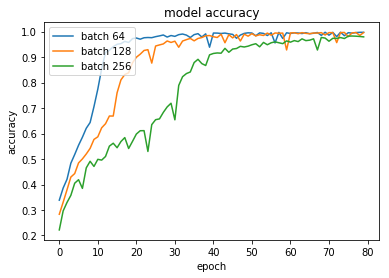

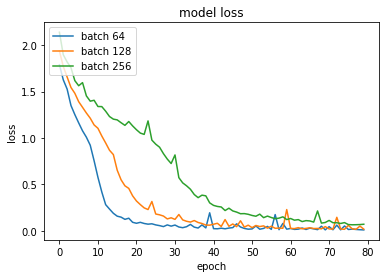

In [21]:
plt.plot(model_batch64.history['val_acc'][:80])
plt.plot(model_batch128.history['val_acc'])
plt.plot(model_batch256.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['batch 64', 'batch 128', 'batch 256'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_batch64.history['val_loss'][:80])
plt.plot(model_batch128.history['val_loss'])
plt.plot(model_batch256.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['batch 64', 'batch 128', 'batch 256'], loc='upper left')
plt.show()